In [1]:
import pypsa
import xarray as xr
import linopy as lp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [20]:
horizon = 48

In [65]:

# create a new shell-network
def prepare_profit_optimization_network():
    m = pypsa.Network()

    # take the base network 2045
    n = pypsa.Network('base_s_1__none_2045_lt.nc')

    # fix the capacities and create the model
    n.optimize.fix_optimal_capacities()
    n.optimize.create_model()
    # fix m to the size of n
    m.set_snapshots(n.snapshots)



    # Stores filtern - get all stores that contain battery
    battery_stores = n.stores[n.stores.carrier.str.contains("battery", case=False, na=False)]
    battery_buses = battery_stores.bus.unique()

    # Links filtern - get all links that contain battery (e.g. battery charger / discharger)
    link_mask = (
        n.links.carrier.str.contains("battery", case=False, na=False)
    )
    battery_links = n.links[link_mask]

    # Get all buses
    store_buses = battery_stores.bus.tolist()
    link_buses = pd.concat([
        battery_links.bus0, battery_links.bus1,
        battery_links.bus2, battery_links.bus3
    ]).dropna().tolist()

    needed_buses = list(set(store_buses + link_buses))
    needed_buses = [b for b in needed_buses if isinstance(b, str) and b.strip()]


    # Copy all buses, links and stores that refere to battery from model n to model m
    m.import_components_from_dataframe(n.buses.loc[needed_buses], "Bus")
    m.import_components_from_dataframe(battery_stores, "Store")
    m.import_components_from_dataframe(battery_links, "Link")

    # Add a free Generator so the battery storage can consume power
    m.add("Generator", "source", bus="DE0 0", p_nom=10000000000000, marginal_cost=0)

    # Add a constant load so the battery storage can discharge power
    m.add("Load",
        "fixed_load",
        bus="DE0 0", 
        p_set=5000000000)   

    # create the model
    m.optimize.create_model()

    return m


### Extra Functionality for the Optimization

# get the prices from the different szenarios
def change_obj(price_list):

    def helper(k,sns):
        print(sns[-1])
        # get battery charger, discharger and the efficiency
        battery_charger_2045 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery charger-2045"})
        battery_discharger_2045 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery discharger-2045"})

        battery_charger_2040 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery charger-2040"})
        battery_discharger_2040 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery discharger-2040"})
        efficiency_2045 = k.links.efficiency["DE0 0 battery charger-2045"]
        efficiency_2040 = k.links.efficiency["DE0 0 battery charger-2040"]

        capacity_battery_end = (k.model.variables["Store-e"].sel({"Store": "DE0 0 battery-2045", "snapshot": sns[-1]}) +
                                     k.model.variables["Store-e"].sel({"Store": "DE0 0 battery-2040", "snapshot": sns[-1]}) +
                                     k.model.variables["Store-e"].sel({"Store": "DE0 0 battery-2035", "snapshot": sns[-1]}) +
                                     k.model.variables["Store-e"].sel({"Store": "DE0 0 battery-2030", "snapshot": sns[-1]})
                                     )
        

        # Stochastic Profit Optimization:
        # for each price sum the expected profits and then maximize the resulting function.

        expected_profit = 0
        for price in price_list:
            # Umwandlung in xarray.DataArray mit passender snapshot-Koord.
            price_xr = xr.DataArray(price.values, coords={"snapshot": price.index}, dims="snapshot")

            last_time = sns[-1]
            if (last_time + pd.Timedelta(hours=24)).year > 2019:
                forecast_min = 0
            else:
                forecast_min = price[last_time : last_time + pd.Timedelta(hours=24)].min()
               
            #
            expected_profit += ((battery_discharger_2040 *price_xr 
                               + battery_discharger_2045 * price_xr 
                               - battery_charger_2040 * price_xr / efficiency_2040 
                               - battery_charger_2045 * price_xr / efficiency_2045
                               ).sum()
                               + capacity_battery_end * forecast_min
                               )/ len(price_list)

        k.model.objective = expected_profit 
        k.model.sense = 'max'

    return helper


def smart_edge_biased_multipliers(x, E_max=0.42, H=30, step_hours=3,
                                   alpha_min=0.5, alpha_max=20):
    """
    Für jeden Punkt:
      - dev = Abweichung
      - alpha = steuert U-Form vs. Mittelkugel
    """

    # sodass die Werte reproduzierbar sind
    #np.random.seed(42)
    # Basis dev
    time_points = np.arange(horizon) * step_hours
    base_deviations = E_max * (1 - np.exp(-time_points / H))
    base_deviations[0] = 0

    deviations = base_deviations[:x]

    # Für jeden dev: alpha zwischen alpha_max und alpha_min mappen
    alphas = alpha_max - (deviations / E_max) * (alpha_max - alpha_min)

    # Ziehe Beta(alpha, alpha)
    u = np.array([beta.rvs(a, a) for a in alphas])

    # Mappe Beta(0,1) auf [1 - dev, 1 + dev]
    multipliers = (1 - deviations) + u * 2 * deviations

    return multipliers


def wind_noise(hours, scaling_factor):

    # 2. MSE-Werte für LSTM-Modell aus Tabelle bis 168h --> aus der Tabelle des Papers (0 von mir)
    horizons = np.array([0, 24, 48, 72, 96, 168, 336])
    mse_values = np.array([0, 0.499, 0.794, 0.899, 0.943, 1.011, 1.064])
    rmse_std = np.sqrt(mse_values)  # RMSE in Standardform

    # 3. Skaliere RMSE auf echte MW-Einheit
    rmse_MW = rmse_std * scaling_factor

    # 4. Interpolation der RMSE auf 144h
    interp_rmse = interp1d(horizons, rmse_MW, kind='linear', fill_value='extrapolate')
    rmse_per_hour = interp_rmse(np.arange(0, hours*3, 3))  # Stunden 1–144


    # 5. Rauschen generieren und synthetische Prognose erzeugen
    noise = np.random.normal(loc=0, scale=1.2*rmse_per_hour)
    #noise = np.clip(noise, 0, None)  # alles < 0 → 0, Rest bleibt
    return noise


def pv_noise(hours, scaling_factor):

    # 2. MSE-Werte für LSTM-Modell aus Tabelle bis 168h --> aus der Tabelle des Papers (0 von mir)
    horizons = np.array([0, 24, 48, 72, 96, 168, 336])
    mse_values = np.array([0, 0.088, 0.121, 0.143, 0.150, 1.165, 1.175])
    rmse_std = np.sqrt(mse_values)  # RMSE in Standardform

    # 3. Skaliere RMSE auf echte MW-Einheit
    rmse_MW = rmse_std * scaling_factor

    # 4. Interpolation der RMSE auf 144h
    interp_rmse = interp1d(horizons, rmse_MW, kind='linear', fill_value='extrapolate')
    rmse_per_hour = interp_rmse(np.arange(0, hours*3, 3))  # Stunden 1–144


    # 5. Rauschen generieren und synthetische Prognose erzeugen
    noise = np.random.normal(loc=0, scale=1.2*rmse_per_hour)
    #noise = np.clip(noise, 0, None)  # alles < 0 → 0, Rest bleibt
    return noise

# Wrapper Funktion um cf übergeben zu können
def make_cf_scaler():
    # eigentliche funktion zum ändern der Constraints
    def change_cf(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2030, 2025, 2020]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 onwind-{year}"}
            rhs.loc[selector] = rhs.loc[selector] * smart_edge_biased_multipliers(len(sns))

    return change_cf


# Wrapper Funktion um cf übergeben zu können
def change_wind_noise():
    # eigentliche funktion zum ändern der Constraints
    def change_wind(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2030, 2025, 2020]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 onwind-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            #multiplier = (rhs.loc[selector] + 10) / rhs.loc[selector]
            #multiplier.fillna(1)
            wind_power = rhs.sel(selector) + wind_noise(len(sns), scaling_factor)
            wind_power = wind_power.where(wind_power >= 0, 0)
            rhs.loc[selector] = wind_power

    return change_wind

# Wrapper Funktion um cf übergeben zu können
def change_pv_noise():
    # eigentliche funktion zum ändern der Constraints
    def change_pv(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2020, 2015]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 solar-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            pv_power = rhs.sel(selector) + pv_noise(len(sns), scaling_factor)
            pv_power = pv_power.where(pv_power >= 0, 0)
            rhs.loc[selector] = pv_power

        years = [2030, 2025]
        for year in years:
            selector = {"Generator-fix": f"DE0 0 solar-hsat-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            pv_power = rhs.sel(selector) + pv_noise(len(sns), scaling_factor)
            pv_power = pv_power.where(pv_power >= 0, 0)
            rhs.loc[selector] = pv_power

    return change_pv


def change_wind_and_pv_noise():
    # eigentliche funktion zum ändern der Constraints
    def change_both(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2020, 2015]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 solar-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            pv_power = rhs.sel(selector) + pv_noise(len(sns), scaling_factor)
            pv_power = pv_power.where(pv_power >= 0, 0)
            rhs.loc[selector] = pv_power

        years = [2030, 2025]
        for year in years:
            selector = {"Generator-fix": f"DE0 0 solar-hsat-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            p_nom = n.generator.p_nom[selector]
            pv_power = rhs.sel(selector) + pv_noise(len(sns), scaling_factor)
            pv_power = pv_power.where(pv_power >= 0, 0)
            pv_power = pv_power.where(pv_power <= p_nom, p_nom)
            rhs.loc[selector] = pv_power

        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2030, 2025, 2020]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 onwind-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            p_nom = n.generator.p_nom[selector]
            wind_power = rhs.sel(selector) + wind_noise(len(sns), scaling_factor)
            wind_power = wind_power.where(wind_power >= 0, 0)
            wind_power = wind_power.where(wind_power <= p_nom, p_nom)
            rhs.loc[selector] = wind_power

    return change_both

In [45]:
## create 3 different prices from 3 different scenarios
networks = []
for i in range(0,5):
    n = pypsa.Network('base_s_1__none_2045_lt.nc')
    n.optimize.fix_optimal_capacities()
    n.optimize.create_model()

    n.optimize.optimize_with_rolling_horizon(
    solver_name = "gurobi",
    horizon = horizon,
    overlap = 0,
    extra_functionality=change_wind_and_pv_noise()
    )

    networks.append(n)



INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 255.94it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_mm1pc6o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_mm1pc6o.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x96231983


INFO:gurobipy:Model fingerprint: 0x96231983


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4367 columns


INFO:gurobipy:Presolve removed 22641 rows and 4367 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7345 columns, 14605 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7345 columns, 14605 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03063956e+11 -1.47227674e+13  1.53e+06 4.60e+01  4.29e+09     0s


INFO:gurobipy:   0   2.03063956e+11 -1.47227674e+13  1.53e+06 4.60e+01  4.29e+09     0s


   1   2.78407104e+10 -1.02138244e+12  1.29e+05 4.66e-11  3.32e+08     0s


INFO:gurobipy:   1   2.78407104e+10 -1.02138244e+12  1.29e+05 4.66e-11  3.32e+08     0s


   2   7.50095501e+09 -2.33285420e+11  8.87e+03 6.80e-10  3.17e+07     0s


INFO:gurobipy:   2   7.50095501e+09 -2.33285420e+11  8.87e+03 6.80e-10  3.17e+07     0s


   3   1.74137477e+09 -5.21653650e+10  6.54e+02 4.32e-10  4.45e+06     0s


INFO:gurobipy:   3   1.74137477e+09 -5.21653650e+10  6.54e+02 4.32e-10  4.45e+06     0s


   4   1.12110145e+09 -9.40602117e+09  7.81e+01 1.29e-10  7.70e+05     0s


INFO:gurobipy:   4   1.12110145e+09 -9.40602117e+09  7.81e+01 1.29e-10  7.70e+05     0s


   5   6.37995201e+08 -2.13659355e+09  1.54e+01 3.20e-10  1.98e+05     0s


INFO:gurobipy:   5   6.37995201e+08 -2.13659355e+09  1.54e+01 3.20e-10  1.98e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.07 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.07 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1742    2.2609019e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1742    2.2609019e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1742 iterations and 0.09 seconds (0.06 work units)


INFO:gurobipy:Solved in 1742 iterations and 0.09 seconds (0.06 work units)


Optimal objective  2.260901857e+08


INFO:gurobipy:Optimal objective  2.260901857e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.26e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.49it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fnmdafbc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fnmdafbc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5040b40f


INFO:gurobipy:Model fingerprint: 0x5040b40f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4364 columns


INFO:gurobipy:Presolve removed 22642 rows and 4364 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7348 columns, 14610 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7348 columns, 14610 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.00558497e+11 -1.47443126e+13  2.31e+06 5.51e+01  5.96e+09     0s


INFO:gurobipy:   0   3.00558497e+11 -1.47443126e+13  2.31e+06 5.51e+01  5.96e+09     0s


   1   3.77909949e+10 -1.26793491e+12  1.95e+05 5.09e-11  4.87e+08     0s


INFO:gurobipy:   1   3.77909949e+10 -1.26793491e+12  1.95e+05 5.09e-11  4.87e+08     0s


   2   8.09285105e+09 -2.99947678e+11  1.01e+04 1.43e-09  3.91e+07     0s


INFO:gurobipy:   2   8.09285105e+09 -2.99947678e+11  1.01e+04 1.43e-09  3.91e+07     0s


   3   3.38050089e+09 -6.62539315e+10  1.11e+03 5.78e-10  6.15e+06     0s


INFO:gurobipy:   3   3.38050089e+09 -6.62539315e+10  1.11e+03 5.78e-10  6.15e+06     0s


   4   1.51545605e+09 -1.52654880e+10  2.04e+02 4.68e-10  1.30e+06     0s


INFO:gurobipy:   4   1.51545605e+09 -1.52654880e+10  2.04e+02 4.68e-10  1.30e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1875    2.4597121e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1875    2.4597121e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1875 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1875 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.459712075e+08


INFO:gurobipy:Optimal objective  2.459712075e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.46e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 258.71it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vbi1pbya.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vbi1pbya.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x21159d34


INFO:gurobipy:Model fingerprint: 0x21159d34


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4343 columns


INFO:gurobipy:Presolve removed 22641 rows and 4343 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7369 columns, 14629 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7369 columns, 14629 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.87485396e+11 -1.47704050e+13  3.02e+06 4.64e+01  7.48e+09     0s


INFO:gurobipy:   0   3.87485396e+11 -1.47704050e+13  3.02e+06 4.64e+01  7.48e+09     0s


   1   4.63501999e+10 -1.34484799e+12  2.58e+05 5.09e-11  6.23e+08     0s


INFO:gurobipy:   1   4.63501999e+10 -1.34484799e+12  2.58e+05 5.09e-11  6.23e+08     0s


   2   7.98357346e+09 -3.64212233e+11  1.17e+04 2.90e-09  4.66e+07     0s


INFO:gurobipy:   2   7.98357346e+09 -3.64212233e+11  1.17e+04 2.90e-09  4.66e+07     0s


   3   2.45609022e+09 -7.89684721e+10  1.46e+03 1.01e-09  7.42e+06     0s


INFO:gurobipy:   3   2.45609022e+09 -7.89684721e+10  1.46e+03 1.01e-09  7.42e+06     0s


   4   1.11194851e+09 -1.18378980e+10  2.03e+02 3.69e-10  1.03e+06     0s


INFO:gurobipy:   4   1.11194851e+09 -1.18378980e+10  2.03e+02 3.69e-10  1.03e+06     0s


   5   6.32814914e+08 -2.89785018e+09  4.26e+01 7.07e-11  2.64e+05     0s


INFO:gurobipy:   5   6.32814914e+08 -2.89785018e+09  4.26e+01 7.07e-11  2.64e+05     0s


   6   4.39128505e+08 -1.22070094e+09  1.16e+01 4.89e-11  1.19e+05     0s


INFO:gurobipy:   6   4.39128505e+08 -1.22070094e+09  1.16e+01 4.89e-11  1.19e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1980    2.1598480e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1980    2.1598480e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1980 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1980 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.159848013e+08


INFO:gurobipy:Optimal objective  2.159848013e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 255.92it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-86c_erx7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-86c_erx7.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe7965a7f


INFO:gurobipy:Model fingerprint: 0xe7965a7f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4583 columns


INFO:gurobipy:Presolve removed 22641 rows and 4583 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7129 columns, 14215 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7129 columns, 14215 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72213259e+11 -1.47781232e+13  3.78e+06 4.82e+01  9.14e+09     0s


INFO:gurobipy:   0   4.72213259e+11 -1.47781232e+13  3.78e+06 4.82e+01  9.14e+09     0s


   1   5.64909678e+10 -1.49035130e+12  3.22e+05 4.99e-11  7.70e+08     0s


INFO:gurobipy:   1   5.64909678e+10 -1.49035130e+12  3.22e+05 4.99e-11  7.70e+08     0s


   2   1.17966203e+10 -3.73760801e+11  1.72e+04 1.63e-09  5.92e+07     0s


INFO:gurobipy:   2   1.17966203e+10 -3.73760801e+11  1.72e+04 1.63e-09  5.92e+07     0s


   3   1.83563405e+10 -1.31332919e+11  4.22e+03 1.24e-09  1.78e+07     0s


INFO:gurobipy:   3   1.83563405e+10 -1.31332919e+11  4.22e+03 1.24e-09  1.78e+07     0s


   4   2.03355900e+10 -2.76089241e+10  1.22e+03 1.20e-09  5.08e+06     0s


INFO:gurobipy:   4   2.03355900e+10 -2.76089241e+10  1.22e+03 1.20e-09  5.08e+06     0s


   5   1.97061317e+10 -2.79531979e+08  3.14e+02 9.06e-10  1.76e+06     0s


INFO:gurobipy:   5   1.97061317e+10 -2.79531979e+08  3.14e+02 9.06e-10  1.76e+06     0s


   6   1.88006059e+10  1.01351280e+10  8.61e+01 8.91e-10  6.89e+05     0s


INFO:gurobipy:   6   1.88006059e+10  1.01351280e+10  8.61e+01 8.91e-10  6.89e+05     0s


   7   1.82336610e+10  1.51909096e+10  2.37e+01 2.06e-10  2.34e+05     0s


INFO:gurobipy:   7   1.82336610e+10  1.51909096e+10  2.37e+01 2.06e-10  2.34e+05     0s


   8   1.78525113e+10  1.69162609e+10  3.61e+00 1.47e-10  6.88e+04     0s


INFO:gurobipy:   8   1.78525113e+10  1.69162609e+10  3.61e+00 1.47e-10  6.88e+04     0s


INFO:gurobipy:


Barrier performed 8 iterations in 0.19 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 8 iterations in 0.19 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1898    1.7685132e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1898    1.7685132e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1898 iterations and 0.21 seconds (0.06 work units)


INFO:gurobipy:Solved in 1898 iterations and 0.21 seconds (0.06 work units)


Optimal objective  1.768513208e+10


INFO:gurobipy:Optimal objective  1.768513208e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.77e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.91it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-21ngzilp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-21ngzilp.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdf708351


INFO:gurobipy:Model fingerprint: 0xdf708351


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4395 columns


INFO:gurobipy:Presolve removed 22641 rows and 4395 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7317 columns, 14543 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7317 columns, 14543 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.26807420e+11 -1.47812767e+13  4.97e+06 5.87e+01  1.17e+10     0s


INFO:gurobipy:   0   6.26807420e+11 -1.47812767e+13  4.97e+06 5.87e+01  1.17e+10     0s


   1   7.17309841e+10 -1.72009025e+12  4.23e+05 5.52e-11  9.98e+08     0s


INFO:gurobipy:   1   7.17309841e+10 -1.72009025e+12  4.23e+05 5.52e-11  9.98e+08     0s


   2   1.03597077e+10 -4.58675719e+11  1.70e+04 2.48e-09  6.44e+07     0s


INFO:gurobipy:   2   1.03597077e+10 -4.58675719e+11  1.70e+04 2.48e-09  6.44e+07     0s


   3   8.33828739e+09 -9.51959477e+10  3.25e+03 1.60e-09  1.20e+07     0s


INFO:gurobipy:   3   8.33828739e+09 -9.51959477e+10  3.25e+03 1.60e-09  1.20e+07     0s


   4   3.81905938e+09 -3.21309589e+10  1.00e+03 1.55e-09  3.60e+06     0s


INFO:gurobipy:   4   3.81905938e+09 -3.21309589e+10  1.00e+03 1.55e-09  3.60e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1789    4.6654638e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1789    4.6654638e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1789 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1789 iterations and 0.10 seconds (0.06 work units)


Optimal objective  4.665463786e+08


INFO:gurobipy:Optimal objective  4.665463786e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.67e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.20it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tcukyyhx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tcukyyhx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8439471e


INFO:gurobipy:Model fingerprint: 0x8439471e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4358 columns


INFO:gurobipy:Presolve removed 22641 rows and 4358 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7354 columns, 14608 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7354 columns, 14608 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.65282368e+11 -1.48043721e+13  6.08e+06 4.49e+01  1.40e+10     0s


INFO:gurobipy:   0   7.65282368e+11 -1.48043721e+13  6.08e+06 4.49e+01  1.40e+10     0s


   1   8.63793060e+10 -1.91156568e+12  5.25e+05 4.73e-11  1.23e+09     0s


INFO:gurobipy:   1   8.63793060e+10 -1.91156568e+12  5.25e+05 4.73e-11  1.23e+09     0s


   2   1.09391898e+10 -5.00905516e+11  1.89e+04 1.57e-09  7.12e+07     0s


INFO:gurobipy:   2   1.09391898e+10 -5.00905516e+11  1.89e+04 1.57e-09  7.12e+07     0s


   3   9.97976377e+09 -1.07358497e+11  2.66e+03 5.56e-10  1.22e+07     0s


INFO:gurobipy:   3   9.97976377e+09 -1.07358497e+11  2.66e+03 5.56e-10  1.22e+07     0s


   4   4.79995431e+09 -2.65226076e+10  2.87e+02 2.97e-10  2.47e+06     0s


INFO:gurobipy:   4   4.79995431e+09 -2.65226076e+10  2.87e+02 2.97e-10  2.47e+06     0s


   5   2.40298043e+09 -8.66637944e+09  1.11e+02 3.49e-10  8.55e+05     0s


INFO:gurobipy:   5   2.40298043e+09 -8.66637944e+09  1.11e+02 3.49e-10  8.55e+05     0s


   6   1.65187509e+09 -3.77754755e+09  7.28e+01 2.62e-10  4.30e+05     0s


INFO:gurobipy:   6   1.65187509e+09 -3.77754755e+09  7.28e+01 2.62e-10  4.30e+05     0s


   7   1.21807392e+09 -1.50789167e+09  5.36e+01 1.12e-10  2.28e+05     0s


INFO:gurobipy:   7   1.21807392e+09 -1.50789167e+09  5.36e+01 1.12e-10  2.28e+05     0s


   8   8.90552274e+08 -4.12513679e+08  3.73e+01 1.12e-10  1.15e+05     0s


INFO:gurobipy:   8   8.90552274e+08 -4.12513679e+08  3.73e+01 1.12e-10  1.15e+05     0s


   9   7.49516371e+08  9.90562196e+07  1.56e+01 1.18e-10  5.41e+04     0s


INFO:gurobipy:   9   7.49516371e+08  9.90562196e+07  1.56e+01 1.18e-10  5.41e+04     0s


  10   6.89167259e+08  3.40672187e+08  4.41e+00 6.05e-11  2.63e+04     0s


INFO:gurobipy:  10   6.89167259e+08  3.40672187e+08  4.41e+00 6.05e-11  2.63e+04     0s


INFO:gurobipy:


Barrier performed 10 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 10 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2059    6.0954368e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2059    6.0954368e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2059 iterations and 0.11 seconds (0.07 work units)


INFO:gurobipy:Solved in 2059 iterations and 0.11 seconds (0.07 work units)


Optimal objective  6.095436785e+08


INFO:gurobipy:Optimal objective  6.095436785e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 6.10e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.29it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k9wb47zv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k9wb47zv.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe09073fe


INFO:gurobipy:Model fingerprint: 0xe09073fe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4310 columns


INFO:gurobipy:Presolve removed 22641 rows and 4310 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7402 columns, 14665 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7402 columns, 14665 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.07058245e+11 -1.48498889e+13  7.20e+06 3.99e+01  1.64e+10     0s


INFO:gurobipy:   0   9.07058245e+11 -1.48498889e+13  7.20e+06 3.99e+01  1.64e+10     0s


   1   1.00994473e+11 -2.11176189e+12  6.21e+05 5.24e-11  1.44e+09     0s


INFO:gurobipy:   1   1.00994473e+11 -2.11176189e+12  6.21e+05 5.24e-11  1.44e+09     0s


   2   9.86265508e+09 -5.54155688e+11  1.94e+04 1.57e-09  7.57e+07     0s


INFO:gurobipy:   2   9.86265508e+09 -5.54155688e+11  1.94e+04 1.57e-09  7.57e+07     0s


   3   3.47174374e+09 -1.15325732e+11  2.44e+03 6.87e-10  1.15e+07     0s


INFO:gurobipy:   3   3.47174374e+09 -1.15325732e+11  2.44e+03 6.87e-10  1.15e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1912    2.1512098e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1912    2.1512098e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1912 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1912 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.151209846e+08


INFO:gurobipy:Optimal objective  2.151209846e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.99it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-labmkavh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-labmkavh.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6c4d4c9b


INFO:gurobipy:Model fingerprint: 0x6c4d4c9b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4329 columns


INFO:gurobipy:Presolve removed 22641 rows and 4329 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7383 columns, 14646 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7383 columns, 14646 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.17543665e+12 -1.65093822e+13  3.35e+07 4.16e+01  7.29e+10     0s


INFO:gurobipy:   0   4.17543665e+12 -1.65093822e+13  3.35e+07 4.16e+01  7.29e+10     0s


   1   9.95230573e+11 -5.55286529e+12  7.41e+06 5.39e-11  1.62e+10     0s


INFO:gurobipy:   1   9.95230573e+11 -5.55286529e+12  7.41e+06 5.39e-11  1.62e+10     0s


   2   1.09173414e+11 -2.19061814e+12  7.50e+05 5.52e-11  1.74e+09     0s


INFO:gurobipy:   2   1.09173414e+11 -2.19061814e+12  7.50e+05 5.52e-11  1.74e+09     0s


   3   1.50207272e+10 -5.46931291e+11  6.30e+04 8.23e-10  1.63e+08     0s


INFO:gurobipy:   3   1.50207272e+10 -5.46931291e+11  6.30e+04 8.23e-10  1.63e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1829    2.1505270e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1829    2.1505270e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1829 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1829 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.150526966e+08


INFO:gurobipy:Optimal objective  2.150526966e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.02it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-inwtf6hn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-inwtf6hn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9bd52d15


INFO:gurobipy:Model fingerprint: 0x9bd52d15


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4325 columns


INFO:gurobipy:Presolve removed 22642 rows and 4325 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7387 columns, 14649 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7387 columns, 14649 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27383868e+12 -1.82617852e+13  3.43e+07 4.38e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27383868e+12 -1.82617852e+13  3.43e+07 4.38e+01  7.46e+10     0s


   1   8.55577781e+11 -5.25813461e+12  6.18e+06 3.65e+02  1.34e+10     0s


INFO:gurobipy:   1   8.55577781e+11 -5.25813461e+12  6.18e+06 3.65e+02  1.34e+10     0s


   2   8.75165697e+10 -1.77563963e+12  5.71e+05 1.10e-10  1.32e+09     0s


INFO:gurobipy:   2   8.75165697e+10 -1.77563963e+12  5.71e+05 1.10e-10  1.32e+09     0s


   3   1.02960960e+10 -4.60720152e+11  1.74e+04 2.54e-09  6.55e+07     0s


INFO:gurobipy:   3   1.02960960e+10 -4.60720152e+11  1.74e+04 2.54e-09  6.55e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1805    2.2802267e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1805    2.2802267e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1805 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1805 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.280226697e+08


INFO:gurobipy:Optimal objective  2.280226697e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.28e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.75it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-50zev57t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-50zev57t.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd75f01b4


INFO:gurobipy:Model fingerprint: 0xd75f01b4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4364 columns


INFO:gurobipy:Presolve removed 22641 rows and 4364 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7348 columns, 14611 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7348 columns, 14611 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00854423e+12 -1.85865371e+13  3.22e+07 7.16e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00854423e+12 -1.85865371e+13  3.22e+07 7.16e+01  7.01e+10     0s


   1   7.65425275e+11 -5.18599961e+12  5.55e+06 5.50e+02  1.21e+10     0s


INFO:gurobipy:   1   7.65425275e+11 -5.18599961e+12  5.55e+06 5.50e+02  1.21e+10     0s


   2   7.36919547e+10 -1.72028826e+12  4.72e+05 6.11e-11  1.10e+09     0s


INFO:gurobipy:   2   7.36919547e+10 -1.72028826e+12  4.72e+05 6.11e-11  1.10e+09     0s


   3   9.91637147e+09 -4.19848929e+11  1.45e+04 1.65e-09  5.70e+07     0s


INFO:gurobipy:   3   9.91637147e+09 -4.19848929e+11  1.45e+04 1.65e-09  5.70e+07     0s


   4   6.34412958e+09 -1.09969450e+11  2.23e+03 2.10e-10  1.12e+07     0s


INFO:gurobipy:   4   6.34412958e+09 -1.09969450e+11  2.23e+03 2.10e-10  1.12e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1858    2.3380166e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1858    2.3380166e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1858 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1858 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.338016570e+08


INFO:gurobipy:Optimal objective  2.338016570e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.34e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.15it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ukqt_m8u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ukqt_m8u.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdee1b1ff


INFO:gurobipy:Model fingerprint: 0xdee1b1ff


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4311 columns


INFO:gurobipy:Presolve removed 22641 rows and 4311 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7401 columns, 14664 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7401 columns, 14664 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02113234e+12 -1.86724414e+13  3.23e+07 4.22e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02113234e+12 -1.86724414e+13  3.23e+07 4.22e+01  7.03e+10     0s


   1   6.95103290e+11 -5.26636608e+12  4.96e+06 7.09e+02  1.08e+10     0s


INFO:gurobipy:   1   6.95103290e+11 -5.26636608e+12  4.96e+06 7.09e+02  1.08e+10     0s


   2   6.62663575e+10 -1.72757881e+12  4.19e+05 8.67e-10  9.90e+08     0s


INFO:gurobipy:   2   6.62663575e+10 -1.72757881e+12  4.19e+05 8.67e-10  9.90e+08     0s


   3   7.99824711e+09 -4.16539767e+11  1.22e+04 1.29e-09  5.16e+07     0s


INFO:gurobipy:   3   7.99824711e+09 -4.16539767e+11  1.22e+04 1.29e-09  5.16e+07     0s


   4   3.17123575e+09 -1.39184570e+11  2.34e+03 3.58e-10  1.29e+07     0s


INFO:gurobipy:   4   3.17123575e+09 -1.39184570e+11  2.34e+03 3.58e-10  1.29e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1836    2.1446173e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1836    2.1446173e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1836 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1836 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.144617343e+08


INFO:gurobipy:Optimal objective  2.144617343e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.45it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4pj5wqu5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4pj5wqu5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd2cddb40


INFO:gurobipy:Model fingerprint: 0xd2cddb40


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4295 columns


INFO:gurobipy:Presolve removed 22641 rows and 4295 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7417 columns, 14680 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7417 columns, 14680 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24580982e+12 -1.83558359e+13  3.41e+07 3.94e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24580982e+12 -1.83558359e+13  3.41e+07 3.94e+01  7.42e+10     0s


   1   7.62493578e+11 -5.26250105e+12  5.44e+06 2.66e+02  1.19e+10     0s


INFO:gurobipy:   1   7.62493578e+11 -5.26250105e+12  5.44e+06 2.66e+02  1.19e+10     0s


   2   6.57469441e+10 -1.80262712e+12  4.15e+05 6.83e-11  9.87e+08     0s


INFO:gurobipy:   2   6.57469441e+10 -1.80262712e+12  4.15e+05 6.83e-11  9.87e+08     0s


   3   7.95695566e+09 -4.23375881e+11  1.29e+04 3.72e-10  5.33e+07     0s


INFO:gurobipy:   3   7.95695566e+09 -4.23375881e+11  1.29e+04 3.72e-10  5.33e+07     0s


   4   1.55531750e+09 -8.37246081e+10  8.11e+02 9.78e-10  6.78e+06     0s


INFO:gurobipy:   4   1.55531750e+09 -8.37246081e+10  8.11e+02 9.78e-10  6.78e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2032    2.1473147e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2032    2.1473147e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2032 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 2032 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.147314732e+08


INFO:gurobipy:Optimal objective  2.147314732e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.99it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n718jy81.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n718jy81.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb42f071b


INFO:gurobipy:Model fingerprint: 0xb42f071b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4315 columns


INFO:gurobipy:Presolve removed 22641 rows and 4315 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7397 columns, 14660 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7397 columns, 14660 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.03252837e+12 -1.80252566e+13  3.24e+07 7.39e+01  7.05e+10     0s


INFO:gurobipy:   0   4.03252837e+12 -1.80252566e+13  3.24e+07 7.39e+01  7.05e+10     0s


   1   6.62438397e+11 -5.12380351e+12  4.68e+06 5.66e+02  1.02e+10     0s


INFO:gurobipy:   1   6.62438397e+11 -5.12380351e+12  4.68e+06 5.66e+02  1.02e+10     0s


   2   5.31793200e+10 -1.73264427e+12  3.22e+05 6.97e-11  7.88e+08     0s


INFO:gurobipy:   2   5.31793200e+10 -1.73264427e+12  3.22e+05 6.97e-11  7.88e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.14 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.14 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1871    2.1479049e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1871    2.1479049e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1871 iterations and 0.18 seconds (0.06 work units)


INFO:gurobipy:Solved in 1871 iterations and 0.18 seconds (0.06 work units)


Optimal objective  2.147904936e+08


INFO:gurobipy:Optimal objective  2.147904936e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.95it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lxjtzpyx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lxjtzpyx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9028dbc6


INFO:gurobipy:Model fingerprint: 0x9028dbc6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4366 columns


INFO:gurobipy:Presolve removed 22641 rows and 4366 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7346 columns, 14609 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7346 columns, 14609 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27393363e+12 -1.83335432e+13  3.43e+07 4.67e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27393363e+12 -1.83335432e+13  3.43e+07 4.67e+01  7.46e+10     0s


   1   7.04262446e+11 -5.33630855e+12  4.95e+06 4.60e+02  1.08e+10     0s


INFO:gurobipy:   1   7.04262446e+11 -5.33630855e+12  4.95e+06 4.60e+02  1.08e+10     0s


   2   5.70566958e+10 -1.74439265e+12  3.44e+05 5.13e-09  8.35e+08     0s


INFO:gurobipy:   2   5.70566958e+10 -1.74439265e+12  3.44e+05 5.13e-09  8.35e+08     0s


   3   9.23698475e+09 -3.65591854e+11  1.42e+04 2.92e-10  5.20e+07     0s


INFO:gurobipy:   3   9.23698475e+09 -3.65591854e+11  1.42e+04 2.92e-10  5.20e+07     0s


   4   3.94778288e+09 -9.29725069e+10  1.02e+03 6.43e-10  8.00e+06     0s


INFO:gurobipy:   4   3.94778288e+09 -9.29725069e+10  1.02e+03 6.43e-10  8.00e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1729    2.1477715e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1729    2.1477715e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1729 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1729 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.147771503e+08


INFO:gurobipy:Optimal objective  2.147771503e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.84it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6l24vcqn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6l24vcqn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x246eb277


INFO:gurobipy:Model fingerprint: 0x246eb277


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22640 rows and 4339 columns


INFO:gurobipy:Presolve removed 22640 rows and 4339 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1073 rows, 7373 columns, 14637 nonzeros


INFO:gurobipy:Presolved: 1073 rows, 7373 columns, 14637 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.800e+03


INFO:gurobipy: AA' NZ     : 2.800e+03


 Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


 Factor Ops : 6.692e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.692e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01137014e+12 -1.82606623e+13  3.22e+07 5.26e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01137014e+12 -1.82606623e+13  3.22e+07 5.26e+01  7.01e+10     0s


   1   4.16452254e+11 -5.17577945e+12  2.73e+06 7.14e+02  6.12e+09     0s


INFO:gurobipy:   1   4.16452254e+11 -5.17577945e+12  2.73e+06 7.14e+02  6.12e+09     0s


   2   3.56224681e+10 -1.47608836e+12  1.85e+05 2.28e+01  4.84e+08     0s


INFO:gurobipy:   2   3.56224681e+10 -1.47608836e+12  1.85e+05 2.28e+01  4.84e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1622    2.1471052e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1622    2.1471052e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1622 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1622 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.147105204e+08


INFO:gurobipy:Optimal objective  2.147105204e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.70it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m1m75iqq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m1m75iqq.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7b29d5d6


INFO:gurobipy:Model fingerprint: 0x7b29d5d6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4329 columns


INFO:gurobipy:Presolve removed 22638 rows and 4329 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7383 columns, 14649 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7383 columns, 14649 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27535198e+12 -1.83395174e+13  3.43e+07 4.77e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27535198e+12 -1.83395174e+13  3.43e+07 4.77e+01  7.46e+10     0s


   1   6.60969835e+11 -5.30316150e+12  4.56e+06 3.83e+02  1.00e+10     0s


INFO:gurobipy:   1   6.60969835e+11 -5.30316150e+12  4.56e+06 3.83e+02  1.00e+10     0s


   2   4.81717104e+10 -1.67337643e+12  2.77e+05 9.15e-11  6.89e+08     0s


INFO:gurobipy:   2   4.81717104e+10 -1.67337643e+12  2.77e+05 9.15e-11  6.89e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1431    2.4417634e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1431    2.4417634e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1431 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1431 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.441763388e+08


INFO:gurobipy:Optimal objective  2.441763388e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.44e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.87it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1dmcf2tm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1dmcf2tm.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0d4c02c8


INFO:gurobipy:Model fingerprint: 0x0d4c02c8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4290 columns


INFO:gurobipy:Presolve removed 22636 rows and 4290 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7422 columns, 14690 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7422 columns, 14690 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24525272e+12 -1.83957653e+13  3.41e+07 4.37e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24525272e+12 -1.83957653e+13  3.41e+07 4.37e+01  7.41e+10     0s


   1   6.58403455e+11 -5.22652834e+12  4.60e+06 2.44e+02  1.01e+10     0s


INFO:gurobipy:   1   6.58403455e+11 -5.22652834e+12  4.60e+06 2.44e+02  1.01e+10     0s


   2   4.26529116e+10 -1.64381805e+12  2.42e+05 9.03e-11  6.14e+08     0s


INFO:gurobipy:   2   4.26529116e+10 -1.64381805e+12  2.42e+05 9.03e-11  6.14e+08     0s


   3   8.19209944e+09 -2.94421414e+11  9.22e+03 1.38e-09  3.72e+07     0s


INFO:gurobipy:   3   8.19209944e+09 -2.94421414e+11  9.22e+03 1.38e-09  3.72e+07     0s


   4   4.13429120e+09 -6.94467497e+10  1.08e+03 1.93e-09  6.36e+06     0s


INFO:gurobipy:   4   4.13429120e+09 -6.94467497e+10  1.08e+03 1.93e-09  6.36e+06     0s


   5   1.47832495e+09 -1.18418629e+10  4.04e+02 2.78e-10  1.19e+06     0s


INFO:gurobipy:   5   1.47832495e+09 -1.18418629e+10  4.04e+02 2.78e-10  1.19e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1775    2.1516009e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1775    2.1516009e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1775 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1775 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.151600922e+08


INFO:gurobipy:Optimal objective  2.151600922e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.62it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t2r7ljq0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t2r7ljq0.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdd9f64a7


INFO:gurobipy:Model fingerprint: 0xdd9f64a7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4306 columns


INFO:gurobipy:Presolve removed 22636 rows and 4306 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7406 columns, 14658 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7406 columns, 14658 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27559148e+12 -1.80055341e+13  3.43e+07 2.97e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27559148e+12 -1.80055341e+13  3.43e+07 2.97e+02  7.45e+10     0s


   1   4.84333828e+11 -5.25842965e+12  3.18e+06 3.91e+02  7.08e+09     0s


INFO:gurobipy:   1   4.84333828e+11 -5.25842965e+12  3.18e+06 3.91e+02  7.08e+09     0s


   2   3.17979720e+10 -1.48371993e+12  1.61e+05 4.83e+00  4.34e+08     0s


INFO:gurobipy:   2   3.17979720e+10 -1.48371993e+12  1.61e+05 4.83e+00  4.34e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1574    2.1440526e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1574    2.1440526e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1574 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1574 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.144052557e+08


INFO:gurobipy:Optimal objective  2.144052557e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.53it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5d9zje_c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5d9zje_c.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2b2ee680


INFO:gurobipy:Model fingerprint: 0x2b2ee680


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4522 columns


INFO:gurobipy:Presolve removed 22637 rows and 4522 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7190 columns, 14258 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7190 columns, 14258 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.15349253e+12 -1.82549339e+13  3.34e+07 3.48e+02  7.18e+10     0s


INFO:gurobipy:   0   4.15349253e+12 -1.82549339e+13  3.34e+07 3.48e+02  7.18e+10     0s


   1   4.90055067e+11 -5.24072947e+12  3.05e+06 4.89e+02  6.74e+09     0s


INFO:gurobipy:   1   4.90055067e+11 -5.24072947e+12  3.05e+06 4.89e+02  6.74e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1682    2.1410786e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1682    2.1410786e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1682 iterations and 0.08 seconds (0.05 work units)


INFO:gurobipy:Solved in 1682 iterations and 0.08 seconds (0.05 work units)


Optimal objective  2.141078555e+08


INFO:gurobipy:Optimal objective  2.141078555e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.60it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s6uvje2l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s6uvje2l.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xca677bb3


INFO:gurobipy:Model fingerprint: 0xca677bb3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4340 columns


INFO:gurobipy:Presolve removed 22637 rows and 4340 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7372 columns, 14593 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7372 columns, 14593 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24309106e+12 -1.83459622e+13  3.41e+07 3.03e+02  7.39e+10     0s


INFO:gurobipy:   0   4.24309106e+12 -1.83459622e+13  3.41e+07 3.03e+02  7.39e+10     0s


   1   4.63931952e+11 -5.26913023e+12  3.00e+06 3.06e+02  6.70e+09     0s


INFO:gurobipy:   1   4.63931952e+11 -5.26913023e+12  3.00e+06 3.06e+02  6.70e+09     0s


   2   2.69226450e+10 -1.37911780e+12  1.25e+05 7.02e-10  3.52e+08     0s


INFO:gurobipy:   2   2.69226450e+10 -1.37911780e+12  1.25e+05 7.02e-10  3.52e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1574    2.1448722e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1574    2.1448722e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1574 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1574 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.144872156e+08


INFO:gurobipy:Optimal objective  2.144872156e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.07it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6e0kbi0e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6e0kbi0e.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcab60cc9


INFO:gurobipy:Model fingerprint: 0xcab60cc9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4285 columns


INFO:gurobipy:Presolve removed 22637 rows and 4285 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7427 columns, 14694 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7427 columns, 14694 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27285156e+12 -1.81288928e+13  3.43e+07 4.74e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27285156e+12 -1.81288928e+13  3.43e+07 4.74e+01  7.45e+10     0s


   1   4.60617821e+11 -5.26375149e+12  2.97e+06 3.76e+02  6.63e+09     0s


INFO:gurobipy:   1   4.60617821e+11 -5.26375149e+12  2.97e+06 3.76e+02  6.63e+09     0s


   2   2.11714833e+10 -1.32275193e+12  9.06e+04 2.12e+00  2.76e+08     0s


INFO:gurobipy:   2   2.11714833e+10 -1.32275193e+12  9.06e+04 2.12e+00  2.76e+08     0s


   3   5.83320189e+09 -2.56010487e+11  5.01e+03 5.12e-10  2.62e+07     0s


INFO:gurobipy:   3   5.83320189e+09 -2.56010487e+11  5.01e+03 5.12e-10  2.62e+07     0s


   4   1.04781491e+09 -8.91490830e+10  6.17e+02 9.22e-10  6.82e+06     0s


INFO:gurobipy:   4   1.04781491e+09 -8.91490830e+10  6.17e+02 9.22e-10  6.82e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1800    2.1469032e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1800    2.1469032e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1800 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1800 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.146903239e+08


INFO:gurobipy:Optimal objective  2.146903239e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.43it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-foct7y32.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-foct7y32.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x87da6256


INFO:gurobipy:Model fingerprint: 0x87da6256


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4284 columns


INFO:gurobipy:Presolve removed 22637 rows and 4284 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7428 columns, 14695 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7428 columns, 14695 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24777789e+12 -1.85359348e+13  3.41e+07 5.21e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24777789e+12 -1.85359348e+13  3.41e+07 5.21e+01  7.42e+10     0s


   1   4.50270314e+11 -5.29324854e+12  2.95e+06 3.63e+02  6.60e+09     0s


INFO:gurobipy:   1   4.50270314e+11 -5.29324854e+12  2.95e+06 3.63e+02  6.60e+09     0s


   2   2.11131216e+10 -1.30524063e+12  9.18e+04 3.86e+00  2.77e+08     0s


INFO:gurobipy:   2   2.11131216e+10 -1.30524063e+12  9.18e+04 3.86e+00  2.77e+08     0s


   3   6.65510988e+09 -3.08723886e+11  6.53e+03 1.11e-09  3.26e+07     0s


INFO:gurobipy:   3   6.65510988e+09 -3.08723886e+11  6.53e+03 1.11e-09  3.26e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1706    2.1459717e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1706    2.1459717e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1706 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1706 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.145971684e+08


INFO:gurobipy:Optimal objective  2.145971684e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.54it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t000xivg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t000xivg.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x73d3f3a2


INFO:gurobipy:Model fingerprint: 0x73d3f3a2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4324 columns


INFO:gurobipy:Presolve removed 22638 rows and 4324 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7388 columns, 14609 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7388 columns, 14609 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27599735e+12 -1.83492135e+13  3.43e+07 2.71e+02  7.44e+10     0s


INFO:gurobipy:   0   4.27599735e+12 -1.83492135e+13  3.43e+07 2.71e+02  7.44e+10     0s


   1   4.66227769e+11 -5.34363461e+12  3.00e+06 4.41e+02  6.71e+09     0s


INFO:gurobipy:   1   4.66227769e+11 -5.34363461e+12  3.00e+06 4.41e+02  6.71e+09     0s


   2   1.95059097e+10 -1.27472366e+12  7.67e+04 6.13e+00  2.44e+08     0s


INFO:gurobipy:   2   1.95059097e+10 -1.27472366e+12  7.67e+04 6.13e+00  2.44e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1533    2.1500132e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1533    2.1500132e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1533 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1533 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.150013203e+08


INFO:gurobipy:Optimal objective  2.150013203e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.42it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nnav00mx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nnav00mx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8675244d


INFO:gurobipy:Model fingerprint: 0x8675244d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4478 columns


INFO:gurobipy:Presolve removed 22636 rows and 4478 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7234 columns, 14334 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7234 columns, 14334 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24935165e+12 -1.83377502e+13  3.41e+07 2.75e+02  7.35e+10     0s


INFO:gurobipy:   0   4.24935165e+12 -1.83377502e+13  3.41e+07 2.75e+02  7.35e+10     0s


   1   4.99803740e+11 -5.23166189e+12  3.10e+06 2.41e+02  6.85e+09     0s


INFO:gurobipy:   1   4.99803740e+11 -5.23166189e+12  3.10e+06 2.41e+02  6.85e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.14 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.14 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1842    2.1458322e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1842    2.1458322e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1842 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1842 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.145832189e+08


INFO:gurobipy:Optimal objective  2.145832189e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.89it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-speguuss.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-speguuss.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9c2fb6b4


INFO:gurobipy:Model fingerprint: 0x9c2fb6b4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4455 columns


INFO:gurobipy:Presolve removed 22636 rows and 4455 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1077 rows, 7257 columns, 14369 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7257 columns, 14369 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27618991e+12 -1.81089634e+13  3.43e+07 3.01e+02  7.40e+10     0s


INFO:gurobipy:   0   4.27618991e+12 -1.81089634e+13  3.43e+07 3.01e+02  7.40e+10     0s


   1   4.87452615e+11 -5.27752828e+12  3.06e+06 4.35e+02  6.80e+09     0s


INFO:gurobipy:   1   4.87452615e+11 -5.27752828e+12  3.06e+06 4.35e+02  6.80e+09     0s


   2   1.83148090e+10 -1.20434055e+12  6.45e+04 1.30e+00  2.15e+08     0s


INFO:gurobipy:   2   1.83148090e+10 -1.20434055e+12  6.45e+04 1.30e+00  2.15e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1738    2.1406779e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1738    2.1406779e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1738 iterations and 0.15 seconds (0.05 work units)


INFO:gurobipy:Solved in 1738 iterations and 0.15 seconds (0.05 work units)


Optimal objective  2.140677887e+08


INFO:gurobipy:Optimal objective  2.140677887e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.10it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vtsbs9hk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vtsbs9hk.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6eb24d6e


INFO:gurobipy:Model fingerprint: 0x6eb24d6e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4621 columns


INFO:gurobipy:Presolve removed 22637 rows and 4621 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7091 columns, 14070 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7091 columns, 14070 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28969250e+12 -1.82235016e+13  3.45e+07 3.77e+02  7.40e+10     0s


INFO:gurobipy:   0   4.28969250e+12 -1.82235016e+13  3.45e+07 3.77e+02  7.40e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1531    2.1461492e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1531    2.1461492e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1531 iterations and 0.11 seconds (0.04 work units)


INFO:gurobipy:Solved in 1531 iterations and 0.11 seconds (0.04 work units)


Optimal objective  2.146149214e+08


INFO:gurobipy:Optimal objective  2.146149214e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 255.54it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a2966618.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a2966618.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc13fc7ba


INFO:gurobipy:Model fingerprint: 0xc13fc7ba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4615 columns


INFO:gurobipy:Presolve removed 22637 rows and 4615 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7097 columns, 14076 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7097 columns, 14076 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24572666e+12 -1.82249580e+13  3.41e+07 3.10e+02  7.33e+10     0s


INFO:gurobipy:   0   4.24572666e+12 -1.82249580e+13  3.41e+07 3.10e+02  7.33e+10     0s


   1   4.83253639e+11 -5.22269435e+12  3.00e+06 3.24e+02  6.65e+09     0s


INFO:gurobipy:   1   4.83253639e+11 -5.22269435e+12  3.00e+06 3.24e+02  6.65e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1573    2.1421362e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1573    2.1421362e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1573 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1573 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.142136218e+08


INFO:gurobipy:Optimal objective  2.142136218e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 187.68it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s8_fga3g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s8_fga3g.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x750b76ae


INFO:gurobipy:Model fingerprint: 0x750b76ae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4594 columns


INFO:gurobipy:Presolve removed 22637 rows and 4594 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 1076 rows, 7118 columns, 14097 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7118 columns, 14097 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28917243e+12 -1.80821971e+13  3.45e+07 3.53e+02  7.38e+10     0s


INFO:gurobipy:   0   4.28917243e+12 -1.80821971e+13  3.45e+07 3.53e+02  7.38e+10     0s


   1   6.27054501e+11 -5.28928783e+12  4.18e+06 5.15e+02  9.07e+09     0s


INFO:gurobipy:   1   6.27054501e+11 -5.28928783e+12  4.18e+06 5.15e+02  9.07e+09     0s


   2   1.39571301e+10 -1.45524302e+12  3.95e+04 9.83e+00  1.83e+08     0s


INFO:gurobipy:   2   1.39571301e+10 -1.45524302e+12  3.95e+04 9.83e+00  1.83e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.23 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.23 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1689    2.1445561e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1689    2.1445561e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1689 iterations and 0.26 seconds (0.05 work units)


INFO:gurobipy:Solved in 1689 iterations and 0.26 seconds (0.05 work units)


Optimal objective  2.144556075e+08


INFO:gurobipy:Optimal objective  2.144556075e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 162.48it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dj4t_fyo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dj4t_fyo.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x102974eb


INFO:gurobipy:Model fingerprint: 0x102974eb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4591 columns


INFO:gurobipy:Presolve removed 22637 rows and 4591 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 1076 rows, 7121 columns, 14100 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7121 columns, 14100 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.35373113e+12 -1.86131517e+13  3.50e+07 3.79e+02  7.49e+10     0s


INFO:gurobipy:   0   4.35373113e+12 -1.86131517e+13  3.50e+07 3.79e+02  7.49e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.25 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.25 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1761    2.1461794e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1761    2.1461794e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1761 iterations and 0.29 seconds (0.05 work units)


INFO:gurobipy:Solved in 1761 iterations and 0.29 seconds (0.05 work units)


Optimal objective  2.146179382e+08


INFO:gurobipy:Optimal objective  2.146179382e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 192.27it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wspccir4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wspccir4.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xad544832


INFO:gurobipy:Model fingerprint: 0xad544832


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4592 columns


INFO:gurobipy:Presolve removed 22638 rows and 4592 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1075 rows, 7120 columns, 14098 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7120 columns, 14098 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.44309973e+12 -1.83755651e+13  3.57e+07 3.87e+02  7.64e+10     0s


INFO:gurobipy:   0   4.44309973e+12 -1.83755651e+13  3.57e+07 3.87e+02  7.64e+10     0s


   1   7.14035300e+11 -5.38183024e+12  4.93e+06 2.27e+02  1.06e+10     0s


INFO:gurobipy:   1   7.14035300e+11 -5.38183024e+12  4.93e+06 2.27e+02  1.06e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1629    2.1545849e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1629    2.1545849e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1629 iterations and 0.15 seconds (0.04 work units)


INFO:gurobipy:Solved in 1629 iterations and 0.15 seconds (0.04 work units)


Optimal objective  2.154584923e+08


INFO:gurobipy:Optimal objective  2.154584923e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.53it/s]
INFO:linopy.io: Writing time: 0.47s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f4iwisnu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f4iwisnu.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0a9211c6


INFO:gurobipy:Model fingerprint: 0x0a9211c6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4542 columns


INFO:gurobipy:Presolve removed 22636 rows and 4542 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7170 columns, 14150 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7170 columns, 14150 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1603    2.1484620e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1603    2.1484620e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1603 iterations and 0.15 seconds (0.04 work units)


INFO:gurobipy:Solved in 1603 iterations and 0.15 seconds (0.04 work units)


Optimal objective  2.148462043e+08


INFO:gurobipy:Optimal objective  2.148462043e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 258.27it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rq69cpry.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rq69cpry.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb1a4c8a


INFO:gurobipy:Model fingerprint: 0xfb1a4c8a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4556 columns


INFO:gurobipy:Presolve removed 22636 rows and 4556 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7156 columns, 14180 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7156 columns, 14180 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.24868133e+12 -1.81000345e+13  4.22e+07 3.34e+02  9.02e+10     0s


INFO:gurobipy:   0   5.24868133e+12 -1.81000345e+13  4.22e+07 3.34e+02  9.02e+10     0s


   1   5.89997704e+11 -5.88109023e+12  3.70e+06 5.17e-11  8.13e+09     0s


INFO:gurobipy:   1   5.89997704e+11 -5.88109023e+12  3.70e+06 5.17e-11  8.13e+09     0s


   2   1.84233647e+10 -1.45677896e+12  6.69e+04 1.85e-09  2.38e+08     0s


INFO:gurobipy:   2   1.84233647e+10 -1.45677896e+12  6.69e+04 1.85e-09  2.38e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1776    2.1411706e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1776    2.1411706e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1776 iterations and 0.20 seconds (0.05 work units)


INFO:gurobipy:Solved in 1776 iterations and 0.20 seconds (0.05 work units)


Optimal objective  2.141170572e+08


INFO:gurobipy:Optimal objective  2.141170572e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 236.04it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vqcn3tqb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vqcn3tqb.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1731b537


INFO:gurobipy:Model fingerprint: 0x1731b537


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4587 columns


INFO:gurobipy:Presolve removed 22637 rows and 4587 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 1076 rows, 7125 columns, 14104 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7125 columns, 14104 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.69336805e+12 -1.82121878e+13  3.77e+07 2.63e+02  8.06e+10     0s


INFO:gurobipy:   0   4.69336805e+12 -1.82121878e+13  3.77e+07 2.63e+02  8.06e+10     0s


   1   5.21219282e+11 -5.61018837e+12  3.29e+06 5.12e+02  7.26e+09     0s


INFO:gurobipy:   1   5.21219282e+11 -5.61018837e+12  3.29e+06 5.12e+02  7.26e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1700    2.1426250e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1700    2.1426250e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1700 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1700 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.142625022e+08


INFO:gurobipy:Optimal objective  2.142625022e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 247.86it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oi7khbde.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oi7khbde.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4784cf14


INFO:gurobipy:Model fingerprint: 0x4784cf14


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4616 columns


INFO:gurobipy:Presolve removed 22637 rows and 4616 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7096 columns, 14075 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7096 columns, 14075 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59563620e+12 -1.82281646e+13  3.69e+07 3.85e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59563620e+12 -1.82281646e+13  3.69e+07 3.85e+02  7.90e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1599    2.1474103e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1599    2.1474103e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1599 iterations and 0.15 seconds (0.05 work units)


INFO:gurobipy:Solved in 1599 iterations and 0.15 seconds (0.05 work units)


Optimal objective  2.147410333e+08


INFO:gurobipy:Optimal objective  2.147410333e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 226.80it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-txzjfsqs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-txzjfsqs.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9684aed4


INFO:gurobipy:Model fingerprint: 0x9684aed4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4593 columns


INFO:gurobipy:Presolve removed 22637 rows and 4593 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7119 columns, 14098 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7119 columns, 14098 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


Barrier performed 0 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1668    2.1521008e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1668    2.1521008e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1668 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1668 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.152100782e+08


INFO:gurobipy:Optimal objective  2.152100782e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 177.21it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eqzvpppp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eqzvpppp.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1980d4b8


INFO:gurobipy:Model fingerprint: 0x1980d4b8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4614 columns


INFO:gurobipy:Presolve removed 22637 rows and 4614 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7098 columns, 14077 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7098 columns, 14077 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.74044412e+12 -1.84692966e+13  3.81e+07 3.63e+02  8.15e+10     0s


INFO:gurobipy:   0   4.74044412e+12 -1.84692966e+13  3.81e+07 3.63e+02  8.15e+10     0s


   1   5.85967759e+11 -5.89188313e+12  3.84e+06 1.09e+03  8.43e+09     0s


INFO:gurobipy:   1   5.85967759e+11 -5.89188313e+12  3.84e+06 1.09e+03  8.43e+09     0s


   2   4.13310619e+10 -1.63566445e+12  2.21e+05 5.05e+01  5.68e+08     0s


INFO:gurobipy:   2   4.13310619e+10 -1.63566445e+12  2.21e+05 5.05e+01  5.68e+08     0s


   3   8.46720905e+09 -2.92278237e+11  1.19e+04 1.92e-10  4.28e+07     0s


INFO:gurobipy:   3   8.46720905e+09 -2.92278237e+11  1.19e+04 1.92e-10  4.28e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1735    2.1460654e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1735    2.1460654e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1735 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1735 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.146065437e+08


INFO:gurobipy:Optimal objective  2.146065437e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.30it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jqnimzj9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jqnimzj9.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x12065a4b


INFO:gurobipy:Model fingerprint: 0x12065a4b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4627 columns


INFO:gurobipy:Presolve removed 22638 rows and 4627 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7085 columns, 14063 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7085 columns, 14063 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.83239914e+12 -1.81950213e+13  3.88e+07 3.59e+02  8.30e+10     0s


INFO:gurobipy:   0   4.83239914e+12 -1.81950213e+13  3.88e+07 3.59e+02  8.30e+10     0s


   1   6.34532527e+11 -5.85677545e+12  4.20e+06 9.51e+02  9.17e+09     0s


INFO:gurobipy:   1   6.34532527e+11 -5.85677545e+12  4.20e+06 9.51e+02  9.17e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1652    2.1500554e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1652    2.1500554e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1652 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1652 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.150055398e+08


INFO:gurobipy:Optimal objective  2.150055398e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.24it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a_x7s9wn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a_x7s9wn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x31dbbafd


INFO:gurobipy:Model fingerprint: 0x31dbbafd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4579 columns


INFO:gurobipy:Presolve removed 22636 rows and 4579 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7133 columns, 14113 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7133 columns, 14113 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.03527854e+12 -1.81930506e+13  4.05e+07 3.42e+02  8.64e+10     0s


INFO:gurobipy:   0   5.03527854e+12 -1.81930506e+13  4.05e+07 3.42e+02  8.64e+10     0s


   1   6.04193294e+11 -5.68456260e+12  3.89e+06 5.04e-11  8.49e+09     0s


INFO:gurobipy:   1   6.04193294e+11 -5.68456260e+12  3.89e+06 5.04e-11  8.49e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1599    2.1458711e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1599    2.1458711e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1599 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1599 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.145871148e+08


INFO:gurobipy:Optimal objective  2.145871148e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.06it/s]
INFO:linopy.io: Writing time: 0.57s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-426ojiel.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-426ojiel.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x50a56035


INFO:gurobipy:Model fingerprint: 0x50a56035


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4623 columns


INFO:gurobipy:Presolve removed 22636 rows and 4623 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7089 columns, 14069 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7089 columns, 14069 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.43442431e+12 -1.79271411e+13  5.17e+07 3.30e+02  1.10e+11     0s


INFO:gurobipy:   0   6.43442431e+12 -1.79271411e+13  5.17e+07 3.30e+02  1.10e+11     0s


   1   7.61099163e+11 -6.66951358e+12  4.97e+06 4.76e-11  1.08e+10     0s


INFO:gurobipy:   1   7.61099163e+11 -6.66951358e+12  4.97e+06 4.76e-11  1.08e+10     0s


   2   5.07330196e+10 -1.81218945e+12  2.85e+05 1.76e-10  7.11e+08     0s


INFO:gurobipy:   2   5.07330196e+10 -1.81218945e+12  2.85e+05 1.76e-10  7.11e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1676    2.1416127e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1676    2.1416127e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1676 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1676 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.141612745e+08


INFO:gurobipy:Optimal objective  2.141612745e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.03it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j4_hou8f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j4_hou8f.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8fe31689


INFO:gurobipy:Model fingerprint: 0x8fe31689


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4588 columns


INFO:gurobipy:Presolve removed 22637 rows and 4588 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1076 rows, 7124 columns, 14103 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7124 columns, 14103 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.22394385e+12 -1.81901002e+13  4.20e+07 3.73e+02  8.96e+10     0s


INFO:gurobipy:   0   5.22394385e+12 -1.81901002e+13  4.20e+07 3.73e+02  8.96e+10     0s


   1   7.48557681e+11 -6.08568473e+12  5.10e+06 7.50e+02  1.10e+10     0s


INFO:gurobipy:   1   7.48557681e+11 -6.08568473e+12  5.10e+06 7.50e+02  1.10e+10     0s


   2   6.00230373e+10 -1.92456928e+12  3.62e+05 4.21e+01  8.78e+08     0s


INFO:gurobipy:   2   6.00230373e+10 -1.92456928e+12  3.62e+05 4.21e+01  8.78e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.23 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.23 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1734    2.1493224e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1734    2.1493224e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1734 iterations and 0.26 seconds (0.05 work units)


INFO:gurobipy:Solved in 1734 iterations and 0.26 seconds (0.05 work units)


Optimal objective  2.149322353e+08


INFO:gurobipy:Optimal objective  2.149322353e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 233.75it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ibal9oci.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ibal9oci.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x62a52f57


INFO:gurobipy:Model fingerprint: 0x62a52f57


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4624 columns


INFO:gurobipy:Presolve removed 22637 rows and 4624 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 1076 rows, 7088 columns, 14071 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7088 columns, 14071 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59617097e+12 -1.82263938e+13  3.69e+07 3.52e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59617097e+12 -1.82263938e+13  3.69e+07 3.52e+02  7.90e+10     0s


   1   5.81474325e+11 -6.78190792e+12  3.83e+06 6.16e+02  8.44e+09     0s


INFO:gurobipy:   1   5.81474325e+11 -6.78190792e+12  3.83e+06 6.16e+02  8.44e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1643    2.1458239e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1643    2.1458239e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1643 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1643 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.145823917e+08


INFO:gurobipy:Optimal objective  2.145823917e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 231.31it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-es7itp8x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-es7itp8x.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x036f0fba


INFO:gurobipy:Model fingerprint: 0x036f0fba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4489 columns


INFO:gurobipy:Presolve removed 22637 rows and 4489 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 1076 rows, 7223 columns, 14355 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7223 columns, 14355 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.65947907e+12 -1.80937980e+13  6.16e+07 3.14e+02  1.31e+11     0s


INFO:gurobipy:   0   7.65947907e+12 -1.80937980e+13  6.16e+07 3.14e+02  1.31e+11     0s


   1   9.13669712e+11 -7.54656799e+12  5.86e+06 4.68e-11  1.28e+10     0s


INFO:gurobipy:   1   9.13669712e+11 -7.54656799e+12  5.86e+06 4.68e-11  1.28e+10     0s


   2   7.17568737e+10 -1.92695592e+12  4.18e+05 3.23e-10  9.97e+08     0s


INFO:gurobipy:   2   7.17568737e+10 -1.92695592e+12  4.18e+05 3.23e-10  9.97e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1750    2.1441830e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1750    2.1441830e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1750 iterations and 0.18 seconds (0.05 work units)


INFO:gurobipy:Solved in 1750 iterations and 0.18 seconds (0.05 work units)


Optimal objective  2.144182994e+08


INFO:gurobipy:Optimal objective  2.144182994e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.29it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g_zhyso3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g_zhyso3.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdbc85125


INFO:gurobipy:Model fingerprint: 0xdbc85125


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4523 columns


INFO:gurobipy:Presolve removed 22637 rows and 4523 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7189 columns, 14229 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7189 columns, 14229 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


Barrier performed 0 iterations in 0.22 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.22 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1635    2.1427473e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1635    2.1427473e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1635 iterations and 0.25 seconds (0.04 work units)


INFO:gurobipy:Solved in 1635 iterations and 0.25 seconds (0.04 work units)


Optimal objective  2.142747331e+08


INFO:gurobipy:Optimal objective  2.142747331e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 224.15it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-07yghm2n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-07yghm2n.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11706 columns, 45161 nonzeros


INFO:gurobipy:obj: 23713 rows, 11706 columns, 45161 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


Model fingerprint: 0xfc081dea


INFO:gurobipy:Model fingerprint: 0xfc081dea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4409 columns


INFO:gurobipy:Presolve removed 22642 rows and 4409 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 1071 rows, 7297 columns, 14499 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7297 columns, 14499 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


 Factor Ops : 6.356e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.356e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.77846090e+12 -1.83874323e+13  6.26e+07 2.72e+02  1.34e+11     0s


INFO:gurobipy:   0   7.77846090e+12 -1.83874323e+13  6.26e+07 2.72e+02  1.34e+11     0s


   1   8.77748206e+11 -7.70557915e+12  5.77e+06 5.40e-11  1.27e+10     0s


INFO:gurobipy:   1   8.77748206e+11 -7.70557915e+12  5.77e+06 5.40e-11  1.27e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.27 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.27 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1739    2.1485649e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1739    2.1485649e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1739 iterations and 0.33 seconds (0.05 work units)


INFO:gurobipy:Solved in 1739 iterations and 0.33 seconds (0.05 work units)


Optimal objective  2.148564929e+08


INFO:gurobipy:Optimal objective  2.148564929e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11706 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.56it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3x1iosw4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3x1iosw4.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11705 columns, 45160 nonzeros


INFO:gurobipy:obj: 23713 rows, 11705 columns, 45160 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


Model fingerprint: 0x9559d32e


INFO:gurobipy:Model fingerprint: 0x9559d32e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4588 columns


INFO:gurobipy:Presolve removed 22642 rows and 4588 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1071 rows, 7117 columns, 14132 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7117 columns, 14132 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


 Factor Ops : 6.158e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.158e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.83299831e+12 -1.80714022e+13  6.30e+07 2.93e+02  1.34e+11     0s


INFO:gurobipy:   0   7.83299831e+12 -1.80714022e+13  6.30e+07 2.93e+02  1.34e+11     0s


   1   9.15495154e+11 -7.62673475e+12  6.04e+06 6.75e-11  1.31e+10     0s


INFO:gurobipy:   1   9.15495154e+11 -7.62673475e+12  6.04e+06 6.75e-11  1.31e+10     0s


   2   9.03608155e+10 -2.02419026e+12  5.53e+05 2.28e-10  1.28e+09     0s


INFO:gurobipy:   2   9.03608155e+10 -2.02419026e+12  5.53e+05 2.28e-10  1.28e+09     0s


   3   9.94798372e+09 -4.29991621e+11  1.49e+04 1.40e-10  5.91e+07     0s


INFO:gurobipy:   3   9.94798372e+09 -4.29991621e+11  1.49e+04 1.40e-10  5.91e+07     0s


   4   5.45324344e+09 -1.17549047e+11  1.91e+03 2.65e-10  1.15e+07     0s


INFO:gurobipy:   4   5.45324344e+09 -1.17549047e+11  1.91e+03 2.65e-10  1.15e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1960    2.1470736e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1960    2.1470736e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1960 iterations and 0.27 seconds (0.06 work units)


INFO:gurobipy:Solved in 1960 iterations and 0.27 seconds (0.06 work units)


Optimal objective  2.147073630e+08


INFO:gurobipy:Optimal objective  2.147073630e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11705 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 227.52it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ugi38bpr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ugi38bpr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa4dd5cb3


INFO:gurobipy:Model fingerprint: 0xa4dd5cb3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4467 columns


INFO:gurobipy:Presolve removed 22636 rows and 4467 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7245 columns, 14372 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7245 columns, 14372 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.89893456e+12 -1.81116291e+13  6.35e+07 2.67e+02  1.36e+11     0s


INFO:gurobipy:   0   7.89893456e+12 -1.81116291e+13  6.35e+07 2.67e+02  1.36e+11     0s


   1   9.30427298e+11 -7.70763893e+12  6.09e+06 5.39e-11  1.33e+10     0s


INFO:gurobipy:   1   9.30427298e+11 -7.70763893e+12  6.09e+06 5.39e-11  1.33e+10     0s


   2   9.23380870e+10 -1.98573607e+12  5.67e+05 4.10e-10  1.31e+09     0s


INFO:gurobipy:   2   9.23380870e+10 -1.98573607e+12  5.67e+05 4.10e-10  1.31e+09     0s


   3   9.31882021e+09 -4.64714429e+11  1.68e+04 2.50e-10  6.48e+07     0s


INFO:gurobipy:   3   9.31882021e+09 -4.64714429e+11  1.68e+04 2.50e-10  6.48e+07     0s


   4   3.12283812e+09 -1.56866274e+11  2.02e+03 2.63e-10  1.40e+07     0s


INFO:gurobipy:   4   3.12283812e+09 -1.56866274e+11  2.02e+03 2.63e-10  1.40e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2033    2.1411320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2033    2.1411320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2033 iterations and 0.26 seconds (0.06 work units)


INFO:gurobipy:Solved in 2033 iterations and 0.26 seconds (0.06 work units)


Optimal objective  2.141131983e+08


INFO:gurobipy:Optimal objective  2.141131983e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 261.10it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sltp9c1a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sltp9c1a.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3672fe9e


INFO:gurobipy:Model fingerprint: 0x3672fe9e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4338 columns


INFO:gurobipy:Presolve removed 22637 rows and 4338 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 1076 rows, 7374 columns, 14640 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7374 columns, 14640 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.46714535e+12 -1.82581683e+13  5.20e+07 1.89e+02  1.12e+11     0s


INFO:gurobipy:   0   6.46714535e+12 -1.82581683e+13  5.20e+07 1.89e+02  1.12e+11     0s


   1   1.05121468e+12 -6.74446875e+12  7.40e+06 5.34e-11  1.61e+10     0s


INFO:gurobipy:   1   1.05121468e+12 -6.74446875e+12  7.40e+06 5.34e-11  1.61e+10     0s


   2   1.15336970e+11 -2.27467751e+12  7.69e+05 1.34e-10  1.77e+09     0s


INFO:gurobipy:   2   1.15336970e+11 -2.27467751e+12  7.69e+05 1.34e-10  1.77e+09     0s


   3   1.05844189e+10 -5.46993191e+11  2.08e+04 9.03e-11  7.85e+07     0s


INFO:gurobipy:   3   1.05844189e+10 -5.46993191e+11  2.08e+04 9.03e-11  7.85e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.23 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.23 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1898    2.1458046e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1898    2.1458046e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1898 iterations and 0.25 seconds (0.07 work units)


INFO:gurobipy:Solved in 1898 iterations and 0.25 seconds (0.07 work units)


Optimal objective  2.145804647e+08


INFO:gurobipy:Optimal objective  2.145804647e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.71it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i6afdczi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i6afdczi.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9ae29dfa


INFO:gurobipy:Model fingerprint: 0x9ae29dfa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4518 columns


INFO:gurobipy:Presolve removed 22637 rows and 4518 columns


Presolve time: 0.18s


INFO:gurobipy:Presolve time: 0.18s


Presolved: 1076 rows, 7194 columns, 14278 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7194 columns, 14278 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.19976600e+12 -1.82558663e+13  4.18e+07 2.75e+02  8.96e+10     0s


INFO:gurobipy:   0   5.19976600e+12 -1.82558663e+13  4.18e+07 2.75e+02  8.96e+10     0s


   1   8.90903749e+11 -7.13297155e+12  6.16e+06 3.93e+02  1.34e+10     0s


INFO:gurobipy:   1   8.90903749e+11 -7.13297155e+12  6.16e+06 3.93e+02  1.34e+10     0s


   2   1.33681164e+11 -2.48153497e+12  8.91e+05 5.01e+01  2.04e+09     0s


INFO:gurobipy:   2   1.33681164e+11 -2.48153497e+12  8.91e+05 5.01e+01  2.04e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.22 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.22 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1779    2.1423190e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1779    2.1423190e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1779 iterations and 0.26 seconds (0.05 work units)


INFO:gurobipy:Solved in 1779 iterations and 0.26 seconds (0.05 work units)


Optimal objective  2.142318964e+08


INFO:gurobipy:Optimal objective  2.142318964e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 256.53it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uvoqvvwa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uvoqvvwa.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbcff954d


INFO:gurobipy:Model fingerprint: 0xbcff954d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4429 columns


INFO:gurobipy:Presolve removed 22637 rows and 4429 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7283 columns, 14470 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7283 columns, 14470 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.17685311e+12 -1.79656619e+13  6.58e+07 2.38e+02  1.41e+11     0s


INFO:gurobipy:   0   8.17685311e+12 -1.79656619e+13  6.58e+07 2.38e+02  1.41e+11     0s


   1   9.20541829e+11 -7.76621122e+12  5.80e+06 5.95e-11  1.27e+10     0s


INFO:gurobipy:   1   9.20541829e+11 -7.76621122e+12  5.80e+06 5.95e-11  1.27e+10     0s


   2   1.14442682e+11 -2.09423314e+12  6.90e+05 1.71e-09  1.59e+09     0s


INFO:gurobipy:   2   1.14442682e+11 -2.09423314e+12  6.90e+05 1.71e-09  1.59e+09     0s


   3   1.19301974e+10 -4.88262317e+11  2.87e+04 2.36e-10  9.03e+07     0s


INFO:gurobipy:   3   1.19301974e+10 -4.88262317e+11  2.87e+04 2.36e-10  9.03e+07     0s


   4   5.54256622e+09 -1.11672707e+11  2.74e+03 2.59e-10  1.22e+07     0s


INFO:gurobipy:   4   5.54256622e+09 -1.11672707e+11  2.74e+03 2.59e-10  1.22e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1909    2.1445617e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1909    2.1445617e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1909 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1909 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.144561677e+08


INFO:gurobipy:Optimal objective  2.144561677e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 255.50it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-midrn5o_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-midrn5o_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe9e35064


INFO:gurobipy:Model fingerprint: 0xe9e35064


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4413 columns


INFO:gurobipy:Presolve removed 22638 rows and 4413 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7299 columns, 14503 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7299 columns, 14503 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.430e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.430e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.19950826e+12 -1.82431399e+13  5.79e+07 2.41e+02  1.24e+11     0s


INFO:gurobipy:   0   7.19950826e+12 -1.82431399e+13  5.79e+07 2.41e+02  1.24e+11     0s


   1   1.19719455e+12 -7.23784472e+12  8.29e+06 4.66e-11  1.80e+10     0s


INFO:gurobipy:   1   1.19719455e+12 -7.23784472e+12  8.29e+06 4.66e-11  1.80e+10     0s


   2   1.42838558e+11 -2.41339590e+12  9.51e+05 9.03e-11  2.15e+09     0s


INFO:gurobipy:   2   1.42838558e+11 -2.41339590e+12  9.51e+05 9.03e-11  2.15e+09     0s


   3   1.24335951e+10 -5.96559553e+11  3.46e+04 9.03e-11  1.10e+08     0s


INFO:gurobipy:   3   1.24335951e+10 -5.96559553e+11  3.46e+04 9.03e-11  1.10e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1825    2.1440570e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1825    2.1440570e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1825 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1825 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.144056984e+08


INFO:gurobipy:Optimal objective  2.144056984e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.92it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hwtvr3cq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hwtvr3cq.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9329b7bc


INFO:gurobipy:Model fingerprint: 0x9329b7bc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4389 columns


INFO:gurobipy:Presolve removed 22642 rows and 4389 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7323 columns, 14585 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7323 columns, 14585 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.31781281e+12 -1.82412720e+13  5.89e+07 5.80e+01  1.27e+11     0s


INFO:gurobipy:   0   7.31781281e+12 -1.82412720e+13  5.89e+07 5.80e+01  1.27e+11     0s


   1   1.21839637e+12 -7.30415979e+12  8.64e+06 4.78e-11  1.88e+10     0s


INFO:gurobipy:   1   1.21839637e+12 -7.30415979e+12  8.64e+06 4.78e-11  1.88e+10     0s


   2   1.51740414e+11 -2.46116592e+12  1.03e+06 6.83e-11  2.34e+09     0s


INFO:gurobipy:   2   1.51740414e+11 -2.46116592e+12  1.03e+06 6.83e-11  2.34e+09     0s


   3   1.06672788e+10 -6.05141887e+11  2.77e+04 7.56e-11  9.72e+07     0s


INFO:gurobipy:   3   1.06672788e+10 -6.05141887e+11  2.77e+04 7.56e-11  9.72e+07     0s


   4   7.11820483e+09 -1.44322568e+11  3.14e+03 6.85e-11  1.53e+07     0s


INFO:gurobipy:   4   7.11820483e+09 -1.44322568e+11  3.14e+03 6.85e-11  1.53e+07     0s


   5   2.31970385e+09 -5.88081232e+10  4.36e+02 1.10e-10  4.70e+06     0s


INFO:gurobipy:   5   2.31970385e+09 -5.88081232e+10  4.36e+02 1.10e-10  4.70e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1714    3.4793008e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1714    3.4793008e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1714 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1714 iterations and 0.12 seconds (0.06 work units)


Optimal objective  3.479300839e+08


INFO:gurobipy:Optimal objective  3.479300839e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.48e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 255.80it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1vtc8z84.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1vtc8z84.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2bfda1bb


INFO:gurobipy:Model fingerprint: 0x2bfda1bb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4371 columns


INFO:gurobipy:Presolve removed 22641 rows and 4371 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7341 columns, 14604 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7341 columns, 14604 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.40812752e+12 -1.84992590e+13  5.96e+07 6.21e+01  1.29e+11     0s


INFO:gurobipy:   0   7.40812752e+12 -1.84992590e+13  5.96e+07 6.21e+01  1.29e+11     0s


   1   1.23546076e+12 -7.44517944e+12  8.86e+06 5.09e-11  1.93e+10     0s


INFO:gurobipy:   1   1.23546076e+12 -7.44517944e+12  8.86e+06 5.09e-11  1.93e+10     0s


   2   1.51398008e+11 -2.41441518e+12  1.04e+06 7.58e-11  2.36e+09     0s


INFO:gurobipy:   2   1.51398008e+11 -2.41441518e+12  1.04e+06 7.58e-11  2.36e+09     0s


   3   1.16884575e+10 -6.68713856e+11  3.17e+04 8.16e-11  1.10e+08     0s


INFO:gurobipy:   3   1.16884575e+10 -6.68713856e+11  3.17e+04 8.16e-11  1.10e+08     0s


   4   8.44027620e+09 -1.49521047e+11  4.23e+03 7.58e-11  1.78e+07     0s


INFO:gurobipy:   4   8.44027620e+09 -1.49521047e+11  4.23e+03 7.58e-11  1.78e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1843    7.4799301e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1843    7.4799301e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1843 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1843 iterations and 0.11 seconds (0.06 work units)


Optimal objective  7.479930104e+08


INFO:gurobipy:Optimal objective  7.479930104e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 7.48e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.55it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-avgaepno.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-avgaepno.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x453bec3a


INFO:gurobipy:Model fingerprint: 0x453bec3a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4352 columns


INFO:gurobipy:Presolve removed 22641 rows and 4352 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7360 columns, 14623 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7360 columns, 14623 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.22561467e+12 -1.84898198e+13  5.01e+07 6.38e+01  1.08e+11     0s


INFO:gurobipy:   0   6.22561467e+12 -1.84898198e+13  5.01e+07 6.38e+01  1.08e+11     0s


   1   1.11506051e+12 -6.62083930e+12  8.03e+06 5.24e-11  1.74e+10     0s


INFO:gurobipy:   1   1.11506051e+12 -6.62083930e+12  8.03e+06 5.24e-11  1.74e+10     0s


   2   1.51884612e+11 -2.49350625e+12  1.05e+06 1.70e-01  2.40e+09     0s


INFO:gurobipy:   2   1.51884612e+11 -2.49350625e+12  1.05e+06 1.70e-01  2.40e+09     0s


   3   1.14626209e+10 -6.27092725e+11  3.23e+04 5.39e-11  1.09e+08     0s


INFO:gurobipy:   3   1.14626209e+10 -6.27092725e+11  3.23e+04 5.39e-11  1.09e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1868    4.1572647e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1868    4.1572647e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1868 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1868 iterations and 0.13 seconds (0.05 work units)


Optimal objective  4.157264658e+08


INFO:gurobipy:Optimal objective  4.157264658e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 259.50it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7nxuxz72.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7nxuxz72.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x27375ba7


INFO:gurobipy:Model fingerprint: 0x27375ba7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4398 columns


INFO:gurobipy:Presolve removed 22641 rows and 4398 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7314 columns, 14577 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7314 columns, 14577 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.70247304e+12 -1.82400875e+13  6.20e+07 5.38e+01  1.34e+11     0s


INFO:gurobipy:   0   7.70247304e+12 -1.82400875e+13  6.20e+07 5.38e+01  1.34e+11     0s


   1   1.38609623e+12 -7.55252913e+12  1.00e+07 5.22e-11  2.17e+10     0s


INFO:gurobipy:   1   1.38609623e+12 -7.55252913e+12  1.00e+07 5.22e-11  2.17e+10     0s


   2   1.73562046e+11 -2.58879444e+12  1.21e+06 6.97e-11  2.73e+09     0s


INFO:gurobipy:   2   1.73562046e+11 -2.58879444e+12  1.21e+06 6.97e-11  2.73e+09     0s


   3   1.21385363e+10 -7.23981094e+11  2.96e+04 6.12e-11  1.10e+08     0s


INFO:gurobipy:   3   1.21385363e+10 -7.23981094e+11  2.96e+04 6.12e-11  1.10e+08     0s


   4   9.14935771e+09 -1.74918991e+11  4.16e+03 7.43e-11  1.95e+07     0s


INFO:gurobipy:   4   9.14935771e+09 -1.74918991e+11  4.16e+03 7.43e-11  1.95e+07     0s


   5   6.33009859e+09 -7.39058122e+10  7.04e+02 2.72e-10  6.40e+06     0s


INFO:gurobipy:   5   6.33009859e+09 -7.39058122e+10  7.04e+02 2.72e-10  6.40e+06     0s


   6   2.62646651e+09 -2.07867423e+10  1.94e+02 1.77e-10  1.78e+06     0s


INFO:gurobipy:   6   2.62646651e+09 -2.07867423e+10  1.94e+02 1.77e-10  1.78e+06     0s


   7   1.41976008e+09 -6.87883731e+09  8.04e+01 1.47e-10  6.25e+05     0s


INFO:gurobipy:   7   1.41976008e+09 -6.87883731e+09  8.04e+01 1.47e-10  6.25e+05     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.14 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.14 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1867    5.3547681e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1867    5.3547681e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1867 iterations and 0.18 seconds (0.06 work units)


INFO:gurobipy:Solved in 1867 iterations and 0.18 seconds (0.06 work units)


Optimal objective  5.354768081e+08


INFO:gurobipy:Optimal objective  5.354768081e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.35e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.51it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0n654d51.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0n654d51.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x91039e10


INFO:gurobipy:Model fingerprint: 0x91039e10


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4391 columns


INFO:gurobipy:Presolve removed 22641 rows and 4391 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 1072 rows, 7321 columns, 14584 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7321 columns, 14584 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.79008421e+12 -1.79561405e+13  5.46e+07 5.96e+01  1.18e+11     0s


INFO:gurobipy:   0   6.79008421e+12 -1.79561405e+13  5.46e+07 5.96e+01  1.18e+11     0s


   1   1.18641824e+12 -7.73584552e+12  8.56e+06 5.40e-11  1.87e+10     0s


INFO:gurobipy:   1   1.18641824e+12 -7.73584552e+12  8.56e+06 5.40e-11  1.87e+10     0s


   2   1.77571420e+11 -2.75733047e+12  1.24e+06 5.52e-11  2.83e+09     0s


INFO:gurobipy:   2   1.77571420e+11 -2.75733047e+12  1.24e+06 5.52e-11  2.83e+09     0s


   3   1.63112714e+10 -7.13001276e+11  5.57e+04 7.58e-11  1.64e+08     0s


INFO:gurobipy:   3   1.63112714e+10 -7.13001276e+11  5.57e+04 7.58e-11  1.64e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.13 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.13 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1851    1.2119573e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1851    1.2119573e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1851 iterations and 0.17 seconds (0.06 work units)


INFO:gurobipy:Solved in 1851 iterations and 0.17 seconds (0.06 work units)


Optimal objective  1.211957256e+09


INFO:gurobipy:Optimal objective  1.211957256e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.21e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.66it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3unh9r_5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3unh9r_5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x77e4b810


INFO:gurobipy:Model fingerprint: 0x77e4b810


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4376 columns


INFO:gurobipy:Presolve removed 22641 rows and 4376 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7336 columns, 14599 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7336 columns, 14599 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.14592988e+12 -1.82640972e+13  5.75e+07 4.37e+01  1.24e+11     0s


INFO:gurobipy:   0   7.14592988e+12 -1.82640972e+13  5.75e+07 4.37e+01  1.24e+11     0s


   1   9.32279110e+11 -8.16362202e+12  6.51e+06 5.29e-11  1.44e+10     0s


INFO:gurobipy:   1   9.32279110e+11 -8.16362202e+12  6.51e+06 5.29e-11  1.44e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1714    3.0037891e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1714    3.0037891e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1714 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1714 iterations and 0.12 seconds (0.06 work units)


Optimal objective  3.003789140e+08


INFO:gurobipy:Optimal objective  3.003789140e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.00e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.37it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fyye__xy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fyye__xy.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x822ba7f4


INFO:gurobipy:Model fingerprint: 0x822ba7f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4354 columns


INFO:gurobipy:Presolve removed 22641 rows and 4354 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7358 columns, 14621 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7358 columns, 14621 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.64026314e+12 -1.80013258e+13  7.77e+07 5.71e+01  1.67e+11     0s


INFO:gurobipy:   0   9.64026314e+12 -1.80013258e+13  7.77e+07 5.71e+01  1.67e+11     0s


   1   1.05164908e+12 -8.61350852e+12  6.94e+06 4.77e-11  1.53e+10     0s


INFO:gurobipy:   1   1.05164908e+12 -8.61350852e+12  6.94e+06 4.77e-11  1.53e+10     0s


   2   1.73794529e+11 -2.57175620e+12  1.12e+06 3.22e-09  2.57e+09     0s


INFO:gurobipy:   2   1.73794529e+11 -2.57175620e+12  1.12e+06 3.22e-09  2.57e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1741    2.2248697e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1741    2.2248697e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1741 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1741 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.224869686e+08


INFO:gurobipy:Optimal objective  2.224869686e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.22e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.51it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kro510ry.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kro510ry.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfba884f7


INFO:gurobipy:Model fingerprint: 0xfba884f7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4358 columns


INFO:gurobipy:Presolve removed 22642 rows and 4358 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7354 columns, 14616 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7354 columns, 14616 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.60708487e+12 -1.82523134e+13  6.92e+07 5.72e+01  1.49e+11     0s


INFO:gurobipy:   0   8.60708487e+12 -1.82523134e+13  6.92e+07 5.72e+01  1.49e+11     0s


   1   1.56908676e+12 -8.09184250e+12  1.13e+07 6.18e-11  2.46e+10     0s


INFO:gurobipy:   1   1.56908676e+12 -8.09184250e+12  1.13e+07 6.18e-11  2.46e+10     0s


   2   2.30631684e+11 -3.02191945e+12  1.63e+06 7.58e-11  3.65e+09     0s


INFO:gurobipy:   2   2.30631684e+11 -3.02191945e+12  1.63e+06 7.58e-11  3.65e+09     0s


   3   2.38141835e+10 -9.60007396e+11  1.16e+05 6.12e-11  3.06e+08     0s


INFO:gurobipy:   3   2.38141835e+10 -9.60007396e+11  1.16e+05 6.12e-11  3.06e+08     0s


   4   6.83819925e+09 -2.12673357e+11  6.92e+03 6.85e-11  2.69e+07     0s


INFO:gurobipy:   4   6.83819925e+09 -2.12673357e+11  6.92e+03 6.85e-11  2.69e+07     0s


   5   2.20387203e+09 -8.69661789e+10  7.12e+02 6.22e-10  7.01e+06     0s


INFO:gurobipy:   5   2.20387203e+09 -8.69661789e+10  7.12e+02 6.22e-10  7.01e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1983    2.1586825e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1983    2.1586825e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1983 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1983 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.158682538e+08


INFO:gurobipy:Optimal objective  2.158682538e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.96it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e5no0sj8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e5no0sj8.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7a465e0c


INFO:gurobipy:Model fingerprint: 0x7a465e0c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4351 columns


INFO:gurobipy:Presolve removed 22641 rows and 4351 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 1072 rows, 7361 columns, 14624 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7361 columns, 14624 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.27339202e+12 -1.84989035e+13  5.85e+07 4.95e+01  1.26e+11     0s


INFO:gurobipy:   0   7.27339202e+12 -1.84989035e+13  5.85e+07 4.95e+01  1.26e+11     0s


   1   1.13192594e+12 -8.36858260e+12  8.18e+06 4.57e-11  1.79e+10     0s


INFO:gurobipy:   1   1.13192594e+12 -8.36858260e+12  8.18e+06 4.57e-11  1.79e+10     0s


   2   2.10640393e+11 -2.89251903e+12  1.49e+06 7.58e-11  3.41e+09     0s


INFO:gurobipy:   2   2.10640393e+11 -2.89251903e+12  1.49e+06 7.58e-11  3.41e+09     0s


   3   2.47974422e+10 -8.93751345e+11  1.24e+05 5.71e-11  3.21e+08     0s


INFO:gurobipy:   3   2.47974422e+10 -8.93751345e+11  1.24e+05 5.71e-11  3.21e+08     0s


   4   6.47796735e+09 -2.31597851e+11  6.86e+03 6.43e-11  2.83e+07     0s


INFO:gurobipy:   4   6.47796735e+09 -2.31597851e+11  6.86e+03 6.43e-11  2.83e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.15 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.15 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1884    2.1513819e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1884    2.1513819e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1884 iterations and 0.17 seconds (0.06 work units)


INFO:gurobipy:Solved in 1884 iterations and 0.17 seconds (0.06 work units)


Optimal objective  2.151381884e+08


INFO:gurobipy:Optimal objective  2.151381884e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 148.14it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4ftip7vs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4ftip7vs.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5eec2a54


INFO:gurobipy:Model fingerprint: 0x5eec2a54


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4357 columns


INFO:gurobipy:Presolve removed 22641 rows and 4357 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7355 columns, 14618 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7355 columns, 14618 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.69728310e+12 -1.84798284e+13  7.00e+07 5.23e+01  1.51e+11     0s


INFO:gurobipy:   0   8.69728310e+12 -1.84798284e+13  7.00e+07 5.23e+01  1.51e+11     0s


   1   1.73291864e+12 -8.19978585e+12  1.27e+07 5.35e-11  2.75e+10     0s


INFO:gurobipy:   1   1.73291864e+12 -8.19978585e+12  1.27e+07 5.35e-11  2.75e+10     0s


   2   2.47192649e+11 -3.07203720e+12  1.77e+06 5.39e-11  3.97e+09     0s


INFO:gurobipy:   2   2.47192649e+11 -3.07203720e+12  1.77e+06 5.39e-11  3.97e+09     0s


   3   2.79215335e+10 -9.71016718e+11  1.48e+05 6.85e-11  3.77e+08     0s


INFO:gurobipy:   3   2.79215335e+10 -9.71016718e+11  1.48e+05 6.85e-11  3.77e+08     0s


   4   7.74274471e+09 -2.33528113e+11  8.61e+03 6.01e-11  3.19e+07     0s


INFO:gurobipy:   4   7.74274471e+09 -2.33528113e+11  8.61e+03 6.01e-11  3.19e+07     0s


   5   4.45980153e+09 -8.47309537e+10  1.15e+03 1.28e-09  7.69e+06     0s


INFO:gurobipy:   5   4.45980153e+09 -8.47309537e+10  1.15e+03 1.28e-09  7.69e+06     0s


   6   1.55384344e+09 -2.32327598e+10  5.02e+02 3.19e-10  2.14e+06     0s


INFO:gurobipy:   6   1.55384344e+09 -2.32327598e+10  5.02e+02 3.19e-10  2.14e+06     0s


   7   9.21968750e+08 -6.39631391e+09  4.63e+01 1.30e-10  5.26e+05     0s


INFO:gurobipy:   7   9.21968750e+08 -6.39631391e+09  4.63e+01 1.30e-10  5.26e+05     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2085    3.0825011e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2085    3.0825011e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2085 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 2085 iterations and 0.13 seconds (0.06 work units)


Optimal objective  3.082501081e+08


INFO:gurobipy:Optimal objective  3.082501081e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.08e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k_fnxmb1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k_fnxmb1.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0x66c9ccae


INFO:gurobipy:Model fingerprint: 0x66c9ccae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3672 columns


INFO:gurobipy:Presolve removed 18866 rows and 3672 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 895 rows, 6088 columns, 12139 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6088 columns, 12139 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.73593378e+12 -1.49881384e+13  6.52e+07 4.98e+01  1.40e+11     0s


INFO:gurobipy:   0   6.73593378e+12 -1.49881384e+13  6.52e+07 4.98e+01  1.40e+11     0s


   1   1.23430307e+12 -6.40214663e+12  1.07e+07 5.04e-11  2.32e+10     0s


INFO:gurobipy:   1   1.23430307e+12 -6.40214663e+12  1.07e+07 5.04e-11  2.32e+10     0s


   2   1.94095758e+11 -2.39934144e+12  1.65e+06 7.58e-11  3.72e+09     0s


INFO:gurobipy:   2   1.94095758e+11 -2.39934144e+12  1.65e+06 7.58e-11  3.72e+09     0s


   3   2.93980047e+10 -6.57699518e+11  2.01e+05 6.85e-11  4.71e+08     0s


INFO:gurobipy:   3   2.93980047e+10 -6.57699518e+11  2.01e+05 6.85e-11  4.71e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.24 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.24 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1550    3.8041713e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1550    3.8041713e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1550 iterations and 0.26 seconds (0.05 work units)


INFO:gurobipy:Solved in 1550 iterations and 0.26 seconds (0.05 work units)


Optimal objective  3.804171284e+08


INFO:gurobipy:Optimal objective  3.804171284e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 3.80e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61)

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 258.38it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-44ogi06j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-44ogi06j.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5140b63d


INFO:gurobipy:Model fingerprint: 0x5140b63d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4384 columns


INFO:gurobipy:Presolve removed 22641 rows and 4384 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7328 columns, 14588 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7328 columns, 14588 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03256130e+11 -1.47254555e+13  1.53e+06 5.79e+01  4.29e+09     0s


INFO:gurobipy:   0   2.03256130e+11 -1.47254555e+13  1.53e+06 5.79e+01  4.29e+09     0s


   1   2.78954296e+10 -1.02135962e+12  1.29e+05 5.26e-11  3.32e+08     0s


INFO:gurobipy:   1   2.78954296e+10 -1.02135962e+12  1.29e+05 5.26e-11  3.32e+08     0s


   2   7.60461890e+09 -2.32225421e+11  8.83e+03 4.14e-09  3.16e+07     0s


INFO:gurobipy:   2   7.60461890e+09 -2.32225421e+11  8.83e+03 4.14e-09  3.16e+07     0s


   3   1.96715809e+09 -5.06095055e+10  6.60e+02 1.25e-09  4.38e+06     0s


INFO:gurobipy:   3   1.96715809e+09 -5.06095055e+10  6.60e+02 1.25e-09  4.38e+06     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1738    2.4264033e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1738    2.4264033e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1738 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1738 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.426403348e+08


INFO:gurobipy:Optimal objective  2.426403348e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.43e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 173.54it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s82au3js.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s82au3js.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2ccd1d31


INFO:gurobipy:Model fingerprint: 0x2ccd1d31


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4374 columns


INFO:gurobipy:Presolve removed 22642 rows and 4374 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7338 columns, 14600 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7338 columns, 14600 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.00556243e+11 -1.47488722e+13  2.31e+06 4.99e+01  5.97e+09     0s


INFO:gurobipy:   0   3.00556243e+11 -1.47488722e+13  2.31e+06 4.99e+01  5.97e+09     0s


   1   3.77869972e+10 -1.27099472e+12  1.95e+05 5.81e-11  4.88e+08     0s


INFO:gurobipy:   1   3.77869972e+10 -1.27099472e+12  1.95e+05 5.81e-11  4.88e+08     0s


   2   8.16845886e+09 -3.01279018e+11  1.11e+04 1.46e-09  4.09e+07     0s


INFO:gurobipy:   2   8.16845886e+09 -3.01279018e+11  1.11e+04 1.46e-09  4.09e+07     0s


   3   3.53978857e+09 -7.29095339e+10  1.49e+03 1.92e-09  7.19e+06     0s


INFO:gurobipy:   3   3.53978857e+09 -7.29095339e+10  1.49e+03 1.92e-09  7.19e+06     0s


   4   1.71147183e+09 -2.11778264e+10  5.12e+02 4.09e-10  2.01e+06     0s


INFO:gurobipy:   4   1.71147183e+09 -2.11778264e+10  5.12e+02 4.09e-10  2.01e+06     0s


   5   7.80869625e+08 -9.40015056e+09  4.00e+01 1.85e-10  7.21e+05     0s


INFO:gurobipy:   5   7.80869625e+08 -9.40015056e+09  4.00e+01 1.85e-10  7.21e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1908    2.4207775e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1908    2.4207775e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1908 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1908 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.420777505e+08


INFO:gurobipy:Optimal objective  2.420777505e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.42e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 236.86it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dki1iswk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dki1iswk.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7f88ebb0


INFO:gurobipy:Model fingerprint: 0x7f88ebb0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4338 columns


INFO:gurobipy:Presolve removed 22641 rows and 4338 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7374 columns, 14634 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7374 columns, 14634 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.87369939e+11 -1.47728041e+13  3.02e+06 4.48e+01  7.48e+09     0s


INFO:gurobipy:   0   3.87369939e+11 -1.47728041e+13  3.02e+06 4.48e+01  7.48e+09     0s


   1   4.63049882e+10 -1.34683581e+12  2.58e+05 4.62e-11  6.23e+08     0s


INFO:gurobipy:   1   4.63049882e+10 -1.34683581e+12  2.58e+05 4.62e-11  6.23e+08     0s


   2   7.88940367e+09 -3.65478960e+11  1.17e+04 2.78e-09  4.67e+07     0s


INFO:gurobipy:   2   7.88940367e+09 -3.65478960e+11  1.17e+04 2.78e-09  4.67e+07     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.14 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.14 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1780    2.1571969e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1780    2.1571969e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1780 iterations and 0.16 seconds (0.05 work units)


INFO:gurobipy:Solved in 1780 iterations and 0.16 seconds (0.05 work units)


Optimal objective  2.157196912e+08


INFO:gurobipy:Optimal objective  2.157196912e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.23it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8g5x51zp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8g5x51zp.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7bfe92d3


INFO:gurobipy:Model fingerprint: 0x7bfe92d3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4558 columns


INFO:gurobipy:Presolve removed 22641 rows and 4558 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7154 columns, 14240 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7154 columns, 14240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72117835e+11 -1.47666489e+13  3.78e+06 6.11e+01  9.13e+09     0s


INFO:gurobipy:   0   4.72117835e+11 -1.47666489e+13  3.78e+06 6.11e+01  9.13e+09     0s


   1   5.64508675e+10 -1.48599222e+12  3.22e+05 4.73e-11  7.69e+08     0s


INFO:gurobipy:   1   5.64508675e+10 -1.48599222e+12  3.22e+05 4.73e-11  7.69e+08     0s


   2   1.16213186e+10 -3.75063052e+11  1.72e+04 3.12e-09  5.91e+07     0s


INFO:gurobipy:   2   1.16213186e+10 -3.75063052e+11  1.72e+04 3.12e-09  5.91e+07     0s


   3   1.73930098e+10 -1.07547204e+11  4.18e+03 6.87e-10  1.57e+07     0s


INFO:gurobipy:   3   1.73930098e+10 -1.07547204e+11  4.18e+03 6.87e-10  1.57e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1769    1.5682763e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1769    1.5682763e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1769 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1769 iterations and 0.13 seconds (0.05 work units)


Optimal objective  1.568276321e+10


INFO:gurobipy:Optimal objective  1.568276321e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.57e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.13it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0drx7vop.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0drx7vop.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3c48074a


INFO:gurobipy:Model fingerprint: 0x3c48074a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4384 columns


INFO:gurobipy:Presolve removed 22641 rows and 4384 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7328 columns, 14554 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7328 columns, 14554 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.26889845e+11 -1.47818434e+13  4.97e+06 7.45e+01  1.17e+10     0s


INFO:gurobipy:   0   6.26889845e+11 -1.47818434e+13  4.97e+06 7.45e+01  1.17e+10     0s


   1   7.17455758e+10 -1.72065214e+12  4.23e+05 5.43e-11  9.98e+08     0s


INFO:gurobipy:   1   7.17455758e+10 -1.72065214e+12  4.23e+05 5.43e-11  9.98e+08     0s


   2   1.04674061e+10 -4.58992951e+11  1.79e+04 3.07e-09  6.61e+07     0s


INFO:gurobipy:   2   1.04674061e+10 -4.58992951e+11  1.79e+04 3.07e-09  6.61e+07     0s


   3   8.13007475e+09 -1.01589113e+11  3.32e+03 7.90e-10  1.26e+07     0s


INFO:gurobipy:   3   8.13007475e+09 -1.01589113e+11  3.32e+03 7.90e-10  1.26e+07     0s


   4   3.82942067e+09 -4.16278247e+10  1.04e+03 3.09e-09  4.36e+06     0s


INFO:gurobipy:   4   3.82942067e+09 -4.16278247e+10  1.04e+03 3.09e-09  4.36e+06     0s


   5   3.04398009e+09 -2.97121023e+10  8.20e+02 2.71e-09  3.11e+06     0s


INFO:gurobipy:   5   3.04398009e+09 -2.97121023e+10  8.20e+02 2.71e-09  3.11e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1959    4.6683922e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1959    4.6683922e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1959 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1959 iterations and 0.13 seconds (0.06 work units)


Optimal objective  4.668392214e+08


INFO:gurobipy:Optimal objective  4.668392214e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.67e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 256.48it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aq73pomz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aq73pomz.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0b0968af


INFO:gurobipy:Model fingerprint: 0x0b0968af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4357 columns


INFO:gurobipy:Presolve removed 22641 rows and 4357 columns


Presolve time: 0.20s


INFO:gurobipy:Presolve time: 0.20s


Presolved: 1072 rows, 7355 columns, 14609 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7355 columns, 14609 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.65724325e+11 -1.48089387e+13  6.09e+06 4.95e+01  1.41e+10     0s


INFO:gurobipy:   0   7.65724325e+11 -1.48089387e+13  6.09e+06 4.95e+01  1.41e+10     0s


   1   8.64053580e+10 -1.91508585e+12  5.26e+05 5.16e-11  1.23e+09     0s


INFO:gurobipy:   1   8.64053580e+10 -1.91508585e+12  5.26e+05 5.16e-11  1.23e+09     0s


   2   1.08703598e+10 -5.01791670e+11  1.87e+04 2.55e-09  7.08e+07     0s


INFO:gurobipy:   2   1.08703598e+10 -5.01791670e+11  1.87e+04 2.55e-09  7.08e+07     0s


   3   9.82214729e+09 -1.18359931e+11  2.73e+03 1.27e-09  1.31e+07     0s


INFO:gurobipy:   3   9.82214729e+09 -1.18359931e+11  2.73e+03 1.27e-09  1.31e+07     0s


   4   5.04995508e+09 -3.07390356e+10  3.09e+02 2.42e-09  2.80e+06     0s


INFO:gurobipy:   4   5.04995508e+09 -3.07390356e+10  3.09e+02 2.42e-09  2.80e+06     0s


   5   2.70004119e+09 -1.04424717e+10  1.43e+02 1.02e-09  1.03e+06     0s


INFO:gurobipy:   5   2.70004119e+09 -1.04424717e+10  1.43e+02 1.02e-09  1.03e+06     0s


   6   1.41019909e+09 -5.30367912e+09  8.44e+01 8.77e-10  5.26e+05     0s


INFO:gurobipy:   6   1.41019909e+09 -5.30367912e+09  8.44e+01 8.77e-10  5.26e+05     0s


   7   1.34473827e+09 -4.07294931e+09  8.08e+01 5.42e-10  4.32e+05     0s


INFO:gurobipy:   7   1.34473827e+09 -4.07294931e+09  8.08e+01 5.42e-10  4.32e+05     0s


   8   1.00314116e+09 -2.06112147e+09  6.14e+01 3.82e-10  2.52e+05     0s


INFO:gurobipy:   8   1.00314116e+09 -2.06112147e+09  6.14e+01 3.82e-10  2.52e+05     0s


   9   1.10719517e+09 -7.60731154e+08  1.74e+01 2.22e-10  1.37e+05     0s


INFO:gurobipy:   9   1.10719517e+09 -7.60731154e+08  1.74e+01 2.22e-10  1.37e+05     0s


INFO:gurobipy:


Barrier performed 9 iterations in 0.25 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 9 iterations in 0.25 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1866    5.8518916e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1866    5.8518916e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1866 iterations and 0.27 seconds (0.06 work units)


INFO:gurobipy:Solved in 1866 iterations and 0.27 seconds (0.06 work units)


Optimal objective  5.851891627e+08


INFO:gurobipy:Optimal objective  5.851891627e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.85e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 259.28it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-20z1v_rk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-20z1v_rk.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x99fb2980


INFO:gurobipy:Model fingerprint: 0x99fb2980


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4323 columns


INFO:gurobipy:Presolve removed 22641 rows and 4323 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7389 columns, 14652 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7389 columns, 14652 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.07587771e+11 -1.48502152e+13  7.21e+06 4.44e+01  1.65e+10     0s


INFO:gurobipy:   0   9.07587771e+11 -1.48502152e+13  7.21e+06 4.44e+01  1.65e+10     0s


   1   1.01011521e+11 -2.11278173e+12  6.22e+05 4.66e-11  1.44e+09     0s


INFO:gurobipy:   1   1.01011521e+11 -2.11278173e+12  6.22e+05 4.66e-11  1.44e+09     0s


   2   9.86504531e+09 -5.54766671e+11  1.95e+04 4.76e-10  7.59e+07     0s


INFO:gurobipy:   2   9.86504531e+09 -5.54766671e+11  1.95e+04 4.76e-10  7.59e+07     0s


   3   3.42966317e+09 -1.15658385e+11  2.42e+03 8.54e-10  1.15e+07     0s


INFO:gurobipy:   3   3.42966317e+09 -1.15658385e+11  2.42e+03 8.54e-10  1.15e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1874    2.1511395e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1874    2.1511395e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1874 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1874 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.151139482e+08


INFO:gurobipy:Optimal objective  2.151139482e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 257.90it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ewb8nhtb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ewb8nhtb.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x06d939cb


INFO:gurobipy:Model fingerprint: 0x06d939cb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4347 columns


INFO:gurobipy:Presolve removed 22641 rows and 4347 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7365 columns, 14628 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7365 columns, 14628 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.17484985e+12 -1.65095735e+13  3.35e+07 6.48e+01  7.29e+10     0s


INFO:gurobipy:   0   4.17484985e+12 -1.65095735e+13  3.35e+07 6.48e+01  7.29e+10     0s


   1   9.94975344e+11 -5.55259816e+12  7.41e+06 5.45e-11  1.62e+10     0s


INFO:gurobipy:   1   9.94975344e+11 -5.55259816e+12  7.41e+06 5.45e-11  1.62e+10     0s


   2   1.09169685e+11 -2.19061649e+12  7.50e+05 7.65e-09  1.74e+09     0s


INFO:gurobipy:   2   1.09169685e+11 -2.19061649e+12  7.50e+05 7.65e-09  1.74e+09     0s


   3   1.50302701e+10 -5.46490825e+11  6.29e+04 9.54e-10  1.63e+08     0s


INFO:gurobipy:   3   1.50302701e+10 -5.46490825e+11  6.29e+04 9.54e-10  1.63e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1688    2.1505320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1688    2.1505320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1688 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1688 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.150532034e+08


INFO:gurobipy:Optimal objective  2.150532034e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.62it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-drjcmcq4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-drjcmcq4.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x78007c6f


INFO:gurobipy:Model fingerprint: 0x78007c6f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4316 columns


INFO:gurobipy:Presolve removed 22642 rows and 4316 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7396 columns, 14658 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7396 columns, 14658 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27363062e+12 -1.82601272e+13  3.43e+07 4.78e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27363062e+12 -1.82601272e+13  3.43e+07 4.78e+01  7.46e+10     0s


   1   8.55793893e+11 -5.25546925e+12  6.19e+06 3.64e+02  1.34e+10     0s


INFO:gurobipy:   1   8.55793893e+11 -5.25546925e+12  6.19e+06 3.64e+02  1.34e+10     0s


   2   8.73768280e+10 -1.77526829e+12  5.71e+05 8.09e-10  1.31e+09     0s


INFO:gurobipy:   2   8.73768280e+10 -1.77526829e+12  5.71e+05 8.09e-10  1.31e+09     0s


   3   1.01968498e+10 -4.61935936e+11  1.73e+04 4.61e-09  6.54e+07     0s


INFO:gurobipy:   3   1.01968498e+10 -4.61935936e+11  1.73e+04 4.61e-09  6.54e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1906    2.1553328e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1906    2.1553328e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1906 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1906 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.155332831e+08


INFO:gurobipy:Optimal objective  2.155332831e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 262.72it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-epvrq120.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-epvrq120.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe4a19dc3


INFO:gurobipy:Model fingerprint: 0xe4a19dc3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4362 columns


INFO:gurobipy:Presolve removed 22641 rows and 4362 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7350 columns, 14613 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7350 columns, 14613 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00854902e+12 -1.85806589e+13  3.22e+07 6.23e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00854902e+12 -1.85806589e+13  3.22e+07 6.23e+01  7.01e+10     0s


   1   7.65911808e+11 -5.18357446e+12  5.55e+06 5.50e+02  1.21e+10     0s


INFO:gurobipy:   1   7.65911808e+11 -5.18357446e+12  5.55e+06 5.50e+02  1.21e+10     0s


   2   7.38206444e+10 -1.71910190e+12  4.73e+05 7.56e-11  1.10e+09     0s


INFO:gurobipy:   2   7.38206444e+10 -1.71910190e+12  4.73e+05 7.56e-11  1.10e+09     0s


   3   1.00109243e+10 -4.19041802e+11  1.48e+04 7.80e-10  5.74e+07     0s


INFO:gurobipy:   3   1.00109243e+10 -4.19041802e+11  1.48e+04 7.80e-10  5.74e+07     0s


   4   6.58076975e+09 -1.12093991e+11  2.31e+03 2.05e-10  1.15e+07     0s


INFO:gurobipy:   4   6.58076975e+09 -1.12093991e+11  2.31e+03 2.05e-10  1.15e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1900    2.4220538e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1900    2.4220538e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1900 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1900 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.422053752e+08


INFO:gurobipy:Optimal objective  2.422053752e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.42e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 261.85it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cm450sis.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cm450sis.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc27ba5d6


INFO:gurobipy:Model fingerprint: 0xc27ba5d6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4311 columns


INFO:gurobipy:Presolve removed 22641 rows and 4311 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7401 columns, 14664 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7401 columns, 14664 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02094732e+12 -1.86714834e+13  3.23e+07 5.25e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02094732e+12 -1.86714834e+13  3.23e+07 5.25e+01  7.03e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1709    2.1446969e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1709    2.1446969e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1709 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1709 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.144696903e+08


INFO:gurobipy:Optimal objective  2.144696903e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 258.64it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j3hw0jui.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j3hw0jui.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc608d903


INFO:gurobipy:Model fingerprint: 0xc608d903


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4294 columns


INFO:gurobipy:Presolve removed 22641 rows and 4294 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1072 rows, 7418 columns, 14681 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7418 columns, 14681 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24602171e+12 -1.83541449e+13  3.41e+07 3.95e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24602171e+12 -1.83541449e+13  3.41e+07 3.95e+01  7.42e+10     0s


   1   7.63099274e+11 -5.26102108e+12  5.45e+06 2.65e+02  1.19e+10     0s


INFO:gurobipy:   1   7.63099274e+11 -5.26102108e+12  5.45e+06 2.65e+02  1.19e+10     0s


   2   6.58736777e+10 -1.80224803e+12  4.16e+05 1.16e-09  9.89e+08     0s


INFO:gurobipy:   2   6.58736777e+10 -1.80224803e+12  4.16e+05 1.16e-09  9.89e+08     0s


   3   7.97547032e+09 -4.22940250e+11  1.28e+04 1.06e-09  5.31e+07     0s


INFO:gurobipy:   3   7.97547032e+09 -4.22940250e+11  1.28e+04 1.06e-09  5.31e+07     0s


   4   1.57682741e+09 -8.45098104e+10  8.63e+02 8.76e-10  6.90e+06     0s


INFO:gurobipy:   4   1.57682741e+09 -8.45098104e+10  8.63e+02 8.76e-10  6.90e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.16 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.16 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2044    2.1473915e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2044    2.1473915e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2044 iterations and 0.19 seconds (0.06 work units)


INFO:gurobipy:Solved in 2044 iterations and 0.19 seconds (0.06 work units)


Optimal objective  2.147391491e+08


INFO:gurobipy:Optimal objective  2.147391491e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 262.11it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hkjenz50.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hkjenz50.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbb0f5290


INFO:gurobipy:Model fingerprint: 0xbb0f5290


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4332 columns


INFO:gurobipy:Presolve removed 22641 rows and 4332 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7380 columns, 14643 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7380 columns, 14643 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.03212543e+12 -1.80269603e+13  3.24e+07 4.98e+01  7.05e+10     0s


INFO:gurobipy:   0   4.03212543e+12 -1.80269603e+13  3.24e+07 4.98e+01  7.05e+10     0s


   1   6.63123057e+11 -5.12415597e+12  4.69e+06 5.67e+02  1.03e+10     0s


INFO:gurobipy:   1   6.63123057e+11 -5.12415597e+12  4.69e+06 5.67e+02  1.03e+10     0s


   2   5.33090216e+10 -1.73361210e+12  3.23e+05 7.70e-11  7.90e+08     0s


INFO:gurobipy:   2   5.33090216e+10 -1.73361210e+12  3.23e+05 7.70e-11  7.90e+08     0s


   3   8.05698513e+09 -3.69842548e+11  1.36e+04 5.18e-10  5.07e+07     0s


INFO:gurobipy:   3   8.05698513e+09 -3.69842548e+11  1.36e+04 5.18e-10  5.07e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1840    2.1478063e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1840    2.1478063e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1840 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1840 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.147806253e+08


INFO:gurobipy:Optimal objective  2.147806253e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 259.04it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a809ew84.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a809ew84.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x17cdaea1


INFO:gurobipy:Model fingerprint: 0x17cdaea1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4350 columns


INFO:gurobipy:Presolve removed 22641 rows and 4350 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7362 columns, 14625 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7362 columns, 14625 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27382837e+12 -1.83306732e+13  3.43e+07 5.24e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27382837e+12 -1.83306732e+13  3.43e+07 5.24e+01  7.46e+10     0s


   1   7.06430023e+11 -5.32523565e+12  4.98e+06 4.59e+02  1.09e+10     0s


INFO:gurobipy:   1   7.06430023e+11 -5.32523565e+12  4.98e+06 4.59e+02  1.09e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1604    2.1471824e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1604    2.1471824e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1604 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1604 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.147182414e+08


INFO:gurobipy:Optimal objective  2.147182414e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 265.37it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m6o8n2_4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m6o8n2_4.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x479a0ac3


INFO:gurobipy:Model fingerprint: 0x479a0ac3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22640 rows and 4344 columns


INFO:gurobipy:Presolve removed 22640 rows and 4344 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1073 rows, 7368 columns, 14632 nonzeros


INFO:gurobipy:Presolved: 1073 rows, 7368 columns, 14632 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.800e+03


INFO:gurobipy: AA' NZ     : 2.800e+03


 Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


 Factor Ops : 6.692e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.692e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01174676e+12 -1.82580543e+13  3.22e+07 4.84e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01174676e+12 -1.82580543e+13  3.22e+07 4.84e+01  7.01e+10     0s


   1   4.16535577e+11 -5.17279477e+12  2.73e+06 7.13e+02  6.12e+09     0s


INFO:gurobipy:   1   4.16535577e+11 -5.17279477e+12  2.73e+06 7.13e+02  6.12e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1635    2.1475052e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1635    2.1475052e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1635 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1635 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.147505170e+08


INFO:gurobipy:Optimal objective  2.147505170e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 263.26it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m3jp9ts2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m3jp9ts2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf058844a


INFO:gurobipy:Model fingerprint: 0xf058844a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4344 columns


INFO:gurobipy:Presolve removed 22638 rows and 4344 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7368 columns, 14634 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7368 columns, 14634 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27522429e+12 -1.83419660e+13  3.43e+07 4.92e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27522429e+12 -1.83419660e+13  3.43e+07 4.92e+01  7.46e+10     0s


   1   6.61044825e+11 -5.30801697e+12  4.56e+06 3.87e+02  1.00e+10     0s


INFO:gurobipy:   1   6.61044825e+11 -5.30801697e+12  4.56e+06 3.87e+02  1.00e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1408    2.5009636e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1408    2.5009636e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1408 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1408 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.500963577e+08


INFO:gurobipy:Optimal objective  2.500963577e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.50e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 219.59it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bd9si9xy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bd9si9xy.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2306b618


INFO:gurobipy:Model fingerprint: 0x2306b618


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4273 columns


INFO:gurobipy:Presolve removed 22636 rows and 4273 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7439 columns, 14707 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7439 columns, 14707 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24501092e+12 -1.83985921e+13  3.41e+07 4.27e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24501092e+12 -1.83985921e+13  3.41e+07 4.27e+01  7.41e+10     0s


   1   6.59083324e+11 -5.22827589e+12  4.61e+06 2.41e+02  1.01e+10     0s


INFO:gurobipy:   1   6.59083324e+11 -5.22827589e+12  4.61e+06 2.41e+02  1.01e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1525    2.1512738e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1525    2.1512738e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1525 iterations and 0.21 seconds (0.06 work units)


INFO:gurobipy:Solved in 1525 iterations and 0.21 seconds (0.06 work units)


Optimal objective  2.151273760e+08


INFO:gurobipy:Optimal objective  2.151273760e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 262.58it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vdyod1wl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vdyod1wl.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3b16444b


INFO:gurobipy:Model fingerprint: 0x3b16444b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4288 columns


INFO:gurobipy:Presolve removed 22636 rows and 4288 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7424 columns, 14676 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7424 columns, 14676 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27575332e+12 -1.81057724e+13  3.43e+07 3.02e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27575332e+12 -1.81057724e+13  3.43e+07 3.02e+02  7.45e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1626    2.1440721e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1626    2.1440721e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1626 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1626 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.144072075e+08


INFO:gurobipy:Optimal objective  2.144072075e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.30it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tvzmun1a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tvzmun1a.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf3a88124


INFO:gurobipy:Model fingerprint: 0xf3a88124


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4520 columns


INFO:gurobipy:Presolve removed 22637 rows and 4520 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7192 columns, 14260 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7192 columns, 14260 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.15325629e+12 -1.82604307e+13  3.34e+07 3.49e+02  7.18e+10     0s


INFO:gurobipy:   0   4.15325629e+12 -1.82604307e+13  3.34e+07 3.49e+02  7.18e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1594    2.1411524e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1594    2.1411524e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1594 iterations and 0.12 seconds (0.04 work units)


INFO:gurobipy:Solved in 1594 iterations and 0.12 seconds (0.04 work units)


Optimal objective  2.141152350e+08


INFO:gurobipy:Optimal objective  2.141152350e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 231.25it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-deg7ipxg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-deg7ipxg.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa1699734


INFO:gurobipy:Model fingerprint: 0xa1699734


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4347 columns


INFO:gurobipy:Presolve removed 22637 rows and 4347 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7365 columns, 14586 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7365 columns, 14586 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24337778e+12 -1.83450349e+13  3.41e+07 3.03e+02  7.39e+10     0s


INFO:gurobipy:   0   4.24337778e+12 -1.83450349e+13  3.41e+07 3.03e+02  7.39e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1506    2.1450687e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1506    2.1450687e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1506 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1506 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.145068672e+08


INFO:gurobipy:Optimal objective  2.145068672e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 230.16it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x495cfep.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x495cfep.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb1f3472d


INFO:gurobipy:Model fingerprint: 0xb1f3472d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4267 columns


INFO:gurobipy:Presolve removed 22637 rows and 4267 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7445 columns, 14712 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7445 columns, 14712 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27308225e+12 -1.81291952e+13  3.43e+07 3.86e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27308225e+12 -1.81291952e+13  3.43e+07 3.86e+01  7.45e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1633    2.1468828e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1633    2.1468828e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1633 iterations and 0.15 seconds (0.05 work units)


INFO:gurobipy:Solved in 1633 iterations and 0.15 seconds (0.05 work units)


Optimal objective  2.146882827e+08


INFO:gurobipy:Optimal objective  2.146882827e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 261.82it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u7a0r3ld.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u7a0r3ld.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x90fba8e2


INFO:gurobipy:Model fingerprint: 0x90fba8e2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4296 columns


INFO:gurobipy:Presolve removed 22637 rows and 4296 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7416 columns, 14683 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7416 columns, 14683 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24753377e+12 -1.85411408e+13  3.41e+07 4.54e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24753377e+12 -1.85411408e+13  3.41e+07 4.54e+01  7.42e+10     0s


   1   4.48304610e+11 -5.29255220e+12  2.94e+06 3.61e+02  6.57e+09     0s


INFO:gurobipy:   1   4.48304610e+11 -5.29255220e+12  2.94e+06 3.61e+02  6.57e+09     0s


   2   2.09617234e+10 -1.30557816e+12  9.09e+04 3.83e+00  2.75e+08     0s


INFO:gurobipy:   2   2.09617234e+10 -1.30557816e+12  9.09e+04 3.83e+00  2.75e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1675    2.1458015e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1675    2.1458015e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1675 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1675 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.145801509e+08


INFO:gurobipy:Optimal objective  2.145801509e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 265.03it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5ed3iu60.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5ed3iu60.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0af1dd38


INFO:gurobipy:Model fingerprint: 0x0af1dd38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4323 columns


INFO:gurobipy:Presolve removed 22638 rows and 4323 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7389 columns, 14610 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7389 columns, 14610 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27579924e+12 -1.83596893e+13  3.43e+07 2.57e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27579924e+12 -1.83596893e+13  3.43e+07 2.57e+02  7.45e+10     0s


   1   4.65783117e+11 -5.34884382e+12  3.00e+06 4.38e+02  6.70e+09     0s


INFO:gurobipy:   1   4.65783117e+11 -5.34884382e+12  3.00e+06 4.38e+02  6.70e+09     0s


   2   1.96094611e+10 -1.27785985e+12  7.74e+04 6.09e+00  2.46e+08     0s


INFO:gurobipy:   2   1.96094611e+10 -1.27785985e+12  7.74e+04 6.09e+00  2.46e+08     0s


   3   6.19574297e+09 -2.76396189e+11  5.00e+03 4.09e-03  2.77e+07     0s


INFO:gurobipy:   3   6.19574297e+09 -2.76396189e+11  5.00e+03 4.09e-03  2.77e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1616    2.1500241e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1616    2.1500241e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1616 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1616 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.150024147e+08


INFO:gurobipy:Optimal objective  2.150024147e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 219.00it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-632l3une.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-632l3une.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x98ec3dac


INFO:gurobipy:Model fingerprint: 0x98ec3dac


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4477 columns


INFO:gurobipy:Presolve removed 22636 rows and 4477 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7235 columns, 14335 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7235 columns, 14335 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24911384e+12 -1.83308902e+13  3.41e+07 2.86e+02  7.35e+10     0s


INFO:gurobipy:   0   4.24911384e+12 -1.83308902e+13  3.41e+07 2.86e+02  7.35e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.22 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.22 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1739    2.1459708e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1739    2.1459708e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1739 iterations and 0.25 seconds (0.06 work units)


INFO:gurobipy:Solved in 1739 iterations and 0.25 seconds (0.06 work units)


Optimal objective  2.145970757e+08


INFO:gurobipy:Optimal objective  2.145970757e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.68it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xi5_svnk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xi5_svnk.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x364aee9c


INFO:gurobipy:Model fingerprint: 0x364aee9c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4463 columns


INFO:gurobipy:Presolve removed 22636 rows and 4463 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7249 columns, 14361 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7249 columns, 14361 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27620630e+12 -1.81011525e+13  3.43e+07 3.01e+02  7.40e+10     0s


INFO:gurobipy:   0   4.27620630e+12 -1.81011525e+13  3.43e+07 3.01e+02  7.40e+10     0s


   1   4.85499520e+11 -5.27428633e+12  3.05e+06 4.35e+02  6.76e+09     0s


INFO:gurobipy:   1   4.85499520e+11 -5.27428633e+12  3.05e+06 4.35e+02  6.76e+09     0s


   2   1.83061337e+10 -1.20075248e+12  6.44e+04 1.36e+00  2.15e+08     0s


INFO:gurobipy:   2   1.83061337e+10 -1.20075248e+12  6.44e+04 1.36e+00  2.15e+08     0s


   3   5.37588886e+09 -2.07995533e+11  3.81e+03 7.43e-10  2.09e+07     0s


INFO:gurobipy:   3   5.37588886e+09 -2.07995533e+11  3.81e+03 7.43e-10  2.09e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1697    2.1406311e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1697    2.1406311e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1697 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1697 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.140631098e+08


INFO:gurobipy:Optimal objective  2.140631098e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.73it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70sy5o6m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70sy5o6m.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5953cf87


INFO:gurobipy:Model fingerprint: 0x5953cf87


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4589 columns


INFO:gurobipy:Presolve removed 22637 rows and 4589 columns


Presolve time: 0.18s


INFO:gurobipy:Presolve time: 0.18s


Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28937537e+12 -1.82251862e+13  3.45e+07 3.85e+02  7.40e+10     0s


INFO:gurobipy:   0   4.28937537e+12 -1.82251862e+13  3.45e+07 3.85e+02  7.40e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.24 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.24 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1508    2.1460770e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1508    2.1460770e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1508 iterations and 0.27 seconds (0.04 work units)


INFO:gurobipy:Solved in 1508 iterations and 0.27 seconds (0.04 work units)


Optimal objective  2.146076960e+08


INFO:gurobipy:Optimal objective  2.146076960e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.22it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u1t08lyj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u1t08lyj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa5ab37e1


INFO:gurobipy:Model fingerprint: 0xa5ab37e1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4632 columns


INFO:gurobipy:Presolve removed 22637 rows and 4632 columns


Presolve time: 0.17s


INFO:gurobipy:Presolve time: 0.17s


Presolved: 1076 rows, 7080 columns, 14059 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7080 columns, 14059 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


Barrier performed 0 iterations in 0.21 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.21 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1724    2.1422583e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1724    2.1422583e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1724 iterations and 0.24 seconds (0.05 work units)


INFO:gurobipy:Solved in 1724 iterations and 0.24 seconds (0.05 work units)


Optimal objective  2.142258326e+08


INFO:gurobipy:Optimal objective  2.142258326e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.45it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iea6u45q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iea6u45q.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9d26c9c6


INFO:gurobipy:Model fingerprint: 0x9d26c9c6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4580 columns


INFO:gurobipy:Presolve removed 22637 rows and 4580 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7132 columns, 14111 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7132 columns, 14111 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28855572e+12 -1.80810177e+13  3.45e+07 3.62e+02  7.38e+10     0s


INFO:gurobipy:   0   4.28855572e+12 -1.80810177e+13  3.45e+07 3.62e+02  7.38e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1667    2.1446168e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1667    2.1446168e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1667 iterations and 0.15 seconds (0.05 work units)


INFO:gurobipy:Solved in 1667 iterations and 0.15 seconds (0.05 work units)


Optimal objective  2.144616826e+08


INFO:gurobipy:Optimal objective  2.144616826e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.79it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7gsp715d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7gsp715d.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3e360662


INFO:gurobipy:Model fingerprint: 0x3e360662


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4586 columns


INFO:gurobipy:Presolve removed 22637 rows and 4586 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7126 columns, 14105 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7126 columns, 14105 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.35306739e+12 -1.86290559e+13  3.50e+07 3.79e+02  7.49e+10     0s


INFO:gurobipy:   0   4.35306739e+12 -1.86290559e+13  3.50e+07 3.79e+02  7.49e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.16 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.16 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1668    2.1461320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1668    2.1461320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1668 iterations and 0.21 seconds (0.05 work units)


INFO:gurobipy:Solved in 1668 iterations and 0.21 seconds (0.05 work units)


Optimal objective  2.146132023e+08


INFO:gurobipy:Optimal objective  2.146132023e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 225.59it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g4dl_uf0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g4dl_uf0.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4a54fde9


INFO:gurobipy:Model fingerprint: 0x4a54fde9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4607 columns


INFO:gurobipy:Presolve removed 22638 rows and 4607 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7105 columns, 14083 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7105 columns, 14083 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.44233076e+12 -1.83720503e+13  3.57e+07 3.88e+02  7.64e+10     0s


INFO:gurobipy:   0   4.44233076e+12 -1.83720503e+13  3.57e+07 3.88e+02  7.64e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1692    2.1545181e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1692    2.1545181e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1692 iterations and 0.11 seconds (0.04 work units)


INFO:gurobipy:Solved in 1692 iterations and 0.11 seconds (0.04 work units)


Optimal objective  2.154518092e+08


INFO:gurobipy:Optimal objective  2.154518092e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.78it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u1rbv1yq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u1rbv1yq.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf31f60f3


INFO:gurobipy:Model fingerprint: 0xf31f60f3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4553 columns


INFO:gurobipy:Presolve removed 22636 rows and 4553 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 1077 rows, 7159 columns, 14139 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7159 columns, 14139 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.50472814e+12 -1.83667748e+13  3.62e+07 3.56e+02  7.74e+10     0s


INFO:gurobipy:   0   4.50472814e+12 -1.83667748e+13  3.62e+07 3.56e+02  7.74e+10     0s


   1   7.10390058e+11 -5.33023570e+12  4.85e+06 5.22e-11  1.05e+10     0s


INFO:gurobipy:   1   7.10390058e+11 -5.33023570e+12  4.85e+06 5.22e-11  1.05e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.21 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.21 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1664    2.1484300e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1664    2.1484300e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1664 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1664 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.148430008e+08


INFO:gurobipy:Optimal objective  2.148430008e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 237.51it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g30798h5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g30798h5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd3b687a9


INFO:gurobipy:Model fingerprint: 0xd3b687a9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4555 columns


INFO:gurobipy:Presolve removed 22636 rows and 4555 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7157 columns, 14181 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7157 columns, 14181 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.24813937e+12 -1.80995038e+13  4.22e+07 3.34e+02  9.02e+10     0s


INFO:gurobipy:   0   5.24813937e+12 -1.80995038e+13  4.22e+07 3.34e+02  9.02e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.20 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.20 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1753    2.1412562e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1753    2.1412562e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1753 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1753 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.141256208e+08


INFO:gurobipy:Optimal objective  2.141256208e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.23it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fl9fy8lc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fl9fy8lc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x35aed4fd


INFO:gurobipy:Model fingerprint: 0x35aed4fd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4595 columns


INFO:gurobipy:Presolve removed 22637 rows and 4595 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.69327475e+12 -1.82040600e+13  3.77e+07 2.74e+02  8.06e+10     0s


INFO:gurobipy:   0   4.69327475e+12 -1.82040600e+13  3.77e+07 2.74e+02  8.06e+10     0s


   1   5.21806060e+11 -5.60318244e+12  3.30e+06 5.11e+02  7.26e+09     0s


INFO:gurobipy:   1   5.21806060e+11 -5.60318244e+12  3.30e+06 5.11e+02  7.26e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.19 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.19 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1676    2.1428568e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1676    2.1428568e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1676 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1676 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.142856828e+08


INFO:gurobipy:Optimal objective  2.142856828e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.71it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_x_4b61p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_x_4b61p.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcf03bd20


INFO:gurobipy:Model fingerprint: 0xcf03bd20


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4596 columns


INFO:gurobipy:Presolve removed 22637 rows and 4596 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7116 columns, 14095 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7116 columns, 14095 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59577595e+12 -1.82241244e+13  3.69e+07 3.85e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59577595e+12 -1.82241244e+13  3.69e+07 3.85e+02  7.90e+10     0s


   1   5.11375708e+11 -5.36961381e+12  3.22e+06 5.82e-11  7.08e+09     0s


INFO:gurobipy:   1   5.11375708e+11 -5.36961381e+12  3.22e+06 5.82e-11  7.08e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.16 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.16 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1636    2.1471596e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1636    2.1471596e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1636 iterations and 0.18 seconds (0.05 work units)


INFO:gurobipy:Solved in 1636 iterations and 0.18 seconds (0.05 work units)


Optimal objective  2.147159636e+08


INFO:gurobipy:Optimal objective  2.147159636e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.97it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c_fkp4qa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c_fkp4qa.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x10e0f478


INFO:gurobipy:Model fingerprint: 0x10e0f478


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4597 columns


INFO:gurobipy:Presolve removed 22637 rows and 4597 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7115 columns, 14094 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7115 columns, 14094 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.73785097e+12 -1.79552142e+13  4.61e+07 3.63e+02  9.83e+10     0s


INFO:gurobipy:   0   5.73785097e+12 -1.79552142e+13  4.61e+07 3.63e+02  9.83e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1631    2.1523744e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1631    2.1523744e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1631 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1631 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.152374399e+08


INFO:gurobipy:Optimal objective  2.152374399e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.22it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ok3cpi1q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ok3cpi1q.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0394b09c


INFO:gurobipy:Model fingerprint: 0x0394b09c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4613 columns


INFO:gurobipy:Presolve removed 22637 rows and 4613 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7099 columns, 14078 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7099 columns, 14078 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.73941537e+12 -1.84689696e+13  3.81e+07 3.63e+02  8.15e+10     0s


INFO:gurobipy:   0   4.73941537e+12 -1.84689696e+13  3.81e+07 3.63e+02  8.15e+10     0s


   1   5.85906111e+11 -5.88945156e+12  3.84e+06 1.09e+03  8.43e+09     0s


INFO:gurobipy:   1   5.85906111e+11 -5.88945156e+12  3.84e+06 1.09e+03  8.43e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1703    2.1538941e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1703    2.1538941e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1703 iterations and 0.25 seconds (0.05 work units)


INFO:gurobipy:Solved in 1703 iterations and 0.25 seconds (0.05 work units)


Optimal objective  2.153894074e+08


INFO:gurobipy:Optimal objective  2.153894074e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.91it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jdmdg2al.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jdmdg2al.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x00a7cc54


INFO:gurobipy:Model fingerprint: 0x00a7cc54


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4615 columns


INFO:gurobipy:Presolve removed 22638 rows and 4615 columns


Presolve time: 0.18s


INFO:gurobipy:Presolve time: 0.18s


Presolved: 1075 rows, 7097 columns, 14075 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7097 columns, 14075 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.83192459e+12 -1.81949737e+13  3.88e+07 3.34e+02  8.30e+10     0s


INFO:gurobipy:   0   4.83192459e+12 -1.81949737e+13  3.88e+07 3.34e+02  8.30e+10     0s


   1   6.34681842e+11 -5.85600017e+12  4.20e+06 9.52e+02  9.17e+09     0s


INFO:gurobipy:   1   6.34681842e+11 -5.85600017e+12  4.20e+06 9.52e+02  9.17e+09     0s


   2   4.23867038e+10 -1.64876770e+12  2.33e+05 5.54e+01  5.93e+08     0s


INFO:gurobipy:   2   4.23867038e+10 -1.64876770e+12  2.33e+05 5.54e+01  5.93e+08     0s


   3   7.80609649e+09 -2.95496197e+11  1.23e+04 1.34e-10  4.34e+07     0s


INFO:gurobipy:   3   7.80609649e+09 -2.95496197e+11  1.23e+04 1.34e-10  4.34e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.23 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.23 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1716    2.1501234e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1716    2.1501234e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1716 iterations and 0.25 seconds (0.05 work units)


INFO:gurobipy:Solved in 1716 iterations and 0.25 seconds (0.05 work units)


Optimal objective  2.150123443e+08


INFO:gurobipy:Optimal objective  2.150123443e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.75it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uchppjgx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uchppjgx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x52397298


INFO:gurobipy:Model fingerprint: 0x52397298


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4578 columns


INFO:gurobipy:Presolve removed 22636 rows and 4578 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 1077 rows, 7134 columns, 14114 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7134 columns, 14114 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.03502560e+12 -1.81920982e+13  4.05e+07 3.42e+02  8.64e+10     0s


INFO:gurobipy:   0   5.03502560e+12 -1.81920982e+13  4.05e+07 3.42e+02  8.64e+10     0s


   1   6.04227531e+11 -5.68323615e+12  3.89e+06 4.95e-11  8.49e+09     0s


INFO:gurobipy:   1   6.04227531e+11 -5.68323615e+12  3.89e+06 4.95e-11  8.49e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.23 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.23 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1763    2.1459465e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1763    2.1459465e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1763 iterations and 0.25 seconds (0.05 work units)


INFO:gurobipy:Solved in 1763 iterations and 0.25 seconds (0.05 work units)


Optimal objective  2.145946484e+08


INFO:gurobipy:Optimal objective  2.145946484e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.29it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bxclupnt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bxclupnt.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf7669cfd


INFO:gurobipy:Model fingerprint: 0xf7669cfd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4620 columns


INFO:gurobipy:Presolve removed 22636 rows and 4620 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7092 columns, 14072 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7092 columns, 14072 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.43338912e+12 -1.79252299e+13  5.17e+07 3.30e+02  1.10e+11     0s


INFO:gurobipy:   0   6.43338912e+12 -1.79252299e+13  5.17e+07 3.30e+02  1.10e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1533    2.1415842e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1533    2.1415842e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1533 iterations and 0.31 seconds (0.04 work units)


INFO:gurobipy:Solved in 1533 iterations and 0.31 seconds (0.04 work units)


Optimal objective  2.141584180e+08


INFO:gurobipy:Optimal objective  2.141584180e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.55it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_iyy14_j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_iyy14_j.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x15dc0d9d


INFO:gurobipy:Model fingerprint: 0x15dc0d9d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4595 columns


INFO:gurobipy:Presolve removed 22637 rows and 4595 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.22368297e+12 -1.81965818e+13  4.20e+07 3.73e+02  8.96e+10     0s


INFO:gurobipy:   0   5.22368297e+12 -1.81965818e+13  4.20e+07 3.73e+02  8.96e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.21 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.21 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1593    2.1493700e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1593    2.1493700e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1593 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1593 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.149370034e+08


INFO:gurobipy:Optimal objective  2.149370034e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 229.26it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uyeuaqlc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uyeuaqlc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x81ab0de1


INFO:gurobipy:Model fingerprint: 0x81ab0de1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4614 columns


INFO:gurobipy:Presolve removed 22637 rows and 4614 columns


Presolve time: 0.18s


INFO:gurobipy:Presolve time: 0.18s


Presolved: 1076 rows, 7098 columns, 14081 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7098 columns, 14081 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59620890e+12 -1.82281455e+13  3.69e+07 3.52e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59620890e+12 -1.82281455e+13  3.69e+07 3.52e+02  7.90e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.23 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.23 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1719    2.1455948e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1719    2.1455948e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1719 iterations and 0.25 seconds (0.05 work units)


INFO:gurobipy:Solved in 1719 iterations and 0.25 seconds (0.05 work units)


Optimal objective  2.145594846e+08


INFO:gurobipy:Optimal objective  2.145594846e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 257.05it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0yxfyfmj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0yxfyfmj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4743c9cd


INFO:gurobipy:Model fingerprint: 0x4743c9cd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4501 columns


INFO:gurobipy:Presolve removed 22637 rows and 4501 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7211 columns, 14343 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7211 columns, 14343 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1859    2.1442133e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1859    2.1442133e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1859 iterations and 0.16 seconds (0.06 work units)


INFO:gurobipy:Solved in 1859 iterations and 0.16 seconds (0.06 work units)


Optimal objective  2.144213338e+08


INFO:gurobipy:Optimal objective  2.144213338e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.45it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v91q8vcy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v91q8vcy.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x11dcbade


INFO:gurobipy:Model fingerprint: 0x11dcbade


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4545 columns


INFO:gurobipy:Presolve removed 22637 rows and 4545 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7167 columns, 14207 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7167 columns, 14207 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72335719e+12 -1.84976439e+13  3.80e+07 3.13e+02  8.13e+10     0s


INFO:gurobipy:   0   4.72335719e+12 -1.84976439e+13  3.80e+07 3.13e+02  8.13e+10     0s


   1   6.95813683e+11 -6.34197759e+12  4.63e+06 2.49e+03  1.01e+10     0s


INFO:gurobipy:   1   6.95813683e+11 -6.34197759e+12  4.63e+06 2.49e+03  1.01e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1619    2.1427548e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1619    2.1427548e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1619 iterations and 0.25 seconds (0.05 work units)


INFO:gurobipy:Solved in 1619 iterations and 0.25 seconds (0.05 work units)


Optimal objective  2.142754827e+08


INFO:gurobipy:Optimal objective  2.142754827e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 224.75it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7d50xd17.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7d50xd17.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11706 columns, 45161 nonzeros


INFO:gurobipy:obj: 23713 rows, 11706 columns, 45161 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


Model fingerprint: 0x78b9566c


INFO:gurobipy:Model fingerprint: 0x78b9566c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4407 columns


INFO:gurobipy:Presolve removed 22642 rows and 4407 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7299 columns, 14501 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7299 columns, 14501 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


 Factor Ops : 6.356e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.356e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.77812444e+12 -1.83971847e+13  6.26e+07 2.71e+02  1.34e+11     0s


INFO:gurobipy:   0   7.77812444e+12 -1.83971847e+13  6.26e+07 2.71e+02  1.34e+11     0s


   1   8.77866656e+11 -7.71292850e+12  5.77e+06 4.93e-11  1.27e+10     0s


INFO:gurobipy:   1   8.77866656e+11 -7.71292850e+12  5.77e+06 4.93e-11  1.27e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1701    2.1485767e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1701    2.1485767e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1701 iterations and 0.16 seconds (0.05 work units)


INFO:gurobipy:Solved in 1701 iterations and 0.16 seconds (0.05 work units)


Optimal objective  2.148576659e+08


INFO:gurobipy:Optimal objective  2.148576659e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11706 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.18it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a3d837zc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a3d837zc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11705 columns, 45160 nonzeros


INFO:gurobipy:obj: 23713 rows, 11705 columns, 45160 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


Model fingerprint: 0xac6fd0bf


INFO:gurobipy:Model fingerprint: 0xac6fd0bf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4593 columns


INFO:gurobipy:Presolve removed 22642 rows and 4593 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7112 columns, 14127 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7112 columns, 14127 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


 Factor Ops : 6.158e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.158e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.83239793e+12 -1.80725141e+13  6.30e+07 3.04e+02  1.34e+11     0s


INFO:gurobipy:   0   7.83239793e+12 -1.80725141e+13  6.30e+07 3.04e+02  1.34e+11     0s


   1   9.15693551e+11 -7.62700305e+12  6.04e+06 6.00e-11  1.31e+10     0s


INFO:gurobipy:   1   9.15693551e+11 -7.62700305e+12  6.04e+06 6.00e-11  1.31e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1865    2.1470245e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1865    2.1470245e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1865 iterations and 0.22 seconds (0.06 work units)


INFO:gurobipy:Solved in 1865 iterations and 0.22 seconds (0.06 work units)


Optimal objective  2.147024507e+08


INFO:gurobipy:Optimal objective  2.147024507e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11705 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.41it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_oqwwdg2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_oqwwdg2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x65770ba4


INFO:gurobipy:Model fingerprint: 0x65770ba4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4453 columns


INFO:gurobipy:Presolve removed 22636 rows and 4453 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7259 columns, 14386 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7259 columns, 14386 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.89864344e+12 -1.81156698e+13  6.35e+07 2.70e+02  1.36e+11     0s


INFO:gurobipy:   0   7.89864344e+12 -1.81156698e+13  6.35e+07 2.70e+02  1.36e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.21 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.21 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1972    2.1412323e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1972    2.1412323e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1972 iterations and 0.23 seconds (0.06 work units)


INFO:gurobipy:Solved in 1972 iterations and 0.23 seconds (0.06 work units)


Optimal objective  2.141232300e+08


INFO:gurobipy:Optimal objective  2.141232300e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 220.79it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6b6be0qr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6b6be0qr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x75cfc244


INFO:gurobipy:Model fingerprint: 0x75cfc244


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4324 columns


INFO:gurobipy:Presolve removed 22637 rows and 4324 columns


Presolve time: 0.18s


INFO:gurobipy:Presolve time: 0.18s


Presolved: 1076 rows, 7388 columns, 14654 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7388 columns, 14654 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.46690982e+12 -1.82574047e+13  5.20e+07 1.81e+02  1.12e+11     0s


INFO:gurobipy:   0   6.46690982e+12 -1.82574047e+13  5.20e+07 1.81e+02  1.12e+11     0s


   1   1.05161248e+12 -6.74370851e+12  7.40e+06 5.30e-11  1.61e+10     0s


INFO:gurobipy:   1   1.05161248e+12 -6.74370851e+12  7.40e+06 5.30e-11  1.61e+10     0s


   2   1.15360920e+11 -2.27428517e+12  7.69e+05 9.76e-11  1.77e+09     0s


INFO:gurobipy:   2   1.15360920e+11 -2.27428517e+12  7.69e+05 9.76e-11  1.77e+09     0s


   3   1.05355369e+10 -5.46959794e+11  2.06e+04 9.74e-11  7.79e+07     0s


INFO:gurobipy:   3   1.05355369e+10 -5.46959794e+11  2.06e+04 9.74e-11  7.79e+07     0s


   4   5.33499104e+09 -1.23519343e+11  2.42e+03 1.10e-09  1.22e+07     0s


INFO:gurobipy:   4   5.33499104e+09 -1.23519343e+11  2.42e+03 1.10e-09  1.22e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.25 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.25 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1706    2.1459067e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1706    2.1459067e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1706 iterations and 0.28 seconds (0.06 work units)


INFO:gurobipy:Solved in 1706 iterations and 0.28 seconds (0.06 work units)


Optimal objective  2.145906651e+08


INFO:gurobipy:Optimal objective  2.145906651e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 164.38it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p2kmu5j4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p2kmu5j4.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd7359f61


INFO:gurobipy:Model fingerprint: 0xd7359f61


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4520 columns


INFO:gurobipy:Presolve removed 22637 rows and 4520 columns


Presolve time: 0.17s


INFO:gurobipy:Presolve time: 0.17s


Presolved: 1076 rows, 7192 columns, 14276 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7192 columns, 14276 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.19878665e+12 -1.82540823e+13  4.18e+07 2.85e+02  8.96e+10     0s


INFO:gurobipy:   0   5.19878665e+12 -1.82540823e+13  4.18e+07 2.85e+02  8.96e+10     0s


   1   8.90538526e+11 -7.13319542e+12  6.16e+06 3.93e+02  1.34e+10     0s


INFO:gurobipy:   1   8.90538526e+11 -7.13319542e+12  6.16e+06 3.93e+02  1.34e+10     0s


   2   1.33871319e+11 -2.48059571e+12  8.92e+05 5.00e+01  2.04e+09     0s


INFO:gurobipy:   2   1.33871319e+11 -2.48059571e+12  8.92e+05 5.00e+01  2.04e+09     0s


   3   1.40416337e+10 -5.68261776e+11  4.95e+04 7.43e-11  1.38e+08     0s


INFO:gurobipy:   3   1.40416337e+10 -5.68261776e+11  4.95e+04 7.43e-11  1.38e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.22 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.22 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1904    2.1422927e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1904    2.1422927e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1904 iterations and 0.24 seconds (0.05 work units)


INFO:gurobipy:Solved in 1904 iterations and 0.24 seconds (0.05 work units)


Optimal objective  2.142292729e+08


INFO:gurobipy:Optimal objective  2.142292729e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 210.52it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gsvmmblj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gsvmmblj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x29424515


INFO:gurobipy:Model fingerprint: 0x29424515


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4422 columns


INFO:gurobipy:Presolve removed 22637 rows and 4422 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7290 columns, 14477 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7290 columns, 14477 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.17402175e+12 -1.79658873e+13  6.58e+07 2.51e+02  1.41e+11     0s


INFO:gurobipy:   0   8.17402175e+12 -1.79658873e+13  6.58e+07 2.51e+02  1.41e+11     0s


   1   9.20877639e+11 -7.76489599e+12  5.80e+06 5.38e-11  1.27e+10     0s


INFO:gurobipy:   1   9.20877639e+11 -7.76489599e+12  5.80e+06 5.38e-11  1.27e+10     0s


   2   1.14407072e+11 -2.09366250e+12  6.90e+05 1.56e-09  1.59e+09     0s


INFO:gurobipy:   2   1.14407072e+11 -2.09366250e+12  6.90e+05 1.56e-09  1.59e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.20 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.20 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1944    2.1444121e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1944    2.1444121e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1944 iterations and 0.23 seconds (0.06 work units)


INFO:gurobipy:Solved in 1944 iterations and 0.23 seconds (0.06 work units)


Optimal objective  2.144412143e+08


INFO:gurobipy:Optimal objective  2.144412143e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 220.41it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4mb64n77.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4mb64n77.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x53dc69f1


INFO:gurobipy:Model fingerprint: 0x53dc69f1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4416 columns


INFO:gurobipy:Presolve removed 22638 rows and 4416 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7296 columns, 14500 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7296 columns, 14500 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.430e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.430e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.19906158e+12 -1.82453528e+13  5.79e+07 2.40e+02  1.24e+11     0s


INFO:gurobipy:   0   7.19906158e+12 -1.82453528e+13  5.79e+07 2.40e+02  1.24e+11     0s


   1   1.19590136e+12 -7.23845315e+12  8.28e+06 4.84e-11  1.79e+10     0s


INFO:gurobipy:   1   1.19590136e+12 -7.23845315e+12  8.28e+06 4.84e-11  1.79e+10     0s


   2   1.42782996e+11 -2.41335437e+12  9.50e+05 8.30e-11  2.15e+09     0s


INFO:gurobipy:   2   1.42782996e+11 -2.41335437e+12  9.50e+05 8.30e-11  2.15e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1783    2.1441639e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1783    2.1441639e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1783 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1783 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.144163852e+08


INFO:gurobipy:Optimal objective  2.144163852e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 228.53it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-43avurcg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-43avurcg.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x20e46a38


INFO:gurobipy:Model fingerprint: 0x20e46a38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4387 columns


INFO:gurobipy:Presolve removed 22642 rows and 4387 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 1071 rows, 7325 columns, 14587 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7325 columns, 14587 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.31745916e+12 -1.82489990e+13  5.89e+07 6.26e+01  1.27e+11     0s


INFO:gurobipy:   0   7.31745916e+12 -1.82489990e+13  5.89e+07 6.26e+01  1.27e+11     0s


   1   1.21323025e+12 -7.32245721e+12  8.58e+06 5.09e-11  1.87e+10     0s


INFO:gurobipy:   1   1.21323025e+12 -7.32245721e+12  8.58e+06 5.09e-11  1.87e+10     0s


   2   1.51088741e+11 -2.46177628e+12  1.03e+06 6.85e-11  2.33e+09     0s


INFO:gurobipy:   2   1.51088741e+11 -2.46177628e+12  1.03e+06 6.85e-11  2.33e+09     0s


   3   1.06217354e+10 -6.03561432e+11  2.72e+04 6.83e-11  9.61e+07     0s


INFO:gurobipy:   3   1.06217354e+10 -6.03561432e+11  2.72e+04 6.83e-11  9.61e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.24 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.24 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1787    3.7264581e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1787    3.7264581e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1787 iterations and 0.26 seconds (0.06 work units)


INFO:gurobipy:Solved in 1787 iterations and 0.26 seconds (0.06 work units)


Optimal objective  3.726458138e+08


INFO:gurobipy:Optimal objective  3.726458138e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.73e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 56.05it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wrnhm2pg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wrnhm2pg.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x11f0c58f


INFO:gurobipy:Model fingerprint: 0x11f0c58f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4372 columns


INFO:gurobipy:Presolve removed 22641 rows and 4372 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7340 columns, 14603 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7340 columns, 14603 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.40749509e+12 -1.85033840e+13  5.96e+07 4.71e+01  1.29e+11     0s


INFO:gurobipy:   0   7.40749509e+12 -1.85033840e+13  5.96e+07 4.71e+01  1.29e+11     0s


   1   1.23746123e+12 -7.43925123e+12  8.89e+06 4.67e-11  1.94e+10     0s


INFO:gurobipy:   1   1.23746123e+12 -7.43925123e+12  8.89e+06 4.67e-11  1.94e+10     0s


   2   1.51554356e+11 -2.41706163e+12  1.04e+06 5.39e-11  2.36e+09     0s


INFO:gurobipy:   2   1.51554356e+11 -2.41706163e+12  1.04e+06 5.39e-11  2.36e+09     0s


   3   1.17028298e+10 -6.69214010e+11  3.18e+04 1.19e-10  1.10e+08     0s


INFO:gurobipy:   3   1.17028298e+10 -6.69214010e+11  3.18e+04 1.19e-10  1.10e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1670    8.3822483e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1670    8.3822483e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1670 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1670 iterations and 0.09 seconds (0.05 work units)


Optimal objective  8.382248343e+08


INFO:gurobipy:Optimal objective  8.382248343e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 8.38e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.32it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pkbbpf47.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pkbbpf47.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb2db8e4


INFO:gurobipy:Model fingerprint: 0xfb2db8e4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4354 columns


INFO:gurobipy:Presolve removed 22641 rows and 4354 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7358 columns, 14621 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7358 columns, 14621 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.22423797e+12 -1.84925244e+13  5.00e+07 5.29e+01  1.08e+11     0s


INFO:gurobipy:   0   6.22423797e+12 -1.84925244e+13  5.00e+07 5.29e+01  1.08e+11     0s


   1   1.11458702e+12 -6.62133686e+12  8.02e+06 4.56e-11  1.74e+10     0s


INFO:gurobipy:   1   1.11458702e+12 -6.62133686e+12  8.02e+06 4.56e-11  1.74e+10     0s


   2   1.51805101e+11 -2.49411560e+12  1.05e+06 1.46e-01  2.40e+09     0s


INFO:gurobipy:   2   1.51805101e+11 -2.49411560e+12  1.05e+06 1.46e-01  2.40e+09     0s


   3   1.14647381e+10 -6.40215562e+11  3.24e+04 6.11e-11  1.10e+08     0s


INFO:gurobipy:   3   1.14647381e+10 -6.40215562e+11  3.24e+04 6.11e-11  1.10e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.22 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.22 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1768    4.0520317e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1768    4.0520317e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1768 iterations and 0.24 seconds (0.06 work units)


INFO:gurobipy:Solved in 1768 iterations and 0.24 seconds (0.06 work units)


Optimal objective  4.052031694e+08


INFO:gurobipy:Optimal objective  4.052031694e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.05e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 237.58it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vvbwfg9m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vvbwfg9m.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x98440ead


INFO:gurobipy:Model fingerprint: 0x98440ead


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4398 columns


INFO:gurobipy:Presolve removed 22641 rows and 4398 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7314 columns, 14577 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7314 columns, 14577 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.70125233e+12 -1.82308273e+13  6.20e+07 5.59e+01  1.34e+11     0s


INFO:gurobipy:   0   7.70125233e+12 -1.82308273e+13  6.20e+07 5.59e+01  1.34e+11     0s


   1   1.38467643e+12 -7.54626095e+12  9.99e+06 4.82e-11  2.17e+10     0s


INFO:gurobipy:   1   1.38467643e+12 -7.54626095e+12  9.99e+06 4.82e-11  2.17e+10     0s


   2   1.73402135e+11 -2.58178416e+12  1.21e+06 7.56e-11  2.73e+09     0s


INFO:gurobipy:   2   1.73402135e+11 -2.58178416e+12  1.21e+06 7.56e-11  2.73e+09     0s


   3   1.20830376e+10 -7.22892875e+11  2.95e+04 6.12e-11  1.10e+08     0s


INFO:gurobipy:   3   1.20830376e+10 -7.22892875e+11  2.95e+04 6.12e-11  1.10e+08     0s


   4   8.75441032e+09 -1.76576595e+11  3.93e+03 7.32e-11  1.91e+07     0s


INFO:gurobipy:   4   8.75441032e+09 -1.76576595e+11  3.93e+03 7.32e-11  1.91e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1905    4.8609978e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1905    4.8609978e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1905 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 1905 iterations and 0.15 seconds (0.06 work units)


Optimal objective  4.860997789e+08


INFO:gurobipy:Optimal objective  4.860997789e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.86e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.14it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cnq4rpfh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cnq4rpfh.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3c9044c1


INFO:gurobipy:Model fingerprint: 0x3c9044c1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4403 columns


INFO:gurobipy:Presolve removed 22641 rows and 4403 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 1072 rows, 7309 columns, 14572 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7309 columns, 14572 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.79178341e+12 -1.79618278e+13  5.46e+07 4.63e+01  1.18e+11     0s


INFO:gurobipy:   0   6.79178341e+12 -1.79618278e+13  5.46e+07 4.63e+01  1.18e+11     0s


   1   1.18605068e+12 -7.74248992e+12  8.56e+06 5.26e-11  1.87e+10     0s


INFO:gurobipy:   1   1.18605068e+12 -7.74248992e+12  8.56e+06 5.26e-11  1.87e+10     0s


   2   1.77604762e+11 -2.76059271e+12  1.24e+06 6.11e-11  2.83e+09     0s


INFO:gurobipy:   2   1.77604762e+11 -2.76059271e+12  1.24e+06 6.11e-11  2.83e+09     0s


   3   1.63739198e+10 -7.13022980e+11  5.58e+04 6.12e-11  1.64e+08     0s


INFO:gurobipy:   3   1.63739198e+10 -7.13022980e+11  5.58e+04 6.12e-11  1.64e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.21 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.21 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1752    2.1504610e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1752    2.1504610e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1752 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1752 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.150460979e+09


INFO:gurobipy:Optimal objective  2.150460979e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 215.04it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-906uzkeo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-906uzkeo.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3ffd547c


INFO:gurobipy:Model fingerprint: 0x3ffd547c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4397 columns


INFO:gurobipy:Presolve removed 22641 rows and 4397 columns


Presolve time: 0.21s


INFO:gurobipy:Presolve time: 0.21s


Presolved: 1072 rows, 7315 columns, 14578 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7315 columns, 14578 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.14596216e+12 -1.82546774e+13  5.75e+07 5.92e+01  1.24e+11     0s


INFO:gurobipy:   0   7.14596216e+12 -1.82546774e+13  5.75e+07 5.92e+01  1.24e+11     0s


   1   9.31658657e+11 -8.15656335e+12  6.50e+06 5.35e-11  1.43e+10     0s


INFO:gurobipy:   1   9.31658657e+11 -8.15656335e+12  6.50e+06 5.35e-11  1.43e+10     0s


   2   1.80418231e+11 -2.62192547e+12  1.23e+06 8.16e-11  2.83e+09     0s


INFO:gurobipy:   2   1.80418231e+11 -2.62192547e+12  1.23e+06 8.16e-11  2.83e+09     0s


   3   1.14196968e+10 -7.14195185e+11  3.01e+04 6.11e-11  1.11e+08     0s


INFO:gurobipy:   3   1.14196968e+10 -7.14195185e+11  3.01e+04 6.11e-11  1.11e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.27 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.27 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1751    3.2450941e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1751    3.2450941e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1751 iterations and 0.29 seconds (0.06 work units)


INFO:gurobipy:Solved in 1751 iterations and 0.29 seconds (0.06 work units)


Optimal objective  3.245094132e+08


INFO:gurobipy:Optimal objective  3.245094132e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.25e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.89it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gn9d12sd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gn9d12sd.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xad5e614b


INFO:gurobipy:Model fingerprint: 0xad5e614b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4359 columns


INFO:gurobipy:Presolve removed 22641 rows and 4359 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7353 columns, 14616 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7353 columns, 14616 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.64155578e+12 -1.79991679e+13  7.77e+07 5.98e+01  1.67e+11     0s


INFO:gurobipy:   0   9.64155578e+12 -1.79991679e+13  7.77e+07 5.98e+01  1.67e+11     0s


   1   1.05174833e+12 -8.61407374e+12  6.95e+06 5.09e-11  1.53e+10     0s


INFO:gurobipy:   1   1.05174833e+12 -8.61407374e+12  6.95e+06 5.09e-11  1.53e+10     0s


   2   1.73763364e+11 -2.57326056e+12  1.12e+06 2.05e-09  2.57e+09     0s


INFO:gurobipy:   2   1.73763364e+11 -2.57326056e+12  1.12e+06 2.05e-09  2.57e+09     0s


   3   1.09691615e+10 -7.04093419e+11  2.58e+04 2.36e-10  1.01e+08     0s


INFO:gurobipy:   3   1.09691615e+10 -7.04093419e+11  2.58e+04 2.36e-10  1.01e+08     0s


   4   5.27917620e+09 -1.53808806e+11  2.49e+03 1.86e-10  1.47e+07     0s


INFO:gurobipy:   4   5.27917620e+09 -1.53808806e+11  2.49e+03 1.86e-10  1.47e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1927    2.1631838e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1927    2.1631838e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1927 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1927 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.163183813e+08


INFO:gurobipy:Optimal objective  2.163183813e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 236.86it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-slrlsx1m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-slrlsx1m.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x499485c6


INFO:gurobipy:Model fingerprint: 0x499485c6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4353 columns


INFO:gurobipy:Presolve removed 22642 rows and 4353 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7359 columns, 14621 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7359 columns, 14621 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.60826319e+12 -1.82496424e+13  6.93e+07 4.58e+01  1.49e+11     0s


INFO:gurobipy:   0   8.60826319e+12 -1.82496424e+13  6.93e+07 4.58e+01  1.49e+11     0s


   1   1.57024416e+12 -8.09108089e+12  1.13e+07 5.95e-11  2.46e+10     0s


INFO:gurobipy:   1   1.57024416e+12 -8.09108089e+12  1.13e+07 5.95e-11  2.46e+10     0s


   2   2.30728683e+11 -3.02179832e+12  1.63e+06 6.83e-11  3.65e+09     0s


INFO:gurobipy:   2   2.30728683e+11 -3.02179832e+12  1.63e+06 6.83e-11  3.65e+09     0s


   3   2.38555964e+10 -9.59347706e+11  1.17e+05 6.70e-11  3.07e+08     0s


INFO:gurobipy:   3   2.38555964e+10 -9.59347706e+11  1.17e+05 6.70e-11  3.07e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1945    2.1944363e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1945    2.1944363e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1945 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1945 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.194436260e+08


INFO:gurobipy:Optimal objective  2.194436260e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.19e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 189.83it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bqewqwhz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bqewqwhz.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x91e897e5


INFO:gurobipy:Model fingerprint: 0x91e897e5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4350 columns


INFO:gurobipy:Presolve removed 22641 rows and 4350 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7362 columns, 14625 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7362 columns, 14625 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.27362525e+12 -1.84962164e+13  5.85e+07 4.29e+01  1.26e+11     0s


INFO:gurobipy:   0   7.27362525e+12 -1.84962164e+13  5.85e+07 4.29e+01  1.26e+11     0s


   1   1.13268598e+12 -8.36619723e+12  8.19e+06 5.82e-11  1.79e+10     0s


INFO:gurobipy:   1   1.13268598e+12 -8.36619723e+12  8.19e+06 5.82e-11  1.79e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.13 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.13 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1807    2.1515591e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1807    2.1515591e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1807 iterations and 0.16 seconds (0.05 work units)


INFO:gurobipy:Solved in 1807 iterations and 0.16 seconds (0.05 work units)


Optimal objective  2.151559116e+08


INFO:gurobipy:Optimal objective  2.151559116e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.04it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0iml0inq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0iml0inq.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0cd38c0d


INFO:gurobipy:Model fingerprint: 0x0cd38c0d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4367 columns


INFO:gurobipy:Presolve removed 22641 rows and 4367 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7345 columns, 14608 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7345 columns, 14608 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.69719834e+12 -1.84788857e+13  7.00e+07 5.28e+01  1.51e+11     0s


INFO:gurobipy:   0   8.69719834e+12 -1.84788857e+13  7.00e+07 5.28e+01  1.51e+11     0s


   1   1.73197514e+12 -8.19888069e+12  1.27e+07 5.48e-11  2.74e+10     0s


INFO:gurobipy:   1   1.73197514e+12 -8.19888069e+12  1.27e+07 5.48e-11  2.74e+10     0s


   2   2.47193386e+11 -3.07112784e+12  1.77e+06 5.70e-11  3.97e+09     0s


INFO:gurobipy:   2   2.47193386e+11 -3.07112784e+12  1.77e+06 5.70e-11  3.97e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1873    3.1786099e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1873    3.1786099e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1873 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1873 iterations and 0.14 seconds (0.06 work units)


Optimal objective  3.178609944e+08


INFO:gurobipy:Optimal objective  3.178609944e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.18e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-syp80r52.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-syp80r52.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0x62cd060e


INFO:gurobipy:Model fingerprint: 0x62cd060e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3660 columns


INFO:gurobipy:Presolve removed 18866 rows and 3660 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 895 rows, 6100 columns, 12151 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6100 columns, 12151 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.73706335e+12 -1.49925801e+13  6.52e+07 5.08e+01  1.41e+11     0s


INFO:gurobipy:   0   6.73706335e+12 -1.49925801e+13  6.52e+07 5.08e+01  1.41e+11     0s


   1   1.22155523e+12 -6.41154976e+12  1.06e+07 5.82e-11  2.29e+10     0s


INFO:gurobipy:   1   1.22155523e+12 -6.41154976e+12  1.06e+07 5.82e-11  2.29e+10     0s


   2   1.93261423e+11 -2.39660682e+12  1.64e+06 8.16e-11  3.70e+09     0s


INFO:gurobipy:   2   1.93261423e+11 -2.39660682e+12  1.64e+06 8.16e-11  3.70e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.02 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.02 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1412    3.7543207e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1412    3.7543207e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1412 iterations and 0.23 seconds (0.04 work units)


INFO:gurobipy:Solved in 1412 iterations and 0.23 seconds (0.04 work units)


Optimal objective  3.754320691e+08


INFO:gurobipy:Optimal objective  3.754320691e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 3.75e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61)

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.86it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-td6dtjfm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-td6dtjfm.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd62699a8


INFO:gurobipy:Model fingerprint: 0xd62699a8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4381 columns


INFO:gurobipy:Presolve removed 22641 rows and 4381 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7331 columns, 14591 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7331 columns, 14591 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03257716e+11 -1.47225427e+13  1.53e+06 6.16e+01  4.29e+09     0s


INFO:gurobipy:   0   2.03257716e+11 -1.47225427e+13  1.53e+06 6.16e+01  4.29e+09     0s


   1   2.78873279e+10 -1.02170852e+12  1.29e+05 4.66e-11  3.32e+08     0s


INFO:gurobipy:   1   2.78873279e+10 -1.02170852e+12  1.29e+05 4.66e-11  3.32e+08     0s


   2   7.49956278e+09 -2.33431722e+11  8.78e+03 4.67e-09  3.15e+07     0s


INFO:gurobipy:   2   7.49956278e+09 -2.33431722e+11  8.78e+03 4.67e-09  3.15e+07     0s


   3   1.58384799e+09 -5.19931557e+10  6.35e+02 4.76e-10  4.41e+06     0s


INFO:gurobipy:   3   1.58384799e+09 -5.19931557e+10  6.35e+02 4.76e-10  4.41e+06     0s


   4   1.09052279e+09 -9.30450932e+09  7.79e+01 3.19e-10  7.62e+05     0s


INFO:gurobipy:   4   1.09052279e+09 -9.30450932e+09  7.79e+01 3.19e-10  7.62e+05     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1840    2.1983527e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1840    2.1983527e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1840 iterations and 0.19 seconds (0.06 work units)


INFO:gurobipy:Solved in 1840 iterations and 0.19 seconds (0.06 work units)


Optimal objective  2.198352734e+08


INFO:gurobipy:Optimal objective  2.198352734e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.20e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 145.80it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qfofzomj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qfofzomj.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe21a8b2e


INFO:gurobipy:Model fingerprint: 0xe21a8b2e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4367 columns


INFO:gurobipy:Presolve removed 22642 rows and 4367 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7345 columns, 14607 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7345 columns, 14607 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.03020414e+11 -1.47479187e+13  2.33e+06 4.99e+01  6.01e+09     0s


INFO:gurobipy:   0   3.03020414e+11 -1.47479187e+13  2.33e+06 4.99e+01  6.01e+09     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1794    2.4970663e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1794    2.4970663e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1794 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1794 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.497066279e+08


INFO:gurobipy:Optimal objective  2.497066279e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.50e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 192.39it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r7_xzvwz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r7_xzvwz.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xeffa6027


INFO:gurobipy:Model fingerprint: 0xeffa6027


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4363 columns


INFO:gurobipy:Presolve removed 22641 rows and 4363 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7349 columns, 14609 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7349 columns, 14609 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.89520136e+11 -1.47749646e+13  3.04e+06 4.58e+01  7.52e+09     0s


INFO:gurobipy:   0   3.89520136e+11 -1.47749646e+13  3.04e+06 4.58e+01  7.52e+09     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.15 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.15 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2003    2.1553088e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2003    2.1553088e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2003 iterations and 0.27 seconds (0.06 work units)


INFO:gurobipy:Solved in 2003 iterations and 0.27 seconds (0.06 work units)


Optimal objective  2.155308822e+08


INFO:gurobipy:Optimal objective  2.155308822e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 116.03it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pbwz18pw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pbwz18pw.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xee75006c


INFO:gurobipy:Model fingerprint: 0xee75006c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4588 columns


INFO:gurobipy:Presolve removed 22641 rows and 4588 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7124 columns, 14210 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7124 columns, 14210 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.75906027e+11 -1.47653442e+13  3.81e+06 6.60e+01  9.20e+09     0s


INFO:gurobipy:   0   4.75906027e+11 -1.47653442e+13  3.81e+06 6.60e+01  9.20e+09     0s


   1   5.68708777e+10 -1.49193609e+12  3.24e+05 4.89e-11  7.75e+08     0s


INFO:gurobipy:   1   5.68708777e+10 -1.49193609e+12  3.24e+05 4.89e-11  7.75e+08     0s


   2   1.19913997e+10 -3.75768926e+11  1.83e+04 1.87e-09  6.15e+07     0s


INFO:gurobipy:   2   1.19913997e+10 -3.75768926e+11  1.83e+04 1.87e-09  6.15e+07     0s


   3   1.90904877e+10 -1.35968828e+11  4.74e+03 1.54e-09  1.91e+07     0s


INFO:gurobipy:   3   1.90904877e+10 -1.35968828e+11  4.74e+03 1.54e-09  1.91e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1792    1.7503684e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1792    1.7503684e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1792 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1792 iterations and 0.22 seconds (0.05 work units)


Optimal objective  1.750368436e+10


INFO:gurobipy:Optimal objective  1.750368436e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.75e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.33it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8f744ryx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8f744ryx.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbfd571a4


INFO:gurobipy:Model fingerprint: 0xbfd571a4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4407 columns


INFO:gurobipy:Presolve removed 22641 rows and 4407 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7305 columns, 14531 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7305 columns, 14531 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.30210242e+11 -1.47783673e+13  5.00e+06 5.94e+01  1.17e+10     0s


INFO:gurobipy:   0   6.30210242e+11 -1.47783673e+13  5.00e+06 5.94e+01  1.17e+10     0s


   1   7.20675379e+10 -1.72474897e+12  4.25e+05 4.62e-11  1.00e+09     0s


INFO:gurobipy:   1   7.20675379e+10 -1.72474897e+12  4.25e+05 4.62e-11  1.00e+09     0s


   2   1.02869796e+10 -4.59978152e+11  1.65e+04 4.53e-09  6.36e+07     0s


INFO:gurobipy:   2   1.02869796e+10 -4.59978152e+11  1.65e+04 4.53e-09  6.36e+07     0s


   3   8.52945592e+09 -8.67020255e+10  2.91e+03 1.49e-09  1.08e+07     0s


INFO:gurobipy:   3   8.52945592e+09 -8.67020255e+10  2.91e+03 1.49e-09  1.08e+07     0s


   4   3.89836636e+09 -3.30272460e+10  9.88e+02 4.43e-10  3.63e+06     0s


INFO:gurobipy:   4   3.89836636e+09 -3.30272460e+10  9.88e+02 4.43e-10  3.63e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1898    4.6598008e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1898    4.6598008e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1898 iterations and 0.16 seconds (0.05 work units)


INFO:gurobipy:Solved in 1898 iterations and 0.16 seconds (0.05 work units)


Optimal objective  4.659800780e+08


INFO:gurobipy:Optimal objective  4.659800780e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.66e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 198.27it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iy70ic9n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iy70ic9n.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x945ef715


INFO:gurobipy:Model fingerprint: 0x945ef715


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4355 columns


INFO:gurobipy:Presolve removed 22641 rows and 4355 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7357 columns, 14611 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7357 columns, 14611 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.69229418e+11 -1.48049775e+13  6.11e+06 4.60e+01  1.41e+10     0s


INFO:gurobipy:   0   7.69229418e+11 -1.48049775e+13  6.11e+06 4.60e+01  1.41e+10     0s


   1   8.67889839e+10 -1.91727792e+12  5.28e+05 4.56e-11  1.23e+09     0s


INFO:gurobipy:   1   8.67889839e+10 -1.91727792e+12  5.28e+05 4.56e-11  1.23e+09     0s


   2   1.08655898e+10 -5.02451295e+11  1.86e+04 3.44e-09  7.08e+07     0s


INFO:gurobipy:   2   1.08655898e+10 -5.02451295e+11  1.86e+04 3.44e-09  7.08e+07     0s


   3   9.85510140e+09 -1.16615899e+11  2.74e+03 6.29e-10  1.30e+07     0s


INFO:gurobipy:   3   9.85510140e+09 -1.16615899e+11  2.74e+03 6.29e-10  1.30e+07     0s


   4   5.13300259e+09 -2.94075988e+10  3.01e+02 1.34e-09  2.71e+06     0s


INFO:gurobipy:   4   5.13300259e+09 -2.94075988e+10  3.01e+02 1.34e-09  2.71e+06     0s


   5   2.71666338e+09 -1.05838293e+10  1.30e+02 5.16e-10  1.02e+06     0s


INFO:gurobipy:   5   2.71666338e+09 -1.05838293e+10  1.30e+02 5.16e-10  1.02e+06     0s


   6   1.36119859e+09 -5.14959563e+09  6.58e+01 2.69e-10  4.98e+05     0s


INFO:gurobipy:   6   1.36119859e+09 -5.14959563e+09  6.58e+01 2.69e-10  4.98e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.13 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.13 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1900    5.9357339e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1900    5.9357339e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1900 iterations and 0.18 seconds (0.07 work units)


INFO:gurobipy:Solved in 1900 iterations and 0.18 seconds (0.07 work units)


Optimal objective  5.935733865e+08


INFO:gurobipy:Optimal objective  5.935733865e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.94e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 214.89it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8j8ckadt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8j8ckadt.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1eecf7b6


INFO:gurobipy:Model fingerprint: 0x1eecf7b6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4329 columns


INFO:gurobipy:Presolve removed 22641 rows and 4329 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7383 columns, 14646 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7383 columns, 14646 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.11033594e+11 -1.48514615e+13  7.23e+06 4.69e+01  1.65e+10     0s


INFO:gurobipy:   0   9.11033594e+11 -1.48514615e+13  7.23e+06 4.69e+01  1.65e+10     0s


   1   1.01346110e+11 -2.11781428e+12  6.24e+05 4.74e-11  1.45e+09     0s


INFO:gurobipy:   1   1.01346110e+11 -2.11781428e+12  6.24e+05 4.74e-11  1.45e+09     0s


   2   9.89811377e+09 -5.56607290e+11  1.98e+04 2.96e-09  7.67e+07     0s


INFO:gurobipy:   2   9.89811377e+09 -5.56607290e+11  1.98e+04 2.96e-09  7.67e+07     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.24 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.24 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1966    2.1510564e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1966    2.1510564e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1966 iterations and 0.27 seconds (0.05 work units)


INFO:gurobipy:Solved in 1966 iterations and 0.27 seconds (0.05 work units)


Optimal objective  2.151056382e+08


INFO:gurobipy:Optimal objective  2.151056382e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 209.43it/s]
INFO:linopy.io: Writing time: 0.57s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fh4pyfx_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fh4pyfx_.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x30235e0b


INFO:gurobipy:Model fingerprint: 0x30235e0b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4338 columns


INFO:gurobipy:Presolve removed 22641 rows and 4338 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7374 columns, 14637 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7374 columns, 14637 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.77746379e+12 -1.65071502e+13  3.03e+07 4.85e+01  6.60e+10     0s


INFO:gurobipy:   0   3.77746379e+12 -1.65071502e+13  3.03e+07 4.85e+01  6.60e+10     0s


   1   1.01295214e+12 -4.66082414e+12  7.53e+06 1.79e+02  1.63e+10     0s


INFO:gurobipy:   1   1.01295214e+12 -4.66082414e+12  7.53e+06 1.79e+02  1.63e+10     0s


   2   8.36536970e+10 -2.11697054e+12  5.59e+05 1.51e-09  1.32e+09     0s


INFO:gurobipy:   2   8.36536970e+10 -2.11697054e+12  5.59e+05 1.51e-09  1.32e+09     0s


   3   1.23031481e+10 -5.19958291e+11  4.21e+04 1.62e-09  1.18e+08     0s


INFO:gurobipy:   3   1.23031481e+10 -5.19958291e+11  4.21e+04 1.62e-09  1.18e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1737    2.1504523e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1737    2.1504523e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1737 iterations and 0.16 seconds (0.05 work units)


INFO:gurobipy:Solved in 1737 iterations and 0.16 seconds (0.05 work units)


Optimal objective  2.150452307e+08


INFO:gurobipy:Optimal objective  2.150452307e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.72it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c1o8gq6x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c1o8gq6x.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x69ad817b


INFO:gurobipy:Model fingerprint: 0x69ad817b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4321 columns


INFO:gurobipy:Presolve removed 22642 rows and 4321 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7391 columns, 14653 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7391 columns, 14653 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27381540e+12 -1.82570299e+13  3.43e+07 4.21e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27381540e+12 -1.82570299e+13  3.43e+07 4.21e+01  7.46e+10     0s


   1   8.54687028e+11 -5.25279592e+12  6.18e+06 3.65e+02  1.34e+10     0s


INFO:gurobipy:   1   8.54687028e+11 -5.25279592e+12  6.18e+06 3.65e+02  1.34e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.22 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.22 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1937    2.3980412e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1937    2.3980412e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1937 iterations and 0.26 seconds (0.06 work units)


INFO:gurobipy:Solved in 1937 iterations and 0.26 seconds (0.06 work units)


Optimal objective  2.398041237e+08


INFO:gurobipy:Optimal objective  2.398041237e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.40e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.73it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c3336ofc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c3336ofc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x286a5fe0


INFO:gurobipy:Model fingerprint: 0x286a5fe0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4364 columns


INFO:gurobipy:Presolve removed 22641 rows and 4364 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7348 columns, 14611 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7348 columns, 14611 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00846146e+12 -1.85884153e+13  3.22e+07 6.20e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00846146e+12 -1.85884153e+13  3.22e+07 6.20e+01  7.01e+10     0s


   1   7.63803937e+11 -5.19733375e+12  5.53e+06 5.52e+02  1.21e+10     0s


INFO:gurobipy:   1   7.63803937e+11 -5.19733375e+12  5.53e+06 5.52e+02  1.21e+10     0s


   2   7.38008690e+10 -1.72054004e+12  4.72e+05 6.97e-11  1.10e+09     0s


INFO:gurobipy:   2   7.38008690e+10 -1.72054004e+12  4.72e+05 6.97e-11  1.10e+09     0s


   3   1.00797544e+10 -4.18289626e+11  1.48e+04 2.12e-10  5.74e+07     0s


INFO:gurobipy:   3   1.00797544e+10 -4.18289626e+11  1.48e+04 2.12e-10  5.74e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1731    2.5563157e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1731    2.5563157e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1731 iterations and 0.24 seconds (0.06 work units)


INFO:gurobipy:Solved in 1731 iterations and 0.24 seconds (0.06 work units)


Optimal objective  2.556315672e+08


INFO:gurobipy:Optimal objective  2.556315672e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.56e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 220.75it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nokkzc9i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nokkzc9i.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xaed20742


INFO:gurobipy:Model fingerprint: 0xaed20742


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4316 columns


INFO:gurobipy:Presolve removed 22641 rows and 4316 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7396 columns, 14659 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7396 columns, 14659 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02098276e+12 -1.86740253e+13  3.23e+07 4.70e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02098276e+12 -1.86740253e+13  3.23e+07 4.70e+01  7.03e+10     0s


   1   6.94340488e+11 -5.26562271e+12  4.95e+06 7.08e+02  1.08e+10     0s


INFO:gurobipy:   1   6.94340488e+11 -5.26562271e+12  4.95e+06 7.08e+02  1.08e+10     0s


   2   6.61362657e+10 -1.72583210e+12  4.18e+05 2.13e-09  9.87e+08     0s


INFO:gurobipy:   2   6.61362657e+10 -1.72583210e+12  4.18e+05 2.13e-09  9.87e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1846    2.1447422e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1846    2.1447422e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1846 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1846 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.144742227e+08


INFO:gurobipy:Optimal objective  2.144742227e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 226.25it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jyefmtpt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jyefmtpt.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x409a47a8


INFO:gurobipy:Model fingerprint: 0x409a47a8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4304 columns


INFO:gurobipy:Presolve removed 22641 rows and 4304 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7408 columns, 14671 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7408 columns, 14671 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24610141e+12 -1.83536435e+13  3.41e+07 3.93e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24610141e+12 -1.83536435e+13  3.41e+07 3.93e+01  7.42e+10     0s


   1   7.61796683e+11 -5.26033854e+12  5.44e+06 2.66e+02  1.18e+10     0s


INFO:gurobipy:   1   7.61796683e+11 -5.26033854e+12  5.44e+06 2.66e+02  1.18e+10     0s


   2   6.56062339e+10 -1.79959177e+12  4.14e+05 5.22e-11  9.84e+08     0s


INFO:gurobipy:   2   6.56062339e+10 -1.79959177e+12  4.14e+05 5.22e-11  9.84e+08     0s


   3   8.01584907e+09 -4.20950679e+11  1.27e+04 5.91e-10  5.29e+07     0s


INFO:gurobipy:   3   8.01584907e+09 -4.20950679e+11  1.27e+04 5.91e-10  5.29e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.22 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.22 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1918    2.1474621e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1918    2.1474621e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1918 iterations and 0.25 seconds (0.06 work units)


INFO:gurobipy:Solved in 1918 iterations and 0.25 seconds (0.06 work units)


Optimal objective  2.147462127e+08


INFO:gurobipy:Optimal objective  2.147462127e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 233.86it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3xppm8n2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3xppm8n2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x96772916


INFO:gurobipy:Model fingerprint: 0x96772916


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4319 columns


INFO:gurobipy:Presolve removed 22641 rows and 4319 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7393 columns, 14656 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7393 columns, 14656 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.03313320e+12 -1.80266307e+13  3.24e+07 4.91e+01  7.05e+10     0s


INFO:gurobipy:   0   4.03313320e+12 -1.80266307e+13  3.24e+07 4.91e+01  7.05e+10     0s


   1   6.61170656e+11 -5.12557747e+12  4.67e+06 5.65e+02  1.02e+10     0s


INFO:gurobipy:   1   6.61170656e+11 -5.12557747e+12  4.67e+06 5.65e+02  1.02e+10     0s


   2   5.29733908e+10 -1.73254901e+12  3.21e+05 6.78e-10  7.85e+08     0s


INFO:gurobipy:   2   5.29733908e+10 -1.73254901e+12  3.21e+05 6.78e-10  7.85e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1778    2.1477271e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1778    2.1477271e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1778 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1778 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.147727052e+08


INFO:gurobipy:Optimal objective  2.147727052e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.84it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x89_bfrs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x89_bfrs.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x09b87757


INFO:gurobipy:Model fingerprint: 0x09b87757


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4354 columns


INFO:gurobipy:Presolve removed 22641 rows and 4354 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7358 columns, 14621 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7358 columns, 14621 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27401446e+12 -1.83312486e+13  3.43e+07 5.66e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27401446e+12 -1.83312486e+13  3.43e+07 5.66e+01  7.46e+10     0s


   1   7.03888481e+11 -5.33663226e+12  4.94e+06 4.60e+02  1.08e+10     0s


INFO:gurobipy:   1   7.03888481e+11 -5.33663226e+12  4.94e+06 4.60e+02  1.08e+10     0s


   2   5.69189410e+10 -1.74399646e+12  3.43e+05 1.05e-10  8.33e+08     0s


INFO:gurobipy:   2   5.69189410e+10 -1.74399646e+12  3.43e+05 1.05e-10  8.33e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1547    2.1476230e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1547    2.1476230e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1547 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1547 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.147623040e+08


INFO:gurobipy:Optimal objective  2.147623040e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.37it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hkeoqxbb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hkeoqxbb.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd3579b54


INFO:gurobipy:Model fingerprint: 0xd3579b54


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22640 rows and 4330 columns


INFO:gurobipy:Presolve removed 22640 rows and 4330 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1073 rows, 7382 columns, 14646 nonzeros


INFO:gurobipy:Presolved: 1073 rows, 7382 columns, 14646 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.800e+03


INFO:gurobipy: AA' NZ     : 2.800e+03


 Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


 Factor Ops : 6.692e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.692e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01088374e+12 -1.82592292e+13  3.22e+07 5.49e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01088374e+12 -1.82592292e+13  3.22e+07 5.49e+01  7.01e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1634    2.1475321e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1634    2.1475321e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1634 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1634 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.147532052e+08


INFO:gurobipy:Optimal objective  2.147532052e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.28it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ptwlz3vt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ptwlz3vt.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4c7c7dfb


INFO:gurobipy:Model fingerprint: 0x4c7c7dfb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4345 columns


INFO:gurobipy:Presolve removed 22638 rows and 4345 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7367 columns, 14633 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7367 columns, 14633 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27531476e+12 -1.83393987e+13  3.43e+07 4.23e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27531476e+12 -1.83393987e+13  3.43e+07 4.23e+01  7.46e+10     0s


   1   6.59764496e+11 -5.30288738e+12  4.55e+06 3.81e+02  9.98e+09     0s


INFO:gurobipy:   1   6.59764496e+11 -5.30288738e+12  4.55e+06 3.81e+02  9.98e+09     0s


   2   4.79078431e+10 -1.67227692e+12  2.75e+05 3.78e-09  6.85e+08     0s


INFO:gurobipy:   2   4.79078431e+10 -1.67227692e+12  2.75e+05 3.78e-09  6.85e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1474    2.5108687e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1474    2.5108687e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1474 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1474 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.510868662e+08


INFO:gurobipy:Optimal objective  2.510868662e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.51e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 225.82it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yfbu8_hw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yfbu8_hw.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x10d519f1


INFO:gurobipy:Model fingerprint: 0x10d519f1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4283 columns


INFO:gurobipy:Presolve removed 22636 rows and 4283 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7429 columns, 14697 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7429 columns, 14697 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24601833e+12 -1.83969111e+13  3.41e+07 4.35e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24601833e+12 -1.83969111e+13  3.41e+07 4.35e+01  7.41e+10     0s


   1   6.55687694e+11 -5.22865736e+12  4.58e+06 2.44e+02  1.00e+10     0s


INFO:gurobipy:   1   6.55687694e+11 -5.22865736e+12  4.58e+06 2.44e+02  1.00e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.22 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.22 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1651    2.1514587e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1651    2.1514587e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1651 iterations and 0.24 seconds (0.06 work units)


INFO:gurobipy:Solved in 1651 iterations and 0.24 seconds (0.06 work units)


Optimal objective  2.151458682e+08


INFO:gurobipy:Optimal objective  2.151458682e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.18it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y0qn37pm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y0qn37pm.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x37849b41


INFO:gurobipy:Model fingerprint: 0x37849b41


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4297 columns


INFO:gurobipy:Presolve removed 22636 rows and 4297 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7415 columns, 14667 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7415 columns, 14667 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27583889e+12 -1.81048617e+13  3.43e+07 3.02e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27583889e+12 -1.81048617e+13  3.43e+07 3.02e+02  7.45e+10     0s


   1   4.84476545e+11 -5.28918292e+12  3.18e+06 3.89e+02  7.08e+09     0s


INFO:gurobipy:   1   4.84476545e+11 -5.28918292e+12  3.18e+06 3.89e+02  7.08e+09     0s


   2   3.11676305e+10 -1.48248827e+12  1.57e+05 5.36e+00  4.25e+08     0s


INFO:gurobipy:   2   3.11676305e+10 -1.48248827e+12  1.57e+05 5.36e+00  4.25e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1616    2.1439266e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1616    2.1439266e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1616 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1616 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.143926567e+08


INFO:gurobipy:Optimal objective  2.143926567e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.91it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d7dggdor.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d7dggdor.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb405da18


INFO:gurobipy:Model fingerprint: 0xb405da18


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4526 columns


INFO:gurobipy:Presolve removed 22637 rows and 4526 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7186 columns, 14254 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7186 columns, 14254 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.15441243e+12 -1.82517189e+13  3.34e+07 3.36e+02  7.18e+10     0s


INFO:gurobipy:   0   4.15441243e+12 -1.82517189e+13  3.34e+07 3.36e+02  7.18e+10     0s


   1   4.87687901e+11 -5.23464589e+12  3.03e+06 4.88e+02  6.70e+09     0s


INFO:gurobipy:   1   4.87687901e+11 -5.23464589e+12  3.03e+06 4.88e+02  6.70e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1678    2.1412691e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1678    2.1412691e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1678 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1678 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.141269123e+08


INFO:gurobipy:Optimal objective  2.141269123e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.01it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xidvwlab.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xidvwlab.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe28595a2


INFO:gurobipy:Model fingerprint: 0xe28595a2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4343 columns


INFO:gurobipy:Presolve removed 22637 rows and 4343 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7369 columns, 14590 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7369 columns, 14590 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24338092e+12 -1.83461351e+13  3.41e+07 3.03e+02  7.39e+10     0s


INFO:gurobipy:   0   4.24338092e+12 -1.83461351e+13  3.41e+07 3.03e+02  7.39e+10     0s


   1   4.63690186e+11 -5.26963655e+12  3.00e+06 3.07e+02  6.69e+09     0s


INFO:gurobipy:   1   4.63690186e+11 -5.26963655e+12  3.00e+06 3.07e+02  6.69e+09     0s


   2   2.67585248e+10 -1.37737479e+12  1.24e+05 1.41e-09  3.50e+08     0s


INFO:gurobipy:   2   2.67585248e+10 -1.37737479e+12  1.24e+05 1.41e-09  3.50e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1498    2.1448993e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1498    2.1448993e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1498 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1498 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.144899340e+08


INFO:gurobipy:Optimal objective  2.144899340e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.57it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5i20j9da.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5i20j9da.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3326e3f4


INFO:gurobipy:Model fingerprint: 0x3326e3f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4284 columns


INFO:gurobipy:Presolve removed 22637 rows and 4284 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7428 columns, 14695 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7428 columns, 14695 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27302726e+12 -1.81285116e+13  3.43e+07 4.20e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27302726e+12 -1.81285116e+13  3.43e+07 4.20e+01  7.45e+10     0s


   1   4.60870719e+11 -5.26311425e+12  2.97e+06 3.75e+02  6.63e+09     0s


INFO:gurobipy:   1   4.60870719e+11 -5.26311425e+12  2.97e+06 3.75e+02  6.63e+09     0s


   2   2.10204957e+10 -1.32045859e+12  8.96e+04 2.14e+00  2.74e+08     0s


INFO:gurobipy:   2   2.10204957e+10 -1.32045859e+12  8.96e+04 2.14e+00  2.74e+08     0s


   3   5.87073591e+09 -2.50882239e+11  5.04e+03 5.41e-10  2.59e+07     0s


INFO:gurobipy:   3   5.87073591e+09 -2.50882239e+11  5.04e+03 5.41e-10  2.59e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1651    2.1469272e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1651    2.1469272e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1651 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1651 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.146927166e+08


INFO:gurobipy:Optimal objective  2.146927166e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 247.23it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uwxzu0gx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uwxzu0gx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x424dec75


INFO:gurobipy:Model fingerprint: 0x424dec75


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4301 columns


INFO:gurobipy:Presolve removed 22637 rows and 4301 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7411 columns, 14678 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7411 columns, 14678 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24758685e+12 -1.85438357e+13  3.41e+07 4.34e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24758685e+12 -1.85438357e+13  3.41e+07 4.34e+01  7.42e+10     0s


   1   4.48408318e+11 -5.29415171e+12  2.94e+06 3.60e+02  6.57e+09     0s


INFO:gurobipy:   1   4.48408318e+11 -5.29415171e+12  2.94e+06 3.60e+02  6.57e+09     0s


   2   2.08631554e+10 -1.30451279e+12  9.02e+04 3.78e+00  2.74e+08     0s


INFO:gurobipy:   2   2.08631554e+10 -1.30451279e+12  9.02e+04 3.78e+00  2.74e+08     0s


   3   6.58101316e+09 -3.09757268e+11  6.28e+03 3.05e-09  3.23e+07     0s


INFO:gurobipy:   3   6.58101316e+09 -3.09757268e+11  6.28e+03 3.05e-09  3.23e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1624    2.1459547e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1624    2.1459547e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1624 iterations and 0.19 seconds (0.05 work units)


INFO:gurobipy:Solved in 1624 iterations and 0.19 seconds (0.05 work units)


Optimal objective  2.145954737e+08


INFO:gurobipy:Optimal objective  2.145954737e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.59it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dtjy4lgf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dtjy4lgf.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcf743255


INFO:gurobipy:Model fingerprint: 0xcf743255


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4327 columns


INFO:gurobipy:Presolve removed 22638 rows and 4327 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7385 columns, 14606 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7385 columns, 14606 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27598750e+12 -1.83529231e+13  3.43e+07 2.70e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27598750e+12 -1.83529231e+13  3.43e+07 2.70e+02  7.45e+10     0s


   1   4.65406549e+11 -5.34387926e+12  3.00e+06 4.34e+02  6.70e+09     0s


INFO:gurobipy:   1   4.65406549e+11 -5.34387926e+12  3.00e+06 4.34e+02  6.70e+09     0s


   2   1.93776382e+10 -1.27404850e+12  7.59e+04 5.94e+00  2.43e+08     0s


INFO:gurobipy:   2   1.93776382e+10 -1.27404850e+12  7.59e+04 5.94e+00  2.43e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1627    2.1500235e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1627    2.1500235e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1627 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1627 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.150023481e+08


INFO:gurobipy:Optimal objective  2.150023481e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 195.10it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3u1ij3pt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3u1ij3pt.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8de4a24e


INFO:gurobipy:Model fingerprint: 0x8de4a24e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4476 columns


INFO:gurobipy:Presolve removed 22636 rows and 4476 columns


Presolve time: 0.21s


INFO:gurobipy:Presolve time: 0.21s


Presolved: 1077 rows, 7236 columns, 14336 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7236 columns, 14336 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.25014349e+12 -1.83343773e+13  3.41e+07 2.87e+02  7.35e+10     0s


INFO:gurobipy:   0   4.25014349e+12 -1.83343773e+13  3.41e+07 2.87e+02  7.35e+10     0s


   1   4.99707305e+11 -5.23066053e+12  3.10e+06 2.40e+02  6.85e+09     0s


INFO:gurobipy:   1   4.99707305e+11 -5.23066053e+12  3.10e+06 2.40e+02  6.85e+09     0s


   2   2.06455128e+10 -1.21560297e+12  7.78e+04 7.16e-10  2.43e+08     0s


INFO:gurobipy:   2   2.06455128e+10 -1.21560297e+12  7.78e+04 7.16e-10  2.43e+08     0s


   3   5.62312570e+09 -2.05291661e+11  5.25e+03 5.92e-10  2.34e+07     0s


INFO:gurobipy:   3   5.62312570e+09 -2.05291661e+11  5.25e+03 5.92e-10  2.34e+07     0s


   4   1.17047782e+09 -7.15899271e+10  9.28e+02 1.85e-10  6.17e+06     0s


INFO:gurobipy:   4   1.17047782e+09 -7.15899271e+10  9.28e+02 1.85e-10  6.17e+06     0s


   5   6.43362435e+08 -1.11203880e+10  8.80e+01 1.13e-10  8.76e+05     0s


INFO:gurobipy:   5   6.43362435e+08 -1.11203880e+10  8.80e+01 1.13e-10  8.76e+05     0s


   6   4.60648538e+08 -2.03678472e+09  1.24e+01 2.58e-10  1.80e+05     0s


INFO:gurobipy:   6   4.60648538e+08 -2.03678472e+09  1.24e+01 2.58e-10  1.80e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.27 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.27 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1881    2.1458438e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1881    2.1458438e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1881 iterations and 0.29 seconds (0.05 work units)


INFO:gurobipy:Solved in 1881 iterations and 0.29 seconds (0.05 work units)


Optimal objective  2.145843754e+08


INFO:gurobipy:Optimal objective  2.145843754e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.72it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-11hic2fc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-11hic2fc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0541ff5f


INFO:gurobipy:Model fingerprint: 0x0541ff5f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4455 columns


INFO:gurobipy:Presolve removed 22636 rows and 4455 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7257 columns, 14369 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7257 columns, 14369 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27608324e+12 -1.81006326e+13  3.43e+07 3.01e+02  7.40e+10     0s


INFO:gurobipy:   0   4.27608324e+12 -1.81006326e+13  3.43e+07 3.01e+02  7.40e+10     0s


   1   4.86326139e+11 -5.27336154e+12  3.05e+06 4.35e+02  6.77e+09     0s


INFO:gurobipy:   1   4.86326139e+11 -5.27336154e+12  3.05e+06 4.35e+02  6.77e+09     0s


   2   1.83545366e+10 -1.19952389e+12  6.47e+04 1.20e+00  2.15e+08     0s


INFO:gurobipy:   2   1.83545366e+10 -1.19952389e+12  6.47e+04 1.20e+00  2.15e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1678    2.1407127e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1678    2.1407127e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1678 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1678 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.140712731e+08


INFO:gurobipy:Optimal objective  2.140712731e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.26it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-elj0wmz9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-elj0wmz9.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7979cad4


INFO:gurobipy:Model fingerprint: 0x7979cad4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4608 columns


INFO:gurobipy:Presolve removed 22637 rows and 4608 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7104 columns, 14083 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7104 columns, 14083 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29059013e+12 -1.82228473e+13  3.45e+07 3.86e+02  7.40e+10     0s


INFO:gurobipy:   0   4.29059013e+12 -1.82228473e+13  3.45e+07 3.86e+02  7.40e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1588    2.1460320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1588    2.1460320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1588 iterations and 0.08 seconds (0.04 work units)


INFO:gurobipy:Solved in 1588 iterations and 0.08 seconds (0.04 work units)


Optimal objective  2.146031991e+08


INFO:gurobipy:Optimal objective  2.146031991e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.87it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4z_4wenn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4z_4wenn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdfc3a3e3


INFO:gurobipy:Model fingerprint: 0xdfc3a3e3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4604 columns


INFO:gurobipy:Presolve removed 22637 rows and 4604 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7108 columns, 14087 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7108 columns, 14087 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24553107e+12 -1.82310909e+13  3.41e+07 3.20e+02  7.33e+10     0s


INFO:gurobipy:   0   4.24553107e+12 -1.82310909e+13  3.41e+07 3.20e+02  7.33e+10     0s


   1   4.83391894e+11 -5.22883028e+12  3.00e+06 3.29e+02  6.65e+09     0s


INFO:gurobipy:   1   4.83391894e+11 -5.22883028e+12  3.00e+06 3.29e+02  6.65e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1676    2.1419149e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1676    2.1419149e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1676 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1676 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.141914915e+08


INFO:gurobipy:Optimal objective  2.141914915e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.49it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2vhoia88.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2vhoia88.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xab3ee504


INFO:gurobipy:Model fingerprint: 0xab3ee504


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4592 columns


INFO:gurobipy:Presolve removed 22637 rows and 4592 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7120 columns, 14099 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7120 columns, 14099 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29264137e+12 -1.80829376e+13  3.45e+07 3.53e+02  7.39e+10     0s


INFO:gurobipy:   0   4.29264137e+12 -1.80829376e+13  3.45e+07 3.53e+02  7.39e+10     0s


   1   6.30031798e+11 -5.29177960e+12  4.20e+06 5.12e+02  9.12e+09     0s


INFO:gurobipy:   1   6.30031798e+11 -5.29177960e+12  4.20e+06 5.12e+02  9.12e+09     0s


   2   1.38577539e+10 -1.46085712e+12  3.91e+04 9.90e+00  1.83e+08     0s


INFO:gurobipy:   2   1.38577539e+10 -1.46085712e+12  3.91e+04 9.90e+00  1.83e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1707    2.1444296e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1707    2.1444296e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1707 iterations and 0.19 seconds (0.05 work units)


INFO:gurobipy:Solved in 1707 iterations and 0.19 seconds (0.05 work units)


Optimal objective  2.144429642e+08


INFO:gurobipy:Optimal objective  2.144429642e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.62it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bmiq8rm_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bmiq8rm_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x49568f1f


INFO:gurobipy:Model fingerprint: 0x49568f1f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4589 columns


INFO:gurobipy:Presolve removed 22637 rows and 4589 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.35717707e+12 -1.86327973e+13  3.50e+07 3.74e+02  7.50e+10     0s


INFO:gurobipy:   0   4.35717707e+12 -1.86327973e+13  3.50e+07 3.74e+02  7.50e+10     0s


   1   6.38421788e+11 -5.31878580e+12  4.34e+06 1.25e+02  9.41e+09     0s


INFO:gurobipy:   1   6.38421788e+11 -5.31878580e+12  4.34e+06 1.25e+02  9.41e+09     0s


   2   1.43372439e+10 -1.48175373e+12  4.38e+04 2.33e+00  1.94e+08     0s


INFO:gurobipy:   2   1.43372439e+10 -1.48175373e+12  4.38e+04 2.33e+00  1.94e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1722    2.1460986e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1722    2.1460986e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1722 iterations and 0.24 seconds (0.05 work units)


INFO:gurobipy:Solved in 1722 iterations and 0.24 seconds (0.05 work units)


Optimal objective  2.146098636e+08


INFO:gurobipy:Optimal objective  2.146098636e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.36it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w5m1fac0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w5m1fac0.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5d23bc35


INFO:gurobipy:Model fingerprint: 0x5d23bc35


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4596 columns


INFO:gurobipy:Presolve removed 22638 rows and 4596 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1075 rows, 7116 columns, 14094 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7116 columns, 14094 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.44650093e+12 -1.83618610e+13  3.57e+07 3.88e+02  7.64e+10     0s


INFO:gurobipy:   0   4.44650093e+12 -1.83618610e+13  3.57e+07 3.88e+02  7.64e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1591    2.1544610e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1591    2.1544610e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1591 iterations and 0.21 seconds (0.04 work units)


INFO:gurobipy:Solved in 1591 iterations and 0.21 seconds (0.04 work units)


Optimal objective  2.154461029e+08


INFO:gurobipy:Optimal objective  2.154461029e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.36it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4h5l_g8w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4h5l_g8w.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4f5010cf


INFO:gurobipy:Model fingerprint: 0x4f5010cf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4553 columns


INFO:gurobipy:Presolve removed 22636 rows and 4553 columns


Presolve time: 0.17s


INFO:gurobipy:Presolve time: 0.17s


Presolved: 1077 rows, 7159 columns, 14139 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7159 columns, 14139 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


Barrier performed 0 iterations in 0.21 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.21 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1627    2.1486953e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1627    2.1486953e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1627 iterations and 0.25 seconds (0.04 work units)


INFO:gurobipy:Solved in 1627 iterations and 0.25 seconds (0.04 work units)


Optimal objective  2.148695288e+08


INFO:gurobipy:Optimal objective  2.148695288e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.46it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-86g4lyiw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-86g4lyiw.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0e7fc3fb


INFO:gurobipy:Model fingerprint: 0x0e7fc3fb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4541 columns


INFO:gurobipy:Presolve removed 22636 rows and 4541 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7171 columns, 14195 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7171 columns, 14195 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.25127138e+12 -1.80985173e+13  4.22e+07 3.34e+02  9.02e+10     0s


INFO:gurobipy:   0   5.25127138e+12 -1.80985173e+13  4.22e+07 3.34e+02  9.02e+10     0s


   1   5.89717988e+11 -5.88206971e+12  3.70e+06 4.66e-11  8.13e+09     0s


INFO:gurobipy:   1   5.89717988e+11 -5.88206971e+12  3.70e+06 4.66e-11  8.13e+09     0s


   2   1.82459367e+10 -1.45831342e+12  6.60e+04 1.36e-09  2.37e+08     0s


INFO:gurobipy:   2   1.82459367e+10 -1.45831342e+12  6.60e+04 1.36e-09  2.37e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1732    2.1408637e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1732    2.1408637e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1732 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1732 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.140863672e+08


INFO:gurobipy:Optimal objective  2.140863672e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 187.67it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o_172vi0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o_172vi0.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa439ecd4


INFO:gurobipy:Model fingerprint: 0xa439ecd4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4590 columns


INFO:gurobipy:Presolve removed 22637 rows and 4590 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7122 columns, 14101 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7122 columns, 14101 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.69382404e+12 -1.82160538e+13  3.77e+07 2.86e+02  8.07e+10     0s


INFO:gurobipy:   0   4.69382404e+12 -1.82160538e+13  3.77e+07 2.86e+02  8.07e+10     0s


   1   5.21961103e+11 -5.61638117e+12  3.30e+06 5.20e+02  7.27e+09     0s


INFO:gurobipy:   1   5.21961103e+11 -5.61638117e+12  3.30e+06 5.20e+02  7.27e+09     0s


   2   2.76586459e+10 -1.44366577e+12  1.26e+05 1.75e+01  3.58e+08     0s


INFO:gurobipy:   2   2.76586459e+10 -1.44366577e+12  1.26e+05 1.75e+01  3.58e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1825    2.1426507e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1825    2.1426507e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1825 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1825 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.142650662e+08


INFO:gurobipy:Optimal objective  2.142650662e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.33it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a8i4_h2a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a8i4_h2a.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc41a1a28


INFO:gurobipy:Model fingerprint: 0xc41a1a28


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4595 columns


INFO:gurobipy:Presolve removed 22637 rows and 4595 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59588140e+12 -1.82205277e+13  3.69e+07 3.85e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59588140e+12 -1.82205277e+13  3.69e+07 3.85e+02  7.90e+10     0s


   1   5.11949673e+11 -5.36481779e+12  3.23e+06 5.25e-11  7.09e+09     0s


INFO:gurobipy:   1   5.11949673e+11 -5.36481779e+12  3.23e+06 5.25e-11  7.09e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1574    2.1475076e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1574    2.1475076e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1574 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1574 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.147507614e+08


INFO:gurobipy:Optimal objective  2.147507614e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.98it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f97i6q8y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f97i6q8y.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdccb38ab


INFO:gurobipy:Model fingerprint: 0xdccb38ab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4590 columns


INFO:gurobipy:Presolve removed 22637 rows and 4590 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7122 columns, 14101 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7122 columns, 14101 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.74731075e+12 -1.79515062e+13  4.62e+07 3.63e+02  9.84e+10     0s


INFO:gurobipy:   0   5.74731075e+12 -1.79515062e+13  4.62e+07 3.63e+02  9.84e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1660    2.1519690e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1660    2.1519690e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1660 iterations and 0.08 seconds (0.04 work units)


INFO:gurobipy:Solved in 1660 iterations and 0.08 seconds (0.04 work units)


Optimal objective  2.151969044e+08


INFO:gurobipy:Optimal objective  2.151969044e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 164.18it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i_qfw046.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i_qfw046.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd994fac7


INFO:gurobipy:Model fingerprint: 0xd994fac7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4621 columns


INFO:gurobipy:Presolve removed 22637 rows and 4621 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7091 columns, 14070 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7091 columns, 14070 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.74482170e+12 -1.84744419e+13  3.81e+07 3.63e+02  8.16e+10     0s


INFO:gurobipy:   0   4.74482170e+12 -1.84744419e+13  3.81e+07 3.63e+02  8.16e+10     0s


   1   5.87765635e+11 -5.89877537e+12  3.86e+06 1.09e+03  8.46e+09     0s


INFO:gurobipy:   1   5.87765635e+11 -5.89877537e+12  3.86e+06 1.09e+03  8.46e+09     0s


   2   4.15978268e+10 -1.64081491e+12  2.23e+05 5.06e+01  5.72e+08     0s


INFO:gurobipy:   2   4.15978268e+10 -1.64081491e+12  2.23e+05 5.06e+01  5.72e+08     0s


   3   8.57143076e+09 -2.92332063e+11  1.20e+04 1.77e-10  4.30e+07     0s


INFO:gurobipy:   3   8.57143076e+09 -2.92332063e+11  1.20e+04 1.77e-10  4.30e+07     0s


   4   5.04266623e+09 -1.02734998e+11  2.40e+03 2.14e-10  1.12e+07     0s


INFO:gurobipy:   4   5.04266623e+09 -1.02734998e+11  2.40e+03 2.14e-10  1.12e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1889    2.2465787e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1889    2.2465787e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1889 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1889 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.246578686e+08


INFO:gurobipy:Optimal objective  2.246578686e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.25e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.79it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wdypmqvb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wdypmqvb.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x538a4eb8


INFO:gurobipy:Model fingerprint: 0x538a4eb8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4644 columns


INFO:gurobipy:Presolve removed 22638 rows and 4644 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7068 columns, 14046 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7068 columns, 14046 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.83896082e+12 -1.81965689e+13  3.89e+07 3.30e+02  8.31e+10     0s


INFO:gurobipy:   0   4.83896082e+12 -1.81965689e+13  3.89e+07 3.30e+02  8.31e+10     0s


   1   6.37697465e+11 -5.86249507e+12  4.23e+06 9.50e+02  9.22e+09     0s


INFO:gurobipy:   1   6.37697465e+11 -5.86249507e+12  4.23e+06 9.50e+02  9.22e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1734    2.1500619e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1734    2.1500619e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1734 iterations and 0.24 seconds (0.05 work units)


INFO:gurobipy:Solved in 1734 iterations and 0.24 seconds (0.05 work units)


Optimal objective  2.150061921e+08


INFO:gurobipy:Optimal objective  2.150061921e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 222.73it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h0dttiqm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h0dttiqm.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xeca38adb


INFO:gurobipy:Model fingerprint: 0xeca38adb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4591 columns


INFO:gurobipy:Presolve removed 22636 rows and 4591 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7121 columns, 14101 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7121 columns, 14101 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.03885384e+12 -1.81918812e+13  4.05e+07 3.43e+02  8.65e+10     0s


INFO:gurobipy:   0   5.03885384e+12 -1.81918812e+13  4.05e+07 3.43e+02  8.65e+10     0s


   1   6.04917341e+11 -5.68634624e+12  3.89e+06 5.40e-11  8.50e+09     0s


INFO:gurobipy:   1   6.04917341e+11 -5.68634624e+12  3.89e+06 5.40e-11  8.50e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1729    2.1458705e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1729    2.1458705e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1729 iterations and 0.25 seconds (0.05 work units)


INFO:gurobipy:Solved in 1729 iterations and 0.25 seconds (0.05 work units)


Optimal objective  2.145870455e+08


INFO:gurobipy:Optimal objective  2.145870455e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 108.50it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x7zcq20w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x7zcq20w.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x633ed7b1


INFO:gurobipy:Model fingerprint: 0x633ed7b1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4612 columns


INFO:gurobipy:Presolve removed 22636 rows and 4612 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 1077 rows, 7100 columns, 14080 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7100 columns, 14080 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.44739952e+12 -1.79224722e+13  5.18e+07 3.30e+02  1.10e+11     0s


INFO:gurobipy:   0   6.44739952e+12 -1.79224722e+13  5.18e+07 3.30e+02  1.10e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.17 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.17 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1551    2.1413259e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1551    2.1413259e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1551 iterations and 0.20 seconds (0.04 work units)


INFO:gurobipy:Solved in 1551 iterations and 0.20 seconds (0.04 work units)


Optimal objective  2.141325903e+08


INFO:gurobipy:Optimal objective  2.141325903e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.69it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dhqobgvr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dhqobgvr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbae23479


INFO:gurobipy:Model fingerprint: 0xbae23479


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4603 columns


INFO:gurobipy:Presolve removed 22637 rows and 4603 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7109 columns, 14088 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7109 columns, 14088 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.23724364e+12 -1.81888191e+13  4.21e+07 3.73e+02  8.98e+10     0s


INFO:gurobipy:   0   5.23724364e+12 -1.81888191e+13  4.21e+07 3.73e+02  8.98e+10     0s


   1   7.50846768e+11 -6.09047057e+12  5.11e+06 7.39e+02  1.11e+10     0s


INFO:gurobipy:   1   7.50846768e+11 -6.09047057e+12  5.11e+06 7.39e+02  1.11e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1645    2.1493902e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1645    2.1493902e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1645 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1645 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.149390220e+08


INFO:gurobipy:Optimal objective  2.149390220e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 60.66it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dp0c7ihp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dp0c7ihp.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x90d131ba


INFO:gurobipy:Model fingerprint: 0x90d131ba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4614 columns


INFO:gurobipy:Presolve removed 22637 rows and 4614 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7098 columns, 14081 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7098 columns, 14081 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59613559e+12 -1.82220822e+13  3.69e+07 3.45e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59613559e+12 -1.82220822e+13  3.69e+07 3.45e+02  7.90e+10     0s


   1   5.87299259e+11 -6.78178549e+12  3.88e+06 6.23e+02  8.53e+09     0s


INFO:gurobipy:   1   5.87299259e+11 -6.78178549e+12  3.88e+06 6.23e+02  8.53e+09     0s


   2   7.22174446e+10 -2.03742891e+12  4.40e+05 6.72e+01  1.06e+09     0s


INFO:gurobipy:   2   7.22174446e+10 -2.03742891e+12  4.40e+05 6.72e+01  1.06e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1683    2.1458214e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1683    2.1458214e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1683 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1683 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.145821392e+08


INFO:gurobipy:Optimal objective  2.145821392e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 116.23it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ascqp6q5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ascqp6q5.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdfe14e50


INFO:gurobipy:Model fingerprint: 0xdfe14e50


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4489 columns


INFO:gurobipy:Presolve removed 22637 rows and 4489 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7223 columns, 14355 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7223 columns, 14355 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.66344151e+12 -1.81004507e+13  6.16e+07 3.14e+02  1.32e+11     0s


INFO:gurobipy:   0   7.66344151e+12 -1.81004507e+13  6.16e+07 3.14e+02  1.32e+11     0s


   1   9.13549336e+11 -7.55343587e+12  5.85e+06 6.86e-11  1.28e+10     0s


INFO:gurobipy:   1   9.13549336e+11 -7.55343587e+12  5.85e+06 6.86e-11  1.28e+10     0s


   2   7.22076843e+10 -1.93202821e+12  4.21e+05 2.50e-10  1.00e+09     0s


INFO:gurobipy:   2   7.22076843e+10 -1.93202821e+12  4.21e+05 2.50e-10  1.00e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1713    2.1442443e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1713    2.1442443e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1713 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1713 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.144244292e+08


INFO:gurobipy:Optimal objective  2.144244292e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.55it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c5mxdxcz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c5mxdxcz.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1281c097


INFO:gurobipy:Model fingerprint: 0x1281c097


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4521 columns


INFO:gurobipy:Presolve removed 22637 rows and 4521 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7191 columns, 14231 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7191 columns, 14231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72363689e+12 -1.85012780e+13  3.80e+07 3.12e+02  8.14e+10     0s


INFO:gurobipy:   0   4.72363689e+12 -1.85012780e+13  3.80e+07 3.12e+02  8.14e+10     0s


   1   6.95666013e+11 -6.34733012e+12  4.63e+06 2.50e+03  1.01e+10     0s


INFO:gurobipy:   1   6.95666013e+11 -6.34733012e+12  4.63e+06 2.50e+03  1.01e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1751    2.1428208e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1751    2.1428208e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1751 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1751 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.142820829e+08


INFO:gurobipy:Optimal objective  2.142820829e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 217.68it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-te01biwu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-te01biwu.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11706 columns, 45161 nonzeros


INFO:gurobipy:obj: 23713 rows, 11706 columns, 45161 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


Model fingerprint: 0xe7fc0c8f


INFO:gurobipy:Model fingerprint: 0xe7fc0c8f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4411 columns


INFO:gurobipy:Presolve removed 22642 rows and 4411 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7295 columns, 14497 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7295 columns, 14497 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


 Factor Ops : 6.356e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.356e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.78321218e+12 -1.83897506e+13  6.26e+07 2.70e+02  1.34e+11     0s


INFO:gurobipy:   0   7.78321218e+12 -1.83897506e+13  6.26e+07 2.70e+02  1.34e+11     0s


   1   8.78263351e+11 -7.70976500e+12  5.78e+06 5.31e-11  1.27e+10     0s


INFO:gurobipy:   1   8.78263351e+11 -7.70976500e+12  5.78e+06 5.31e-11  1.27e+10     0s


   2   8.86930234e+10 -2.01326272e+12  5.44e+05 3.67e-10  1.27e+09     0s


INFO:gurobipy:   2   8.86930234e+10 -2.01326272e+12  5.44e+05 3.67e-10  1.27e+09     0s


   3   9.21007973e+09 -4.53116227e+11  1.44e+04 3.04e-10  5.92e+07     0s


INFO:gurobipy:   3   9.21007973e+09 -4.53116227e+11  1.44e+04 3.04e-10  5.92e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1718    2.1485748e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1718    2.1485748e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1718 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1718 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.148574765e+08


INFO:gurobipy:Optimal objective  2.148574765e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11706 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 221.93it/s]
INFO:linopy.io: Writing time: 0.45s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y2ocfi2o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y2ocfi2o.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11705 columns, 45160 nonzeros


INFO:gurobipy:obj: 23713 rows, 11705 columns, 45160 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


Model fingerprint: 0x0a97a6f6


INFO:gurobipy:Model fingerprint: 0x0a97a6f6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4597 columns


INFO:gurobipy:Presolve removed 22642 rows and 4597 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7108 columns, 14123 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7108 columns, 14123 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


 Factor Ops : 6.158e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.158e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.83708675e+12 -1.80705864e+13  6.30e+07 3.04e+02  1.34e+11     0s


INFO:gurobipy:   0   7.83708675e+12 -1.80705864e+13  6.30e+07 3.04e+02  1.34e+11     0s


   1   9.16308408e+11 -7.62988532e+12  6.04e+06 5.45e-11  1.31e+10     0s


INFO:gurobipy:   1   9.16308408e+11 -7.62988532e+12  6.04e+06 5.45e-11  1.31e+10     0s


   2   9.09166568e+10 -2.02782970e+12  5.56e+05 1.92e-10  1.29e+09     0s


INFO:gurobipy:   2   9.09166568e+10 -2.02782970e+12  5.56e+05 1.92e-10  1.29e+09     0s


   3   1.01526354e+10 -4.30874807e+11  1.59e+04 1.95e-10  6.11e+07     0s


INFO:gurobipy:   3   1.01526354e+10 -4.30874807e+11  1.59e+04 1.95e-10  6.11e+07     0s


   4   5.59909602e+09 -1.07996790e+11  1.85e+03 3.96e-10  1.07e+07     0s


INFO:gurobipy:   4   5.59909602e+09 -1.07996790e+11  1.85e+03 3.96e-10  1.07e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2023    2.1472087e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2023    2.1472087e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2023 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 2023 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.147208677e+08


INFO:gurobipy:Optimal objective  2.147208677e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11705 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 196.19it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hfr4sq_l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hfr4sq_l.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9bd6e543


INFO:gurobipy:Model fingerprint: 0x9bd6e543


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4457 columns


INFO:gurobipy:Presolve removed 22636 rows and 4457 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7255 columns, 14382 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7255 columns, 14382 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.90261078e+12 -1.81225594e+13  6.36e+07 2.70e+02  1.36e+11     0s


INFO:gurobipy:   0   7.90261078e+12 -1.81225594e+13  6.36e+07 2.70e+02  1.36e+11     0s


   1   9.29987546e+11 -7.71623714e+12  6.09e+06 6.11e-11  1.33e+10     0s


INFO:gurobipy:   1   9.29987546e+11 -7.71623714e+12  6.09e+06 6.11e-11  1.33e+10     0s


   2   9.27579086e+10 -1.98974531e+12  5.70e+05 2.21e-10  1.32e+09     0s


INFO:gurobipy:   2   9.27579086e+10 -1.98974531e+12  5.70e+05 2.21e-10  1.32e+09     0s


   3   9.32107494e+09 -4.66690197e+11  1.70e+04 2.21e-10  6.53e+07     0s


INFO:gurobipy:   3   9.32107494e+09 -4.66690197e+11  1.70e+04 2.21e-10  6.53e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1948    2.1411854e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1948    2.1411854e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1948 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1948 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.141185397e+08


INFO:gurobipy:Optimal objective  2.141185397e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 236.49it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-243x3db8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-243x3db8.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd058efa8


INFO:gurobipy:Model fingerprint: 0xd058efa8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4342 columns


INFO:gurobipy:Presolve removed 22637 rows and 4342 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7370 columns, 14636 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7370 columns, 14636 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.48040849e+12 -1.82572082e+13  5.21e+07 1.64e+02  1.12e+11     0s


INFO:gurobipy:   0   6.48040849e+12 -1.82572082e+13  5.21e+07 1.64e+02  1.12e+11     0s


   1   1.05445289e+12 -6.75268492e+12  7.42e+06 5.22e-11  1.62e+10     0s


INFO:gurobipy:   1   1.05445289e+12 -6.75268492e+12  7.42e+06 5.22e-11  1.62e+10     0s


   2   1.15968238e+11 -2.27753674e+12  7.74e+05 1.05e-10  1.78e+09     0s


INFO:gurobipy:   2   1.15968238e+11 -2.27753674e+12  7.74e+05 1.05e-10  1.78e+09     0s


   3   1.05642474e+10 -5.47578828e+11  2.06e+04 9.74e-11  7.81e+07     0s


INFO:gurobipy:   3   1.05642474e+10 -5.47578828e+11  2.06e+04 9.74e-11  7.81e+07     0s


   4   5.43726949e+09 -1.24311184e+11  2.44e+03 2.31e-10  1.24e+07     0s


INFO:gurobipy:   4   5.43726949e+09 -1.24311184e+11  2.44e+03 2.31e-10  1.24e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1728    2.1458794e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1728    2.1458794e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1728 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1728 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.145879370e+08


INFO:gurobipy:Optimal objective  2.145879370e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 120.87it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2a8n5bwa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2a8n5bwa.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x17caaab1


INFO:gurobipy:Model fingerprint: 0x17caaab1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4527 columns


INFO:gurobipy:Presolve removed 22637 rows and 4527 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7185 columns, 14269 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7185 columns, 14269 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.21552791e+12 -1.82544468e+13  4.19e+07 2.75e+02  8.99e+10     0s


INFO:gurobipy:   0   5.21552791e+12 -1.82544468e+13  4.19e+07 2.75e+02  8.99e+10     0s


   1   8.94303299e+11 -7.13688352e+12  6.19e+06 3.74e+02  1.34e+10     0s


INFO:gurobipy:   1   8.94303299e+11 -7.13688352e+12  6.19e+06 3.74e+02  1.34e+10     0s


   2   1.34340559e+11 -2.48380365e+12  8.95e+05 4.77e+01  2.05e+09     0s


INFO:gurobipy:   2   1.34340559e+11 -2.48380365e+12  8.95e+05 4.77e+01  2.05e+09     0s


   3   1.40624771e+10 -5.69696700e+11  4.96e+04 8.29e-11  1.38e+08     0s


INFO:gurobipy:   3   1.40624771e+10 -5.69696700e+11  4.96e+04 8.29e-11  1.38e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1737    2.1422416e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1737    2.1422416e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1737 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1737 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.142241623e+08


INFO:gurobipy:Optimal objective  2.142241623e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.59it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tk1_r6ja.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tk1_r6ja.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9d712a18


INFO:gurobipy:Model fingerprint: 0x9d712a18


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4422 columns


INFO:gurobipy:Presolve removed 22637 rows and 4422 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7290 columns, 14477 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7290 columns, 14477 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.18857253e+12 -1.79659153e+13  6.59e+07 2.58e+02  1.41e+11     0s


INFO:gurobipy:   0   8.18857253e+12 -1.79659153e+13  6.59e+07 2.58e+02  1.41e+11     0s


   1   9.22434886e+11 -7.77344954e+12  5.81e+06 6.13e-11  1.27e+10     0s


INFO:gurobipy:   1   9.22434886e+11 -7.77344954e+12  5.81e+06 6.13e-11  1.27e+10     0s


   2   1.14977857e+11 -2.09871116e+12  6.94e+05 8.61e-10  1.59e+09     0s


INFO:gurobipy:   2   1.14977857e+11 -2.09871116e+12  6.94e+05 8.61e-10  1.59e+09     0s


   3   1.19564843e+10 -4.90063283e+11  2.90e+04 2.10e-10  9.10e+07     0s


INFO:gurobipy:   3   1.19564843e+10 -4.90063283e+11  2.90e+04 2.10e-10  9.10e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1778    2.1444649e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1778    2.1444649e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1778 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1778 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.144464929e+08


INFO:gurobipy:Optimal objective  2.144464929e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 225.47it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i3ycutb3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i3ycutb3.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x51d73c2c


INFO:gurobipy:Model fingerprint: 0x51d73c2c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4427 columns


INFO:gurobipy:Presolve removed 22638 rows and 4427 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7285 columns, 14489 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7285 columns, 14489 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.430e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.430e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.20615725e+12 -1.82465815e+13  5.80e+07 2.34e+02  1.24e+11     0s


INFO:gurobipy:   0   7.20615725e+12 -1.82465815e+13  5.80e+07 2.34e+02  1.24e+11     0s


   1   1.19938290e+12 -7.24440514e+12  8.32e+06 5.38e-11  1.80e+10     0s


INFO:gurobipy:   1   1.19938290e+12 -7.24440514e+12  8.32e+06 5.38e-11  1.80e+10     0s


   2   1.43224807e+11 -2.42041707e+12  9.54e+05 7.56e-11  2.16e+09     0s


INFO:gurobipy:   2   1.43224807e+11 -2.42041707e+12  9.54e+05 7.56e-11  2.16e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1787    2.1439624e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1787    2.1439624e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1787 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1787 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.143962353e+08


INFO:gurobipy:Optimal objective  2.143962353e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.09it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p1s8kdcx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p1s8kdcx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb4cbbb66


INFO:gurobipy:Model fingerprint: 0xb4cbbb66


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4373 columns


INFO:gurobipy:Presolve removed 22642 rows and 4373 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7339 columns, 14601 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7339 columns, 14601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.32474057e+12 -1.82402870e+13  5.89e+07 5.96e+01  1.27e+11     0s


INFO:gurobipy:   0   7.32474057e+12 -1.82402870e+13  5.89e+07 5.96e+01  1.27e+11     0s


   1   1.22285157e+12 -7.30784999e+12  8.68e+06 4.57e-11  1.89e+10     0s


INFO:gurobipy:   1   1.22285157e+12 -7.30784999e+12  8.68e+06 4.57e-11  1.89e+10     0s


   2   1.52472770e+11 -2.46519010e+12  1.04e+06 9.02e-11  2.35e+09     0s


INFO:gurobipy:   2   1.52472770e+11 -2.46519010e+12  1.04e+06 9.02e-11  2.35e+09     0s


   3   1.07052044e+10 -6.06800155e+11  2.79e+04 1.19e-10  9.77e+07     0s


INFO:gurobipy:   3   1.07052044e+10 -6.06800155e+11  2.79e+04 1.19e-10  9.77e+07     0s


   4   7.18491185e+09 -1.49083662e+11  3.23e+03 1.05e-10  1.58e+07     0s


INFO:gurobipy:   4   7.18491185e+09 -1.49083662e+11  3.23e+03 1.05e-10  1.58e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1728    3.5837998e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1728    3.5837998e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1728 iterations and 0.29 seconds (0.06 work units)


INFO:gurobipy:Solved in 1728 iterations and 0.29 seconds (0.06 work units)


Optimal objective  3.583799751e+08


INFO:gurobipy:Optimal objective  3.583799751e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.58e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 181.57it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-13lsgpxx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-13lsgpxx.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x66f4ca33


INFO:gurobipy:Model fingerprint: 0x66f4ca33


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4401 columns


INFO:gurobipy:Presolve removed 22641 rows and 4401 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7311 columns, 14574 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7311 columns, 14574 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.41476645e+12 -1.85077177e+13  5.96e+07 5.70e+01  1.29e+11     0s


INFO:gurobipy:   0   7.41476645e+12 -1.85077177e+13  5.96e+07 5.70e+01  1.29e+11     0s


   1   1.24403433e+12 -7.44254593e+12  8.95e+06 5.22e-11  1.95e+10     0s


INFO:gurobipy:   1   1.24403433e+12 -7.44254593e+12  8.95e+06 5.22e-11  1.95e+10     0s


   2   1.52529005e+11 -2.42803399e+12  1.05e+06 6.85e-11  2.38e+09     0s


INFO:gurobipy:   2   1.52529005e+11 -2.42803399e+12  1.05e+06 6.85e-11  2.38e+09     0s


   3   1.17921370e+10 -6.72207238e+11  3.22e+04 1.05e-10  1.11e+08     0s


INFO:gurobipy:   3   1.17921370e+10 -6.72207238e+11  3.22e+04 1.05e-10  1.11e+08     0s


   4   8.68426288e+09 -1.59046407e+11  3.95e+03 7.43e-11  1.81e+07     0s


INFO:gurobipy:   4   8.68426288e+09 -1.59046407e+11  3.95e+03 7.43e-11  1.81e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1828    9.2898285e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1828    9.2898285e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1828 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1828 iterations and 0.10 seconds (0.06 work units)


Optimal objective  9.289828495e+08


INFO:gurobipy:Optimal objective  9.289828495e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 9.29e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 221.27it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j8jpo1do.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j8jpo1do.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x17ff2bfe


INFO:gurobipy:Model fingerprint: 0x17ff2bfe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4358 columns


INFO:gurobipy:Presolve removed 22641 rows and 4358 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7354 columns, 14617 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7354 columns, 14617 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.24201704e+12 -1.84910413e+13  5.02e+07 5.59e+01  1.09e+11     0s


INFO:gurobipy:   0   6.24201704e+12 -1.84910413e+13  5.02e+07 5.59e+01  1.09e+11     0s


   1   1.11852634e+12 -6.63294576e+12  8.05e+06 5.82e-11  1.75e+10     0s


INFO:gurobipy:   1   1.11852634e+12 -6.63294576e+12  8.05e+06 5.82e-11  1.75e+10     0s


   2   1.52659827e+11 -2.49790094e+12  1.06e+06 4.65e-01  2.41e+09     0s


INFO:gurobipy:   2   1.52659827e+11 -2.49790094e+12  1.06e+06 4.65e-01  2.41e+09     0s


   3   1.13942686e+10 -6.16148477e+11  3.19e+04 6.85e-11  1.07e+08     0s


INFO:gurobipy:   3   1.13942686e+10 -6.16148477e+11  3.19e+04 6.85e-11  1.07e+08     0s


   4   7.30651256e+09 -1.39229599e+11  3.78e+03 7.58e-11  1.61e+07     0s


INFO:gurobipy:   4   7.30651256e+09 -1.39229599e+11  3.78e+03 7.58e-11  1.61e+07     0s


   5   3.08619071e+09 -5.06571228e+10  5.87e+02 1.85e-10  4.37e+06     0s


INFO:gurobipy:   5   3.08619071e+09 -5.06571228e+10  5.87e+02 1.85e-10  4.37e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1974    4.1478941e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1974    4.1478941e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1974 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1974 iterations and 0.11 seconds (0.06 work units)


Optimal objective  4.147894088e+08


INFO:gurobipy:Optimal objective  4.147894088e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 159.31it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uvi7g8wa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uvi7g8wa.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd10ee323


INFO:gurobipy:Model fingerprint: 0xd10ee323


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4414 columns


INFO:gurobipy:Presolve removed 22641 rows and 4414 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 1072 rows, 7298 columns, 14561 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7298 columns, 14561 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.71637657e+12 -1.82323676e+13  6.21e+07 5.41e+01  1.34e+11     0s


INFO:gurobipy:   0   7.71637657e+12 -1.82323676e+13  6.21e+07 5.41e+01  1.34e+11     0s


   1   1.38847382e+12 -7.55718356e+12  1.00e+07 4.89e-11  2.18e+10     0s


INFO:gurobipy:   1   1.38847382e+12 -7.55718356e+12  1.00e+07 4.89e-11  2.18e+10     0s


   2   1.74237398e+11 -2.58921311e+12  1.21e+06 5.98e-11  2.74e+09     0s


INFO:gurobipy:   2   1.74237398e+11 -2.58921311e+12  1.21e+06 5.98e-11  2.74e+09     0s


   3   1.22573189e+10 -7.24754964e+11  2.98e+04 7.58e-11  1.11e+08     0s


INFO:gurobipy:   3   1.22573189e+10 -7.24754964e+11  2.98e+04 7.58e-11  1.11e+08     0s


   4   9.16345609e+09 -1.75056275e+11  3.97e+03 6.44e-11  1.92e+07     0s


INFO:gurobipy:   4   9.16345609e+09 -1.75056275e+11  3.97e+03 6.44e-11  1.92e+07     0s


   5   6.27207956e+09 -6.70730886e+10  6.74e+02 1.85e-10  5.88e+06     0s


INFO:gurobipy:   5   6.27207956e+09 -6.70730886e+10  6.74e+02 1.85e-10  5.88e+06     0s


   6   2.81651174e+09 -1.98055875e+10  2.33e+02 2.93e-10  1.76e+06     0s


INFO:gurobipy:   6   2.81651174e+09 -1.98055875e+10  2.33e+02 2.93e-10  1.76e+06     0s


   7   1.45263208e+09 -6.96567527e+09  1.05e+02 1.77e-10  6.53e+05     0s


INFO:gurobipy:   7   1.45263208e+09 -6.96567527e+09  1.05e+02 1.77e-10  6.53e+05     0s


   8   9.27698675e+08 -2.99218388e+09  5.14e+01 2.06e-10  3.02e+05     0s


INFO:gurobipy:   8   9.27698675e+08 -2.99218388e+09  5.14e+01 2.06e-10  3.02e+05     0s


INFO:gurobipy:


Barrier performed 8 iterations in 0.14 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 8 iterations in 0.14 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1984    5.2821707e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1984    5.2821707e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1984 iterations and 0.17 seconds (0.06 work units)


INFO:gurobipy:Solved in 1984 iterations and 0.17 seconds (0.06 work units)


Optimal objective  5.282170705e+08


INFO:gurobipy:Optimal objective  5.282170705e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.28e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.22it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ngdym3a3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ngdym3a3.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2990ca88


INFO:gurobipy:Model fingerprint: 0x2990ca88


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4394 columns


INFO:gurobipy:Presolve removed 22641 rows and 4394 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7318 columns, 14581 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7318 columns, 14581 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.80687274e+12 -1.79547313e+13  5.47e+07 6.20e+01  1.18e+11     0s


INFO:gurobipy:   0   6.80687274e+12 -1.79547313e+13  5.47e+07 6.20e+01  1.18e+11     0s


   1   1.18988876e+12 -7.74502360e+12  8.59e+06 5.22e-11  1.87e+10     0s


INFO:gurobipy:   1   1.18988876e+12 -7.74502360e+12  8.59e+06 5.22e-11  1.87e+10     0s


   2   1.78231204e+11 -2.76028753e+12  1.24e+06 5.38e-11  2.84e+09     0s


INFO:gurobipy:   2   1.78231204e+11 -2.76028753e+12  1.24e+06 5.38e-11  2.84e+09     0s


   3   1.66664636e+10 -7.13765907e+11  5.79e+04 6.85e-11  1.68e+08     0s


INFO:gurobipy:   3   1.66664636e+10 -7.13765907e+11  5.79e+04 6.85e-11  1.68e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1829    1.7273297e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1829    1.7273297e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1829 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1829 iterations and 0.10 seconds (0.05 work units)


Optimal objective  1.727329722e+09


INFO:gurobipy:Optimal objective  1.727329722e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.73e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.43it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yavf82hj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yavf82hj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x89ed3e1b


INFO:gurobipy:Model fingerprint: 0x89ed3e1b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4378 columns


INFO:gurobipy:Presolve removed 22641 rows and 4378 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7334 columns, 14597 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7334 columns, 14597 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.14899817e+12 -1.82575624e+13  5.75e+07 5.33e+01  1.24e+11     0s


INFO:gurobipy:   0   7.14899817e+12 -1.82575624e+13  5.75e+07 5.33e+01  1.24e+11     0s


   1   9.33966492e+11 -8.16166686e+12  6.52e+06 4.60e-11  1.44e+10     0s


INFO:gurobipy:   1   9.33966492e+11 -8.16166686e+12  6.52e+06 4.60e-11  1.44e+10     0s


   2   1.80918665e+11 -2.62835068e+12  1.24e+06 1.06e-10  2.84e+09     0s


INFO:gurobipy:   2   1.80918665e+11 -2.62835068e+12  1.24e+06 1.06e-10  2.84e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1720    2.9178104e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1720    2.9178104e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1720 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1720 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.917810411e+08


INFO:gurobipy:Optimal objective  2.917810411e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.92e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 228.05it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ve80tnsq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ve80tnsq.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x38677644


INFO:gurobipy:Model fingerprint: 0x38677644


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4360 columns


INFO:gurobipy:Presolve removed 22641 rows and 4360 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7352 columns, 14615 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7352 columns, 14615 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.65317104e+12 -1.79982191e+13  7.78e+07 5.06e+01  1.67e+11     0s


INFO:gurobipy:   0   9.65317104e+12 -1.79982191e+13  7.78e+07 5.06e+01  1.67e+11     0s


   1   1.05903975e+12 -8.62275929e+12  7.00e+06 5.82e-11  1.54e+10     0s


INFO:gurobipy:   1   1.05903975e+12 -8.62275929e+12  7.00e+06 5.82e-11  1.54e+10     0s


   2   1.74560937e+11 -2.57966980e+12  1.13e+06 1.25e-09  2.58e+09     0s


INFO:gurobipy:   2   1.74560937e+11 -2.57966980e+12  1.13e+06 1.25e-09  2.58e+09     0s


   3   1.11109193e+10 -7.07949559e+11  2.57e+04 2.01e-10  1.01e+08     0s


INFO:gurobipy:   3   1.11109193e+10 -7.07949559e+11  2.57e+04 2.01e-10  1.01e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1723    2.1761653e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1723    2.1761653e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1723 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1723 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.176165315e+08


INFO:gurobipy:Optimal objective  2.176165315e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.18e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 214.98it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vntl_61m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vntl_61m.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3725e0e7


INFO:gurobipy:Model fingerprint: 0x3725e0e7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4351 columns


INFO:gurobipy:Presolve removed 22642 rows and 4351 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7361 columns, 14623 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7361 columns, 14623 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.61427857e+12 -1.82524054e+13  6.93e+07 5.39e+01  1.49e+11     0s


INFO:gurobipy:   0   8.61427857e+12 -1.82524054e+13  6.93e+07 5.39e+01  1.49e+11     0s


   1   1.57011270e+12 -8.10402885e+12  1.13e+07 5.22e-11  2.46e+10     0s


INFO:gurobipy:   1   1.57011270e+12 -8.10402885e+12  1.13e+07 5.22e-11  2.46e+10     0s


   2   2.31038178e+11 -3.02910400e+12  1.63e+06 6.97e-11  3.65e+09     0s


INFO:gurobipy:   2   2.31038178e+11 -3.02910400e+12  1.63e+06 6.97e-11  3.65e+09     0s


   3   2.39684251e+10 -9.62254953e+11  1.17e+05 6.12e-11  3.09e+08     0s


INFO:gurobipy:   3   2.39684251e+10 -9.62254953e+11  1.17e+05 6.12e-11  3.09e+08     0s


   4   6.88181669e+09 -2.14876434e+11  7.30e+03 6.43e-11  2.77e+07     0s


INFO:gurobipy:   4   6.88181669e+09 -2.14876434e+11  7.30e+03 6.43e-11  2.77e+07     0s


   5   1.69443658e+09 -8.12893465e+10  6.68e+02 6.17e-10  6.51e+06     0s


INFO:gurobipy:   5   1.69443658e+09 -8.12893465e+10  6.68e+02 6.17e-10  6.51e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1979    2.1616697e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1979    2.1616697e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1979 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1979 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.161669729e+08


INFO:gurobipy:Optimal objective  2.161669729e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.92it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ceb1cltg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ceb1cltg.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbfe99edd


INFO:gurobipy:Model fingerprint: 0xbfe99edd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4352 columns


INFO:gurobipy:Presolve removed 22641 rows and 4352 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7360 columns, 14623 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7360 columns, 14623 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.27643102e+12 -1.84957317e+13  5.85e+07 5.16e+01  1.26e+11     0s


INFO:gurobipy:   0   7.27643102e+12 -1.84957317e+13  5.85e+07 5.16e+01  1.26e+11     0s


   1   1.13825393e+12 -8.36911720e+12  8.23e+06 4.70e-11  1.80e+10     0s


INFO:gurobipy:   1   1.13825393e+12 -8.36911720e+12  8.23e+06 4.70e-11  1.80e+10     0s


   2   2.11387536e+11 -2.89699787e+12  1.50e+06 7.56e-11  3.42e+09     0s


INFO:gurobipy:   2   2.11387536e+11 -2.89699787e+12  1.50e+06 7.56e-11  3.42e+09     0s


   3   2.48581221e+10 -8.97267920e+11  1.24e+05 6.85e-11  3.22e+08     0s


INFO:gurobipy:   3   2.48581221e+10 -8.97267920e+11  1.24e+05 6.85e-11  3.22e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1812    2.1514821e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1812    2.1514821e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1812 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1812 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.151482079e+08


INFO:gurobipy:Optimal objective  2.151482079e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 185.36it/s]
INFO:linopy.io: Writing time: 0.65s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k0q17_xb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k0q17_xb.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xaa4ad65d


INFO:gurobipy:Model fingerprint: 0xaa4ad65d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4345 columns


INFO:gurobipy:Presolve removed 22641 rows and 4345 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7367 columns, 14630 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7367 columns, 14630 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.70677468e+12 -1.84742146e+13  7.01e+07 4.51e+01  1.51e+11     0s


INFO:gurobipy:   0   8.70677468e+12 -1.84742146e+13  7.01e+07 4.51e+01  1.51e+11     0s


   1   1.74093796e+12 -8.19284071e+12  1.27e+07 6.81e-11  2.76e+10     0s


INFO:gurobipy:   1   1.74093796e+12 -8.19284071e+12  1.27e+07 6.81e-11  2.76e+10     0s


   2   2.48540044e+11 -3.07319907e+12  1.78e+06 4.67e-11  3.99e+09     0s


INFO:gurobipy:   2   2.48540044e+11 -3.07319907e+12  1.78e+06 4.67e-11  3.99e+09     0s


   3   2.76128068e+10 -9.72253345e+11  1.46e+05 6.12e-11  3.72e+08     0s


INFO:gurobipy:   3   2.76128068e+10 -9.72253345e+11  1.46e+05 6.12e-11  3.72e+08     0s


   4   7.77621658e+09 -2.33793798e+11  8.51e+03 6.38e-11  3.17e+07     0s


INFO:gurobipy:   4   7.77621658e+09 -2.33793798e+11  8.51e+03 6.38e-11  3.17e+07     0s


   5   4.90057275e+09 -9.20555739e+10  1.34e+03 5.59e-10  8.51e+06     0s


INFO:gurobipy:   5   4.90057275e+09 -9.20555739e+10  1.34e+03 5.59e-10  8.51e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2022    3.2709187e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2022    3.2709187e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2022 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 2022 iterations and 0.13 seconds (0.06 work units)


Optimal objective  3.270918685e+08


INFO:gurobipy:Optimal objective  3.270918685e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.27e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70d7ce79.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70d7ce79.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0xf47ded2d


INFO:gurobipy:Model fingerprint: 0xf47ded2d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3659 columns


INFO:gurobipy:Presolve removed 18866 rows and 3659 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 895 rows, 6101 columns, 12152 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6101 columns, 12152 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.74965445e+12 -1.49955241e+13  6.53e+07 5.76e+01  1.41e+11     0s


INFO:gurobipy:   0   6.74965445e+12 -1.49955241e+13  6.53e+07 5.76e+01  1.41e+11     0s


   1   1.23053639e+12 -6.41778022e+12  1.07e+07 5.35e-11  2.31e+10     0s


INFO:gurobipy:   1   1.23053639e+12 -6.41778022e+12  1.07e+07 5.35e-11  2.31e+10     0s


   2   1.94344156e+11 -2.40338837e+12  1.65e+06 5.39e-11  3.72e+09     0s


INFO:gurobipy:   2   1.94344156e+11 -2.40338837e+12  1.65e+06 5.39e-11  3.72e+09     0s


   3   2.93532693e+10 -6.59552304e+11  2.00e+05 6.97e-11  4.70e+08     0s


INFO:gurobipy:   3   2.93532693e+10 -6.59552304e+11  2.00e+05 6.97e-11  4.70e+08     0s


   4   7.07024925e+09 -2.16959920e+11  1.07e+04 6.43e-11  3.80e+07     0s


INFO:gurobipy:   4   7.07024925e+09 -2.16959920e+11  1.07e+04 6.43e-11  3.80e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1560    3.8134191e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1560    3.8134191e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1560 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1560 iterations and 0.09 seconds (0.05 work units)


Optimal objective  3.813419052e+08


INFO:gurobipy:Optimal objective  3.813419052e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 3.81e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61)

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.46it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c9k59jxl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c9k59jxl.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf58e33cc


INFO:gurobipy:Model fingerprint: 0xf58e33cc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4365 columns


INFO:gurobipy:Presolve removed 22641 rows and 4365 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7347 columns, 14607 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7347 columns, 14607 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03170071e+11 -1.47251559e+13  1.53e+06 6.65e+01  4.29e+09     0s


INFO:gurobipy:   0   2.03170071e+11 -1.47251559e+13  1.53e+06 6.65e+01  4.29e+09     0s


   1   2.77413388e+10 -1.02388344e+12  1.28e+05 4.56e-11  3.31e+08     0s


INFO:gurobipy:   1   2.77413388e+10 -1.02388344e+12  1.28e+05 4.56e-11  3.31e+08     0s


   2   7.16845929e+09 -2.34145079e+11  7.77e+03 1.89e-09  2.98e+07     0s


INFO:gurobipy:   2   7.16845929e+09 -2.34145079e+11  7.77e+03 1.89e-09  2.98e+07     0s


   3   1.40281837e+09 -4.89260961e+10  5.16e+02 3.23e-10  4.03e+06     0s


INFO:gurobipy:   3   1.40281837e+09 -4.89260961e+10  5.16e+02 3.23e-10  4.03e+06     0s


   4   1.00373240e+09 -8.37305761e+09  5.49e+01 1.04e-10  6.73e+05     0s


INFO:gurobipy:   4   1.00373240e+09 -8.37305761e+09  5.49e+01 1.04e-10  6.73e+05     0s


   5   5.83145938e+08 -1.92361247e+09  6.79e+00 7.28e-11  1.75e+05     0s


INFO:gurobipy:   5   5.83145938e+08 -1.92361247e+09  6.79e+00 7.28e-11  1.75e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1798    2.1880321e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1798    2.1880321e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1798 iterations and 0.16 seconds (0.07 work units)


INFO:gurobipy:Solved in 1798 iterations and 0.16 seconds (0.07 work units)


Optimal objective  2.188032117e+08


INFO:gurobipy:Optimal objective  2.188032117e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.19e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 216.93it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-74z1fhbh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-74z1fhbh.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8079d693


INFO:gurobipy:Model fingerprint: 0x8079d693


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4385 columns


INFO:gurobipy:Presolve removed 22642 rows and 4385 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 1071 rows, 7327 columns, 14589 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7327 columns, 14589 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.00370178e+11 -1.47469142e+13  2.31e+06 5.48e+01  5.96e+09     0s


INFO:gurobipy:   0   3.00370178e+11 -1.47469142e+13  2.31e+06 5.48e+01  5.96e+09     0s


   1   3.77485713e+10 -1.26844975e+12  1.95e+05 4.66e-11  4.86e+08     0s


INFO:gurobipy:   1   3.77485713e+10 -1.26844975e+12  1.95e+05 4.66e-11  4.86e+08     0s


   2   8.18150158e+09 -3.00794199e+11  1.07e+04 2.22e-09  4.02e+07     0s


INFO:gurobipy:   2   8.18150158e+09 -3.00794199e+11  1.07e+04 2.22e-09  4.02e+07     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.16 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.16 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1963    2.3388577e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1963    2.3388577e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1963 iterations and 0.19 seconds (0.06 work units)


INFO:gurobipy:Solved in 1963 iterations and 0.19 seconds (0.06 work units)


Optimal objective  2.338857748e+08


INFO:gurobipy:Optimal objective  2.338857748e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.34e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 174.36it/s]
INFO:linopy.io: Writing time: 0.45s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ek2i5i1k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ek2i5i1k.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5d019df5


INFO:gurobipy:Model fingerprint: 0x5d019df5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4362 columns


INFO:gurobipy:Presolve removed 22641 rows and 4362 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7350 columns, 14610 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7350 columns, 14610 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.87478791e+11 -1.47730420e+13  3.02e+06 5.20e+01  7.48e+09     0s


INFO:gurobipy:   0   3.87478791e+11 -1.47730420e+13  3.02e+06 5.20e+01  7.48e+09     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.17 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.17 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2028    2.1560814e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2028    2.1560814e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2028 iterations and 0.20 seconds (0.06 work units)


INFO:gurobipy:Solved in 2028 iterations and 0.20 seconds (0.06 work units)


Optimal objective  2.156081406e+08


INFO:gurobipy:Optimal objective  2.156081406e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 211.03it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1dc2d7qf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1dc2d7qf.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb85508ba


INFO:gurobipy:Model fingerprint: 0xb85508ba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4579 columns


INFO:gurobipy:Presolve removed 22641 rows and 4579 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7133 columns, 14219 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7133 columns, 14219 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72253963e+11 -1.47707591e+13  3.78e+06 5.30e+01  9.14e+09     0s


INFO:gurobipy:   0   4.72253963e+11 -1.47707591e+13  3.78e+06 5.30e+01  9.14e+09     0s


   1   5.65029470e+10 -1.48776500e+12  3.22e+05 5.27e-11  7.70e+08     0s


INFO:gurobipy:   1   5.65029470e+10 -1.48776500e+12  3.22e+05 5.27e-11  7.70e+08     0s


   2   1.18716737e+10 -3.74196056e+11  1.78e+04 2.64e-09  6.04e+07     0s


INFO:gurobipy:   2   1.18716737e+10 -3.74196056e+11  1.78e+04 2.64e-09  6.04e+07     0s


   3   1.83367034e+10 -1.33095578e+11  4.12e+03 7.93e-10  1.77e+07     0s


INFO:gurobipy:   3   1.83367034e+10 -1.33095578e+11  4.12e+03 7.93e-10  1.77e+07     0s


   4   2.01282431e+10 -2.93662552e+10  1.17e+03 6.71e-10  5.11e+06     0s


INFO:gurobipy:   4   2.01282431e+10 -2.93662552e+10  1.17e+03 6.71e-10  5.11e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.13 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.13 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1815    1.7262756e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1815    1.7262756e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1815 iterations and 0.17 seconds (0.05 work units)


INFO:gurobipy:Solved in 1815 iterations and 0.17 seconds (0.05 work units)


Optimal objective  1.726275599e+10


INFO:gurobipy:Optimal objective  1.726275599e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.73e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 182.14it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tdbir4fu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tdbir4fu.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8ac64d2c


INFO:gurobipy:Model fingerprint: 0x8ac64d2c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4387 columns


INFO:gurobipy:Presolve removed 22641 rows and 4387 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 1072 rows, 7325 columns, 14551 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7325 columns, 14551 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.26860051e+11 -1.47789037e+13  4.97e+06 6.49e+01  1.17e+10     0s


INFO:gurobipy:   0   6.26860051e+11 -1.47789037e+13  4.97e+06 6.49e+01  1.17e+10     0s


   1   7.17407756e+10 -1.72046003e+12  4.23e+05 4.92e-11  9.98e+08     0s


INFO:gurobipy:   1   7.17407756e+10 -1.72046003e+12  4.23e+05 4.92e-11  9.98e+08     0s


   2   1.04536884e+10 -4.59193009e+11  1.79e+04 7.45e-10  6.60e+07     0s


INFO:gurobipy:   2   1.04536884e+10 -4.59193009e+11  1.79e+04 7.45e-10  6.60e+07     0s


   3   7.77723016e+09 -9.29185634e+10  2.76e+03 2.28e-09  1.10e+07     0s


INFO:gurobipy:   3   7.77723016e+09 -9.29185634e+10  2.76e+03 2.28e-09  1.10e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.16 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.16 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1714    4.6069018e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1714    4.6069018e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1714 iterations and 0.18 seconds (0.06 work units)


INFO:gurobipy:Solved in 1714 iterations and 0.18 seconds (0.06 work units)


Optimal objective  4.606901786e+08


INFO:gurobipy:Optimal objective  4.606901786e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.61e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.65it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-es5332p1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-es5332p1.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6e4e53db


INFO:gurobipy:Model fingerprint: 0x6e4e53db


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4368 columns


INFO:gurobipy:Presolve removed 22641 rows and 4368 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7344 columns, 14598 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7344 columns, 14598 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.65867296e+11 -1.48074526e+13  6.09e+06 6.73e+01  1.41e+10     0s


INFO:gurobipy:   0   7.65867296e+11 -1.48074526e+13  6.09e+06 6.73e+01  1.41e+10     0s


   1   8.64432886e+10 -1.91442260e+12  5.26e+05 4.65e-11  1.23e+09     0s


INFO:gurobipy:   1   8.64432886e+10 -1.91442260e+12  5.26e+05 4.65e-11  1.23e+09     0s


   2   1.09510243e+10 -5.00991513e+11  1.89e+04 5.79e-09  7.12e+07     0s


INFO:gurobipy:   2   1.09510243e+10 -5.00991513e+11  1.89e+04 5.79e-09  7.12e+07     0s


   3   1.03748890e+10 -1.18006189e+11  2.77e+03 1.56e-09  1.32e+07     0s


INFO:gurobipy:   3   1.03748890e+10 -1.18006189e+11  2.77e+03 1.56e-09  1.32e+07     0s


   4   5.85342222e+09 -3.03170140e+10  3.11e+02 1.61e-09  2.83e+06     0s


INFO:gurobipy:   4   5.85342222e+09 -3.03170140e+10  3.11e+02 1.61e-09  2.83e+06     0s


   5   3.57126789e+09 -1.12225875e+10  1.57e+02 5.74e-10  1.15e+06     0s


INFO:gurobipy:   5   3.57126789e+09 -1.12225875e+10  1.57e+02 5.74e-10  1.15e+06     0s


   6   2.23927772e+09 -5.35405979e+09  8.35e+01 2.68e-10  5.87e+05     0s


INFO:gurobipy:   6   2.23927772e+09 -5.35405979e+09  8.35e+01 2.68e-10  5.87e+05     0s


   7   1.67968706e+09 -1.92893135e+09  5.30e+01 2.35e-10  2.86e+05     0s


INFO:gurobipy:   7   1.67968706e+09 -1.92893135e+09  5.30e+01 2.35e-10  2.86e+05     0s


   8   1.26405927e+09 -5.64307867e+08  3.07e+01 2.06e-10  1.46e+05     0s


INFO:gurobipy:   8   1.26405927e+09 -5.64307867e+08  3.07e+01 2.06e-10  1.46e+05     0s


INFO:gurobipy:


Barrier performed 8 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 8 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 69


INFO:gurobipy:Extra simplex iterations after uncrush: 69


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2139    6.5341376e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2139    6.5341376e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2139 iterations and 0.28 seconds (0.08 work units)


INFO:gurobipy:Solved in 2139 iterations and 0.28 seconds (0.08 work units)


Optimal objective  6.534137630e+08


INFO:gurobipy:Optimal objective  6.534137630e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 6.53e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 231.70it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-va0_97gi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-va0_97gi.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe09607d7


INFO:gurobipy:Model fingerprint: 0xe09607d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4323 columns


INFO:gurobipy:Presolve removed 22641 rows and 4323 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7389 columns, 14652 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7389 columns, 14652 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.06653189e+11 -1.48502705e+13  7.20e+06 5.16e+01  1.64e+10     0s


INFO:gurobipy:   0   9.06653189e+11 -1.48502705e+13  7.20e+06 5.16e+01  1.64e+10     0s


   1   1.00949971e+11 -2.11189672e+12  6.21e+05 5.22e-11  1.44e+09     0s


INFO:gurobipy:   1   1.00949971e+11 -2.11189672e+12  6.21e+05 5.22e-11  1.44e+09     0s


   2   9.89885176e+09 -5.54972510e+11  1.97e+04 9.20e-10  7.64e+07     0s


INFO:gurobipy:   2   9.89885176e+09 -5.54972510e+11  1.97e+04 9.20e-10  7.64e+07     0s


   3   3.33941917e+09 -1.09470017e+11  2.42e+03 6.58e-10  1.10e+07     0s


INFO:gurobipy:   3   3.33941917e+09 -1.09470017e+11  2.42e+03 6.58e-10  1.10e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1735    2.1509785e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1735    2.1509785e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1735 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1735 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.150978521e+08


INFO:gurobipy:Optimal objective  2.150978521e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 227.71it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_sr4hgti.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_sr4hgti.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe84a7577


INFO:gurobipy:Model fingerprint: 0xe84a7577


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4343 columns


INFO:gurobipy:Presolve removed 22641 rows and 4343 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7369 columns, 14632 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7369 columns, 14632 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.17531362e+12 -1.65091138e+13  3.35e+07 4.28e+01  7.29e+10     0s


INFO:gurobipy:   0   4.17531362e+12 -1.65091138e+13  3.35e+07 4.28e+01  7.29e+10     0s


   1   9.95315286e+11 -5.55288838e+12  7.41e+06 6.13e-11  1.62e+10     0s


INFO:gurobipy:   1   9.95315286e+11 -5.55288838e+12  7.41e+06 6.13e-11  1.62e+10     0s


   2   1.09229771e+11 -2.19084555e+12  7.51e+05 6.70e-11  1.74e+09     0s


INFO:gurobipy:   2   1.09229771e+11 -2.19084555e+12  7.51e+05 6.70e-11  1.74e+09     0s


   3   1.50563736e+10 -5.47155822e+11  6.32e+04 4.13e-09  1.64e+08     0s


INFO:gurobipy:   3   1.50563736e+10 -5.47155822e+11  6.32e+04 4.13e-09  1.64e+08     0s


   4   4.91087591e+09 -1.81749449e+11  4.93e+03 4.85e-09  2.09e+07     0s


INFO:gurobipy:   4   4.91087591e+09 -1.81749449e+11  4.93e+03 4.85e-09  2.09e+07     0s


   5   1.43991510e+09 -7.17600793e+10  1.15e+03 1.40e-09  6.37e+06     0s


INFO:gurobipy:   5   1.43991510e+09 -7.17600793e+10  1.15e+03 1.40e-09  6.37e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1955    2.1504972e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1955    2.1504972e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1955 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1955 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.150497242e+08


INFO:gurobipy:Optimal objective  2.150497242e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 214.56it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_dgwc8ep.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_dgwc8ep.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x15e7e002


INFO:gurobipy:Model fingerprint: 0x15e7e002


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4325 columns


INFO:gurobipy:Presolve removed 22642 rows and 4325 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7387 columns, 14649 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7387 columns, 14649 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27351869e+12 -1.82591298e+13  3.43e+07 4.19e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27351869e+12 -1.82591298e+13  3.43e+07 4.19e+01  7.46e+10     0s


   1   8.55887328e+11 -5.25509197e+12  6.19e+06 3.65e+02  1.34e+10     0s


INFO:gurobipy:   1   8.55887328e+11 -5.25509197e+12  6.19e+06 3.65e+02  1.34e+10     0s


   2   8.73542915e+10 -1.77509336e+12  5.71e+05 1.83e-09  1.31e+09     0s


INFO:gurobipy:   2   8.73542915e+10 -1.77509336e+12  5.71e+05 1.83e-09  1.31e+09     0s


   3   1.02034356e+10 -4.61557918e+11  1.73e+04 2.83e-09  6.53e+07     0s


INFO:gurobipy:   3   1.02034356e+10 -4.61557918e+11  1.73e+04 2.83e-09  6.53e+07     0s


   4   6.10301951e+09 -1.32047962e+11  3.53e+03 5.32e-10  1.45e+07     0s


INFO:gurobipy:   4   6.10301951e+09 -1.32047962e+11  3.53e+03 5.32e-10  1.45e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1808    2.1553271e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1808    2.1553271e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1808 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1808 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.155327061e+08


INFO:gurobipy:Optimal objective  2.155327061e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.06it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-95i4gpkn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-95i4gpkn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9f0dbeab


INFO:gurobipy:Model fingerprint: 0x9f0dbeab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4359 columns


INFO:gurobipy:Presolve removed 22641 rows and 4359 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7353 columns, 14616 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7353 columns, 14616 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00862859e+12 -1.85848392e+13  3.22e+07 6.08e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00862859e+12 -1.85848392e+13  3.22e+07 6.08e+01  7.01e+10     0s


   1   7.65966773e+11 -5.18408812e+12  5.55e+06 5.50e+02  1.21e+10     0s


INFO:gurobipy:   1   7.65966773e+11 -5.18408812e+12  5.55e+06 5.50e+02  1.21e+10     0s


   2   7.39038118e+10 -1.71871254e+12  4.74e+05 5.22e-11  1.11e+09     0s


INFO:gurobipy:   2   7.39038118e+10 -1.71871254e+12  4.74e+05 5.22e-11  1.11e+09     0s


   3   1.00577648e+10 -4.18597216e+11  1.49e+04 3.22e-09  5.75e+07     0s


INFO:gurobipy:   3   1.00577648e+10 -4.18597216e+11  1.49e+04 3.22e-09  5.75e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1751    2.5712755e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1751    2.5712755e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1751 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1751 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.571275498e+08


INFO:gurobipy:Optimal objective  2.571275498e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.57e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 211.17it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m93j7cyx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m93j7cyx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1f842a29


INFO:gurobipy:Model fingerprint: 0x1f842a29


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4310 columns


INFO:gurobipy:Presolve removed 22641 rows and 4310 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7402 columns, 14665 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7402 columns, 14665 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02104030e+12 -1.86717954e+13  3.23e+07 4.55e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02104030e+12 -1.86717954e+13  3.23e+07 4.55e+01  7.03e+10     0s


   1   6.96007643e+11 -5.26449191e+12  4.97e+06 7.09e+02  1.08e+10     0s


INFO:gurobipy:   1   6.96007643e+11 -5.26449191e+12  4.97e+06 7.09e+02  1.08e+10     0s


   2   6.64297115e+10 -1.72685514e+12  4.20e+05 6.24e-11  9.92e+08     0s


INFO:gurobipy:   2   6.64297115e+10 -1.72685514e+12  4.20e+05 6.24e-11  9.92e+08     0s


   3   8.08086338e+09 -4.15672998e+11  1.22e+04 8.96e-10  5.16e+07     0s


INFO:gurobipy:   3   8.08086338e+09 -4.15672998e+11  1.22e+04 8.96e-10  5.16e+07     0s


   4   3.26984505e+09 -1.38221406e+11  2.35e+03 2.50e-10  1.29e+07     0s


INFO:gurobipy:   4   3.26984505e+09 -1.38221406e+11  2.35e+03 2.50e-10  1.29e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1836    2.1448462e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1836    2.1448462e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1836 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1836 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.144846243e+08


INFO:gurobipy:Optimal objective  2.144846243e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 227.03it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-posic48j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-posic48j.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x79c33b0c


INFO:gurobipy:Model fingerprint: 0x79c33b0c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4313 columns


INFO:gurobipy:Presolve removed 22641 rows and 4313 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7399 columns, 14662 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7399 columns, 14662 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24617669e+12 -1.83539120e+13  3.41e+07 4.28e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24617669e+12 -1.83539120e+13  3.41e+07 4.28e+01  7.42e+10     0s


   1   7.63132521e+11 -5.26035431e+12  5.45e+06 2.64e+02  1.19e+10     0s


INFO:gurobipy:   1   7.63132521e+11 -5.26035431e+12  5.45e+06 2.64e+02  1.19e+10     0s


   2   6.58887399e+10 -1.80212047e+12  4.16e+05 6.24e-11  9.89e+08     0s


INFO:gurobipy:   2   6.58887399e+10 -1.80212047e+12  4.16e+05 6.24e-11  9.89e+08     0s


   3   8.00033051e+09 -4.22422956e+11  1.27e+04 3.41e-09  5.29e+07     0s


INFO:gurobipy:   3   8.00033051e+09 -4.22422956e+11  1.27e+04 3.41e-09  5.29e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1888    2.1475220e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1888    2.1475220e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1888 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1888 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.147521963e+08


INFO:gurobipy:Optimal objective  2.147521963e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 173.65it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-atddy99n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-atddy99n.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x80072938


INFO:gurobipy:Model fingerprint: 0x80072938


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4327 columns


INFO:gurobipy:Presolve removed 22641 rows and 4327 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7385 columns, 14648 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7385 columns, 14648 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.03193843e+12 -1.80249743e+13  3.24e+07 4.98e+01  7.04e+10     0s


INFO:gurobipy:   0   4.03193843e+12 -1.80249743e+13  3.24e+07 4.98e+01  7.04e+10     0s


   1   6.63320688e+11 -5.12322129e+12  4.69e+06 5.65e+02  1.03e+10     0s


INFO:gurobipy:   1   6.63320688e+11 -5.12322129e+12  4.69e+06 5.65e+02  1.03e+10     0s


   2   5.32900918e+10 -1.73415486e+12  3.23e+05 9.76e-11  7.90e+08     0s


INFO:gurobipy:   2   5.32900918e+10 -1.73415486e+12  3.23e+05 9.76e-11  7.90e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1703    2.1477307e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1703    2.1477307e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1703 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1703 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.147730710e+08


INFO:gurobipy:Optimal objective  2.147730710e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.02it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zbc39w2e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zbc39w2e.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbd727d64


INFO:gurobipy:Model fingerprint: 0xbd727d64


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4346 columns


INFO:gurobipy:Presolve removed 22641 rows and 4346 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1072 rows, 7366 columns, 14629 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7366 columns, 14629 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27392167e+12 -1.83397008e+13  3.43e+07 6.84e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27392167e+12 -1.83397008e+13  3.43e+07 6.84e+01  7.46e+10     0s


   1   7.06043338e+11 -5.33373479e+12  4.97e+06 4.59e+02  1.09e+10     0s


INFO:gurobipy:   1   7.06043338e+11 -5.33373479e+12  4.97e+06 4.59e+02  1.09e+10     0s


   2   5.71780874e+10 -1.74943858e+12  3.46e+05 9.02e-11  8.39e+08     0s


INFO:gurobipy:   2   5.71780874e+10 -1.74943858e+12  3.46e+05 9.02e-11  8.39e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1702    2.1475149e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1702    2.1475149e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1702 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1702 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.147514944e+08


INFO:gurobipy:Optimal objective  2.147514944e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 208.82it/s]
INFO:linopy.io: Writing time: 0.5s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qi_941s0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qi_941s0.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa4d3a544


INFO:gurobipy:Model fingerprint: 0xa4d3a544


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22640 rows and 4351 columns


INFO:gurobipy:Presolve removed 22640 rows and 4351 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1073 rows, 7361 columns, 14625 nonzeros


INFO:gurobipy:Presolved: 1073 rows, 7361 columns, 14625 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.800e+03


INFO:gurobipy: AA' NZ     : 2.800e+03


 Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


 Factor Ops : 6.692e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.692e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01158731e+12 -1.82631815e+13  3.22e+07 6.22e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01158731e+12 -1.82631815e+13  3.22e+07 6.22e+01  7.01e+10     0s


   1   4.16831721e+11 -5.18734055e+12  2.73e+06 7.17e+02  6.14e+09     0s


INFO:gurobipy:   1   4.16831721e+11 -5.18734055e+12  2.73e+06 7.17e+02  6.14e+09     0s


   2   3.57564610e+10 -1.47959385e+12  1.86e+05 2.31e+01  4.86e+08     0s


INFO:gurobipy:   2   3.57564610e+10 -1.47959385e+12  1.86e+05 2.31e+01  4.86e+08     0s


   3   8.00720552e+09 -2.71454812e+11  9.12e+03 1.78e-09  3.53e+07     0s


INFO:gurobipy:   3   8.00720552e+09 -2.71454812e+11  9.12e+03 1.78e-09  3.53e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1732    2.1474459e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1732    2.1474459e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1732 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1732 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.147445891e+08


INFO:gurobipy:Optimal objective  2.147445891e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 161.63it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vcnvtl2h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vcnvtl2h.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa8e65d03


INFO:gurobipy:Model fingerprint: 0xa8e65d03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4341 columns


INFO:gurobipy:Presolve removed 22638 rows and 4341 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1075 rows, 7371 columns, 14637 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7371 columns, 14637 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27539267e+12 -1.83324075e+13  3.43e+07 4.02e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27539267e+12 -1.83324075e+13  3.43e+07 4.02e+01  7.46e+10     0s


   1   6.61096237e+11 -5.30420109e+12  4.56e+06 3.94e+02  1.00e+10     0s


INFO:gurobipy:   1   6.61096237e+11 -5.30420109e+12  4.56e+06 3.94e+02  1.00e+10     0s


   2   4.84051734e+10 -1.67157981e+12  2.79e+05 2.74e-09  6.92e+08     0s


INFO:gurobipy:   2   4.84051734e+10 -1.67157981e+12  2.79e+05 2.74e-09  6.92e+08     0s


   3   9.17504419e+09 -3.17256960e+11  1.37e+04 5.32e-10  4.74e+07     0s


INFO:gurobipy:   3   9.17504419e+09 -3.17256960e+11  1.37e+04 5.32e-10  4.74e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1645    2.3204182e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1645    2.3204182e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1645 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1645 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.320418168e+08


INFO:gurobipy:Optimal objective  2.320418168e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.32e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.73it/s]
INFO:linopy.io: Writing time: 0.52s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t9p8mpjp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t9p8mpjp.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf4bab5e3


INFO:gurobipy:Model fingerprint: 0xf4bab5e3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4284 columns


INFO:gurobipy:Presolve removed 22636 rows and 4284 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7428 columns, 14696 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7428 columns, 14696 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24450904e+12 -1.83942574e+13  3.41e+07 4.35e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24450904e+12 -1.83942574e+13  3.41e+07 4.35e+01  7.41e+10     0s


   1   6.61007926e+11 -5.22537618e+12  4.62e+06 2.45e+02  1.01e+10     0s


INFO:gurobipy:   1   6.61007926e+11 -5.22537618e+12  4.62e+06 2.45e+02  1.01e+10     0s


   2   4.29177135e+10 -1.60982601e+12  2.45e+05 1.25e-10  6.17e+08     0s


INFO:gurobipy:   2   4.29177135e+10 -1.60982601e+12  2.45e+05 1.25e-10  6.17e+08     0s


   3   8.10822913e+09 -2.96672089e+11  9.03e+03 4.38e-10  3.70e+07     0s


INFO:gurobipy:   3   8.10822913e+09 -2.96672089e+11  9.03e+03 4.38e-10  3.70e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1543    2.1514864e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1543    2.1514864e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1543 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1543 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.151486420e+08


INFO:gurobipy:Optimal objective  2.151486420e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.38it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kut_x_mt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kut_x_mt.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9248190c


INFO:gurobipy:Model fingerprint: 0x9248190c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4292 columns


INFO:gurobipy:Presolve removed 22636 rows and 4292 columns


Presolve time: 0.20s


INFO:gurobipy:Presolve time: 0.20s


Presolved: 1077 rows, 7420 columns, 14672 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7420 columns, 14672 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27579898e+12 -1.81067769e+13  3.43e+07 2.97e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27579898e+12 -1.81067769e+13  3.43e+07 2.97e+02  7.45e+10     0s


   1   4.84500315e+11 -5.29096420e+12  3.18e+06 3.88e+02  7.08e+09     0s


INFO:gurobipy:   1   4.84500315e+11 -5.29096420e+12  3.18e+06 3.88e+02  7.08e+09     0s


   2   3.14424488e+10 -1.48698618e+12  1.59e+05 5.29e+00  4.29e+08     0s


INFO:gurobipy:   2   3.14424488e+10 -1.48698618e+12  1.59e+05 5.29e+00  4.29e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.27 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.27 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1485    2.1438531e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1485    2.1438531e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1485 iterations and 0.31 seconds (0.05 work units)


INFO:gurobipy:Solved in 1485 iterations and 0.31 seconds (0.05 work units)


Optimal objective  2.143853112e+08


INFO:gurobipy:Optimal objective  2.143853112e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.51it/s]
INFO:linopy.io: Writing time: 0.46s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b7t57htg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b7t57htg.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc7a59da5


INFO:gurobipy:Model fingerprint: 0xc7a59da5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4524 columns


INFO:gurobipy:Presolve removed 22637 rows and 4524 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7188 columns, 14256 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7188 columns, 14256 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.15259197e+12 -1.82547070e+13  3.34e+07 3.49e+02  7.18e+10     0s


INFO:gurobipy:   0   4.15259197e+12 -1.82547070e+13  3.34e+07 3.49e+02  7.18e+10     0s


   1   4.91861169e+11 -5.24009597e+12  3.06e+06 4.90e+02  6.78e+09     0s


INFO:gurobipy:   1   4.91861169e+11 -5.24009597e+12  3.06e+06 4.90e+02  6.78e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1728    2.1411067e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1728    2.1411067e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1728 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1728 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.141106739e+08


INFO:gurobipy:Optimal objective  2.141106739e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 163.23it/s]
INFO:linopy.io: Writing time: 0.53s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0w5ynxzl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0w5ynxzl.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf2f7a250


INFO:gurobipy:Model fingerprint: 0xf2f7a250


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4348 columns


INFO:gurobipy:Presolve removed 22637 rows and 4348 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7364 columns, 14585 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7364 columns, 14585 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24340415e+12 -1.83484933e+13  3.41e+07 3.03e+02  7.39e+10     0s


INFO:gurobipy:   0   4.24340415e+12 -1.83484933e+13  3.41e+07 3.03e+02  7.39e+10     0s


   1   4.64465646e+11 -5.27029132e+12  3.00e+06 3.05e+02  6.70e+09     0s


INFO:gurobipy:   1   4.64465646e+11 -5.27029132e+12  3.00e+06 3.05e+02  6.70e+09     0s


   2   2.70115732e+10 -1.38168952e+12  1.25e+05 1.34e-09  3.53e+08     0s


INFO:gurobipy:   2   2.70115732e+10 -1.38168952e+12  1.25e+05 1.34e-09  3.53e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1574    2.1449405e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1574    2.1449405e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1574 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1574 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.144940488e+08


INFO:gurobipy:Optimal objective  2.144940488e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 215.30it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-azrd8bpc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-azrd8bpc.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbe167590


INFO:gurobipy:Model fingerprint: 0xbe167590


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4287 columns


INFO:gurobipy:Presolve removed 22637 rows and 4287 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7425 columns, 14692 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7425 columns, 14692 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27283474e+12 -1.81292414e+13  3.43e+07 4.42e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27283474e+12 -1.81292414e+13  3.43e+07 4.42e+01  7.45e+10     0s


   1   4.60608119e+11 -5.26414309e+12  2.97e+06 3.77e+02  6.63e+09     0s


INFO:gurobipy:   1   4.60608119e+11 -5.26414309e+12  2.97e+06 3.77e+02  6.63e+09     0s


   2   2.12696408e+10 -1.32435807e+12  9.12e+04 2.12e+00  2.77e+08     0s


INFO:gurobipy:   2   2.12696408e+10 -1.32435807e+12  9.12e+04 2.12e+00  2.77e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1561    2.1468403e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1561    2.1468403e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1561 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1561 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.146840283e+08


INFO:gurobipy:Optimal objective  2.146840283e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 215.52it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n3j50tl3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n3j50tl3.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x97f2d326


INFO:gurobipy:Model fingerprint: 0x97f2d326


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4302 columns


INFO:gurobipy:Presolve removed 22637 rows and 4302 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7410 columns, 14677 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7410 columns, 14677 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24768070e+12 -1.85425225e+13  3.41e+07 5.20e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24768070e+12 -1.85425225e+13  3.41e+07 5.20e+01  7.42e+10     0s


   1   4.48236919e+11 -5.29325439e+12  2.94e+06 3.62e+02  6.57e+09     0s


INFO:gurobipy:   1   4.48236919e+11 -5.29325439e+12  2.94e+06 3.62e+02  6.57e+09     0s


   2   2.10769380e+10 -1.30686592e+12  9.15e+04 3.82e+00  2.77e+08     0s


INFO:gurobipy:   2   2.10769380e+10 -1.30686592e+12  9.15e+04 3.82e+00  2.77e+08     0s


   3   6.73403393e+09 -3.08547059e+11  6.48e+03 3.96e-10  3.26e+07     0s


INFO:gurobipy:   3   6.73403393e+09 -3.08547059e+11  6.48e+03 3.96e-10  3.26e+07     0s


   4   2.10041334e+09 -8.99397923e+10  6.20e+02 1.07e-09  7.00e+06     0s


INFO:gurobipy:   4   2.10041334e+09 -8.99397923e+10  6.20e+02 1.07e-09  7.00e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1767    2.1460883e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1767    2.1460883e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1767 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1767 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.146088315e+08


INFO:gurobipy:Optimal objective  2.146088315e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 177.76it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cpbbcve9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cpbbcve9.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x049588a4


INFO:gurobipy:Model fingerprint: 0x049588a4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4329 columns


INFO:gurobipy:Presolve removed 22638 rows and 4329 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7383 columns, 14604 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7383 columns, 14604 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27604959e+12 -1.83496641e+13  3.43e+07 2.70e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27604959e+12 -1.83496641e+13  3.43e+07 2.70e+02  7.45e+10     0s


   1   4.65644240e+11 -5.34271378e+12  3.00e+06 4.36e+02  6.70e+09     0s


INFO:gurobipy:   1   4.65644240e+11 -5.34271378e+12  3.00e+06 4.36e+02  6.70e+09     0s


   2   1.96045994e+10 -1.27631955e+12  7.75e+04 6.10e+00  2.46e+08     0s


INFO:gurobipy:   2   1.96045994e+10 -1.27631955e+12  7.75e+04 6.10e+00  2.46e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1545    2.1500600e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1545    2.1500600e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1545 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1545 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.150059956e+08


INFO:gurobipy:Optimal objective  2.150059956e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 163.20it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_4wufmj7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_4wufmj7.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2b116740


INFO:gurobipy:Model fingerprint: 0x2b116740


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4469 columns


INFO:gurobipy:Presolve removed 22636 rows and 4469 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1077 rows, 7243 columns, 14343 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7243 columns, 14343 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24833967e+12 -1.83331256e+13  3.41e+07 2.87e+02  7.35e+10     0s


INFO:gurobipy:   0   4.24833967e+12 -1.83331256e+13  3.41e+07 2.87e+02  7.35e+10     0s


   1   5.00503343e+11 -5.22910760e+12  3.10e+06 2.42e+02  6.86e+09     0s


INFO:gurobipy:   1   5.00503343e+11 -5.22910760e+12  3.10e+06 2.42e+02  6.86e+09     0s


   2   2.09986541e+10 -1.22003440e+12  8.01e+04 4.83e-10  2.48e+08     0s


INFO:gurobipy:   2   2.09986541e+10 -1.22003440e+12  8.01e+04 4.83e-10  2.48e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1712    2.1456869e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1712    2.1456869e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1712 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1712 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.145686931e+08


INFO:gurobipy:Optimal objective  2.145686931e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 189.44it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u1pq40be.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u1pq40be.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9f20eeb2


INFO:gurobipy:Model fingerprint: 0x9f20eeb2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4465 columns


INFO:gurobipy:Presolve removed 22636 rows and 4465 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7247 columns, 14359 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7247 columns, 14359 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27624324e+12 -1.81007111e+13  3.43e+07 3.01e+02  7.40e+10     0s


INFO:gurobipy:   0   4.27624324e+12 -1.81007111e+13  3.43e+07 3.01e+02  7.40e+10     0s


   1   4.86175930e+11 -5.27300089e+12  3.05e+06 4.33e+02  6.77e+09     0s


INFO:gurobipy:   1   4.86175930e+11 -5.27300089e+12  3.05e+06 4.33e+02  6.77e+09     0s


   2   1.82716453e+10 -1.20160404e+12  6.41e+04 1.45e+00  2.14e+08     0s


INFO:gurobipy:   2   1.82716453e+10 -1.20160404e+12  6.41e+04 1.45e+00  2.14e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1726    2.1406452e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1726    2.1406452e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1726 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1726 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.140645241e+08


INFO:gurobipy:Optimal objective  2.140645241e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 148.62it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hvjomu72.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hvjomu72.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xaf208a9e


INFO:gurobipy:Model fingerprint: 0xaf208a9e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4625 columns


INFO:gurobipy:Presolve removed 22637 rows and 4625 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7087 columns, 14066 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7087 columns, 14066 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28890430e+12 -1.82191746e+13  3.45e+07 3.77e+02  7.40e+10     0s


INFO:gurobipy:   0   4.28890430e+12 -1.82191746e+13  3.45e+07 3.77e+02  7.40e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1600    2.1462110e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1600    2.1462110e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1600 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1600 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.146211017e+08


INFO:gurobipy:Optimal objective  2.146211017e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 216.69it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7wvj2lum.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7wvj2lum.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1800cdda


INFO:gurobipy:Model fingerprint: 0x1800cdda


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4611 columns


INFO:gurobipy:Presolve removed 22637 rows and 4611 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7101 columns, 14080 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7101 columns, 14080 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24552593e+12 -1.82242379e+13  3.41e+07 3.10e+02  7.33e+10     0s


INFO:gurobipy:   0   4.24552593e+12 -1.82242379e+13  3.41e+07 3.10e+02  7.33e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1586    2.1420682e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1586    2.1420682e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1586 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1586 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.142068235e+08


INFO:gurobipy:Optimal objective  2.142068235e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 196.37it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j27_scfi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j27_scfi.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xafbc88e8


INFO:gurobipy:Model fingerprint: 0xafbc88e8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4581 columns


INFO:gurobipy:Presolve removed 22637 rows and 4581 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7131 columns, 14110 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7131 columns, 14110 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28577351e+12 -1.80815919e+13  3.44e+07 3.62e+02  7.37e+10     0s


INFO:gurobipy:   0   4.28577351e+12 -1.80815919e+13  3.44e+07 3.62e+02  7.37e+10     0s


   1   6.24242834e+11 -5.28955038e+12  4.15e+06 5.25e+02  9.02e+09     0s


INFO:gurobipy:   1   6.24242834e+11 -5.28955038e+12  4.15e+06 5.25e+02  9.02e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1688    2.1445127e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1688    2.1445127e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1688 iterations and 0.21 seconds (0.05 work units)


INFO:gurobipy:Solved in 1688 iterations and 0.21 seconds (0.05 work units)


Optimal objective  2.144512661e+08


INFO:gurobipy:Optimal objective  2.144512661e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.88it/s]
INFO:linopy.io: Writing time: 0.68s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_vdssu02.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_vdssu02.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4831af92


INFO:gurobipy:Model fingerprint: 0x4831af92


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4591 columns


INFO:gurobipy:Presolve removed 22637 rows and 4591 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7121 columns, 14100 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7121 columns, 14100 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.35022735e+12 -1.86127970e+13  3.49e+07 3.74e+02  7.49e+10     0s


INFO:gurobipy:   0   4.35022735e+12 -1.86127970e+13  3.49e+07 3.74e+02  7.49e+10     0s


   1   6.32183565e+11 -5.29930975e+12  4.29e+06 1.28e+02  9.30e+09     0s


INFO:gurobipy:   1   6.32183565e+11 -5.29930975e+12  4.29e+06 1.28e+02  9.30e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1753    2.1462077e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1753    2.1462077e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1753 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1753 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.146207659e+08


INFO:gurobipy:Optimal objective  2.146207659e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 206.31it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4opktyw2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4opktyw2.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6c8aa19e


INFO:gurobipy:Model fingerprint: 0x6c8aa19e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4581 columns


INFO:gurobipy:Presolve removed 22638 rows and 4581 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1075 rows, 7131 columns, 14109 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7131 columns, 14109 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.43965737e+12 -1.83688848e+13  3.57e+07 3.88e+02  7.63e+10     0s


INFO:gurobipy:   0   4.43965737e+12 -1.83688848e+13  3.57e+07 3.88e+02  7.63e+10     0s


   1   7.10903521e+11 -5.37904462e+12  4.90e+06 2.42e+02  1.06e+10     0s


INFO:gurobipy:   1   7.10903521e+11 -5.37904462e+12  4.90e+06 2.42e+02  1.06e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1658    2.1545752e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1658    2.1545752e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1658 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1658 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.154575159e+08


INFO:gurobipy:Optimal objective  2.154575159e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 110.15it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-paw4tkbe.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-paw4tkbe.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc250f0a3


INFO:gurobipy:Model fingerprint: 0xc250f0a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4563 columns


INFO:gurobipy:Presolve removed 22636 rows and 4563 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7149 columns, 14129 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7149 columns, 14129 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.50191380e+12 -1.83663803e+13  3.62e+07 3.57e+02  7.74e+10     0s


INFO:gurobipy:   0   4.50191380e+12 -1.83663803e+13  3.62e+07 3.57e+02  7.74e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1523    2.1484758e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1523    2.1484758e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1523 iterations and 0.10 seconds (0.04 work units)


INFO:gurobipy:Solved in 1523 iterations and 0.10 seconds (0.04 work units)


Optimal objective  2.148475779e+08


INFO:gurobipy:Optimal objective  2.148475779e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.54it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i7ze0xvr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i7ze0xvr.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7c93934c


INFO:gurobipy:Model fingerprint: 0x7c93934c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4558 columns


INFO:gurobipy:Presolve removed 22636 rows and 4558 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7154 columns, 14178 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7154 columns, 14178 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.24616037e+12 -1.80940914e+13  4.22e+07 3.34e+02  9.01e+10     0s


INFO:gurobipy:   0   5.24616037e+12 -1.80940914e+13  4.22e+07 3.34e+02  9.01e+10     0s


   1   5.90352461e+11 -5.87461265e+12  3.70e+06 4.70e-11  8.14e+09     0s


INFO:gurobipy:   1   5.90352461e+11 -5.87461265e+12  3.70e+06 4.70e-11  8.14e+09     0s


   2   1.83529341e+10 -1.45181642e+12  6.63e+04 1.72e-09  2.37e+08     0s


INFO:gurobipy:   2   1.83529341e+10 -1.45181642e+12  6.63e+04 1.72e-09  2.37e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1781    2.1411849e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1781    2.1411849e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1781 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1781 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.141184874e+08


INFO:gurobipy:Optimal objective  2.141184874e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 213.78it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2ted1_bj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2ted1_bj.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x520323f9


INFO:gurobipy:Model fingerprint: 0x520323f9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4588 columns


INFO:gurobipy:Presolve removed 22637 rows and 4588 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7124 columns, 14103 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7124 columns, 14103 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.69291129e+12 -1.82091900e+13  3.77e+07 2.73e+02  8.06e+10     0s


INFO:gurobipy:   0   4.69291129e+12 -1.82091900e+13  3.77e+07 2.73e+02  8.06e+10     0s


   1   5.21774114e+11 -5.60474678e+12  3.30e+06 5.03e+02  7.26e+09     0s


INFO:gurobipy:   1   5.21774114e+11 -5.60474678e+12  3.30e+06 5.03e+02  7.26e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1614    2.1426485e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1614    2.1426485e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1614 iterations and 0.17 seconds (0.05 work units)


INFO:gurobipy:Solved in 1614 iterations and 0.17 seconds (0.05 work units)


Optimal objective  2.142648456e+08


INFO:gurobipy:Optimal objective  2.142648456e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 220.43it/s]
INFO:linopy.io: Writing time: 0.53s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-97s3v37j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-97s3v37j.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xea47fa43


INFO:gurobipy:Model fingerprint: 0xea47fa43


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4599 columns


INFO:gurobipy:Presolve removed 22637 rows and 4599 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7113 columns, 14092 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7113 columns, 14092 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59574850e+12 -1.82186537e+13  3.69e+07 3.85e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59574850e+12 -1.82186537e+13  3.69e+07 3.85e+02  7.90e+10     0s


   1   5.11634330e+11 -5.36381089e+12  3.22e+06 5.83e-11  7.09e+09     0s


INFO:gurobipy:   1   5.11634330e+11 -5.36381089e+12  3.22e+06 5.83e-11  7.09e+09     0s


   2   2.51630208e+10 -1.53183327e+12  1.11e+05 2.90e-09  3.33e+08     0s


INFO:gurobipy:   2   2.51630208e+10 -1.53183327e+12  1.11e+05 2.90e-09  3.33e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1640    2.1471822e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1640    2.1471822e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1640 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1640 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.147182165e+08


INFO:gurobipy:Optimal objective  2.147182165e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 219.80it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ec97jie2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ec97jie2.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb25414a


INFO:gurobipy:Model fingerprint: 0xfb25414a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4592 columns


INFO:gurobipy:Presolve removed 22637 rows and 4592 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7120 columns, 14099 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7120 columns, 14099 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.73161582e+12 -1.79573721e+13  4.61e+07 3.63e+02  9.82e+10     0s


INFO:gurobipy:   0   5.73161582e+12 -1.79573721e+13  4.61e+07 3.63e+02  9.82e+10     0s


   1   6.42624260e+11 -6.19079957e+12  4.03e+06 4.56e-11  8.82e+09     0s


INFO:gurobipy:   1   6.42624260e+11 -6.19079957e+12  4.03e+06 4.56e-11  8.82e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1717    2.1520194e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1717    2.1520194e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1717 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1717 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.152019405e+08


INFO:gurobipy:Optimal objective  2.152019405e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 105.48it/s]
INFO:linopy.io: Writing time: 0.58s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-82z9028r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-82z9028r.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf2e26719


INFO:gurobipy:Model fingerprint: 0xf2e26719


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4603 columns


INFO:gurobipy:Presolve removed 22637 rows and 4603 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7109 columns, 14088 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7109 columns, 14088 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.73638169e+12 -1.84694979e+13  3.81e+07 3.62e+02  8.14e+10     0s


INFO:gurobipy:   0   4.73638169e+12 -1.84694979e+13  3.81e+07 3.62e+02  8.14e+10     0s


   1   5.84074497e+11 -5.88911698e+12  3.83e+06 1.09e+03  8.40e+09     0s


INFO:gurobipy:   1   5.84074497e+11 -5.88911698e+12  3.83e+06 1.09e+03  8.40e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1641    2.1459314e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1641    2.1459314e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1641 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1641 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.145931366e+08


INFO:gurobipy:Optimal objective  2.145931366e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 173.81it/s]
INFO:linopy.io: Writing time: 0.53s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-avtvwcqy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-avtvwcqy.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc80ea2c4


INFO:gurobipy:Model fingerprint: 0xc80ea2c4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4617 columns


INFO:gurobipy:Presolve removed 22638 rows and 4617 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7095 columns, 14073 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7095 columns, 14073 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.82846438e+12 -1.81923102e+13  3.88e+07 3.54e+02  8.29e+10     0s


INFO:gurobipy:   0   4.82846438e+12 -1.81923102e+13  3.88e+07 3.54e+02  8.29e+10     0s


   1   6.32849415e+11 -5.85203850e+12  4.19e+06 9.50e+02  9.14e+09     0s


INFO:gurobipy:   1   6.32849415e+11 -5.85203850e+12  4.19e+06 9.50e+02  9.14e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1691    2.1499147e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1691    2.1499147e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1691 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1691 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.149914679e+08


INFO:gurobipy:Optimal objective  2.149914679e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 173.53it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ld2nijl7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ld2nijl7.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1f3adc30


INFO:gurobipy:Model fingerprint: 0x1f3adc30


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4575 columns


INFO:gurobipy:Presolve removed 22636 rows and 4575 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7137 columns, 14117 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7137 columns, 14117 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.03323784e+12 -1.81942356e+13  4.05e+07 3.42e+02  8.64e+10     0s


INFO:gurobipy:   0   5.03323784e+12 -1.81942356e+13  4.05e+07 3.42e+02  8.64e+10     0s


   1   6.04310301e+11 -5.68427481e+12  3.89e+06 5.09e-11  8.49e+09     0s


INFO:gurobipy:   1   6.04310301e+11 -5.68427481e+12  3.89e+06 5.09e-11  8.49e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.13 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.13 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1637    2.1456835e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1637    2.1456835e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1637 iterations and 0.15 seconds (0.05 work units)


INFO:gurobipy:Solved in 1637 iterations and 0.15 seconds (0.05 work units)


Optimal objective  2.145683549e+08


INFO:gurobipy:Optimal objective  2.145683549e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 104.12it/s]
INFO:linopy.io: Writing time: 0.56s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ejgxhhgx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ejgxhhgx.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x15922ec3


INFO:gurobipy:Model fingerprint: 0x15922ec3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4598 columns


INFO:gurobipy:Presolve removed 22636 rows and 4598 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7114 columns, 14094 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7114 columns, 14094 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.42719265e+12 -1.79291748e+13  5.17e+07 3.30e+02  1.10e+11     0s


INFO:gurobipy:   0   6.42719265e+12 -1.79291748e+13  5.17e+07 3.30e+02  1.10e+11     0s


   1   7.59237479e+11 -6.66665801e+12  4.95e+06 5.22e-11  1.08e+10     0s


INFO:gurobipy:   1   7.59237479e+11 -6.66665801e+12  4.95e+06 5.22e-11  1.08e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1615    2.1414707e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1615    2.1414707e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1615 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1615 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.141470739e+08


INFO:gurobipy:Optimal objective  2.141470739e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 177.73it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2lo1i5r9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2lo1i5r9.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x51b85397


INFO:gurobipy:Model fingerprint: 0x51b85397


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4600 columns


INFO:gurobipy:Presolve removed 22637 rows and 4600 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7112 columns, 14091 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7112 columns, 14091 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.21652779e+12 -1.82087196e+13  4.19e+07 3.73e+02  8.95e+10     0s


INFO:gurobipy:   0   5.21652779e+12 -1.82087196e+13  4.19e+07 3.73e+02  8.95e+10     0s


   1   7.46649749e+11 -6.09485102e+12  5.08e+06 7.57e+02  1.10e+10     0s


INFO:gurobipy:   1   7.46649749e+11 -6.09485102e+12  5.08e+06 7.57e+02  1.10e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1625    2.1495314e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1625    2.1495314e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1625 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1625 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.149531381e+08


INFO:gurobipy:Optimal objective  2.149531381e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 191.26it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8he5uxnc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8he5uxnc.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x87d08733


INFO:gurobipy:Model fingerprint: 0x87d08733


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4619 columns


INFO:gurobipy:Presolve removed 22637 rows and 4619 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7093 columns, 14076 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7093 columns, 14076 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59626762e+12 -1.82242074e+13  3.69e+07 3.52e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59626762e+12 -1.82242074e+13  3.69e+07 3.52e+02  7.90e+10     0s


   1   5.78655483e+11 -6.77652491e+12  3.81e+06 6.05e+02  8.39e+09     0s


INFO:gurobipy:   1   5.78655483e+11 -6.77652491e+12  3.81e+06 6.05e+02  8.39e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1698    2.1456684e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1698    2.1456684e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1698 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1698 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.145668354e+08


INFO:gurobipy:Optimal objective  2.145668354e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 135.27it/s]
INFO:linopy.io: Writing time: 0.48s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6xnmxnde.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6xnmxnde.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfe3eadb1


INFO:gurobipy:Model fingerprint: 0xfe3eadb1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4491 columns


INFO:gurobipy:Presolve removed 22637 rows and 4491 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7221 columns, 14353 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7221 columns, 14353 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.65622742e+12 -1.80962360e+13  6.16e+07 3.14e+02  1.31e+11     0s


INFO:gurobipy:   0   7.65622742e+12 -1.80962360e+13  6.16e+07 3.14e+02  1.31e+11     0s


   1   9.13391030e+11 -7.54646465e+12  5.86e+06 5.32e-11  1.28e+10     0s


INFO:gurobipy:   1   9.13391030e+11 -7.54646465e+12  5.86e+06 5.32e-11  1.28e+10     0s


   2   7.13700536e+10 -1.92746237e+12  4.16e+05 3.04e-10  9.93e+08     0s


INFO:gurobipy:   2   7.13700536e+10 -1.92746237e+12  4.16e+05 3.04e-10  9.93e+08     0s


   3   8.52709420e+09 -3.87412028e+11  1.02e+04 2.94e-10  4.66e+07     0s


INFO:gurobipy:   3   8.52709420e+09 -3.87412028e+11  1.02e+04 2.94e-10  4.66e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1775    2.1440066e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1775    2.1440066e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1775 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1775 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.144006640e+08


INFO:gurobipy:Optimal objective  2.144006640e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 195.92it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0aglacl1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0aglacl1.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe958b70b


INFO:gurobipy:Model fingerprint: 0xe958b70b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4540 columns


INFO:gurobipy:Presolve removed 22637 rows and 4540 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7172 columns, 14212 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7172 columns, 14212 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.98004100e+12 -1.85038195e+13  4.81e+07 3.12e+02  1.03e+11     0s


INFO:gurobipy:   0   5.98004100e+12 -1.85038195e+13  4.81e+07 3.12e+02  1.03e+11     0s


   1   8.90328263e+11 -6.47951413e+12  5.98e+06 4.97e-11  1.29e+10     0s


INFO:gurobipy:   1   8.90328263e+11 -6.47951413e+12  5.98e+06 4.97e-11  1.29e+10     0s


   2   8.12677177e+10 -2.05932648e+12  5.03e+05 7.58e-11  1.18e+09     0s


INFO:gurobipy:   2   8.12677177e+10 -2.05932648e+12  5.03e+05 7.58e-11  1.18e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1738    2.1428574e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1738    2.1428574e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1738 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1738 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.142857360e+08


INFO:gurobipy:Optimal objective  2.142857360e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 210.44it/s]
INFO:linopy.io: Writing time: 0.49s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ov9425ww.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ov9425ww.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11706 columns, 45161 nonzeros


INFO:gurobipy:obj: 23713 rows, 11706 columns, 45161 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


Model fingerprint: 0x37f9ce3d


INFO:gurobipy:Model fingerprint: 0x37f9ce3d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4430 columns


INFO:gurobipy:Presolve removed 22642 rows and 4430 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7276 columns, 14478 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7276 columns, 14478 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


 Factor Ops : 6.356e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.356e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.77589611e+12 -1.83957166e+13  6.26e+07 2.72e+02  1.34e+11     0s


INFO:gurobipy:   0   7.77589611e+12 -1.83957166e+13  6.26e+07 2.72e+02  1.34e+11     0s


   1   8.77456669e+11 -7.70944556e+12  5.77e+06 5.40e-11  1.27e+10     0s


INFO:gurobipy:   1   8.77456669e+11 -7.70944556e+12  5.77e+06 5.40e-11  1.27e+10     0s


   2   8.78123497e+10 -2.01114120e+12  5.38e+05 4.25e-10  1.26e+09     0s


INFO:gurobipy:   2   8.78123497e+10 -2.01114120e+12  5.38e+05 4.25e-10  1.26e+09     0s


   3   9.27757948e+09 -4.49627368e+11  1.44e+04 1.34e-10  5.90e+07     0s


INFO:gurobipy:   3   9.27757948e+09 -4.49627368e+11  1.44e+04 1.34e-10  5.90e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1805    2.1487323e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1805    2.1487323e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1805 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1805 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.148732308e+08


INFO:gurobipy:Optimal objective  2.148732308e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11706 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 216.83it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k8vr2zqh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k8vr2zqh.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11705 columns, 45160 nonzeros


INFO:gurobipy:obj: 23713 rows, 11705 columns, 45160 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


Model fingerprint: 0xbecde00f


INFO:gurobipy:Model fingerprint: 0xbecde00f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4586 columns


INFO:gurobipy:Presolve removed 22642 rows and 4586 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 1071 rows, 7119 columns, 14134 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7119 columns, 14134 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


 Factor Ops : 6.158e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.158e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.83013161e+12 -1.80763605e+13  6.30e+07 3.04e+02  1.34e+11     0s


INFO:gurobipy:   0   7.83013161e+12 -1.80763605e+13  6.30e+07 3.04e+02  1.34e+11     0s


   1   9.15336459e+11 -7.62851780e+12  6.04e+06 5.28e-11  1.31e+10     0s


INFO:gurobipy:   1   9.15336459e+11 -7.62851780e+12  6.04e+06 5.28e-11  1.31e+10     0s


   2   9.00745742e+10 -2.02525569e+12  5.51e+05 2.36e-10  1.28e+09     0s


INFO:gurobipy:   2   9.00745742e+10 -2.02525569e+12  5.51e+05 2.36e-10  1.28e+09     0s


   3   9.92801025e+09 -4.29879944e+11  1.49e+04 1.62e-10  5.91e+07     0s


INFO:gurobipy:   3   9.92801025e+09 -4.29879944e+11  1.49e+04 1.62e-10  5.91e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.17 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.17 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1918    2.1470234e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1918    2.1470234e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1918 iterations and 0.19 seconds (0.05 work units)


INFO:gurobipy:Solved in 1918 iterations and 0.19 seconds (0.05 work units)


Optimal objective  2.147023353e+08


INFO:gurobipy:Optimal objective  2.147023353e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11705 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 209.48it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oqg0ifxu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oqg0ifxu.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3daad73a


INFO:gurobipy:Model fingerprint: 0x3daad73a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4470 columns


INFO:gurobipy:Presolve removed 22636 rows and 4470 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7242 columns, 14369 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7242 columns, 14369 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.89534314e+12 -1.81204897e+13  6.35e+07 2.70e+02  1.36e+11     0s


INFO:gurobipy:   0   7.89534314e+12 -1.81204897e+13  6.35e+07 2.70e+02  1.36e+11     0s


   1   9.30733692e+11 -7.71005708e+12  6.09e+06 5.17e-11  1.33e+10     0s


INFO:gurobipy:   1   9.30733692e+11 -7.71005708e+12  6.09e+06 5.17e-11  1.33e+10     0s


   2   9.21486385e+10 -1.98709859e+12  5.65e+05 2.07e-10  1.31e+09     0s


INFO:gurobipy:   2   9.21486385e+10 -1.98709859e+12  5.65e+05 2.07e-10  1.31e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1919    2.1411971e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1919    2.1411971e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1919 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1919 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.141197103e+08


INFO:gurobipy:Optimal objective  2.141197103e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 155.01it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yz8r6owe.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yz8r6owe.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6afbbbfb


INFO:gurobipy:Model fingerprint: 0x6afbbbfb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4348 columns


INFO:gurobipy:Presolve removed 22637 rows and 4348 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7364 columns, 14630 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7364 columns, 14630 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.45996763e+12 -1.82573845e+13  5.19e+07 1.81e+02  1.12e+11     0s


INFO:gurobipy:   0   6.45996763e+12 -1.82573845e+13  5.19e+07 1.81e+02  1.12e+11     0s


   1   1.04938148e+12 -6.73877860e+12  7.39e+06 6.48e-11  1.61e+10     0s


INFO:gurobipy:   1   1.04938148e+12 -6.73877860e+12  7.39e+06 6.48e-11  1.61e+10     0s


   2   1.15022041e+11 -2.27224171e+12  7.67e+05 7.56e-11  1.76e+09     0s


INFO:gurobipy:   2   1.15022041e+11 -2.27224171e+12  7.67e+05 7.56e-11  1.76e+09     0s


   3   1.05540659e+10 -5.45442902e+11  2.04e+04 9.76e-11  7.77e+07     0s


INFO:gurobipy:   3   1.05540659e+10 -5.45442902e+11  2.04e+04 9.76e-11  7.77e+07     0s


   4   5.40070737e+09 -1.21765908e+11  2.41e+03 7.58e-11  1.21e+07     0s


INFO:gurobipy:   4   5.40070737e+09 -1.21765908e+11  2.41e+03 7.58e-11  1.21e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1748    2.1459148e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1748    2.1459148e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1748 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1748 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.145914805e+08


INFO:gurobipy:Optimal objective  2.145914805e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.16it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t3h8gded.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t3h8gded.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3c7a684f


INFO:gurobipy:Model fingerprint: 0x3c7a684f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4542 columns


INFO:gurobipy:Presolve removed 22637 rows and 4542 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7170 columns, 14254 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7170 columns, 14254 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.19057042e+12 -1.82502736e+13  4.17e+07 2.64e+02  8.95e+10     0s


INFO:gurobipy:   0   5.19057042e+12 -1.82502736e+13  4.17e+07 2.64e+02  8.95e+10     0s


   1   8.89113450e+11 -7.12679618e+12  6.15e+06 4.04e+02  1.33e+10     0s


INFO:gurobipy:   1   8.89113450e+11 -7.12679618e+12  6.15e+06 4.04e+02  1.33e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1713    2.1424345e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1713    2.1424345e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1713 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1713 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.142434482e+08


INFO:gurobipy:Optimal objective  2.142434482e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.76it/s]
INFO:linopy.io: Writing time: 0.46s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fxuc78tn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fxuc78tn.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3706432d


INFO:gurobipy:Model fingerprint: 0x3706432d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4429 columns


INFO:gurobipy:Presolve removed 22637 rows and 4429 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7283 columns, 14470 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7283 columns, 14470 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.16876790e+12 -1.79668149e+13  6.57e+07 2.38e+02  1.41e+11     0s


INFO:gurobipy:   0   8.16876790e+12 -1.79668149e+13  6.57e+07 2.38e+02  1.41e+11     0s


   1   9.20374141e+11 -7.76270707e+12  5.80e+06 4.68e-11  1.27e+10     0s


INFO:gurobipy:   1   9.20374141e+11 -7.76270707e+12  5.80e+06 4.68e-11  1.27e+10     0s


   2   1.14158765e+11 -2.09296435e+12  6.89e+05 1.28e-09  1.58e+09     0s


INFO:gurobipy:   2   1.14158765e+11 -2.09296435e+12  6.89e+05 1.28e-09  1.58e+09     0s


   3   1.18567989e+10 -4.88857180e+11  2.86e+04 3.38e-10  9.00e+07     0s


INFO:gurobipy:   3   1.18567989e+10 -4.88857180e+11  2.86e+04 3.38e-10  9.00e+07     0s


   4   5.40776574e+09 -1.13706484e+11  2.70e+03 2.79e-10  1.23e+07     0s


INFO:gurobipy:   4   5.40776574e+09 -1.13706484e+11  2.70e+03 2.79e-10  1.23e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2032    2.1444425e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2032    2.1444425e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2032 iterations and 0.21 seconds (0.06 work units)


INFO:gurobipy:Solved in 2032 iterations and 0.21 seconds (0.06 work units)


Optimal objective  2.144442540e+08


INFO:gurobipy:Optimal objective  2.144442540e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 200.98it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d52ugnfo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d52ugnfo.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf4a2590e


INFO:gurobipy:Model fingerprint: 0xf4a2590e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4414 columns


INFO:gurobipy:Presolve removed 22638 rows and 4414 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7298 columns, 14502 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7298 columns, 14502 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.430e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.430e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.19564351e+12 -1.82460095e+13  5.79e+07 2.40e+02  1.24e+11     0s


INFO:gurobipy:   0   7.19564351e+12 -1.82460095e+13  5.79e+07 2.40e+02  1.24e+11     0s


   1   1.19462731e+12 -7.23719830e+12  8.27e+06 5.09e-11  1.79e+10     0s


INFO:gurobipy:   1   1.19462731e+12 -7.23719830e+12  8.27e+06 5.09e-11  1.79e+10     0s


   2   1.42364270e+11 -2.41206085e+12  9.47e+05 8.61e-11  2.14e+09     0s


INFO:gurobipy:   2   1.42364270e+11 -2.41206085e+12  9.47e+05 8.61e-11  2.14e+09     0s


   3   1.24458999e+10 -5.95646945e+11  3.46e+04 1.05e-10  1.10e+08     0s


INFO:gurobipy:   3   1.24458999e+10 -5.95646945e+11  3.46e+04 1.05e-10  1.10e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1858    2.1441320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1858    2.1441320e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1858 iterations and 0.17 seconds (0.05 work units)


INFO:gurobipy:Solved in 1858 iterations and 0.17 seconds (0.05 work units)


Optimal objective  2.144131973e+08


INFO:gurobipy:Optimal objective  2.144131973e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 222.55it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qyvod17_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qyvod17_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbd57f63e


INFO:gurobipy:Model fingerprint: 0xbd57f63e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4382 columns


INFO:gurobipy:Presolve removed 22642 rows and 4382 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7330 columns, 14592 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7330 columns, 14592 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.31413675e+12 -1.82448892e+13  5.88e+07 5.20e+01  1.27e+11     0s


INFO:gurobipy:   0   7.31413675e+12 -1.82448892e+13  5.88e+07 5.20e+01  1.27e+11     0s


   1   1.21159060e+12 -7.31821758e+12  8.57e+06 5.22e-11  1.87e+10     0s


INFO:gurobipy:   1   1.21159060e+12 -7.31821758e+12  8.57e+06 5.22e-11  1.87e+10     0s


   2   1.50691595e+11 -2.45833046e+12  1.02e+06 6.97e-11  2.32e+09     0s


INFO:gurobipy:   2   1.50691595e+11 -2.45833046e+12  1.02e+06 6.97e-11  2.32e+09     0s


   3   1.05957814e+10 -6.02728962e+11  2.72e+04 7.58e-11  9.59e+07     0s


INFO:gurobipy:   3   1.05957814e+10 -6.02728962e+11  2.72e+04 7.58e-11  9.59e+07     0s


   4   7.07708974e+09 -1.44856462e+11  3.14e+03 6.97e-11  1.54e+07     0s


INFO:gurobipy:   4   7.07708974e+09 -1.44856462e+11  3.14e+03 6.97e-11  1.54e+07     0s


   5   2.50431331e+09 -5.44880878e+10  5.05e+02 9.27e-11  4.48e+06     0s


INFO:gurobipy:   5   2.50431331e+09 -5.44880878e+10  5.05e+02 9.27e-11  4.48e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1827    3.4978496e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1827    3.4978496e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1827 iterations and 0.19 seconds (0.06 work units)


INFO:gurobipy:Solved in 1827 iterations and 0.19 seconds (0.06 work units)


Optimal objective  3.497849602e+08


INFO:gurobipy:Optimal objective  3.497849602e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.50e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 213.78it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3ozcl7v_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3ozcl7v_.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0769aa5c


INFO:gurobipy:Model fingerprint: 0x0769aa5c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4383 columns


INFO:gurobipy:Presolve removed 22641 rows and 4383 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7329 columns, 14592 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7329 columns, 14592 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.40397816e+12 -1.84992741e+13  5.96e+07 6.84e+01  1.29e+11     0s


INFO:gurobipy:   0   7.40397816e+12 -1.84992741e+13  5.96e+07 6.84e+01  1.29e+11     0s


   1   1.23245325e+12 -7.44361375e+12  8.84e+06 6.12e-11  1.93e+10     0s


INFO:gurobipy:   1   1.23245325e+12 -7.44361375e+12  8.84e+06 6.12e-11  1.93e+10     0s


   2   1.55884808e+11 -2.51310400e+12  1.07e+06 8.89e-11  2.43e+09     0s


INFO:gurobipy:   2   1.55884808e+11 -2.51310400e+12  1.07e+06 8.89e-11  2.43e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1609    6.0741167e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1609    6.0741167e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1609 iterations and 0.27 seconds (0.05 work units)


INFO:gurobipy:Solved in 1609 iterations and 0.27 seconds (0.05 work units)


Optimal objective  6.074116717e+08


INFO:gurobipy:Optimal objective  6.074116717e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 6.07e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.89it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bkay2ljn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bkay2ljn.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3c5a8f5a


INFO:gurobipy:Model fingerprint: 0x3c5a8f5a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4347 columns


INFO:gurobipy:Presolve removed 22641 rows and 4347 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7365 columns, 14628 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7365 columns, 14628 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.21113145e+12 -1.84890189e+13  4.99e+07 4.01e+01  1.08e+11     0s


INFO:gurobipy:   0   6.21113145e+12 -1.84890189e+13  4.99e+07 4.01e+01  1.08e+11     0s


   1   1.11177543e+12 -6.60972028e+12  8.00e+06 5.39e-11  1.74e+10     0s


INFO:gurobipy:   1   1.11177543e+12 -6.60972028e+12  8.00e+06 5.39e-11  1.74e+10     0s


   2   1.51230498e+11 -2.48885553e+12  1.05e+06 5.98e-11  2.39e+09     0s


INFO:gurobipy:   2   1.51230498e+11 -2.48885553e+12  1.05e+06 5.98e-11  2.39e+09     0s


   3   1.15111776e+10 -6.24828939e+11  3.27e+04 6.24e-11  1.09e+08     0s


INFO:gurobipy:   3   1.15111776e+10 -6.24828939e+11  3.27e+04 6.24e-11  1.09e+08     0s


   4   7.45804483e+09 -1.42382269e+11  4.23e+03 9.03e-11  1.71e+07     0s


INFO:gurobipy:   4   7.45804483e+09 -1.42382269e+11  4.23e+03 9.03e-11  1.71e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1723    4.3128608e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1723    4.3128608e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1723 iterations and 0.27 seconds (0.05 work units)


INFO:gurobipy:Solved in 1723 iterations and 0.27 seconds (0.05 work units)


Optimal objective  4.312860811e+08


INFO:gurobipy:Optimal objective  4.312860811e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.31e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 192.14it/s]
INFO:linopy.io: Writing time: 0.52s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-162s3818.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-162s3818.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x632d26ac


INFO:gurobipy:Model fingerprint: 0x632d26ac


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4376 columns


INFO:gurobipy:Presolve removed 22641 rows and 4376 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7336 columns, 14599 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7336 columns, 14599 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.69114902e+12 -1.82344593e+13  6.19e+07 3.99e+01  1.34e+11     0s


INFO:gurobipy:   0   7.69114902e+12 -1.82344593e+13  6.19e+07 3.99e+01  1.34e+11     0s


   1   1.38254988e+12 -7.54267314e+12  9.97e+06 5.09e-11  2.17e+10     0s


INFO:gurobipy:   1   1.38254988e+12 -7.54267314e+12  9.97e+06 5.09e-11  2.17e+10     0s


   2   1.72916579e+11 -2.57946054e+12  1.20e+06 5.39e-11  2.72e+09     0s


INFO:gurobipy:   2   1.72916579e+11 -2.57946054e+12  1.20e+06 5.39e-11  2.72e+09     0s


   3   1.19916301e+10 -7.21552045e+11  2.93e+04 6.83e-11  1.09e+08     0s


INFO:gurobipy:   3   1.19916301e+10 -7.21552045e+11  2.93e+04 6.83e-11  1.09e+08     0s


   4   8.80701114e+09 -1.81308775e+11  4.36e+03 6.97e-11  2.02e+07     0s


INFO:gurobipy:   4   8.80701114e+09 -1.81308775e+11  4.36e+03 6.97e-11  2.02e+07     0s


   5   6.00630867e+09 -8.47945971e+10  7.19e+02 2.47e-10  7.15e+06     0s


INFO:gurobipy:   5   6.00630867e+09 -8.47945971e+10  7.19e+02 2.47e-10  7.15e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1944    4.9426241e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1944    4.9426241e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1944 iterations and 0.16 seconds (0.06 work units)


INFO:gurobipy:Solved in 1944 iterations and 0.16 seconds (0.06 work units)


Optimal objective  4.942624147e+08


INFO:gurobipy:Optimal objective  4.942624147e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.94e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 140.52it/s]
INFO:linopy.io: Writing time: 0.52s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7hfs8i5n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7hfs8i5n.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4d893253


INFO:gurobipy:Model fingerprint: 0x4d893253


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4401 columns


INFO:gurobipy:Presolve removed 22641 rows and 4401 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7311 columns, 14574 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7311 columns, 14574 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.77862633e+12 -1.79594204e+13  5.45e+07 5.41e+01  1.18e+11     0s


INFO:gurobipy:   0   6.77862633e+12 -1.79594204e+13  5.45e+07 5.41e+01  1.18e+11     0s


   1   1.18155200e+12 -7.74138856e+12  8.52e+06 4.61e-11  1.86e+10     0s


INFO:gurobipy:   1   1.18155200e+12 -7.74138856e+12  8.52e+06 4.61e-11  1.86e+10     0s


   2   1.77023740e+11 -2.75679383e+12  1.23e+06 7.70e-11  2.82e+09     0s


INFO:gurobipy:   2   1.77023740e+11 -2.75679383e+12  1.23e+06 7.70e-11  2.82e+09     0s


   3   1.60598437e+10 -7.12338412e+11  5.41e+04 5.98e-11  1.60e+08     0s


INFO:gurobipy:   3   1.60598437e+10 -7.12338412e+11  5.41e+04 5.98e-11  1.60e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1739    1.6567180e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1739    1.6567180e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1739 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1739 iterations and 0.14 seconds (0.06 work units)


Optimal objective  1.656718019e+09


INFO:gurobipy:Optimal objective  1.656718019e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.66e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 198.42it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_8ihjjjy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_8ihjjjy.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf033fb62


INFO:gurobipy:Model fingerprint: 0xf033fb62


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4382 columns


INFO:gurobipy:Presolve removed 22641 rows and 4382 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7330 columns, 14593 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7330 columns, 14593 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.14308280e+12 -1.82590171e+13  5.75e+07 6.04e+01  1.24e+11     0s


INFO:gurobipy:   0   7.14308280e+12 -1.82590171e+13  5.75e+07 6.04e+01  1.24e+11     0s


   1   9.30365103e+11 -8.15771985e+12  6.49e+06 5.25e-11  1.43e+10     0s


INFO:gurobipy:   1   9.30365103e+11 -8.15771985e+12  6.49e+06 5.25e-11  1.43e+10     0s


   2   1.79832998e+11 -2.62237849e+12  1.23e+06 7.56e-11  2.82e+09     0s


INFO:gurobipy:   2   1.79832998e+11 -2.62237849e+12  1.23e+06 7.56e-11  2.82e+09     0s


   3   1.12713123e+10 -7.15170085e+11  2.95e+04 6.12e-11  1.10e+08     0s


INFO:gurobipy:   3   1.12713123e+10 -7.15170085e+11  2.95e+04 6.12e-11  1.10e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1828    2.7639663e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1828    2.7639663e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1828 iterations and 0.20 seconds (0.05 work units)


INFO:gurobipy:Solved in 1828 iterations and 0.20 seconds (0.05 work units)


Optimal objective  2.763966336e+08


INFO:gurobipy:Optimal objective  2.763966336e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.76e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 193.04it/s]
INFO:linopy.io: Writing time: 0.48s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1515ta7x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1515ta7x.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7616bbf4


INFO:gurobipy:Model fingerprint: 0x7616bbf4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4374 columns


INFO:gurobipy:Presolve removed 22641 rows and 4374 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.62975895e+12 -1.80002096e+13  7.76e+07 5.30e+01  1.67e+11     0s


INFO:gurobipy:   0   9.62975895e+12 -1.80002096e+13  7.76e+07 5.30e+01  1.67e+11     0s


   1   1.05006690e+12 -8.60834077e+12  6.94e+06 6.68e-11  1.53e+10     0s


INFO:gurobipy:   1   1.05006690e+12 -8.60834077e+12  6.94e+06 6.68e-11  1.53e+10     0s


   2   1.73275360e+11 -2.56979558e+12  1.12e+06 2.27e-09  2.56e+09     0s


INFO:gurobipy:   2   1.73275360e+11 -2.56979558e+12  1.12e+06 2.27e-09  2.56e+09     0s


   3   1.08745268e+10 -7.01150576e+11  2.56e+04 1.78e-10  1.01e+08     0s


INFO:gurobipy:   3   1.08745268e+10 -7.01150576e+11  2.56e+04 1.78e-10  1.01e+08     0s


   4   5.31823665e+09 -1.52541994e+11  2.39e+03 2.15e-10  1.45e+07     0s


INFO:gurobipy:   4   5.31823665e+09 -1.52541994e+11  2.39e+03 2.15e-10  1.45e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1781    2.1802384e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1781    2.1802384e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1781 iterations and 0.24 seconds (0.06 work units)


INFO:gurobipy:Solved in 1781 iterations and 0.24 seconds (0.06 work units)


Optimal objective  2.180238406e+08


INFO:gurobipy:Optimal objective  2.180238406e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.18e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 157.49it/s]
INFO:linopy.io: Writing time: 0.46s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s44nqxog.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s44nqxog.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x72f30363


INFO:gurobipy:Model fingerprint: 0x72f30363


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4338 columns


INFO:gurobipy:Presolve removed 22642 rows and 4338 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7374 columns, 14636 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7374 columns, 14636 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.60219304e+12 -1.82499216e+13  6.92e+07 4.84e+01  1.49e+11     0s


INFO:gurobipy:   0   8.60219304e+12 -1.82499216e+13  6.92e+07 4.84e+01  1.49e+11     0s


   1   1.56670793e+12 -8.08727031e+12  1.13e+07 5.82e-11  2.45e+10     0s


INFO:gurobipy:   1   1.56670793e+12 -8.08727031e+12  1.13e+07 5.82e-11  2.45e+10     0s


   2   2.30073797e+11 -3.01638850e+12  1.62e+06 6.12e-11  3.64e+09     0s


INFO:gurobipy:   2   2.30073797e+11 -3.01638850e+12  1.62e+06 6.12e-11  3.64e+09     0s


   3   2.36528177e+10 -9.57461803e+11  1.15e+05 6.11e-11  3.03e+08     0s


INFO:gurobipy:   3   2.36528177e+10 -9.57461803e+11  1.15e+05 6.11e-11  3.03e+08     0s


   4   6.92965135e+09 -2.10221576e+11  7.01e+03 7.43e-11  2.69e+07     0s


INFO:gurobipy:   4   6.92965135e+09 -2.10221576e+11  7.01e+03 7.43e-11  2.69e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1765    2.2358698e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1765    2.2358698e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1765 iterations and 0.21 seconds (0.06 work units)


INFO:gurobipy:Solved in 1765 iterations and 0.21 seconds (0.06 work units)


Optimal objective  2.235869787e+08


INFO:gurobipy:Optimal objective  2.235869787e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.24e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 187.16it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1jcmf83t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1jcmf83t.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2b41341b


INFO:gurobipy:Model fingerprint: 0x2b41341b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4344 columns


INFO:gurobipy:Presolve removed 22641 rows and 4344 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7368 columns, 14631 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7368 columns, 14631 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.27052382e+12 -1.84985512e+13  5.85e+07 4.36e+01  1.26e+11     0s


INFO:gurobipy:   0   7.27052382e+12 -1.84985512e+13  5.85e+07 4.36e+01  1.26e+11     0s


   1   1.12801027e+12 -8.36566241e+12  8.15e+06 5.16e-11  1.79e+10     0s


INFO:gurobipy:   1   1.12801027e+12 -8.36566241e+12  8.15e+06 5.16e-11  1.79e+10     0s


   2   2.10158256e+11 -2.88780932e+12  1.49e+06 8.30e-11  3.40e+09     0s


INFO:gurobipy:   2   2.10158256e+11 -2.88780932e+12  1.49e+06 8.30e-11  3.40e+09     0s


   3   2.47027006e+10 -8.89816346e+11  1.23e+05 5.70e-11  3.19e+08     0s


INFO:gurobipy:   3   2.47027006e+10 -8.89816346e+11  1.23e+05 5.70e-11  3.19e+08     0s


   4   6.44881390e+09 -2.29835033e+11  6.63e+03 6.44e-11  2.78e+07     0s


INFO:gurobipy:   4   6.44881390e+09 -2.29835033e+11  6.63e+03 6.44e-11  2.78e+07     0s


   5   1.68704787e+09 -1.44027009e+11  9.07e+02 1.63e-10  1.13e+07     0s


INFO:gurobipy:   5   1.68704787e+09 -1.44027009e+11  9.07e+02 1.63e-10  1.13e+07     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1963    2.1514065e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1963    2.1514065e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1963 iterations and 0.24 seconds (0.06 work units)


INFO:gurobipy:Solved in 1963 iterations and 0.24 seconds (0.06 work units)


Optimal objective  2.151406508e+08


INFO:gurobipy:Optimal objective  2.151406508e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 198.06it/s]
INFO:linopy.io: Writing time: 0.48s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-be5fpdj1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-be5fpdj1.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x11d2d589


INFO:gurobipy:Model fingerprint: 0x11d2d589


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4364 columns


INFO:gurobipy:Presolve removed 22641 rows and 4364 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7348 columns, 14611 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7348 columns, 14611 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.69245632e+12 -1.84790193e+13  6.99e+07 6.16e+01  1.51e+11     0s


INFO:gurobipy:   0   8.69245632e+12 -1.84790193e+13  6.99e+07 6.16e+01  1.51e+11     0s


   1   1.72971868e+12 -8.19611809e+12  1.26e+07 5.34e-11  2.74e+10     0s


INFO:gurobipy:   1   1.72971868e+12 -8.19611809e+12  1.26e+07 5.34e-11  2.74e+10     0s


   2   2.46586912e+11 -3.06822269e+12  1.76e+06 6.11e-11  3.96e+09     0s


INFO:gurobipy:   2   2.46586912e+11 -3.06822269e+12  1.76e+06 6.11e-11  3.96e+09     0s


   3   2.80692442e+10 -9.68108306e+11  1.49e+05 9.03e-11  3.78e+08     0s


INFO:gurobipy:   3   2.80692442e+10 -9.68108306e+11  1.49e+05 9.03e-11  3.78e+08     0s


   4   7.88878410e+09 -2.31942200e+11  8.82e+03 7.56e-11  3.22e+07     0s


INFO:gurobipy:   4   7.88878410e+09 -2.31942200e+11  8.82e+03 7.56e-11  3.22e+07     0s


   5   4.89736985e+09 -8.40726652e+10  1.20e+03 1.49e-09  7.76e+06     0s


INFO:gurobipy:   5   4.89736985e+09 -8.40726652e+10  1.20e+03 1.49e-09  7.76e+06     0s


   6   1.49680556e+09 -2.59435121e+10  4.54e+02 5.29e-10  2.29e+06     0s


INFO:gurobipy:   6   1.49680556e+09 -2.59435121e+10  4.54e+02 5.29e-10  2.29e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2091    3.2923017e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2091    3.2923017e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2091 iterations and 0.23 seconds (0.06 work units)


INFO:gurobipy:Solved in 2091 iterations and 0.23 seconds (0.06 work units)


Optimal objective  3.292301703e+08


INFO:gurobipy:Optimal objective  3.292301703e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.29e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w1loyi9s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w1loyi9s.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0x5afefb7e


INFO:gurobipy:Model fingerprint: 0x5afefb7e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3673 columns


INFO:gurobipy:Presolve removed 18866 rows and 3673 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 895 rows, 6087 columns, 12138 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6087 columns, 12138 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.72630464e+12 -1.50029108e+13  6.51e+07 4.59e+01  1.40e+11     0s


INFO:gurobipy:   0   6.72630464e+12 -1.50029108e+13  6.51e+07 4.59e+01  1.40e+11     0s


   1   1.23197202e+12 -6.40753380e+12  1.07e+07 5.71e-11  2.32e+10     0s


INFO:gurobipy:   1   1.23197202e+12 -6.40753380e+12  1.07e+07 5.71e-11  2.32e+10     0s


   2   1.93555651e+11 -2.40602494e+12  1.64e+06 7.56e-11  3.71e+09     0s


INFO:gurobipy:   2   1.93555651e+11 -2.40602494e+12  1.64e+06 7.56e-11  3.71e+09     0s


   3   2.95532388e+10 -6.58228961e+11  2.02e+05 7.56e-11  4.73e+08     0s


INFO:gurobipy:   3   2.95532388e+10 -6.58228961e+11  2.02e+05 7.56e-11  4.73e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1456    4.2011362e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1456    4.2011362e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1456 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1456 iterations and 0.11 seconds (0.05 work units)


Optimal objective  4.201136201e+08


INFO:gurobipy:Optimal objective  4.201136201e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 4.20e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61)

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.29it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_wr_55wi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_wr_55wi.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0f3533af


INFO:gurobipy:Model fingerprint: 0x0f3533af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4365 columns


INFO:gurobipy:Presolve removed 22641 rows and 4365 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7347 columns, 14607 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7347 columns, 14607 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03139650e+11 -1.47205539e+13  1.53e+06 5.58e+01  4.29e+09     0s


INFO:gurobipy:   0   2.03139650e+11 -1.47205539e+13  1.53e+06 5.58e+01  4.29e+09     0s


   1   2.78925756e+10 -1.01958639e+12  1.29e+05 5.24e-11  3.32e+08     0s


INFO:gurobipy:   1   2.78925756e+10 -1.01958639e+12  1.29e+05 5.24e-11  3.32e+08     0s


   2   7.64597097e+09 -2.32025974e+11  9.08e+03 1.52e-09  3.20e+07     0s


INFO:gurobipy:   2   7.64597097e+09 -2.32025974e+11  9.08e+03 1.52e-09  3.20e+07     0s


   3   1.97920229e+09 -5.18256710e+10  6.73e+02 1.14e-09  4.48e+06     0s


INFO:gurobipy:   3   1.97920229e+09 -5.18256710e+10  6.73e+02 1.14e-09  4.48e+06     0s


   4   1.16907810e+09 -9.58596731e+09  8.67e+01 1.16e-09  7.92e+05     0s


INFO:gurobipy:   4   1.16907810e+09 -9.58596731e+09  8.67e+01 1.16e-09  7.92e+05     0s


   5   6.68124380e+08 -1.96596259e+09  1.97e+01 5.53e-10  1.91e+05     0s


INFO:gurobipy:   5   6.68124380e+08 -1.96596259e+09  1.97e+01 5.53e-10  1.91e+05     0s


   6   5.01262566e+08 -7.88178713e+08  5.63e+00 3.06e-10  9.09e+04     0s


INFO:gurobipy:   6   5.01262566e+08 -7.88178713e+08  5.63e+00 3.06e-10  9.09e+04     0s


   7   4.19924993e+08 -1.98998100e+08  2.84e+00 7.66e-11  4.38e+04     0s


INFO:gurobipy:   7   4.19924993e+08 -1.98998100e+08  2.84e+00 7.66e-11  4.38e+04     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1990    2.4416088e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1990    2.4416088e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1990 iterations and 0.14 seconds (0.07 work units)


INFO:gurobipy:Solved in 1990 iterations and 0.14 seconds (0.07 work units)


Optimal objective  2.441608750e+08


INFO:gurobipy:Optimal objective  2.441608750e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.44e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 198.08it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ni2id7hx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ni2id7hx.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7a8d2ef7


INFO:gurobipy:Model fingerprint: 0x7a8d2ef7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4376 columns


INFO:gurobipy:Presolve removed 22642 rows and 4376 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7336 columns, 14598 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7336 columns, 14598 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.03210755e+11 -1.47460126e+13  2.34e+06 6.10e+01  6.01e+09     0s


INFO:gurobipy:   0   3.03210755e+11 -1.47460126e+13  2.34e+06 6.10e+01  6.01e+09     0s


   1   3.80729763e+10 -1.27400698e+12  1.97e+05 5.95e-11  4.91e+08     0s


INFO:gurobipy:   1   3.80729763e+10 -1.27400698e+12  1.97e+05 5.95e-11  4.91e+08     0s


   2   8.36677537e+09 -3.01551225e+11  1.14e+04 1.69e-09  4.16e+07     0s


INFO:gurobipy:   2   8.36677537e+09 -3.01551225e+11  1.14e+04 1.69e-09  4.16e+07     0s


   3   3.77765326e+09 -7.21596672e+10  1.57e+03 4.90e-10  7.26e+06     0s


INFO:gurobipy:   3   3.77765326e+09 -7.21596672e+10  1.57e+03 4.90e-10  7.26e+06     0s


   4   1.43631842e+09 -2.60409712e+10  5.25e+02 3.34e-09  2.36e+06     0s


INFO:gurobipy:   4   1.43631842e+09 -2.60409712e+10  5.25e+02 3.34e-09  2.36e+06     0s


   5   9.03644900e+08 -9.77621793e+09  4.34e+01 4.56e-10  7.57e+05     0s


INFO:gurobipy:   5   9.03644900e+08 -9.77621793e+09  4.34e+01 4.56e-10  7.57e+05     0s


   6   5.96906598e+08 -1.71058893e+09  7.26e+00 7.80e-11  1.62e+05     0s


INFO:gurobipy:   6   5.96906598e+08 -1.71058893e+09  7.26e+00 7.80e-11  1.62e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1902    2.5295609e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1902    2.5295609e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1902 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1902 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.529560916e+08


INFO:gurobipy:Optimal objective  2.529560916e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.53e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 172.00it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t_pghlkt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t_pghlkt.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x67f860f8


INFO:gurobipy:Model fingerprint: 0x67f860f8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4343 columns


INFO:gurobipy:Presolve removed 22641 rows and 4343 columns


Presolve time: 0.19s


INFO:gurobipy:Presolve time: 0.19s


Presolved: 1072 rows, 7369 columns, 14629 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7369 columns, 14629 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.89491896e+11 -1.47783475e+13  3.04e+06 4.92e+01  7.51e+09     0s


INFO:gurobipy:   0   3.89491896e+11 -1.47783475e+13  3.04e+06 4.92e+01  7.51e+09     0s


   1   4.65739640e+10 -1.35210743e+12  2.59e+05 5.43e-11  6.27e+08     0s


INFO:gurobipy:   1   4.65739640e+10 -1.35210743e+12  2.59e+05 5.43e-11  6.27e+08     0s


   2   7.97764029e+09 -3.66262621e+11  1.17e+04 1.76e-09  4.67e+07     0s


INFO:gurobipy:   2   7.97764029e+09 -3.66262621e+11  1.17e+04 1.76e-09  4.67e+07     0s


   3   2.45367365e+09 -7.92174022e+10  1.45e+03 4.76e-10  7.43e+06     0s


INFO:gurobipy:   3   2.45367365e+09 -7.92174022e+10  1.45e+03 4.76e-10  7.43e+06     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.30 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.30 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1920    2.1623878e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1920    2.1623878e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1920 iterations and 0.33 seconds (0.06 work units)


INFO:gurobipy:Solved in 1920 iterations and 0.33 seconds (0.06 work units)


Optimal objective  2.162387841e+08


INFO:gurobipy:Optimal objective  2.162387841e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 49.35it/s]
INFO:linopy.io: Writing time: 0.47s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3_q33mzr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3_q33mzr.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5820a915


INFO:gurobipy:Model fingerprint: 0x5820a915


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4578 columns


INFO:gurobipy:Presolve removed 22641 rows and 4578 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7134 columns, 14220 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7134 columns, 14220 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.75833401e+11 -1.47651783e+13  3.81e+06 5.16e+01  9.20e+09     0s


INFO:gurobipy:   0   4.75833401e+11 -1.47651783e+13  3.81e+06 5.16e+01  9.20e+09     0s


   1   5.68322301e+10 -1.49179478e+12  3.24e+05 4.73e-11  7.75e+08     0s


INFO:gurobipy:   1   5.68322301e+10 -1.49179478e+12  3.24e+05 4.73e-11  7.75e+08     0s


   2   1.17535539e+10 -3.76704462e+11  1.76e+04 3.25e-09  6.01e+07     0s


INFO:gurobipy:   2   1.17535539e+10 -3.76704462e+11  1.76e+04 3.25e-09  6.01e+07     0s


   3   1.86287814e+10 -1.28379908e+11  4.06e+03 2.21e-09  1.73e+07     0s


INFO:gurobipy:   3   1.86287814e+10 -1.28379908e+11  4.06e+03 2.21e-09  1.73e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1729    1.6037775e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1729    1.6037775e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1729 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1729 iterations and 0.13 seconds (0.05 work units)


Optimal objective  1.603777480e+10


INFO:gurobipy:Optimal objective  1.603777480e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.60e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 190.73it/s]
INFO:linopy.io: Writing time: 0.51s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0eduwjed.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0eduwjed.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x31dd7e26


INFO:gurobipy:Model fingerprint: 0x31dd7e26


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4388 columns


INFO:gurobipy:Presolve removed 22641 rows and 4388 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7324 columns, 14550 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7324 columns, 14550 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.30253625e+11 -1.47827564e+13  5.00e+06 6.11e+01  1.17e+10     0s


INFO:gurobipy:   0   6.30253625e+11 -1.47827564e+13  5.00e+06 6.11e+01  1.17e+10     0s


   1   7.20821469e+10 -1.72617764e+12  4.25e+05 5.59e-11  1.00e+09     0s


INFO:gurobipy:   1   7.20821469e+10 -1.72617764e+12  4.25e+05 5.59e-11  1.00e+09     0s


   2   1.02324052e+10 -4.60600012e+11  1.65e+04 1.52e-09  6.35e+07     0s


INFO:gurobipy:   2   1.02324052e+10 -4.60600012e+11  1.65e+04 1.52e-09  6.35e+07     0s


   3   8.36268073e+09 -8.79728431e+10  2.92e+03 1.32e-09  1.09e+07     0s


INFO:gurobipy:   3   8.36268073e+09 -8.79728431e+10  2.92e+03 1.32e-09  1.09e+07     0s


   4   3.86578771e+09 -3.38792519e+10  1.07e+03 8.35e-10  3.79e+06     0s


INFO:gurobipy:   4   3.86578771e+09 -3.38792519e+10  1.07e+03 8.35e-10  3.79e+06     0s


   5   3.19761748e+09 -2.95182571e+10  8.92e+02 7.47e-10  3.19e+06     0s


INFO:gurobipy:   5   3.19761748e+09 -2.95182571e+10  8.92e+02 7.47e-10  3.19e+06     0s


   6   2.82356133e+09 -2.62186602e+10  8.08e+02 7.18e-10  2.82e+06     0s


INFO:gurobipy:   6   2.82356133e+09 -2.62186602e+10  8.08e+02 7.18e-10  2.82e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1763    4.5638305e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1763    4.5638305e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1763 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1763 iterations and 0.11 seconds (0.06 work units)


Optimal objective  4.563830508e+08


INFO:gurobipy:Optimal objective  4.563830508e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.56e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.86it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9czbgs2i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9czbgs2i.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb55a2ac


INFO:gurobipy:Model fingerprint: 0xfb55a2ac


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4358 columns


INFO:gurobipy:Presolve removed 22641 rows and 4358 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7354 columns, 14608 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7354 columns, 14608 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.69318217e+11 -1.48009050e+13  6.12e+06 4.51e+01  1.41e+10     0s


INFO:gurobipy:   0   7.69318217e+11 -1.48009050e+13  6.12e+06 4.51e+01  1.41e+10     0s


   1   8.67933605e+10 -1.91499930e+12  5.28e+05 4.64e-11  1.23e+09     0s


INFO:gurobipy:   1   8.67933605e+10 -1.91499930e+12  5.28e+05 4.64e-11  1.23e+09     0s


   2   1.08822272e+10 -5.01712630e+11  1.86e+04 1.36e-09  7.07e+07     0s


INFO:gurobipy:   2   1.08822272e+10 -5.01712630e+11  1.86e+04 1.36e-09  7.07e+07     0s


   3   1.00637196e+10 -1.15620759e+11  2.75e+03 6.87e-10  1.29e+07     0s


INFO:gurobipy:   3   1.00637196e+10 -1.15620759e+11  2.75e+03 6.87e-10  1.29e+07     0s


   4   5.39573636e+09 -2.94414686e+10  3.07e+02 1.11e-09  2.73e+06     0s


INFO:gurobipy:   4   5.39573636e+09 -2.94414686e+10  3.07e+02 1.11e-09  2.73e+06     0s


   5   2.69035009e+09 -9.47700702e+09  1.24e+02 5.26e-10  9.41e+05     0s


INFO:gurobipy:   5   2.69035009e+09 -9.47700702e+09  1.24e+02 5.26e-10  9.41e+05     0s


   6   1.64831533e+09 -4.36071362e+09  7.37e+01 3.51e-10  4.69e+05     0s


INFO:gurobipy:   6   1.64831533e+09 -4.36071362e+09  7.37e+01 3.51e-10  4.69e+05     0s


   7   1.14519103e+09 -1.71521739e+09  5.17e+01 2.64e-10  2.33e+05     0s


INFO:gurobipy:   7   1.14519103e+09 -1.71521739e+09  5.17e+01 2.64e-10  2.33e+05     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1950    6.0389148e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1950    6.0389148e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1950 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1950 iterations and 0.13 seconds (0.06 work units)


Optimal objective  6.038914765e+08


INFO:gurobipy:Optimal objective  6.038914765e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 6.04e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 199.35it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rnhkquoq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rnhkquoq.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1e900a2f


INFO:gurobipy:Model fingerprint: 0x1e900a2f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4312 columns


INFO:gurobipy:Presolve removed 22641 rows and 4312 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7400 columns, 14663 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7400 columns, 14663 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.11234140e+11 -1.48527076e+13  7.24e+06 4.45e+01  1.65e+10     0s


INFO:gurobipy:   0   9.11234140e+11 -1.48527076e+13  7.24e+06 4.45e+01  1.65e+10     0s


   1   1.01401246e+11 -2.11861601e+12  6.24e+05 4.98e-11  1.45e+09     0s


INFO:gurobipy:   1   1.01401246e+11 -2.11861601e+12  6.24e+05 4.98e-11  1.45e+09     0s


   2   9.85963773e+09 -5.57056160e+11  1.97e+04 1.57e-09  7.64e+07     0s


INFO:gurobipy:   2   9.85963773e+09 -5.57056160e+11  1.97e+04 1.57e-09  7.64e+07     0s


   3   3.37535641e+09 -1.16123276e+11  2.42e+03 5.78e-10  1.15e+07     0s


INFO:gurobipy:   3   3.37535641e+09 -1.16123276e+11  2.42e+03 5.78e-10  1.15e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1966    2.1509948e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1966    2.1509948e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1966 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1966 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.150994761e+08


INFO:gurobipy:Optimal objective  2.150994761e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.50it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ng6q32qt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ng6q32qt.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xce03e3e8


INFO:gurobipy:Model fingerprint: 0xce03e3e8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4360 columns


INFO:gurobipy:Presolve removed 22641 rows and 4360 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7352 columns, 14615 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7352 columns, 14615 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.77772147e+12 -1.65028974e+13  3.03e+07 5.58e+01  6.60e+10     0s


INFO:gurobipy:   0   3.77772147e+12 -1.65028974e+13  3.03e+07 5.58e+01  6.60e+10     0s


   1   1.01277052e+12 -4.65625040e+12  7.53e+06 1.77e+02  1.63e+10     0s


INFO:gurobipy:   1   1.01277052e+12 -4.65625040e+12  7.53e+06 1.77e+02  1.63e+10     0s


   2   8.37044070e+10 -2.11311424e+12  5.59e+05 2.57e-09  1.32e+09     0s


INFO:gurobipy:   2   8.37044070e+10 -2.11311424e+12  5.59e+05 2.57e-09  1.32e+09     0s


   3   1.23186713e+10 -5.25276112e+11  4.13e+04 1.18e-09  1.17e+08     0s


INFO:gurobipy:   3   1.23186713e+10 -5.25276112e+11  4.13e+04 1.18e-09  1.17e+08     0s


   4   5.23458162e+09 -1.46808065e+11  4.09e+03 2.33e-09  1.68e+07     0s


INFO:gurobipy:   4   5.23458162e+09 -1.46808065e+11  4.09e+03 2.33e-09  1.68e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1849    2.1511577e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1849    2.1511577e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1849 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1849 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.151157656e+08


INFO:gurobipy:Optimal objective  2.151157656e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 206.85it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lune81nh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lune81nh.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xea19aab8


INFO:gurobipy:Model fingerprint: 0xea19aab8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4332 columns


INFO:gurobipy:Presolve removed 22642 rows and 4332 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7380 columns, 14642 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7380 columns, 14642 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27366231e+12 -1.82629479e+13  3.43e+07 4.54e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27366231e+12 -1.82629479e+13  3.43e+07 4.54e+01  7.46e+10     0s


   1   8.54165241e+11 -5.25887517e+12  6.17e+06 3.64e+02  1.34e+10     0s


INFO:gurobipy:   1   8.54165241e+11 -5.25887517e+12  6.17e+06 3.64e+02  1.34e+10     0s


   2   8.72300742e+10 -1.77561442e+12  5.69e+05 3.62e-09  1.31e+09     0s


INFO:gurobipy:   2   8.72300742e+10 -1.77561442e+12  5.69e+05 3.62e-09  1.31e+09     0s


   3   1.02208412e+10 -4.61078225e+11  1.72e+04 5.69e-10  6.52e+07     0s


INFO:gurobipy:   3   1.02208412e+10 -4.61078225e+11  1.72e+04 5.69e-10  6.52e+07     0s


   4   5.77307353e+09 -1.02082899e+11  2.32e+03 8.50e-11  1.06e+07     0s


INFO:gurobipy:   4   5.77307353e+09 -1.02082899e+11  2.32e+03 8.50e-11  1.06e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1913    2.1659473e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1913    2.1659473e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1913 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1913 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.165947322e+08


INFO:gurobipy:Optimal objective  2.165947322e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.17e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 186.63it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hu62qpqi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hu62qpqi.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x837125d4


INFO:gurobipy:Model fingerprint: 0x837125d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4349 columns


INFO:gurobipy:Presolve removed 22641 rows and 4349 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1072 rows, 7363 columns, 14626 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7363 columns, 14626 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00867338e+12 -1.85864289e+13  3.22e+07 5.40e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00867338e+12 -1.85864289e+13  3.22e+07 5.40e+01  7.01e+10     0s


   1   7.65215645e+11 -5.18554932e+12  5.55e+06 5.50e+02  1.21e+10     0s


INFO:gurobipy:   1   7.65215645e+11 -5.18554932e+12  5.55e+06 5.50e+02  1.21e+10     0s


   2   7.36050313e+10 -1.71934806e+12  4.72e+05 8.82e-10  1.10e+09     0s


INFO:gurobipy:   2   7.36050313e+10 -1.71934806e+12  4.72e+05 8.82e-10  1.10e+09     0s


   3   9.91551433e+09 -4.19420739e+11  1.45e+04 2.71e-10  5.69e+07     0s


INFO:gurobipy:   3   9.91551433e+09 -4.19420739e+11  1.45e+04 2.71e-10  5.69e+07     0s


   4   6.34631389e+09 -1.11950481e+11  2.26e+03 4.14e-10  1.14e+07     0s


INFO:gurobipy:   4   6.34631389e+09 -1.11950481e+11  2.26e+03 4.14e-10  1.14e+07     0s


   5   1.43164976e+09 -5.05451568e+10  5.23e+02 8.42e-10  4.12e+06     0s


INFO:gurobipy:   5   1.43164976e+09 -5.05451568e+10  5.23e+02 8.42e-10  4.12e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1865    2.3673821e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1865    2.3673821e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1865 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 1865 iterations and 0.15 seconds (0.06 work units)


Optimal objective  2.367382068e+08


INFO:gurobipy:Optimal objective  2.367382068e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.37e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 214.05it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2k79rxoz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2k79rxoz.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf5246500


INFO:gurobipy:Model fingerprint: 0xf5246500


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4310 columns


INFO:gurobipy:Presolve removed 22641 rows and 4310 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7402 columns, 14665 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7402 columns, 14665 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02055862e+12 -1.86743016e+13  3.23e+07 4.09e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02055862e+12 -1.86743016e+13  3.23e+07 4.09e+01  7.03e+10     0s


   1   6.94719480e+11 -5.26632626e+12  4.96e+06 7.09e+02  1.08e+10     0s


INFO:gurobipy:   1   6.94719480e+11 -5.26632626e+12  4.96e+06 7.09e+02  1.08e+10     0s


   2   6.61775896e+10 -1.72694627e+12  4.18e+05 5.01e-09  9.88e+08     0s


INFO:gurobipy:   2   6.61775896e+10 -1.72694627e+12  4.18e+05 5.01e-09  9.88e+08     0s


   3   8.00072851e+09 -4.15981754e+11  1.21e+04 4.89e-10  5.15e+07     0s


INFO:gurobipy:   3   8.00072851e+09 -4.15981754e+11  1.21e+04 4.89e-10  5.15e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1716    2.1446361e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1716    2.1446361e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1716 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1716 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.144636138e+08


INFO:gurobipy:Optimal objective  2.144636138e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 180.77it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m1nvpjdd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m1nvpjdd.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x261d7f19


INFO:gurobipy:Model fingerprint: 0x261d7f19


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4295 columns


INFO:gurobipy:Presolve removed 22641 rows and 4295 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7417 columns, 14680 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7417 columns, 14680 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24615573e+12 -1.83541227e+13  3.41e+07 3.97e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24615573e+12 -1.83541227e+13  3.41e+07 3.97e+01  7.42e+10     0s


   1   7.62353508e+11 -5.26122949e+12  5.44e+06 2.66e+02  1.19e+10     0s


INFO:gurobipy:   1   7.62353508e+11 -5.26122949e+12  5.44e+06 2.66e+02  1.19e+10     0s


   2   6.57313331e+10 -1.80104021e+12  4.15e+05 6.70e-11  9.86e+08     0s


INFO:gurobipy:   2   6.57313331e+10 -1.80104021e+12  4.15e+05 6.70e-11  9.86e+08     0s


   3   7.97815150e+09 -4.22058909e+11  1.27e+04 5.47e-10  5.28e+07     0s


INFO:gurobipy:   3   7.97815150e+09 -4.22058909e+11  1.27e+04 5.47e-10  5.28e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1925    2.1475690e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1925    2.1475690e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1925 iterations and 0.24 seconds (0.06 work units)


INFO:gurobipy:Solved in 1925 iterations and 0.24 seconds (0.06 work units)


Optimal objective  2.147569027e+08


INFO:gurobipy:Optimal objective  2.147569027e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 108.53it/s]
INFO:linopy.io: Writing time: 0.54s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5_2jhvi4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5_2jhvi4.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5c79f7bc


INFO:gurobipy:Model fingerprint: 0x5c79f7bc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4320 columns


INFO:gurobipy:Presolve removed 22641 rows and 4320 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7392 columns, 14655 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7392 columns, 14655 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.03269743e+12 -1.80322512e+13  3.24e+07 6.44e+01  7.05e+10     0s


INFO:gurobipy:   0   4.03269743e+12 -1.80322512e+13  3.24e+07 6.44e+01  7.05e+10     0s


   1   6.61837056e+11 -5.12846443e+12  4.68e+06 5.64e+02  1.02e+10     0s


INFO:gurobipy:   1   6.61837056e+11 -5.12846443e+12  4.68e+06 5.64e+02  1.02e+10     0s


   2   5.30022695e+10 -1.73640389e+12  3.22e+05 1.10e-10  7.87e+08     0s


INFO:gurobipy:   2   5.30022695e+10 -1.73640389e+12  3.22e+05 1.10e-10  7.87e+08     0s


   3   7.77124249e+09 -3.72006054e+11  1.30e+04 2.56e-10  4.97e+07     0s


INFO:gurobipy:   3   7.77124249e+09 -3.72006054e+11  1.30e+04 2.56e-10  4.97e+07     0s


   4   1.48820986e+09 -8.38126008e+10  9.85e+02 2.75e-09  7.02e+06     0s


INFO:gurobipy:   4   1.48820986e+09 -8.38126008e+10  9.85e+02 2.75e-09  7.02e+06     0s


   5   8.02094871e+08 -1.14006211e+10  1.00e+02 2.50e-10  8.94e+05     0s


INFO:gurobipy:   5   8.02094871e+08 -1.14006211e+10  1.00e+02 2.50e-10  8.94e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.27 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.27 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1984    2.1474347e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1984    2.1474347e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1984 iterations and 0.31 seconds (0.06 work units)


INFO:gurobipy:Solved in 1984 iterations and 0.31 seconds (0.06 work units)


Optimal objective  2.147434729e+08


INFO:gurobipy:Optimal objective  2.147434729e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 158.48it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-666fyr1n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-666fyr1n.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4f592bcc


INFO:gurobipy:Model fingerprint: 0x4f592bcc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4366 columns


INFO:gurobipy:Presolve removed 22641 rows and 4366 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7346 columns, 14609 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7346 columns, 14609 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27372479e+12 -1.83316577e+13  3.43e+07 3.98e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27372479e+12 -1.83316577e+13  3.43e+07 3.98e+01  7.46e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1565    2.1477507e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1565    2.1477507e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1565 iterations and 0.15 seconds (0.05 work units)


INFO:gurobipy:Solved in 1565 iterations and 0.15 seconds (0.05 work units)


Optimal objective  2.147750664e+08


INFO:gurobipy:Optimal objective  2.147750664e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 133.54it/s]
INFO:linopy.io: Writing time: 0.5s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wsw40r_e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wsw40r_e.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcc281fd8


INFO:gurobipy:Model fingerprint: 0xcc281fd8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22640 rows and 4339 columns


INFO:gurobipy:Presolve removed 22640 rows and 4339 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1073 rows, 7373 columns, 14637 nonzeros


INFO:gurobipy:Presolved: 1073 rows, 7373 columns, 14637 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.800e+03


INFO:gurobipy: AA' NZ     : 2.800e+03


 Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


 Factor Ops : 6.692e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.692e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01190935e+12 -1.82650479e+13  3.22e+07 4.34e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01190935e+12 -1.82650479e+13  3.22e+07 4.34e+01  7.01e+10     0s


   1   4.16537009e+11 -5.17805181e+12  2.73e+06 7.16e+02  6.12e+09     0s


INFO:gurobipy:   1   4.16537009e+11 -5.17805181e+12  2.73e+06 7.16e+02  6.12e+09     0s


   2   3.55121257e+10 -1.47637736e+12  1.84e+05 2.29e+01  4.83e+08     0s


INFO:gurobipy:   2   3.55121257e+10 -1.47637736e+12  1.84e+05 2.29e+01  4.83e+08     0s


   3   7.89181109e+09 -2.70119784e+11  9.16e+03 3.80e-10  3.53e+07     0s


INFO:gurobipy:   3   7.89181109e+09 -2.70119784e+11  9.16e+03 3.80e-10  3.53e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1540    2.1471683e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1540    2.1471683e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1540 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1540 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.147168266e+08


INFO:gurobipy:Optimal objective  2.147168266e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 188.48it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wfa1lggx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wfa1lggx.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2579b68b


INFO:gurobipy:Model fingerprint: 0x2579b68b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4329 columns


INFO:gurobipy:Presolve removed 22638 rows and 4329 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7383 columns, 14649 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7383 columns, 14649 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27513049e+12 -1.83376860e+13  3.43e+07 4.13e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27513049e+12 -1.83376860e+13  3.43e+07 4.13e+01  7.46e+10     0s


   1   6.60331779e+11 -5.30307498e+12  4.56e+06 3.82e+02  9.99e+09     0s


INFO:gurobipy:   1   6.60331779e+11 -5.30307498e+12  4.56e+06 3.82e+02  9.99e+09     0s


   2   4.80961605e+10 -1.67277863e+12  2.77e+05 9.88e-11  6.88e+08     0s


INFO:gurobipy:   2   4.80961605e+10 -1.67277863e+12  2.77e+05 9.88e-11  6.88e+08     0s


   3   9.04902565e+09 -3.17138960e+11  1.35e+04 3.03e-09  4.69e+07     0s


INFO:gurobipy:   3   9.04902565e+09 -3.17138960e+11  1.35e+04 3.03e-09  4.69e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1609    2.1517842e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1609    2.1517842e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1609 iterations and 0.24 seconds (0.06 work units)


INFO:gurobipy:Solved in 1609 iterations and 0.24 seconds (0.06 work units)


Optimal objective  2.151784220e+08


INFO:gurobipy:Optimal objective  2.151784220e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 75.07it/s]
INFO:linopy.io: Writing time: 0.51s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bvryu7c6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bvryu7c6.lp


Reading time = 0.11 seconds


INFO:gurobipy:Reading time = 0.11 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5d1dbbcc


INFO:gurobipy:Model fingerprint: 0x5d1dbbcc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4302 columns


INFO:gurobipy:Presolve removed 22636 rows and 4302 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1077 rows, 7410 columns, 14678 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7410 columns, 14678 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24523178e+12 -1.83990377e+13  3.41e+07 4.41e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24523178e+12 -1.83990377e+13  3.41e+07 4.41e+01  7.41e+10     0s


   1   6.58281033e+11 -5.23059802e+12  4.60e+06 2.46e+02  1.01e+10     0s


INFO:gurobipy:   1   6.58281033e+11 -5.23059802e+12  4.60e+06 2.46e+02  1.01e+10     0s


   2   4.26885751e+10 -1.64592505e+12  2.43e+05 3.14e-10  6.15e+08     0s


INFO:gurobipy:   2   4.26885751e+10 -1.64592505e+12  2.43e+05 3.14e-10  6.15e+08     0s


   3   8.13844100e+09 -2.93870682e+11  8.63e+03 3.05e-09  3.61e+07     0s


INFO:gurobipy:   3   8.13844100e+09 -2.93870682e+11  8.63e+03 3.05e-09  3.61e+07     0s


   4   3.28045719e+09 -6.81880789e+10  7.43e+02 5.03e-10  5.76e+06     0s


INFO:gurobipy:   4   3.28045719e+09 -6.81880789e+10  7.43e+02 5.03e-10  5.76e+06     0s


   5   1.29137290e+09 -1.10478771e+10  2.55e+02 1.10e-10  1.01e+06     0s


INFO:gurobipy:   5   1.29137290e+09 -1.10478771e+10  2.55e+02 1.10e-10  1.01e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1693    2.1518944e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1693    2.1518944e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1693 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1693 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.151894353e+08


INFO:gurobipy:Optimal objective  2.151894353e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 192.56it/s]
INFO:linopy.io: Writing time: 0.57s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hwmln6tj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hwmln6tj.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x152362d2


INFO:gurobipy:Model fingerprint: 0x152362d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4293 columns


INFO:gurobipy:Presolve removed 22636 rows and 4293 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1077 rows, 7419 columns, 14671 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7419 columns, 14671 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27582419e+12 -1.81028507e+13  3.43e+07 3.02e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27582419e+12 -1.81028507e+13  3.43e+07 3.02e+02  7.45e+10     0s


   1   4.83935378e+11 -5.28696470e+12  3.18e+06 3.87e+02  7.07e+09     0s


INFO:gurobipy:   1   4.83935378e+11 -5.28696470e+12  3.18e+06 3.87e+02  7.07e+09     0s


   2   3.12874239e+10 -1.48186816e+12  1.58e+05 5.28e+00  4.26e+08     0s


INFO:gurobipy:   2   3.12874239e+10 -1.48186816e+12  1.58e+05 5.28e+00  4.26e+08     0s


   3   6.48697831e+09 -2.63214427e+11  7.60e+03 1.43e-09  3.15e+07     0s


INFO:gurobipy:   3   6.48697831e+09 -2.63214427e+11  7.60e+03 1.43e-09  3.15e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1626    2.1440884e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1626    2.1440884e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1626 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1626 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.144088374e+08


INFO:gurobipy:Optimal objective  2.144088374e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 160.60it/s]
INFO:linopy.io: Writing time: 0.5s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l0u_emmn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l0u_emmn.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x93c04f3a


INFO:gurobipy:Model fingerprint: 0x93c04f3a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4529 columns


INFO:gurobipy:Presolve removed 22637 rows and 4529 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7183 columns, 14251 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7183 columns, 14251 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.15320410e+12 -1.82531950e+13  3.34e+07 3.49e+02  7.18e+10     0s


INFO:gurobipy:   0   4.15320410e+12 -1.82531950e+13  3.34e+07 3.49e+02  7.18e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1605    2.1411340e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1605    2.1411340e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1605 iterations and 0.10 seconds (0.04 work units)


INFO:gurobipy:Solved in 1605 iterations and 0.10 seconds (0.04 work units)


Optimal objective  2.141133994e+08


INFO:gurobipy:Optimal objective  2.141133994e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.56it/s]
INFO:linopy.io: Writing time: 0.53s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y8xn0so5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y8xn0so5.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbbb1842c


INFO:gurobipy:Model fingerprint: 0xbbb1842c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4346 columns


INFO:gurobipy:Presolve removed 22637 rows and 4346 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7366 columns, 14587 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7366 columns, 14587 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24316877e+12 -1.83454719e+13  3.41e+07 3.03e+02  7.39e+10     0s


INFO:gurobipy:   0   4.24316877e+12 -1.83454719e+13  3.41e+07 3.03e+02  7.39e+10     0s


   1   4.63905806e+11 -5.26824258e+12  3.00e+06 3.05e+02  6.70e+09     0s


INFO:gurobipy:   1   4.63905806e+11 -5.26824258e+12  3.00e+06 3.05e+02  6.70e+09     0s


   2   2.68883180e+10 -1.37874919e+12  1.25e+05 1.21e-09  3.51e+08     0s


INFO:gurobipy:   2   2.68883180e+10 -1.37874919e+12  1.25e+05 1.21e-09  3.51e+08     0s


   3   7.12610950e+09 -2.45352428e+11  7.19e+03 5.83e-10  2.97e+07     0s


INFO:gurobipy:   3   7.12610950e+09 -2.45352428e+11  7.19e+03 5.83e-10  2.97e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1772    2.1449990e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1772    2.1449990e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1772 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1772 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.144998988e+08


INFO:gurobipy:Optimal objective  2.144998988e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 160.67it/s]
INFO:linopy.io: Writing time: 0.44s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-br77cwi_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-br77cwi_.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x14d7924c


INFO:gurobipy:Model fingerprint: 0x14d7924c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4283 columns


INFO:gurobipy:Presolve removed 22637 rows and 4283 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7429 columns, 14696 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7429 columns, 14696 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27287434e+12 -1.81283327e+13  3.43e+07 4.91e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27287434e+12 -1.81283327e+13  3.43e+07 4.91e+01  7.45e+10     0s


   1   4.60696297e+11 -5.26299973e+12  2.97e+06 3.76e+02  6.63e+09     0s


INFO:gurobipy:   1   4.60696297e+11 -5.26299973e+12  2.97e+06 3.76e+02  6.63e+09     0s


   2   2.11426932e+10 -1.32163101e+12  9.03e+04 2.14e+00  2.75e+08     0s


INFO:gurobipy:   2   2.11426932e+10 -1.32163101e+12  9.03e+04 2.14e+00  2.75e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1539    2.1469922e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1539    2.1469922e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1539 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1539 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.146992249e+08


INFO:gurobipy:Optimal objective  2.146992249e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 163.81it/s]
INFO:linopy.io: Writing time: 0.54s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4sl7znc5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4sl7znc5.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb79ae69f


INFO:gurobipy:Model fingerprint: 0xb79ae69f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4299 columns


INFO:gurobipy:Presolve removed 22637 rows and 4299 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7413 columns, 14680 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7413 columns, 14680 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24776300e+12 -1.85462763e+13  3.41e+07 4.39e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24776300e+12 -1.85462763e+13  3.41e+07 4.39e+01  7.42e+10     0s


   1   4.48713360e+11 -5.29544975e+12  2.94e+06 3.59e+02  6.58e+09     0s


INFO:gurobipy:   1   4.48713360e+11 -5.29544975e+12  2.94e+06 3.59e+02  6.58e+09     0s


   2   2.09891535e+10 -1.30733066e+12  9.10e+04 3.74e+00  2.76e+08     0s


INFO:gurobipy:   2   2.09891535e+10 -1.30733066e+12  9.10e+04 3.74e+00  2.76e+08     0s


   3   6.71102034e+09 -3.08847723e+11  6.48e+03 6.12e-10  3.26e+07     0s


INFO:gurobipy:   3   6.71102034e+09 -3.08847723e+11  6.48e+03 6.12e-10  3.26e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1607    2.1461331e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1607    2.1461331e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1607 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1607 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.146133118e+08


INFO:gurobipy:Optimal objective  2.146133118e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 202.35it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-49w11hzw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-49w11hzw.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x75d722d4


INFO:gurobipy:Model fingerprint: 0x75d722d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4325 columns


INFO:gurobipy:Presolve removed 22638 rows and 4325 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7387 columns, 14608 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7387 columns, 14608 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27591851e+12 -1.83484940e+13  3.43e+07 2.49e+02  7.44e+10     0s


INFO:gurobipy:   0   4.27591851e+12 -1.83484940e+13  3.43e+07 2.49e+02  7.44e+10     0s


   1   4.65331330e+11 -5.34190285e+12  3.00e+06 4.38e+02  6.70e+09     0s


INFO:gurobipy:   1   4.65331330e+11 -5.34190285e+12  3.00e+06 4.38e+02  6.70e+09     0s


   2   1.95397561e+10 -1.27297059e+12  7.69e+04 6.09e+00  2.45e+08     0s


INFO:gurobipy:   2   1.95397561e+10 -1.27297059e+12  7.69e+04 6.09e+00  2.45e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1554    2.1500242e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1554    2.1500242e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1554 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1554 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.150024206e+08


INFO:gurobipy:Optimal objective  2.150024206e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.82it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cuwem12n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cuwem12n.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1a32d397


INFO:gurobipy:Model fingerprint: 0x1a32d397


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4493 columns


INFO:gurobipy:Presolve removed 22636 rows and 4493 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7219 columns, 14319 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7219 columns, 14319 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24954411e+12 -1.83328810e+13  3.41e+07 2.66e+02  7.35e+10     0s


INFO:gurobipy:   0   4.24954411e+12 -1.83328810e+13  3.41e+07 2.66e+02  7.35e+10     0s


   1   5.01398016e+11 -5.22862964e+12  3.11e+06 2.39e+02  6.87e+09     0s


INFO:gurobipy:   1   5.01398016e+11 -5.22862964e+12  3.11e+06 2.39e+02  6.87e+09     0s


   2   2.09072843e+10 -1.21864767e+12  7.92e+04 8.47e-10  2.46e+08     0s


INFO:gurobipy:   2   2.09072843e+10 -1.21864767e+12  7.92e+04 8.47e-10  2.46e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1773    2.1459133e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1773    2.1459133e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1773 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1773 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.145913334e+08


INFO:gurobipy:Optimal objective  2.145913334e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 206.92it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ohdoet1y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ohdoet1y.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5117c865


INFO:gurobipy:Model fingerprint: 0x5117c865


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4457 columns


INFO:gurobipy:Presolve removed 22636 rows and 4457 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7255 columns, 14367 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7255 columns, 14367 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27633142e+12 -1.81057835e+13  3.44e+07 3.00e+02  7.40e+10     0s


INFO:gurobipy:   0   4.27633142e+12 -1.81057835e+13  3.44e+07 3.00e+02  7.40e+10     0s


   1   4.87780990e+11 -5.27704639e+12  3.07e+06 4.35e+02  6.80e+09     0s


INFO:gurobipy:   1   4.87780990e+11 -5.27704639e+12  3.07e+06 4.35e+02  6.80e+09     0s


   2   1.83119332e+10 -1.20503251e+12  6.46e+04 1.32e+00  2.15e+08     0s


INFO:gurobipy:   2   1.83119332e+10 -1.20503251e+12  6.46e+04 1.32e+00  2.15e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1708    2.1406044e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1708    2.1406044e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1708 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1708 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.140604401e+08


INFO:gurobipy:Optimal objective  2.140604401e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 200.72it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-86t2216q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-86t2216q.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9cd3b7da


INFO:gurobipy:Model fingerprint: 0x9cd3b7da


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4596 columns


INFO:gurobipy:Presolve removed 22637 rows and 4596 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7116 columns, 14095 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7116 columns, 14095 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28953803e+12 -1.82231104e+13  3.45e+07 3.83e+02  7.40e+10     0s


INFO:gurobipy:   0   4.28953803e+12 -1.82231104e+13  3.45e+07 3.83e+02  7.40e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1502    2.1458912e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1502    2.1458912e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1502 iterations and 0.10 seconds (0.04 work units)


INFO:gurobipy:Solved in 1502 iterations and 0.10 seconds (0.04 work units)


Optimal objective  2.145891232e+08


INFO:gurobipy:Optimal objective  2.145891232e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 181.48it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-edqzls5y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-edqzls5y.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2bb0b3c1


INFO:gurobipy:Model fingerprint: 0x2bb0b3c1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4618 columns


INFO:gurobipy:Presolve removed 22637 rows and 4618 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 1076 rows, 7094 columns, 14073 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7094 columns, 14073 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


Barrier performed 0 iterations in 0.20 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.20 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1734    2.1421843e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1734    2.1421843e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1734 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1734 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.142184334e+08


INFO:gurobipy:Optimal objective  2.142184334e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 173.22it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s18n358n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s18n358n.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf30b9dfb


INFO:gurobipy:Model fingerprint: 0xf30b9dfb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4588 columns


INFO:gurobipy:Presolve removed 22637 rows and 4588 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7124 columns, 14103 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7124 columns, 14103 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28913062e+12 -1.80820583e+13  3.45e+07 3.52e+02  7.38e+10     0s


INFO:gurobipy:   0   4.28913062e+12 -1.80820583e+13  3.45e+07 3.52e+02  7.38e+10     0s


   1   6.27061617e+11 -5.29083010e+12  4.18e+06 5.20e+02  9.07e+09     0s


INFO:gurobipy:   1   6.27061617e+11 -5.29083010e+12  4.18e+06 5.20e+02  9.07e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1647    2.1445220e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1647    2.1445220e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1647 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1647 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.144522025e+08


INFO:gurobipy:Optimal objective  2.144522025e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 182.91it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mrw1qvof.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mrw1qvof.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd3653e1f


INFO:gurobipy:Model fingerprint: 0xd3653e1f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4574 columns


INFO:gurobipy:Presolve removed 22637 rows and 4574 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7138 columns, 14117 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7138 columns, 14117 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.35368993e+12 -1.86177610e+13  3.50e+07 3.79e+02  7.49e+10     0s


INFO:gurobipy:   0   4.35368993e+12 -1.86177610e+13  3.50e+07 3.79e+02  7.49e+10     0s


   1   6.35227556e+11 -5.30116966e+12  4.32e+06 1.24e+02  9.36e+09     0s


INFO:gurobipy:   1   6.35227556e+11 -5.30116966e+12  4.32e+06 1.24e+02  9.36e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1723    2.1462997e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1723    2.1462997e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1723 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1723 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.146299710e+08


INFO:gurobipy:Optimal objective  2.146299710e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.93it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d6bmxxnh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d6bmxxnh.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xed7794c0


INFO:gurobipy:Model fingerprint: 0xed7794c0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4593 columns


INFO:gurobipy:Presolve removed 22638 rows and 4593 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7119 columns, 14097 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7119 columns, 14097 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.44283611e+12 -1.83641273e+13  3.57e+07 3.88e+02  7.64e+10     0s


INFO:gurobipy:   0   4.44283611e+12 -1.83641273e+13  3.57e+07 3.88e+02  7.64e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1639    2.1544848e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1639    2.1544848e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1639 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1639 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.154484771e+08


INFO:gurobipy:Optimal objective  2.154484771e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 199.90it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e4_tz8ro.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e4_tz8ro.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x32b77ed1


INFO:gurobipy:Model fingerprint: 0x32b77ed1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4544 columns


INFO:gurobipy:Presolve removed 22636 rows and 4544 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7168 columns, 14148 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7168 columns, 14148 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.50530990e+12 -1.83671421e+13  3.62e+07 3.70e+02  7.75e+10     0s


INFO:gurobipy:   0   4.50530990e+12 -1.83671421e+13  3.62e+07 3.70e+02  7.75e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1576    2.1483930e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1576    2.1483930e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1576 iterations and 0.10 seconds (0.04 work units)


INFO:gurobipy:Solved in 1576 iterations and 0.10 seconds (0.04 work units)


Optimal objective  2.148392963e+08


INFO:gurobipy:Optimal objective  2.148392963e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 189.46it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w3bxll3s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w3bxll3s.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa057c0c3


INFO:gurobipy:Model fingerprint: 0xa057c0c3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4569 columns


INFO:gurobipy:Presolve removed 22636 rows and 4569 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7143 columns, 14167 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7143 columns, 14167 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.24859356e+12 -1.81015920e+13  4.22e+07 3.34e+02  9.02e+10     0s


INFO:gurobipy:   0   5.24859356e+12 -1.81015920e+13  4.22e+07 3.34e+02  9.02e+10     0s


   1   5.91082783e+11 -5.88152562e+12  3.71e+06 5.10e-11  8.15e+09     0s


INFO:gurobipy:   1   5.91082783e+11 -5.88152562e+12  3.71e+06 5.10e-11  8.15e+09     0s


   2   1.85112799e+10 -1.45747291e+12  6.73e+04 2.42e-09  2.39e+08     0s


INFO:gurobipy:   2   1.85112799e+10 -1.45747291e+12  6.73e+04 2.42e-09  2.39e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1727    2.1412441e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1727    2.1412441e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1727 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1727 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.141244136e+08


INFO:gurobipy:Optimal objective  2.141244136e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 198.33it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-953m4r77.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-953m4r77.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7cb59ffa


INFO:gurobipy:Model fingerprint: 0x7cb59ffa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4589 columns


INFO:gurobipy:Presolve removed 22637 rows and 4589 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.69332607e+12 -1.82091448e+13  3.77e+07 2.74e+02  8.06e+10     0s


INFO:gurobipy:   0   4.69332607e+12 -1.82091448e+13  3.77e+07 2.74e+02  8.06e+10     0s


   1   5.22443972e+11 -5.60801226e+12  3.30e+06 5.12e+02  7.28e+09     0s


INFO:gurobipy:   1   5.22443972e+11 -5.60801226e+12  3.30e+06 5.12e+02  7.28e+09     0s


   2   2.73437360e+10 -1.43966561e+12  1.24e+05 1.71e+01  3.53e+08     0s


INFO:gurobipy:   2   2.73437360e+10 -1.43966561e+12  1.24e+05 1.71e+01  3.53e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1732    2.1426294e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1732    2.1426294e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1732 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1732 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.142629441e+08


INFO:gurobipy:Optimal objective  2.142629441e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 145.87it/s]
INFO:linopy.io: Writing time: 0.55s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vu3s7jef.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vu3s7jef.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x628da5a0


INFO:gurobipy:Model fingerprint: 0x628da5a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4597 columns


INFO:gurobipy:Presolve removed 22637 rows and 4597 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7115 columns, 14094 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7115 columns, 14094 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59560813e+12 -1.82192390e+13  3.69e+07 3.85e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59560813e+12 -1.82192390e+13  3.69e+07 3.85e+02  7.90e+10     0s


   1   5.11489188e+11 -5.36439253e+12  3.22e+06 6.86e-11  7.08e+09     0s


INFO:gurobipy:   1   5.11489188e+11 -5.36439253e+12  3.22e+06 6.86e-11  7.08e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1611    2.1472318e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1611    2.1472318e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1611 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1611 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.147231840e+08


INFO:gurobipy:Optimal objective  2.147231840e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 152.91it/s]
INFO:linopy.io: Writing time: 0.65s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-976ajdbi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-976ajdbi.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9848f304


INFO:gurobipy:Model fingerprint: 0x9848f304


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4593 columns


INFO:gurobipy:Presolve removed 22637 rows and 4593 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7119 columns, 14098 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7119 columns, 14098 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.73907687e+12 -1.79592558e+13  4.61e+07 3.63e+02  9.83e+10     0s


INFO:gurobipy:   0   5.73907687e+12 -1.79592558e+13  4.61e+07 3.63e+02  9.83e+10     0s


   1   6.43395607e+11 -6.19783986e+12  4.03e+06 6.13e-11  8.83e+09     0s


INFO:gurobipy:   1   6.43395607e+11 -6.19783986e+12  4.03e+06 6.13e-11  8.83e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1652    2.1519811e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1652    2.1519811e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1652 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1652 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.151981140e+08


INFO:gurobipy:Optimal objective  2.151981140e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 64.45it/s]
INFO:linopy.io: Writing time: 0.52s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-syvc7s_p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-syvc7s_p.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x75e05744


INFO:gurobipy:Model fingerprint: 0x75e05744


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4635 columns


INFO:gurobipy:Presolve removed 22637 rows and 4635 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7077 columns, 14056 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7077 columns, 14056 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.74030613e+12 -1.84706175e+13  3.81e+07 3.63e+02  8.15e+10     0s


INFO:gurobipy:   0   4.74030613e+12 -1.84706175e+13  3.81e+07 3.63e+02  8.15e+10     0s


   1   5.85981248e+11 -5.89301805e+12  3.84e+06 1.09e+03  8.43e+09     0s


INFO:gurobipy:   1   5.85981248e+11 -5.89301805e+12  3.84e+06 1.09e+03  8.43e+09     0s


   2   4.13608726e+10 -1.63603024e+12  2.21e+05 5.04e+01  5.69e+08     0s


INFO:gurobipy:   2   4.13608726e+10 -1.63603024e+12  2.21e+05 5.04e+01  5.69e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1772    2.1459420e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1772    2.1459420e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1772 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1772 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.145942041e+08


INFO:gurobipy:Optimal objective  2.145942041e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 123.32it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kyzqg0uq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kyzqg0uq.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x292da06b


INFO:gurobipy:Model fingerprint: 0x292da06b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4616 columns


INFO:gurobipy:Presolve removed 22638 rows and 4616 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 1075 rows, 7096 columns, 14074 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7096 columns, 14074 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.83221200e+12 -1.81984221e+13  3.88e+07 3.63e+02  8.30e+10     0s


INFO:gurobipy:   0   4.83221200e+12 -1.81984221e+13  3.88e+07 3.63e+02  8.30e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.15 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.15 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1668    2.1500493e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1668    2.1500493e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1668 iterations and 0.18 seconds (0.05 work units)


INFO:gurobipy:Solved in 1668 iterations and 0.18 seconds (0.05 work units)


Optimal objective  2.150049278e+08


INFO:gurobipy:Optimal objective  2.150049278e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 210.81it/s]
INFO:linopy.io: Writing time: 0.48s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xtpiy_rt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xtpiy_rt.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0d797b19


INFO:gurobipy:Model fingerprint: 0x0d797b19


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4594 columns


INFO:gurobipy:Presolve removed 22636 rows and 4594 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7118 columns, 14098 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7118 columns, 14098 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.03532262e+12 -1.81919753e+13  4.05e+07 3.42e+02  8.64e+10     0s


INFO:gurobipy:   0   5.03532262e+12 -1.81919753e+13  4.05e+07 3.42e+02  8.64e+10     0s


   1   6.05794408e+11 -5.68381222e+12  3.90e+06 5.22e-11  8.51e+09     0s


INFO:gurobipy:   1   6.05794408e+11 -5.68381222e+12  3.90e+06 5.22e-11  8.51e+09     0s


   2   3.95463707e+10 -1.61773017e+12  2.10e+05 2.65e-10  5.42e+08     0s


INFO:gurobipy:   2   3.95463707e+10 -1.61773017e+12  2.10e+05 2.65e-10  5.42e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1701    2.1458434e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1701    2.1458434e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1701 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1701 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.145843397e+08


INFO:gurobipy:Optimal objective  2.145843397e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 175.78it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4xyrc7s0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4xyrc7s0.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9a5791a1


INFO:gurobipy:Model fingerprint: 0x9a5791a1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4603 columns


INFO:gurobipy:Presolve removed 22636 rows and 4603 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7109 columns, 14089 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7109 columns, 14089 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.43437772e+12 -1.79262264e+13  5.17e+07 3.30e+02  1.10e+11     0s


INFO:gurobipy:   0   6.43437772e+12 -1.79262264e+13  5.17e+07 3.30e+02  1.10e+11     0s


   1   7.60940740e+11 -6.67010247e+12  4.97e+06 5.39e-11  1.08e+10     0s


INFO:gurobipy:   1   7.60940740e+11 -6.67010247e+12  4.97e+06 5.39e-11  1.08e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1642    2.1413905e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1642    2.1413905e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1642 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1642 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.141390482e+08


INFO:gurobipy:Optimal objective  2.141390482e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 206.22it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uzta4o4i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uzta4o4i.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd1324cb2


INFO:gurobipy:Model fingerprint: 0xd1324cb2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4607 columns


INFO:gurobipy:Presolve removed 22637 rows and 4607 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7105 columns, 14084 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7105 columns, 14084 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.22405691e+12 -1.81927651e+13  4.20e+07 3.73e+02  8.96e+10     0s


INFO:gurobipy:   0   5.22405691e+12 -1.81927651e+13  4.20e+07 3.73e+02  8.96e+10     0s


   1   7.47958311e+11 -6.08756804e+12  5.09e+06 7.51e+02  1.10e+10     0s


INFO:gurobipy:   1   7.47958311e+11 -6.08756804e+12  5.09e+06 7.51e+02  1.10e+10     0s


   2   6.01059293e+10 -1.92482266e+12  3.62e+05 4.21e+01  8.79e+08     0s


INFO:gurobipy:   2   6.01059293e+10 -1.92482266e+12  3.62e+05 4.21e+01  8.79e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1669    2.1494877e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1669    2.1494877e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1669 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1669 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.149487733e+08


INFO:gurobipy:Optimal objective  2.149487733e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 183.81it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-09bkahxm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-09bkahxm.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0b2ddd6a


INFO:gurobipy:Model fingerprint: 0x0b2ddd6a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4611 columns


INFO:gurobipy:Presolve removed 22637 rows and 4611 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7101 columns, 14084 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7101 columns, 14084 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59613047e+12 -1.82234483e+13  3.69e+07 3.54e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59613047e+12 -1.82234483e+13  3.69e+07 3.54e+02  7.90e+10     0s


   1   5.81573457e+11 -6.77791641e+12  3.83e+06 6.13e+02  8.44e+09     0s


INFO:gurobipy:   1   5.81573457e+11 -6.77791641e+12  3.83e+06 6.13e+02  8.44e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1604    2.1457726e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1604    2.1457726e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1604 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1604 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.145772600e+08


INFO:gurobipy:Optimal objective  2.145772600e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 51.74it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j57obcml.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j57obcml.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcc066733


INFO:gurobipy:Model fingerprint: 0xcc066733


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4482 columns


INFO:gurobipy:Presolve removed 22637 rows and 4482 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7230 columns, 14362 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7230 columns, 14362 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.65950182e+12 -1.81028490e+13  6.16e+07 3.14e+02  1.32e+11     0s


INFO:gurobipy:   0   7.65950182e+12 -1.81028490e+13  6.16e+07 3.14e+02  1.32e+11     0s


   1   9.14056335e+11 -7.55123838e+12  5.86e+06 5.39e-11  1.28e+10     0s


INFO:gurobipy:   1   9.14056335e+11 -7.55123838e+12  5.86e+06 5.39e-11  1.28e+10     0s


   2   7.17472607e+10 -1.92903321e+12  4.18e+05 1.79e-10  9.97e+08     0s


INFO:gurobipy:   2   7.17472607e+10 -1.92903321e+12  4.18e+05 1.79e-10  9.97e+08     0s


   3   8.91254371e+09 -3.86379179e+11  1.21e+04 2.36e-10  5.00e+07     0s


INFO:gurobipy:   3   8.91254371e+09 -3.86379179e+11  1.21e+04 2.36e-10  5.00e+07     0s


   4   4.81236433e+09 -1.20602934e+11  1.56e+03 1.12e-10  1.10e+07     0s


INFO:gurobipy:   4   4.81236433e+09 -1.20602934e+11  1.56e+03 1.12e-10  1.10e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.15 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.15 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1845    2.1441916e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1845    2.1441916e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1845 iterations and 0.18 seconds (0.06 work units)


INFO:gurobipy:Solved in 1845 iterations and 0.18 seconds (0.06 work units)


Optimal objective  2.144191553e+08


INFO:gurobipy:Optimal objective  2.144191553e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 108.62it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-in9poovl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-in9poovl.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x11e5140d


INFO:gurobipy:Model fingerprint: 0x11e5140d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4531 columns


INFO:gurobipy:Presolve removed 22637 rows and 4531 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1076 rows, 7181 columns, 14221 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7181 columns, 14221 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72326119e+12 -1.85049736e+13  3.80e+07 3.12e+02  8.14e+10     0s


INFO:gurobipy:   0   4.72326119e+12 -1.85049736e+13  3.80e+07 3.12e+02  8.14e+10     0s


   1   6.95823177e+11 -6.34771694e+12  4.63e+06 2.49e+03  1.01e+10     0s


INFO:gurobipy:   1   6.95823177e+11 -6.34771694e+12  4.63e+06 2.49e+03  1.01e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1663    2.1428714e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1663    2.1428714e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1663 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1663 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.142871375e+08


INFO:gurobipy:Optimal objective  2.142871375e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 206.41it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nxacndek.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nxacndek.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11706 columns, 45161 nonzeros


INFO:gurobipy:obj: 23713 rows, 11706 columns, 45161 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


Model fingerprint: 0x0ab61631


INFO:gurobipy:Model fingerprint: 0x0ab61631


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4423 columns


INFO:gurobipy:Presolve removed 22642 rows and 4423 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1071 rows, 7283 columns, 14485 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7283 columns, 14485 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


 Factor Ops : 6.356e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.356e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.77876804e+12 -1.83958371e+13  6.26e+07 2.79e+02  1.34e+11     0s


INFO:gurobipy:   0   7.77876804e+12 -1.83958371e+13  6.26e+07 2.79e+02  1.34e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.19 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.19 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1766    2.1486038e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1766    2.1486038e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1766 iterations and 0.21 seconds (0.05 work units)


INFO:gurobipy:Solved in 1766 iterations and 0.21 seconds (0.05 work units)


Optimal objective  2.148603775e+08


INFO:gurobipy:Optimal objective  2.148603775e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11706 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 83.09it/s]
INFO:linopy.io: Writing time: 0.45s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xwgbtucr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xwgbtucr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11705 columns, 45160 nonzeros


INFO:gurobipy:obj: 23713 rows, 11705 columns, 45160 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


Model fingerprint: 0xaef7a2f8


INFO:gurobipy:Model fingerprint: 0xaef7a2f8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4589 columns


INFO:gurobipy:Presolve removed 22642 rows and 4589 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7116 columns, 14131 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7116 columns, 14131 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


 Factor Ops : 6.158e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.158e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.83317554e+12 -1.80670625e+13  6.30e+07 3.04e+02  1.34e+11     0s


INFO:gurobipy:   0   7.83317554e+12 -1.80670625e+13  6.30e+07 3.04e+02  1.34e+11     0s


   1   9.15305624e+11 -7.62416863e+12  6.03e+06 5.15e-11  1.31e+10     0s


INFO:gurobipy:   1   9.15305624e+11 -7.62416863e+12  6.03e+06 5.15e-11  1.31e+10     0s


   2   9.03415306e+10 -2.02199963e+12  5.52e+05 2.07e-10  1.28e+09     0s


INFO:gurobipy:   2   9.03415306e+10 -2.02199963e+12  5.52e+05 2.07e-10  1.28e+09     0s


   3   9.91379194e+09 -4.29976608e+11  1.46e+04 1.77e-10  5.86e+07     0s


INFO:gurobipy:   3   9.91379194e+09 -4.29976608e+11  1.46e+04 1.77e-10  5.86e+07     0s


   4   5.51621423e+09 -1.21080433e+11  1.80e+03 6.14e-10  1.16e+07     0s


INFO:gurobipy:   4   5.51621423e+09 -1.21080433e+11  1.80e+03 6.14e-10  1.16e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1926    2.1471498e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1926    2.1471498e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1926 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1926 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.147149841e+08


INFO:gurobipy:Optimal objective  2.147149841e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11705 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 187.96it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nciwqtg_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nciwqtg_.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1a08dbce


INFO:gurobipy:Model fingerprint: 0x1a08dbce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4469 columns


INFO:gurobipy:Presolve removed 22636 rows and 4469 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7243 columns, 14370 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7243 columns, 14370 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.89887675e+12 -1.81246391e+13  6.35e+07 2.68e+02  1.36e+11     0s


INFO:gurobipy:   0   7.89887675e+12 -1.81246391e+13  6.35e+07 2.68e+02  1.36e+11     0s


   1   9.30354406e+11 -7.71602277e+12  6.09e+06 5.43e-11  1.33e+10     0s


INFO:gurobipy:   1   9.30354406e+11 -7.71602277e+12  6.09e+06 5.43e-11  1.33e+10     0s


   2   9.24462562e+10 -1.99076029e+12  5.68e+05 1.63e-10  1.32e+09     0s


INFO:gurobipy:   2   9.24462562e+10 -1.99076029e+12  5.68e+05 1.63e-10  1.32e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1879    2.1412696e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1879    2.1412696e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1879 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1879 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.141269556e+08


INFO:gurobipy:Optimal objective  2.141269556e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 131.70it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3as3w35e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3as3w35e.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x527b8833


INFO:gurobipy:Model fingerprint: 0x527b8833


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4321 columns


INFO:gurobipy:Presolve removed 22637 rows and 4321 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7391 columns, 14657 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7391 columns, 14657 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.46769087e+12 -1.82577496e+13  5.20e+07 1.89e+02  1.12e+11     0s


INFO:gurobipy:   0   6.46769087e+12 -1.82577496e+13  5.20e+07 1.89e+02  1.12e+11     0s


   1   1.05214722e+12 -6.74444245e+12  7.40e+06 6.01e-11  1.61e+10     0s


INFO:gurobipy:   1   1.05214722e+12 -6.74444245e+12  7.40e+06 6.01e-11  1.61e+10     0s


   2   1.15410784e+11 -2.27471028e+12  7.70e+05 1.05e-10  1.77e+09     0s


INFO:gurobipy:   2   1.15410784e+11 -2.27471028e+12  7.70e+05 1.05e-10  1.77e+09     0s


   3   1.05540687e+10 -5.47267508e+11  2.06e+04 7.56e-11  7.81e+07     0s


INFO:gurobipy:   3   1.05540687e+10 -5.47267508e+11  2.06e+04 7.56e-11  7.81e+07     0s


   4   5.34348379e+09 -1.23673439e+11  2.46e+03 1.76e-10  1.23e+07     0s


INFO:gurobipy:   4   5.34348379e+09 -1.23673439e+11  2.46e+03 1.76e-10  1.23e+07     0s


   5   1.72888508e+09 -5.83862668e+10  9.63e+02 1.48e-10  5.13e+06     0s


INFO:gurobipy:   5   1.72888508e+09 -5.83862668e+10  9.63e+02 1.48e-10  5.13e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1927    2.1458353e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1927    2.1458353e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1927 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1927 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.145835322e+08


INFO:gurobipy:Optimal objective  2.145835322e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 214.03it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pa3_gcn4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pa3_gcn4.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7061275f


INFO:gurobipy:Model fingerprint: 0x7061275f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4541 columns


INFO:gurobipy:Presolve removed 22637 rows and 4541 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7171 columns, 14255 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7171 columns, 14255 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.19964002e+12 -1.82501348e+13  4.18e+07 2.96e+02  8.96e+10     0s


INFO:gurobipy:   0   5.19964002e+12 -1.82501348e+13  4.18e+07 2.96e+02  8.96e+10     0s


   1   8.90806873e+11 -7.13018222e+12  6.16e+06 3.93e+02  1.34e+10     0s


INFO:gurobipy:   1   8.90806873e+11 -7.13018222e+12  6.16e+06 3.93e+02  1.34e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1698    2.1423968e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1698    2.1423968e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1698 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1698 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.142396811e+08


INFO:gurobipy:Optimal objective  2.142396811e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 211.82it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9cxbqusp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9cxbqusp.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2467538f


INFO:gurobipy:Model fingerprint: 0x2467538f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4427 columns


INFO:gurobipy:Presolve removed 22637 rows and 4427 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7285 columns, 14472 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7285 columns, 14472 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.17566925e+12 -1.79664361e+13  6.58e+07 2.57e+02  1.41e+11     0s


INFO:gurobipy:   0   8.17566925e+12 -1.79664361e+13  6.58e+07 2.57e+02  1.41e+11     0s


   1   9.23299812e+11 -7.76618507e+12  5.82e+06 5.40e-11  1.28e+10     0s


INFO:gurobipy:   1   9.23299812e+11 -7.76618507e+12  5.82e+06 5.40e-11  1.28e+10     0s


   2   1.14568567e+11 -2.09549413e+12  6.92e+05 1.44e-09  1.59e+09     0s


INFO:gurobipy:   2   1.14568567e+11 -2.09549413e+12  6.92e+05 1.44e-09  1.59e+09     0s


   3   1.19155850e+10 -4.89407928e+11  2.88e+04 3.38e-10  9.04e+07     0s


INFO:gurobipy:   3   1.19155850e+10 -4.89407928e+11  2.88e+04 3.38e-10  9.04e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1706    2.1444685e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1706    2.1444685e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1706 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1706 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.144468496e+08


INFO:gurobipy:Optimal objective  2.144468496e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 195.76it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-flno_939.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-flno_939.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x53219476


INFO:gurobipy:Model fingerprint: 0x53219476


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4441 columns


INFO:gurobipy:Presolve removed 22638 rows and 4441 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7271 columns, 14475 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7271 columns, 14475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.430e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.430e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.19960635e+12 -1.82429133e+13  5.79e+07 2.34e+02  1.24e+11     0s


INFO:gurobipy:   0   7.19960635e+12 -1.82429133e+13  5.79e+07 2.34e+02  1.24e+11     0s


   1   1.19719782e+12 -7.23722906e+12  8.29e+06 5.40e-11  1.80e+10     0s


INFO:gurobipy:   1   1.19719782e+12 -7.23722906e+12  8.29e+06 5.40e-11  1.80e+10     0s


   2   1.42826390e+11 -2.41278052e+12  9.51e+05 9.02e-11  2.15e+09     0s


INFO:gurobipy:   2   1.42826390e+11 -2.41278052e+12  9.51e+05 9.02e-11  2.15e+09     0s


   3   1.24568929e+10 -5.95269139e+11  3.45e+04 7.56e-11  1.10e+08     0s


INFO:gurobipy:   3   1.24568929e+10 -5.95269139e+11  3.45e+04 7.56e-11  1.10e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1830    2.1441232e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1830    2.1441232e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1830 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1830 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.144123160e+08


INFO:gurobipy:Optimal objective  2.144123160e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 206.92it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-q3ou0l58.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-q3ou0l58.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd8cd7f5b


INFO:gurobipy:Model fingerprint: 0xd8cd7f5b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4391 columns


INFO:gurobipy:Presolve removed 22642 rows and 4391 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7321 columns, 14583 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7321 columns, 14583 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.31762837e+12 -1.82426749e+13  5.89e+07 5.08e+01  1.27e+11     0s


INFO:gurobipy:   0   7.31762837e+12 -1.82426749e+13  5.89e+07 5.08e+01  1.27e+11     0s


   1   1.21329568e+12 -7.31900623e+12  8.58e+06 4.67e-11  1.87e+10     0s


INFO:gurobipy:   1   1.21329568e+12 -7.31900623e+12  8.58e+06 4.67e-11  1.87e+10     0s


   2   1.51124464e+11 -2.45937675e+12  1.03e+06 5.98e-11  2.33e+09     0s


INFO:gurobipy:   2   1.51124464e+11 -2.45937675e+12  1.03e+06 5.98e-11  2.33e+09     0s


   3   1.06465087e+10 -6.03122365e+11  2.73e+04 9.02e-11  9.64e+07     0s


INFO:gurobipy:   3   1.06465087e+10 -6.03122365e+11  2.73e+04 9.02e-11  9.64e+07     0s


   4   7.27509209e+09 -1.51879730e+11  4.08e+03 7.98e-11  1.74e+07     0s


INFO:gurobipy:   4   7.27509209e+09 -1.51879730e+11  4.08e+03 7.98e-11  1.74e+07     0s


   5   3.10344148e+09 -5.83837111e+10  5.18e+02 2.58e-10  4.83e+06     0s


INFO:gurobipy:   5   3.10344148e+09 -5.83837111e+10  5.18e+02 2.58e-10  4.83e+06     0s


   6   1.53469505e+09 -2.48953596e+10  3.04e+02 1.91e-10  2.08e+06     0s


INFO:gurobipy:   6   1.53469505e+09 -2.48953596e+10  3.04e+02 1.91e-10  2.08e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1765    3.6601799e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1765    3.6601799e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1765 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1765 iterations and 0.12 seconds (0.06 work units)


Optimal objective  3.660179859e+08


INFO:gurobipy:Optimal objective  3.660179859e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.66e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 155.64it/s]
INFO:linopy.io: Writing time: 0.41s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qzpci700.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qzpci700.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x001cfd7c


INFO:gurobipy:Model fingerprint: 0x001cfd7c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4385 columns


INFO:gurobipy:Presolve removed 22641 rows and 4385 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7327 columns, 14590 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7327 columns, 14590 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.40758134e+12 -1.85054186e+13  5.96e+07 6.27e+01  1.29e+11     0s


INFO:gurobipy:   0   7.40758134e+12 -1.85054186e+13  5.96e+07 6.27e+01  1.29e+11     0s


   1   1.23739881e+12 -7.44023235e+12  8.89e+06 5.38e-11  1.94e+10     0s


INFO:gurobipy:   1   1.23739881e+12 -7.44023235e+12  8.89e+06 5.38e-11  1.94e+10     0s


   2   1.51596986e+11 -2.41883651e+12  1.04e+06 5.39e-11  2.37e+09     0s


INFO:gurobipy:   2   1.51596986e+11 -2.41883651e+12  1.04e+06 5.39e-11  2.37e+09     0s


   3   1.17272749e+10 -6.69408760e+11  3.19e+04 8.29e-11  1.11e+08     0s


INFO:gurobipy:   3   1.17272749e+10 -6.69408760e+11  3.19e+04 8.29e-11  1.11e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1738    9.6258507e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1738    9.6258507e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1738 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1738 iterations and 0.12 seconds (0.05 work units)


Optimal objective  9.625850682e+08


INFO:gurobipy:Optimal objective  9.625850682e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 9.63e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 183.57it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2zgbbxkq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2zgbbxkq.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x11976019


INFO:gurobipy:Model fingerprint: 0x11976019


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4356 columns


INFO:gurobipy:Presolve removed 22641 rows and 4356 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7356 columns, 14619 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7356 columns, 14619 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.22494396e+12 -1.84910896e+13  5.01e+07 5.46e+01  1.08e+11     0s


INFO:gurobipy:   0   6.22494396e+12 -1.84910896e+13  5.01e+07 5.46e+01  1.08e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1814    4.1436219e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1814    4.1436219e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1814 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1814 iterations and 0.13 seconds (0.05 work units)


Optimal objective  4.143621923e+08


INFO:gurobipy:Optimal objective  4.143621923e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 132.56it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pd4fn6r2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pd4fn6r2.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa747d7ad


INFO:gurobipy:Model fingerprint: 0xa747d7ad


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4389 columns


INFO:gurobipy:Presolve removed 22641 rows and 4389 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7323 columns, 14586 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7323 columns, 14586 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.70258617e+12 -1.82307401e+13  6.20e+07 5.18e+01  1.34e+11     0s


INFO:gurobipy:   0   7.70258617e+12 -1.82307401e+13  6.20e+07 5.18e+01  1.34e+11     0s


   1   1.38450101e+12 -7.54924799e+12  9.99e+06 4.66e-11  2.17e+10     0s


INFO:gurobipy:   1   1.38450101e+12 -7.54924799e+12  9.99e+06 4.66e-11  2.17e+10     0s


   2   1.73387077e+11 -2.58195577e+12  1.21e+06 9.03e-11  2.73e+09     0s


INFO:gurobipy:   2   1.73387077e+11 -2.58195577e+12  1.21e+06 9.03e-11  2.73e+09     0s


   3   1.20953539e+10 -7.22099808e+11  2.95e+04 6.11e-11  1.10e+08     0s


INFO:gurobipy:   3   1.20953539e+10 -7.22099808e+11  2.95e+04 6.11e-11  1.10e+08     0s


   4   8.93627151e+09 -1.75277041e+11  3.91e+03 7.10e-11  1.90e+07     0s


INFO:gurobipy:   4   8.93627151e+09 -1.75277041e+11  3.91e+03 7.10e-11  1.90e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1883    5.0674539e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1883    5.0674539e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1883 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1883 iterations and 0.12 seconds (0.06 work units)


Optimal objective  5.067453921e+08


INFO:gurobipy:Optimal objective  5.067453921e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.07e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 196.19it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-otgv_jl2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-otgv_jl2.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf71e8383


INFO:gurobipy:Model fingerprint: 0xf71e8383


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4398 columns


INFO:gurobipy:Presolve removed 22641 rows and 4398 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7314 columns, 14577 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7314 columns, 14577 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.78977201e+12 -1.79595506e+13  5.46e+07 6.12e+01  1.18e+11     0s


INFO:gurobipy:   0   6.78977201e+12 -1.79595506e+13  5.46e+07 6.12e+01  1.18e+11     0s


   1   1.18401451e+12 -7.74703722e+12  8.54e+06 5.34e-11  1.86e+10     0s


INFO:gurobipy:   1   1.18401451e+12 -7.74703722e+12  8.54e+06 5.34e-11  1.86e+10     0s


   2   1.77477835e+11 -2.75928209e+12  1.24e+06 5.39e-11  2.82e+09     0s


INFO:gurobipy:   2   1.77477835e+11 -2.75928209e+12  1.24e+06 5.39e-11  2.82e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1679    1.5714590e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1679    1.5714590e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1679 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1679 iterations and 0.13 seconds (0.05 work units)


Optimal objective  1.571458993e+09


INFO:gurobipy:Optimal objective  1.571458993e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.57e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 144.17it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-51_yovwo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-51_yovwo.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa9c5ac86


INFO:gurobipy:Model fingerprint: 0xa9c5ac86


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4367 columns


INFO:gurobipy:Presolve removed 22641 rows and 4367 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7345 columns, 14608 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7345 columns, 14608 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.14550235e+12 -1.82589743e+13  5.75e+07 5.04e+01  1.24e+11     0s


INFO:gurobipy:   0   7.14550235e+12 -1.82589743e+13  5.75e+07 5.04e+01  1.24e+11     0s


   1   9.31710397e+11 -8.16018443e+12  6.50e+06 5.43e-11  1.43e+10     0s


INFO:gurobipy:   1   9.31710397e+11 -8.16018443e+12  6.50e+06 5.43e-11  1.43e+10     0s


   2   1.80258242e+11 -2.62519607e+12  1.23e+06 7.58e-11  2.83e+09     0s


INFO:gurobipy:   2   1.80258242e+11 -2.62519607e+12  1.23e+06 7.58e-11  2.83e+09     0s


   3   1.13057590e+10 -7.17286673e+11  2.98e+04 7.56e-11  1.11e+08     0s


INFO:gurobipy:   3   1.13057590e+10 -7.17286673e+11  2.98e+04 7.56e-11  1.11e+08     0s


   4   6.60675925e+09 -1.82433929e+11  4.28e+03 1.19e-10  1.99e+07     0s


INFO:gurobipy:   4   6.60675925e+09 -1.82433929e+11  4.28e+03 1.19e-10  1.99e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1874    2.7156231e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1874    2.7156231e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1874 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1874 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.715623108e+08


INFO:gurobipy:Optimal objective  2.715623108e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.72e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 167.33it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oor20bst.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oor20bst.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x31f1acee


INFO:gurobipy:Model fingerprint: 0x31f1acee


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4380 columns


INFO:gurobipy:Presolve removed 22641 rows and 4380 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7332 columns, 14595 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7332 columns, 14595 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.63853593e+12 -1.79968645e+13  7.76e+07 5.37e+01  1.67e+11     0s


INFO:gurobipy:   0   9.63853593e+12 -1.79968645e+13  7.76e+07 5.37e+01  1.67e+11     0s


   1   1.05098975e+12 -8.61048304e+12  6.94e+06 5.67e-11  1.53e+10     0s


INFO:gurobipy:   1   1.05098975e+12 -8.61048304e+12  6.94e+06 5.67e-11  1.53e+10     0s


   2   1.73618965e+11 -2.57086985e+12  1.12e+06 8.91e-10  2.57e+09     0s


INFO:gurobipy:   2   1.73618965e+11 -2.57086985e+12  1.12e+06 8.91e-10  2.57e+09     0s


   3   1.09686657e+10 -7.01905515e+11  2.60e+04 2.65e-10  1.01e+08     0s


INFO:gurobipy:   3   1.09686657e+10 -7.01905515e+11  2.60e+04 2.65e-10  1.01e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1808    2.1729508e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1808    2.1729508e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1808 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1808 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.172950811e+08


INFO:gurobipy:Optimal objective  2.172950811e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.17e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 120.87it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1vn8uft4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1vn8uft4.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x246d5e23


INFO:gurobipy:Model fingerprint: 0x246d5e23


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4362 columns


INFO:gurobipy:Presolve removed 22642 rows and 4362 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7350 columns, 14612 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7350 columns, 14612 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.60697953e+12 -1.82538516e+13  6.92e+07 5.28e+01  1.49e+11     0s


INFO:gurobipy:   0   8.60697953e+12 -1.82538516e+13  6.92e+07 5.28e+01  1.49e+11     0s


   1   1.56554111e+12 -8.09990361e+12  1.13e+07 5.82e-11  2.45e+10     0s


INFO:gurobipy:   1   1.56554111e+12 -8.09990361e+12  1.13e+07 5.82e-11  2.45e+10     0s


   2   2.30174565e+11 -3.02267234e+12  1.62e+06 6.43e-11  3.64e+09     0s


INFO:gurobipy:   2   2.30174565e+11 -3.02267234e+12  1.62e+06 6.43e-11  3.64e+09     0s


   3   2.37167616e+10 -9.59001645e+11  1.15e+05 9.61e-11  3.04e+08     0s


INFO:gurobipy:   3   2.37167616e+10 -9.59001645e+11  1.15e+05 9.61e-11  3.04e+08     0s


   4   6.95458857e+09 -2.10975492e+11  7.07e+03 7.16e-11  2.71e+07     0s


INFO:gurobipy:   4   6.95458857e+09 -2.10975492e+11  7.07e+03 7.16e-11  2.71e+07     0s


   5   1.84523242e+09 -7.86441131e+10  6.37e+02 3.87e-10  6.31e+06     0s


INFO:gurobipy:   5   1.84523242e+09 -7.86441131e+10  6.37e+02 3.87e-10  6.31e+06     0s


   6   1.10865601e+09 -1.03637462e+10  9.28e+01 2.45e-10  8.43e+05     0s


INFO:gurobipy:   6   1.10865601e+09 -1.03637462e+10  9.28e+01 2.45e-10  8.43e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2000    2.2198293e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2000    2.2198293e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2000 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 2000 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.219829266e+08


INFO:gurobipy:Optimal objective  2.219829266e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.22e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 195.18it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u4_li7vy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u4_li7vy.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe668e2d7


INFO:gurobipy:Model fingerprint: 0xe668e2d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4337 columns


INFO:gurobipy:Presolve removed 22641 rows and 4337 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7375 columns, 14638 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7375 columns, 14638 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.27343641e+12 -1.84986444e+13  5.85e+07 4.14e+01  1.26e+11     0s


INFO:gurobipy:   0   7.27343641e+12 -1.84986444e+13  5.85e+07 4.14e+01  1.26e+11     0s


   1   1.13195692e+12 -8.36847923e+12  8.18e+06 5.39e-11  1.79e+10     0s


INFO:gurobipy:   1   1.13195692e+12 -8.36847923e+12  8.18e+06 5.39e-11  1.79e+10     0s


   2   2.10612790e+11 -2.89223225e+12  1.49e+06 5.70e-11  3.40e+09     0s


INFO:gurobipy:   2   2.10612790e+11 -2.89223225e+12  1.49e+06 5.70e-11  3.40e+09     0s


   3   2.47865394e+10 -8.93180469e+11  1.24e+05 7.56e-11  3.21e+08     0s


INFO:gurobipy:   3   2.47865394e+10 -8.93180469e+11  1.24e+05 7.56e-11  3.21e+08     0s


   4   6.36468309e+09 -2.31021922e+11  6.48e+03 6.24e-11  2.76e+07     0s


INFO:gurobipy:   4   6.36468309e+09 -2.31021922e+11  6.48e+03 6.24e-11  2.76e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1935    2.1513872e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1935    2.1513872e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1935 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1935 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.151387174e+08


INFO:gurobipy:Optimal objective  2.151387174e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 183.38it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lvrttyok.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lvrttyok.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2e874e28


INFO:gurobipy:Model fingerprint: 0x2e874e28


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4359 columns


INFO:gurobipy:Presolve removed 22641 rows and 4359 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7353 columns, 14616 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7353 columns, 14616 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.69678423e+12 -1.84775589e+13  7.00e+07 5.26e+01  1.51e+11     0s


INFO:gurobipy:   0   8.69678423e+12 -1.84775589e+13  7.00e+07 5.26e+01  1.51e+11     0s


   1   1.73215474e+12 -8.19725016e+12  1.27e+07 5.38e-11  2.74e+10     0s


INFO:gurobipy:   1   1.73215474e+12 -8.19725016e+12  1.27e+07 5.38e-11  2.74e+10     0s


   2   2.47194605e+11 -3.06937519e+12  1.77e+06 6.12e-11  3.97e+09     0s


INFO:gurobipy:   2   2.47194605e+11 -3.06937519e+12  1.77e+06 6.12e-11  3.97e+09     0s


   3   2.79624967e+10 -9.68505450e+11  1.48e+05 6.24e-11  3.76e+08     0s


INFO:gurobipy:   3   2.79624967e+10 -9.68505450e+11  1.48e+05 6.24e-11  3.76e+08     0s


   4   7.92465835e+09 -2.31518107e+11  8.83e+03 5.39e-11  3.22e+07     0s


INFO:gurobipy:   4   7.92465835e+09 -2.31518107e+11  8.83e+03 5.39e-11  3.22e+07     0s


   5   5.23883462e+09 -8.57401790e+10  1.34e+03 9.62e-10  8.11e+06     0s


INFO:gurobipy:   5   5.23883462e+09 -8.57401790e+10  1.34e+03 9.62e-10  8.11e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1769    3.4438779e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1769    3.4438779e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1769 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1769 iterations and 0.11 seconds (0.06 work units)


Optimal objective  3.443877850e+08


INFO:gurobipy:Optimal objective  3.443877850e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.44e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
{'DE', 'EU'}
{'DE', 'EU'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-69usjf1q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-69usjf1q.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0xa25cd28e


INFO:gurobipy:Model fingerprint: 0xa25cd28e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3652 columns


INFO:gurobipy:Presolve removed 18866 rows and 3652 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 895 rows, 6108 columns, 12159 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6108 columns, 12159 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.73547907e+12 -1.50025698e+13  6.52e+07 5.29e+01  1.41e+11     0s


INFO:gurobipy:   0   6.73547907e+12 -1.50025698e+13  6.52e+07 5.29e+01  1.41e+11     0s


   1   1.23428354e+12 -6.41242152e+12  1.07e+07 5.38e-11  2.32e+10     0s


INFO:gurobipy:   1   1.23428354e+12 -6.41242152e+12  1.07e+07 5.38e-11  2.32e+10     0s


   2   1.94141520e+11 -2.40761429e+12  1.65e+06 5.22e-11  3.72e+09     0s


INFO:gurobipy:   2   1.94141520e+11 -2.40761429e+12  1.65e+06 5.22e-11  3.72e+09     0s


   3   2.94421296e+10 -6.59055762e+11  2.01e+05 7.58e-11  4.71e+08     0s


INFO:gurobipy:   3   2.94421296e+10 -6.59055762e+11  2.01e+05 7.58e-11  4.71e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1377    4.3296263e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1377    4.3296263e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1377 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1377 iterations and 0.13 seconds (0.05 work units)


Optimal objective  4.329626292e+08


INFO:gurobipy:Optimal objective  4.329626292e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 4.33e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


In [46]:
### get prices:

price_list = []

for n in networks:
    price = n.buses_t.marginal_price["DE0 0"]
    price_list.append(price)


In [52]:
print(price_list[0].describe())
print(price_list[2].describe())
#print(price_list[2].describe())

count    2920.000000
mean       81.820154
std       355.538936
min         0.035597
25%         0.050449
50%         0.066206
75%         8.393206
max      2081.223390
Name: DE0 0, dtype: float64
count    2920.000000
mean       97.898248
std       403.824942
min         0.035982
25%         0.050388
50%         0.064494
75%        14.854119
max      2083.362301
Name: DE0 0, dtype: float64


In [66]:
#### Stochastic Network

n_stochastic = prepare_profit_optimization_network()

n_stochastic.optimize.optimize_with_rolling_horizon(
    solver_name = "gurobi",
    extra_functionality = change_obj(price_list),
    horizon = horizon,
    overlap = 0
)

INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).


2019-01-06 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-davmhjtv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-davmhjtv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x20d87530


INFO:gurobipy:Model fingerprint: 0x20d87530


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+00, 3e+01]


INFO:gurobipy:  Objective range  [8e+00, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.8310844e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.8310844e+07   1.112393e+07   0.000000e+00      0s


       8    1.6957679e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    1.6957679e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.695767865e+07


INFO:gurobipy:Optimal objective  1.695767865e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.70e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).


2019-01-12 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qlst0k9l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qlst0k9l.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x36cc40a1


INFO:gurobipy:Model fingerprint: 0x36cc40a1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 4e+01]


INFO:gurobipy:  Objective range  [5e-02, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.3196777e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.3196777e+07   1.112393e+07   0.000000e+00      0s


      13    2.2155927e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    2.2155927e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.215592690e+07


INFO:gurobipy:Optimal objective  2.215592690e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.22e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).


2019-01-18 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_mblra01.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_mblra01.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4770ee62


INFO:gurobipy:Model fingerprint: 0x4770ee62


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e+00]


INFO:gurobipy:  Objective range  [5e-02, 3e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.5410377e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.5410377e+06   1.112393e+07   0.000000e+00      0s


      12    1.0670387e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    1.0670387e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.04 seconds (0.00 work units)


Optimal objective  1.067038655e+06


INFO:gurobipy:Optimal objective  1.067038655e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.07e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).


2019-01-24 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zodnuqh1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zodnuqh1.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x75c83605


INFO:gurobipy:Model fingerprint: 0x75c83605


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 2e+03]


INFO:gurobipy:  Objective range  [3e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.6276791e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.6276791e+09   1.112393e+07   0.000000e+00      0s


       3    2.3285728e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.3285728e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.03 seconds (0.00 work units)


Optimal objective  2.328572816e+07


INFO:gurobipy:Optimal objective  2.328572816e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.33e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).


2019-01-30 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3c6jhp6b.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3c6jhp6b.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4ce73b9a


INFO:gurobipy:Model fingerprint: 0x4ce73b9a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9124814e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.9124814e+08   1.112393e+07   0.000000e+00      0s


       3    6.3738200e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    6.3738200e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.01 seconds (0.00 work units)


Optimal objective  6.373820049e+07


INFO:gurobipy:Optimal objective  6.373820049e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.37e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).


2019-02-05 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o6wxneqm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o6wxneqm.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xad65a6b6


INFO:gurobipy:Model fingerprint: 0xad65a6b6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e-02, 2e+02]


INFO:gurobipy:  Objective range  [8e-02, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.6955386e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.6955386e+08   1.112393e+07   0.000000e+00      0s


       8    5.2812894e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.2812894e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.281289404e+07


INFO:gurobipy:Optimal objective  5.281289404e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.28e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).


2019-02-11 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4cwem7ad.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4cwem7ad.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x749a54e2


INFO:gurobipy:Model fingerprint: 0x749a54e2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6917150e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6917150e+05   1.112393e+07   0.000000e+00      0s


      12    6.8434826e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    6.8434826e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.843482569e+04


INFO:gurobipy:Optimal objective  6.843482569e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.84e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).


2019-02-17 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m87894q1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m87894q1.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x278a45bc


INFO:gurobipy:Model fingerprint: 0x278a45bc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.4624113e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.4624113e+05   1.112393e+07   0.000000e+00      0s


       6    7.7124595e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    7.7124595e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  7.712459472e+04


INFO:gurobipy:Optimal objective  7.712459472e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.71e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).


2019-02-23 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3e0kaerv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3e0kaerv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb736c55c


INFO:gurobipy:Model fingerprint: 0xb736c55c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+01, 2e+01]


INFO:gurobipy:  Objective range  [1e+01, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.0592884e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.0592884e+07   1.112393e+07   0.000000e+00      0s


       6    9.9719857e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    9.9719857e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.971985713e+06


INFO:gurobipy:Optimal objective  9.971985713e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.97e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).


2019-03-01 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9we4j3la.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9we4j3la.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0066596f


INFO:gurobipy:Model fingerprint: 0x0066596f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 4e+01]


INFO:gurobipy:  Objective range  [5e-02, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.0318918e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.0318918e+08   1.112393e+07   0.000000e+00      0s


       8    1.1204063e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    1.1204063e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.120406338e+07


INFO:gurobipy:Optimal objective  1.120406338e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.12e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).


2019-03-07 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x2icdkt4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x2icdkt4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9c8fa3b6


INFO:gurobipy:Model fingerprint: 0x9c8fa3b6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2109314e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2109314e+05   1.112393e+07   0.000000e+00      0s


       5    4.6938792e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    4.6938792e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.14 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.14 seconds (0.00 work units)


Optimal objective  4.693879205e+04


INFO:gurobipy:Optimal objective  4.693879205e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.69e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).


2019-03-13 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eh91bdaf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eh91bdaf.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbe91d14f


INFO:gurobipy:Model fingerprint: 0xbe91d14f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1670258e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1670258e+05   1.112393e+07   0.000000e+00      0s


      16    3.8646542e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    3.8646542e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.864654230e+04


INFO:gurobipy:Optimal objective  3.864654230e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.86e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).


2019-03-19 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-84mr80ht.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-84mr80ht.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2f02afd3


INFO:gurobipy:Model fingerprint: 0x2f02afd3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2554850e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2554850e+05   1.112393e+07   0.000000e+00      0s


       9    4.2107638e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.2107638e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.210763838e+04


INFO:gurobipy:Optimal objective  4.210763838e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.21e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).


2019-03-25 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bl_ac67i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bl_ac67i.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x30ba0084


INFO:gurobipy:Model fingerprint: 0x30ba0084


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 8e-02]


INFO:gurobipy:  Objective range  [6e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9214297e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9214297e+05   1.112393e+07   0.000000e+00      0s


       3    6.6267307e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    6.6267307e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.626730699e+04


INFO:gurobipy:Optimal objective  6.626730699e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.63e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).


2019-03-31 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-111hxjhk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-111hxjhk.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8ab2dc76


INFO:gurobipy:Model fingerprint: 0x8ab2dc76


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3375189e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.3375189e+05   1.112393e+07   0.000000e+00      0s


       8    8.0351910e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    8.0351910e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.13 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.13 seconds (0.00 work units)


Optimal objective  8.035190966e+04


INFO:gurobipy:Optimal objective  8.035190966e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.04e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).


2019-04-06 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t7d_pyem.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t7d_pyem.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1ef7e755


INFO:gurobipy:Model fingerprint: 0x1ef7e755


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+01]


INFO:gurobipy:  Objective range  [6e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.6788229e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.6788229e+07   1.112393e+07   0.000000e+00      0s


       9    3.2557138e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.2557138e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.255713798e+07


INFO:gurobipy:Optimal objective  3.255713798e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.26e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).


2019-04-12 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-clzdsmu7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-clzdsmu7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x52f950ee


INFO:gurobipy:Model fingerprint: 0x52f950ee


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e-01]


INFO:gurobipy:  Objective range  [6e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.3688050e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.3688050e+05   1.112393e+07   0.000000e+00      0s


       7    1.1177208e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    1.1177208e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.117720839e+05


INFO:gurobipy:Optimal objective  1.117720839e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.12e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).


2019-04-18 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3j4btjc7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3j4btjc7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xde2f4459


INFO:gurobipy:Model fingerprint: 0xde2f4459


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1998001e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1998001e+05   1.112393e+07   0.000000e+00      0s


       5    4.2102649e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    4.2102649e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.210264912e+04


INFO:gurobipy:Optimal objective  4.210264912e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.21e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).


2019-04-24 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uts7wkhh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uts7wkhh.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcfeef0bf


INFO:gurobipy:Model fingerprint: 0xcfeef0bf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8869813e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8869813e+05   1.112393e+07   0.000000e+00      0s


       5    4.6108531e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    4.6108531e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.610853147e+04


INFO:gurobipy:Optimal objective  4.610853147e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.61e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).


2019-04-30 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5dphjd59.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5dphjd59.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xacd5b158


INFO:gurobipy:Model fingerprint: 0xacd5b158


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8250685e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8250685e+05   1.112393e+07   0.000000e+00      0s


       9    5.5061567e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.5061567e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.506156709e+04


INFO:gurobipy:Optimal objective  5.506156709e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.51e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).


2019-05-06 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m41h6m7y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m41h6m7y.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe82ac9c7


INFO:gurobipy:Model fingerprint: 0xe82ac9c7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5803923e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5803923e+05   1.112393e+07   0.000000e+00      0s


       9    5.4398778e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.4398778e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.439877779e+04


INFO:gurobipy:Optimal objective  5.439877779e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.44e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).


2019-05-12 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1t1246y1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1t1246y1.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe6a1912c


INFO:gurobipy:Model fingerprint: 0xe6a1912c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9359964e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9359964e+05   1.112393e+07   0.000000e+00      0s


       6    6.0398529e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.0398529e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.039852917e+04


INFO:gurobipy:Optimal objective  6.039852917e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.04e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).


2019-05-18 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-svmmmin2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-svmmmin2.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9a3d14ef


INFO:gurobipy:Model fingerprint: 0x9a3d14ef


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6687704e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6687704e+05   1.112393e+07   0.000000e+00      0s


       4    5.3542374e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.3542374e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.354237354e+04


INFO:gurobipy:Optimal objective  5.354237354e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.35e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).


2019-05-24 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e4ec8ei6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e4ec8ei6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6182a9a4


INFO:gurobipy:Model fingerprint: 0x6182a9a4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4555098e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4555098e+05   1.112393e+07   0.000000e+00      0s


       6    4.9245518e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    4.9245518e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.924551778e+04


INFO:gurobipy:Optimal objective  4.924551778e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.92e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).


2019-05-30 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-18vt3c5m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-18vt3c5m.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcaa3cc7b


INFO:gurobipy:Model fingerprint: 0xcaa3cc7b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4651427e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4651427e+05   1.112393e+07   0.000000e+00      0s


       6    5.0548849e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.0548849e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.054884870e+04


INFO:gurobipy:Optimal objective  5.054884870e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.05e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).


2019-06-05 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-97b0g7ay.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-97b0g7ay.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc599a9e2


INFO:gurobipy:Model fingerprint: 0xc599a9e2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1837711e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1837711e+05   1.112393e+07   0.000000e+00      0s


       3    5.3001447e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.3001447e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.300144712e+04


INFO:gurobipy:Optimal objective  5.300144712e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.30e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).


2019-06-11 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-slt22pxw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-slt22pxw.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x29c6659d


INFO:gurobipy:Model fingerprint: 0x29c6659d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2317327e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2317327e+05   1.112393e+07   0.000000e+00      0s


       9    5.1315933e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.1315933e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.131593276e+04


INFO:gurobipy:Optimal objective  5.131593276e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.13e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).


2019-06-17 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8j1vuzh8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8j1vuzh8.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x771960fe


INFO:gurobipy:Model fingerprint: 0x771960fe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4244258e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4244258e+05   1.112393e+07   0.000000e+00      0s


       6    5.1247664e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.1247664e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.124766422e+04


INFO:gurobipy:Optimal objective  5.124766422e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.12e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).


2019-06-23 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kkz49jn9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kkz49jn9.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2b0a2ebb


INFO:gurobipy:Model fingerprint: 0x2b0a2ebb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5171430e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5171430e+05   1.112393e+07   0.000000e+00      0s


       4    5.3456051e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.3456051e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.13 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.13 seconds (0.00 work units)


Optimal objective  5.345605100e+04


INFO:gurobipy:Optimal objective  5.345605100e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.35e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).


2019-06-29 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u0iy0b9m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u0iy0b9m.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd117bfae


INFO:gurobipy:Model fingerprint: 0xd117bfae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0564320e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0564320e+05   1.112393e+07   0.000000e+00      0s


       6    4.7227122e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    4.7227122e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.722712175e+04


INFO:gurobipy:Optimal objective  4.722712175e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.72e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).


2019-07-05 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.59s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mttts_ln.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mttts_ln.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x41c67255


INFO:gurobipy:Model fingerprint: 0x41c67255


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1035111e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1035111e+05   1.112393e+07   0.000000e+00      0s


       7    5.0073368e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.0073368e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.007336754e+04


INFO:gurobipy:Optimal objective  5.007336754e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.01e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).


2019-07-11 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8fw_8qvz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8fw_8qvz.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xaaf0f25e


INFO:gurobipy:Model fingerprint: 0xaaf0f25e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7028127e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7028127e+05   1.112393e+07   0.000000e+00      0s


      11    6.1145664e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    6.1145664e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.11 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.11 seconds (0.00 work units)


Optimal objective  6.114566414e+04


INFO:gurobipy:Optimal objective  6.114566414e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.11e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).


2019-07-17 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-16ivjoqr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-16ivjoqr.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x680096e4


INFO:gurobipy:Model fingerprint: 0x680096e4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0093846e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0093846e+05   1.112393e+07   0.000000e+00      0s


       5    5.7396837e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.7396837e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.739683711e+04


INFO:gurobipy:Optimal objective  5.739683711e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.74e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).


2019-07-23 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lzk1s_rk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lzk1s_rk.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x61bec2d9


INFO:gurobipy:Model fingerprint: 0x61bec2d9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4673340e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4673340e+05   1.112393e+07   0.000000e+00      0s


       5    5.0087072e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.0087072e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.008707241e+04


INFO:gurobipy:Optimal objective  5.008707241e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.01e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).


2019-07-29 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fcyiqtm9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fcyiqtm9.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd0bbdc70


INFO:gurobipy:Model fingerprint: 0xd0bbdc70


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3131322e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3131322e+05   1.112393e+07   0.000000e+00      0s


      10    5.6236700e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.6236700e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.623669989e+04


INFO:gurobipy:Optimal objective  5.623669989e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.62e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).


2019-08-04 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1f335w9q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1f335w9q.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x039fa865


INFO:gurobipy:Model fingerprint: 0x039fa865


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e+00]


INFO:gurobipy:  Objective range  [5e-02, 8e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7950032e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7950032e+07   1.112393e+07   0.000000e+00      0s


       3    9.3277266e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    9.3277266e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.327726564e+04


INFO:gurobipy:Optimal objective  9.327726564e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.33e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).


2019-08-10 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sh67y79o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sh67y79o.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x64f8e172


INFO:gurobipy:Model fingerprint: 0x64f8e172


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4471465e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4471465e+05   1.112393e+07   0.000000e+00      0s


       4    5.2050365e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.2050365e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.205036516e+04


INFO:gurobipy:Optimal objective  5.205036516e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.21e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).


2019-08-16 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gxiro28g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gxiro28g.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf07375d0


INFO:gurobipy:Model fingerprint: 0xf07375d0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4039266e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4039266e+05   1.112393e+07   0.000000e+00      0s


       5    4.7906805e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    4.7906805e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.790680495e+04


INFO:gurobipy:Optimal objective  4.790680495e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.79e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).


2019-08-22 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gfwjibrs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gfwjibrs.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2d574aa2


INFO:gurobipy:Model fingerprint: 0x2d574aa2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4566882e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4566882e+05   1.112393e+07   0.000000e+00      0s


       8    5.3172044e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.3172044e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.317204382e+04


INFO:gurobipy:Optimal objective  5.317204382e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.32e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).


2019-08-28 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n7pialyy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n7pialyy.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1627b091


INFO:gurobipy:Model fingerprint: 0x1627b091


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6256140e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6256140e+05   1.112393e+07   0.000000e+00      0s


       6    5.9113374e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.9113374e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.911337433e+04


INFO:gurobipy:Optimal objective  5.911337433e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.91e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).


2019-09-03 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7hf5svgp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7hf5svgp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x10b34640


INFO:gurobipy:Model fingerprint: 0x10b34640


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5604260e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5604260e+05   1.112393e+07   0.000000e+00      0s


       4    5.6434068e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.6434068e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.643406802e+04


INFO:gurobipy:Optimal objective  5.643406802e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.64e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).


2019-09-09 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p5s4500v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p5s4500v.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4a3a4e06


INFO:gurobipy:Model fingerprint: 0x4a3a4e06


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0124821e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0124821e+05   1.112393e+07   0.000000e+00      0s


      11    5.1376758e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.1376758e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.137675797e+04


INFO:gurobipy:Optimal objective  5.137675797e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.14e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).


2019-09-15 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-si_3m849.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-si_3m849.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc875db76


INFO:gurobipy:Model fingerprint: 0xc875db76


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3960182e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3960182e+05   1.112393e+07   0.000000e+00      0s


       3    5.6187496e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.6187496e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.618749586e+04


INFO:gurobipy:Optimal objective  5.618749586e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.62e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).


2019-09-21 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7xjimywc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7xjimywc.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x031c9656


INFO:gurobipy:Model fingerprint: 0x031c9656


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6272864e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6272864e+05   1.112393e+07   0.000000e+00      0s


       7    6.1351280e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    6.1351280e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.135128014e+04


INFO:gurobipy:Optimal objective  6.135128014e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.14e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).


2019-09-27 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rcpet0v0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rcpet0v0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4605d2c2


INFO:gurobipy:Model fingerprint: 0x4605d2c2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5003522e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5003522e+05   1.112393e+07   0.000000e+00      0s


       6    5.0669402e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.0669402e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.066940173e+04


INFO:gurobipy:Optimal objective  5.066940173e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.07e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).


2019-10-03 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ktofsltk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ktofsltk.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1244cdcf


INFO:gurobipy:Model fingerprint: 0x1244cdcf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3983629e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3983629e+05   1.112393e+07   0.000000e+00      0s


       9    4.6782398e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.6782398e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.678239795e+04


INFO:gurobipy:Optimal objective  4.678239795e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.68e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).


2019-10-09 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-11jmapmy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-11jmapmy.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xab151af4


INFO:gurobipy:Model fingerprint: 0xab151af4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8202982e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8202982e+05   1.112393e+07   0.000000e+00      0s


       5    4.9329789e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    4.9329789e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.932978861e+04


INFO:gurobipy:Optimal objective  4.932978861e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.93e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).


2019-10-15 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1q8ar3cz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1q8ar3cz.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf64ece8d


INFO:gurobipy:Model fingerprint: 0xf64ece8d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1918015e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1918015e+05   1.112393e+07   0.000000e+00      0s


       8    4.4372595e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.4372595e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.437259534e+04


INFO:gurobipy:Optimal objective  4.437259534e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.44e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).


2019-10-21 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-henj5js_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-henj5js_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1f1734dc


INFO:gurobipy:Model fingerprint: 0x1f1734dc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 9e-02]


INFO:gurobipy:  Objective range  [6e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.1009953e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.1009953e+05   1.112393e+07   0.000000e+00      0s


      10    5.0398182e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.0398182e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.039818208e+04


INFO:gurobipy:Optimal objective  5.039818208e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.04e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).


2019-10-27 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.15s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4pm1ux7v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4pm1ux7v.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x983270cc


INFO:gurobipy:Model fingerprint: 0x983270cc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6167354e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6167354e+05   1.112393e+07   0.000000e+00      0s


      10    5.6573089e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.6573089e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.657308873e+04


INFO:gurobipy:Optimal objective  5.657308873e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.66e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).


2019-11-02 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bkeun9il.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bkeun9il.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5339c9f4


INFO:gurobipy:Model fingerprint: 0x5339c9f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 6e+01]


INFO:gurobipy:  Objective range  [2e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7077970e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7077970e+08   1.112393e+07   0.000000e+00      0s


      11    4.2188713e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    4.2188713e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.218871286e+07


INFO:gurobipy:Optimal objective  4.218871286e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.22e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).


2019-11-08 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xubq3c7n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xubq3c7n.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe1060a1f


INFO:gurobipy:Model fingerprint: 0xe1060a1f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+03]


INFO:gurobipy:  Objective range  [5e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.9141012e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.9141012e+09   1.112393e+07   0.000000e+00      0s


      11    6.4492316e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    6.4492316e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.449231607e+08


INFO:gurobipy:Optimal objective  6.449231607e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.45e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).


2019-11-14 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xf29jp32.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xf29jp32.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe9796a32


INFO:gurobipy:Model fingerprint: 0xe9796a32


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+01]


INFO:gurobipy:  Objective range  [3e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7140503e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7140503e+08   1.112393e+07   0.000000e+00      0s


       7    3.4062347e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    3.4062347e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.06 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.06 seconds (0.00 work units)


Optimal objective  3.406234716e+07


INFO:gurobipy:Optimal objective  3.406234716e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.41e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).


2019-11-20 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.12s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fi3n7_qp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fi3n7_qp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6df736a7


INFO:gurobipy:Model fingerprint: 0x6df736a7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+02]


INFO:gurobipy:  Objective range  [5e+01, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.8964813e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.8964813e+08   1.112393e+07   0.000000e+00      0s


       4    1.0326487e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    1.0326487e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.04 seconds (0.00 work units)


Optimal objective  1.032648667e+08


INFO:gurobipy:Optimal objective  1.032648667e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.03e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).


2019-11-26 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.15s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-spfl1jjg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-spfl1jjg.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe75a4799


INFO:gurobipy:Model fingerprint: 0xe75a4799


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 2e+03]


INFO:gurobipy:  Objective range  [2e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.4843613e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.4843613e+09   1.112393e+07   0.000000e+00      0s


       7    1.0057136e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    1.0057136e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.005713611e+09


INFO:gurobipy:Optimal objective  1.005713611e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.01e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).


2019-12-02 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dbguqqsw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dbguqqsw.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcb2fdf57


INFO:gurobipy:Model fingerprint: 0xcb2fdf57


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+01, 5e+01]


INFO:gurobipy:  Objective range  [1e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.2339099e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.2339099e+08   1.112393e+07   0.000000e+00      0s


      12    1.8287301e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    1.8287301e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.828730071e+07


INFO:gurobipy:Optimal objective  1.828730071e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.83e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).


2019-12-08 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4aup2ho6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4aup2ho6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x805fbd2b


INFO:gurobipy:Model fingerprint: 0x805fbd2b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 1e+01]


INFO:gurobipy:  Objective range  [6e-02, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7023430e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7023430e+07   1.112393e+07   0.000000e+00      0s


       6    7.3360082e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    7.3360082e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.336008225e+06


INFO:gurobipy:Optimal objective  7.336008225e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.34e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).


2019-12-14 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nbn1o44s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nbn1o44s.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x912da140


INFO:gurobipy:Model fingerprint: 0x912da140


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5806820e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5806820e+07   1.112393e+07   0.000000e+00      0s


      13    9.5199685e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    9.5199685e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.519968524e+06


INFO:gurobipy:Optimal objective  9.519968524e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.52e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).


2019-12-20 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-paknr_lv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-paknr_lv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x19596185


INFO:gurobipy:Model fingerprint: 0x19596185


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6863629e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6863629e+05   1.112393e+07   0.000000e+00      0s


       7    5.3581055e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.3581055e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.358105462e+04


INFO:gurobipy:Optimal objective  5.358105462e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.36e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).


2019-12-26 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-icfpdeig.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-icfpdeig.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x657a597d


INFO:gurobipy:Model fingerprint: 0x657a597d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 4e+01]


INFO:gurobipy:  Objective range  [3e+01, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.5201747e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.5201747e+08   1.112393e+07   0.000000e+00      0s


       6    2.6598197e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    2.6598197e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.659819668e+07


INFO:gurobipy:Optimal objective  2.659819668e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.66e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).


2019-12-31 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4z_t3j1i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4z_t3j1i.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0x20f7040c


INFO:gurobipy:Model fingerprint: 0x20f7040c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9307555e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.9307555e+08   4.765192e+06   0.000000e+00      0s


       8    4.8209843e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.8209843e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.820984349e+07


INFO:gurobipy:Optimal objective  4.820984349e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 4.82e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


In [68]:
networks_profit_optimized = []

for i in range(0,3):
    n = prepare_profit_optimization_network()

    n.optimize.optimize_with_rolling_horizon(
        solver_name = "gurobi",
        extra_functionality = change_obj([price_list[i]]),
        horizon = horizon,
        overlap = 0,
    )

    networks_profit_optimized.append(n)

INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hk44xh1s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hk44xh1s.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcf40903a


INFO:gurobipy:Model fingerprint: 0xcf40903a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 3e+01]


INFO:gurobipy:  Objective range  [7e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.3622891e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.3622891e+07   1.112393e+07   0.000000e+00      0s


      11    2.4440634e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    2.4440634e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.13 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.13 seconds (0.00 work units)


Optimal objective  2.444063358e+07


INFO:gurobipy:Optimal objective  2.444063358e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.44e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fnb_y82t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fnb_y82t.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf6cc4848


INFO:gurobipy:Model fingerprint: 0xf6cc4848


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e+01]


INFO:gurobipy:  Objective range  [5e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.0830517e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.0830517e+07   1.112393e+07   0.000000e+00      0s


      11    1.6987217e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    1.6987217e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.13 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.13 seconds (0.00 work units)


Optimal objective  1.698721675e+07


INFO:gurobipy:Optimal objective  1.698721675e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.70e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cb_n11tv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cb_n11tv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd4fe979a


INFO:gurobipy:Model fingerprint: 0xd4fe979a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+00]


INFO:gurobipy:  Objective range  [5e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.0917062e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.0917062e+06   1.112393e+07   0.000000e+00      0s


      10    8.5784224e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    8.5784224e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.14 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.14 seconds (0.00 work units)


Optimal objective  8.578422434e+05


INFO:gurobipy:Optimal objective  8.578422434e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.58e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.11s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g6wqg6ej.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g6wqg6ej.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6a93fb8b


INFO:gurobipy:Model fingerprint: 0x6a93fb8b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 2e+03]


INFO:gurobipy:  Objective range  [3e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.6342995e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.6342995e+09   1.112393e+07   0.000000e+00      0s


       3    2.2717018e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.2717018e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.12 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.12 seconds (0.00 work units)


Optimal objective  2.271701788e+07


INFO:gurobipy:Optimal objective  2.271701788e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.27e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fwmhom3m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fwmhom3m.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd7762be0


INFO:gurobipy:Model fingerprint: 0xd7762be0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0570056e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0570056e+08   1.112393e+07   0.000000e+00      0s


      11    7.1742200e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    7.1742200e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.07 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.07 seconds (0.00 work units)


Optimal objective  7.174220011e+07


INFO:gurobipy:Optimal objective  7.174220011e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.17e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.1s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x8szk3os.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x8szk3os.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xaf8a9404


INFO:gurobipy:Model fingerprint: 0xaf8a9404


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 8e+01]


INFO:gurobipy:  Objective range  [1e-01, 8e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.19s


INFO:gurobipy:Presolve time: 0.19s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8703838e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8703838e+08   1.112393e+07   0.000000e+00      0s


       7    2.7297521e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.7297521e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.21 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.21 seconds (0.00 work units)


Optimal objective  2.729752082e+06


INFO:gurobipy:Optimal objective  2.729752082e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.73e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.1s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pkxggh58.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pkxggh58.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x510d7a7e


INFO:gurobipy:Model fingerprint: 0x510d7a7e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9551569e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9551569e+05   1.112393e+07   0.000000e+00      0s


       9    8.7958522e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    8.7958522e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.12 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.12 seconds (0.00 work units)


Optimal objective  8.795852238e+04


INFO:gurobipy:Optimal objective  8.795852238e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.80e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cozs42u_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cozs42u_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x933c7cea


INFO:gurobipy:Model fingerprint: 0x933c7cea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 8e-02]


INFO:gurobipy:  Objective range  [6e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.1604929e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.1604929e+05   1.112393e+07   0.000000e+00      0s


       5    6.4052028e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.4052028e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.405202791e+04


INFO:gurobipy:Optimal objective  6.405202791e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.41e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bv4qf0bg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bv4qf0bg.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x65be7d74


INFO:gurobipy:Model fingerprint: 0x65be7d74


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 3e+01]


INFO:gurobipy:  Objective range  [2e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1712582e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.1712582e+08   1.112393e+07   0.000000e+00      0s


       5    1.8981888e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.8981888e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.04 seconds (0.00 work units)


Optimal objective  1.898188759e+07


INFO:gurobipy:Optimal objective  1.898188759e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.90e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-01 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m_5ljttc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m_5ljttc.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf14485e4


INFO:gurobipy:Model fingerprint: 0xf14485e4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.5748782e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.5748782e+07   1.112393e+07   0.000000e+00      0s


       5    1.4690760e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.4690760e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.469075958e+07


INFO:gurobipy:Optimal objective  1.469075958e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.47e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-07 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8ed3h5zf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8ed3h5zf.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4ff4499f


INFO:gurobipy:Model fingerprint: 0x4ff4499f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1924639e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1924639e+05   1.112393e+07   0.000000e+00      0s


      14    4.6606013e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    4.6606013e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.660601322e+04


INFO:gurobipy:Optimal objective  4.660601322e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.66e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-13 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0v0o96eb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0v0o96eb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7f0aff62


INFO:gurobipy:Model fingerprint: 0x7f0aff62


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1352620e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1352620e+05   1.112393e+07   0.000000e+00      0s


      13    3.8913438e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    3.8913438e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.891343826e+04


INFO:gurobipy:Optimal objective  3.891343826e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.89e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-19 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5pumufet.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5pumufet.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbd68d8a3


INFO:gurobipy:Model fingerprint: 0xbd68d8a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3002646e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3002646e+05   1.112393e+07   0.000000e+00      0s


       8    4.5790072e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.5790072e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.579007171e+04


INFO:gurobipy:Optimal objective  4.579007171e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.58e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-25 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mygmd_xq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mygmd_xq.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0306b88b


INFO:gurobipy:Model fingerprint: 0x0306b88b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 8e-02]


INFO:gurobipy:  Objective range  [6e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0411324e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0411324e+05   1.112393e+07   0.000000e+00      0s


       3    7.2047790e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    7.2047790e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.03 seconds (0.00 work units)


Optimal objective  7.204778986e+04


INFO:gurobipy:Optimal objective  7.204778986e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.20e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o5kcreom.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o5kcreom.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd54a2f1c


INFO:gurobipy:Model fingerprint: 0xd54a2f1c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0682781e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0682781e+05   1.112393e+07   0.000000e+00      0s


       4    6.6555818e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.6555818e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.655581841e+04


INFO:gurobipy:Optimal objective  6.655581841e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.66e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0t4h6wc_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0t4h6wc_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x957a2153


INFO:gurobipy:Model fingerprint: 0x957a2153


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 6e+01]


INFO:gurobipy:  Objective range  [6e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.0662768e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.0662768e+08   1.112393e+07   0.000000e+00      0s


      12    3.7518634e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    3.7518634e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.751863385e+07


INFO:gurobipy:Optimal objective  3.751863385e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.75e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-orhneiia.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-orhneiia.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x24dae0cb


INFO:gurobipy:Model fingerprint: 0x24dae0cb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e-01]


INFO:gurobipy:  Objective range  [5e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.9693650e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.9693650e+05   1.112393e+07   0.000000e+00      0s


       5    8.3048339e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    8.3048339e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  8.304833874e+04


INFO:gurobipy:Optimal objective  8.304833874e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.30e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-42tpkq8s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-42tpkq8s.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x16d350d2


INFO:gurobipy:Model fingerprint: 0x16d350d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2081133e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2081133e+05   1.112393e+07   0.000000e+00      0s


       5    4.7112190e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    4.7112190e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.711218952e+04


INFO:gurobipy:Optimal objective  4.711218952e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.71e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-344nyqvq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-344nyqvq.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa10e2971


INFO:gurobipy:Model fingerprint: 0xa10e2971


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8953858e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8953858e+05   1.112393e+07   0.000000e+00      0s


       6    4.8996902e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    4.8996902e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.09 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.09 seconds (0.00 work units)


Optimal objective  4.899690164e+04


INFO:gurobipy:Optimal objective  4.899690164e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.90e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iaeqqadh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iaeqqadh.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8f453ff1


INFO:gurobipy:Model fingerprint: 0x8f453ff1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7665167e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7665167e+05   1.112393e+07   0.000000e+00      0s


      11    5.2810363e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.2810363e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.281036345e+04


INFO:gurobipy:Optimal objective  5.281036345e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.28e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e22z6zor.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e22z6zor.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1f057e56


INFO:gurobipy:Model fingerprint: 0x1f057e56


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5625657e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5625657e+05   1.112393e+07   0.000000e+00      0s


      10    5.2587040e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.2587040e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.258704004e+04


INFO:gurobipy:Optimal objective  5.258704004e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.26e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-izw_p6fu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-izw_p6fu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x154abebe


INFO:gurobipy:Model fingerprint: 0x154abebe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e-01]


INFO:gurobipy:  Objective range  [5e-02, 3e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0485413e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0485413e+05   1.112393e+07   0.000000e+00      0s


       4    7.0544014e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    7.0544014e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.13 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.13 seconds (0.00 work units)


Optimal objective  7.054401398e+04


INFO:gurobipy:Optimal objective  7.054401398e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.05e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8tlm9ai0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8tlm9ai0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x658d01ac


INFO:gurobipy:Model fingerprint: 0x658d01ac


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6800767e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6800767e+05   1.112393e+07   0.000000e+00      0s


       4    5.4699128e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.4699128e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.469912794e+04


INFO:gurobipy:Optimal objective  5.469912794e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.47e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-inv9zjtx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-inv9zjtx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xba9228da


INFO:gurobipy:Model fingerprint: 0xba9228da


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4213155e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4213155e+05   1.112393e+07   0.000000e+00      0s


       6    5.2622163e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.2622163e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.262216323e+04


INFO:gurobipy:Optimal objective  5.262216323e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.26e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2x7q_aa1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2x7q_aa1.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x624bb95e


INFO:gurobipy:Model fingerprint: 0x624bb95e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5412081e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5412081e+05   1.112393e+07   0.000000e+00      0s


       9    5.5244805e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.5244805e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.11 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.11 seconds (0.00 work units)


Optimal objective  5.524480493e+04


INFO:gurobipy:Optimal objective  5.524480493e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.52e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g3dz7tv5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g3dz7tv5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd428d2ca


INFO:gurobipy:Model fingerprint: 0xd428d2ca


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2039359e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2039359e+05   1.112393e+07   0.000000e+00      0s


       3    5.5286575e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.5286575e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.528657471e+04


INFO:gurobipy:Optimal objective  5.528657471e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.53e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6j14ietr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6j14ietr.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa5858582


INFO:gurobipy:Model fingerprint: 0xa5858582


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2441552e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2441552e+05   1.112393e+07   0.000000e+00      0s


       8    5.3367759e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.3367759e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.336775917e+04


INFO:gurobipy:Optimal objective  5.336775917e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.34e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nie_3tb6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nie_3tb6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb5bc0d98


INFO:gurobipy:Model fingerprint: 0xb5bc0d98


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4251191e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4251191e+05   1.112393e+07   0.000000e+00      0s


       6    5.3454692e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.3454692e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.345469201e+04


INFO:gurobipy:Optimal objective  5.345469201e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.35e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3e1fuzij.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3e1fuzij.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x00da2fde


INFO:gurobipy:Model fingerprint: 0x00da2fde


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5338791e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5338791e+05   1.112393e+07   0.000000e+00      0s


       3    5.4501147e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.4501147e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.450114690e+04


INFO:gurobipy:Optimal objective  5.450114690e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.45e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-97ma1mj8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-97ma1mj8.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1fcd8d41


INFO:gurobipy:Model fingerprint: 0x1fcd8d41


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0577117e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0577117e+05   1.112393e+07   0.000000e+00      0s


       7    4.8986747e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    4.8986747e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.05 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.05 seconds (0.00 work units)


Optimal objective  4.898674681e+04


INFO:gurobipy:Optimal objective  4.898674681e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.90e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k1mzqgr4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k1mzqgr4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb2e73b0b


INFO:gurobipy:Model fingerprint: 0xb2e73b0b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0915230e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0915230e+05   1.112393e+07   0.000000e+00      0s


       9    4.9813216e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.9813216e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.13 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.13 seconds (0.00 work units)


Optimal objective  4.981321590e+04


INFO:gurobipy:Optimal objective  4.981321590e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.98e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o52xt_3c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o52xt_3c.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2cf7f8b1


INFO:gurobipy:Model fingerprint: 0x2cf7f8b1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7758222e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7758222e+05   1.112393e+07   0.000000e+00      0s


       9    6.6330931e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    6.6330931e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.633093102e+04


INFO:gurobipy:Optimal objective  6.633093102e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.63e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1pg0ta83.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1pg0ta83.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x095682a9


INFO:gurobipy:Model fingerprint: 0x095682a9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9655621e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9655621e+05   1.112393e+07   0.000000e+00      0s


       5    5.7349311e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.7349311e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.734931102e+04


INFO:gurobipy:Optimal objective  5.734931102e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.73e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vfk3fl2n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vfk3fl2n.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbfced8b6


INFO:gurobipy:Model fingerprint: 0xbfced8b6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5049768e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5049768e+05   1.112393e+07   0.000000e+00      0s


       6    5.2403789e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.2403789e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.240378890e+04


INFO:gurobipy:Optimal objective  5.240378890e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.24e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-z4j0r356.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-z4j0r356.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe49d69e8


INFO:gurobipy:Model fingerprint: 0xe49d69e8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3847854e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3847854e+05   1.112393e+07   0.000000e+00      0s


      10    5.7331077e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.7331077e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.733107675e+04


INFO:gurobipy:Optimal objective  5.733107675e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.73e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-04 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kg0rmgfv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kg0rmgfv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9bd6f490


INFO:gurobipy:Model fingerprint: 0x9bd6f490


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.8567988e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.8567988e+05   1.112393e+07   0.000000e+00      0s


       4    6.6973586e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.6973586e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.12 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.12 seconds (0.00 work units)


Optimal objective  6.697358604e+04


INFO:gurobipy:Optimal objective  6.697358604e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.70e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-10 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oodc7s4o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oodc7s4o.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x87220953


INFO:gurobipy:Model fingerprint: 0x87220953


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4554227e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4554227e+05   1.112393e+07   0.000000e+00      0s


       3    5.1475762e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.1475762e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.147576218e+04


INFO:gurobipy:Optimal objective  5.147576218e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.15e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-16 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xf2x_esa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xf2x_esa.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xda64d9bb


INFO:gurobipy:Model fingerprint: 0xda64d9bb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4028903e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4028903e+05   1.112393e+07   0.000000e+00      0s


       4    4.9456445e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    4.9456445e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.945644548e+04


INFO:gurobipy:Optimal objective  4.945644548e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.95e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-22 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sdwi5t3b.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sdwi5t3b.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1656b1f3


INFO:gurobipy:Model fingerprint: 0x1656b1f3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5543974e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5543974e+05   1.112393e+07   0.000000e+00      0s


       8    5.4747536e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.4747536e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.11 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.11 seconds (0.00 work units)


Optimal objective  5.474753592e+04


INFO:gurobipy:Optimal objective  5.474753592e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.47e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-28 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f_xk7p5k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f_xk7p5k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x49f82661


INFO:gurobipy:Model fingerprint: 0x49f82661


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6152334e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6152334e+05   1.112393e+07   0.000000e+00      0s


       5    5.9718744e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.9718744e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.971874362e+04


INFO:gurobipy:Optimal objective  5.971874362e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.97e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b3ylvmdt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b3ylvmdt.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc50b99c2


INFO:gurobipy:Model fingerprint: 0xc50b99c2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5627705e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5627705e+05   1.112393e+07   0.000000e+00      0s


       5    5.6446880e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.6446880e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.644688009e+04


INFO:gurobipy:Optimal objective  5.644688009e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.64e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.14s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p0mks2xo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p0mks2xo.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x34d9ef21


INFO:gurobipy:Model fingerprint: 0x34d9ef21


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.1176652e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.1176652e+05   1.112393e+07   0.000000e+00      0s


      14    5.6700299e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    5.6700299e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.670029909e+04


INFO:gurobipy:Optimal objective  5.670029909e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.67e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fa0p8op_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fa0p8op_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa4531692


INFO:gurobipy:Model fingerprint: 0xa4531692


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3782277e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3782277e+05   1.112393e+07   0.000000e+00      0s


       3    5.8474373e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.8474373e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.847437287e+04


INFO:gurobipy:Optimal objective  5.847437287e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.85e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g395j_vu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g395j_vu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0e165456


INFO:gurobipy:Model fingerprint: 0x0e165456


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6353596e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6353596e+05   1.112393e+07   0.000000e+00      0s


       7    6.2524891e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    6.2524891e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.252489070e+04


INFO:gurobipy:Optimal objective  6.252489070e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.25e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mtcaa0xp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mtcaa0xp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6750740d


INFO:gurobipy:Model fingerprint: 0x6750740d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3401530e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.3401530e+05   1.112393e+07   0.000000e+00      0s


       8    4.8181443e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.8181443e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.04 seconds (0.00 work units)


Optimal objective  4.818144272e+04


INFO:gurobipy:Optimal objective  4.818144272e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.82e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1nmt1t8r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1nmt1t8r.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x46314a22


INFO:gurobipy:Model fingerprint: 0x46314a22


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3561891e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3561891e+05   1.112393e+07   0.000000e+00      0s


       7    4.1996885e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    4.1996885e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.199688504e+04


INFO:gurobipy:Optimal objective  4.199688504e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.20e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xncjhwd_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xncjhwd_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc788552e


INFO:gurobipy:Model fingerprint: 0xc788552e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8000003e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8000003e+05   1.112393e+07   0.000000e+00      0s


       4    5.0655472e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.0655472e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.065547215e+04


INFO:gurobipy:Optimal objective  5.065547215e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.07e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o_mu56nd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o_mu56nd.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x91b16143


INFO:gurobipy:Model fingerprint: 0x91b16143


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1977176e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1977176e+05   1.112393e+07   0.000000e+00      0s


      11    4.4348822e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    4.4348822e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.434882227e+04


INFO:gurobipy:Optimal objective  4.434882227e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.43e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hn00br37.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hn00br37.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x856dfe41


INFO:gurobipy:Model fingerprint: 0x856dfe41


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 9e-02]


INFO:gurobipy:  Objective range  [6e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.2542739e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.2542739e+05   1.112393e+07   0.000000e+00      0s


       7    5.2559843e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.2559843e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.255984273e+04


INFO:gurobipy:Optimal objective  5.255984273e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.26e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xy47iz7z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xy47iz7z.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2fe84acf


INFO:gurobipy:Model fingerprint: 0x2fe84acf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6690955e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6690955e+05   1.112393e+07   0.000000e+00      0s


       9    5.8781591e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.8781591e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.878159064e+04


INFO:gurobipy:Optimal objective  5.878159064e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.88e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rt14fpzl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rt14fpzl.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x84154ba6


INFO:gurobipy:Model fingerprint: 0x84154ba6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 6e+01]


INFO:gurobipy:  Objective range  [2e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6392702e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.6392702e+08   1.112393e+07   0.000000e+00      0s


      13    4.1836093e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    4.1836093e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.183609260e+07


INFO:gurobipy:Optimal objective  4.183609260e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.18e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4leusl98.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4leusl98.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5a327a72


INFO:gurobipy:Model fingerprint: 0x5a327a72


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+03]


INFO:gurobipy:  Objective range  [5e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.7867596e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.7867596e+09   1.112393e+07   0.000000e+00      0s


      14    1.0003326e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    1.0003326e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.000332563e+09


INFO:gurobipy:Optimal objective  1.000332563e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zq3w48na.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zq3w48na.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb144a2bc


INFO:gurobipy:Model fingerprint: 0xb144a2bc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+01]


INFO:gurobipy:  Objective range  [3e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7173892e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7173892e+08   1.112393e+07   0.000000e+00      0s


       6    3.3766173e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    3.3766173e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  3.376617277e+07


INFO:gurobipy:Optimal objective  3.376617277e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.38e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8ez3opt7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8ez3opt7.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa1c42528


INFO:gurobipy:Model fingerprint: 0xa1c42528


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e+01, 2e+02]


INFO:gurobipy:  Objective range  [6e+01, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.9576789e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.9576789e+08   1.112393e+07   0.000000e+00      0s


       3    1.4430965e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    1.4430965e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.443096541e+08


INFO:gurobipy:Optimal objective  1.443096541e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.44e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0s6nmepp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0s6nmepp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x03f7ac89


INFO:gurobipy:Model fingerprint: 0x03f7ac89


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 2e+03]


INFO:gurobipy:  Objective range  [2e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.5139366e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.5139366e+09   1.112393e+07   0.000000e+00      0s


      13    1.0019986e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    1.0019986e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.001998558e+09


INFO:gurobipy:Optimal objective  1.001998558e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gijgo0lu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gijgo0lu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6c4eca79


INFO:gurobipy:Model fingerprint: 0x6c4eca79


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 5e+01]


INFO:gurobipy:  Objective range  [2e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.4358580e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.4358580e+08   1.112393e+07   0.000000e+00      0s


      16    3.2267645e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    3.2267645e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.226764504e+07


INFO:gurobipy:Optimal objective  3.226764504e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.23e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2tgyqpo_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2tgyqpo_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe9b08f25


INFO:gurobipy:Model fingerprint: 0xe9b08f25


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 3e+01]


INFO:gurobipy:  Objective range  [7e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.4031956e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.4031956e+07   1.112393e+07   0.000000e+00      0s


       9    2.2598200e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    2.2598200e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.259820024e+07


INFO:gurobipy:Optimal objective  2.259820024e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.26e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k0lxx1b4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k0lxx1b4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9d2abe94


INFO:gurobipy:Model fingerprint: 0x9d2abe94


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e-01]


INFO:gurobipy:  Objective range  [5e-02, 5e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.3289136e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.3289136e+05   1.112393e+07   0.000000e+00      0s


       9    3.2760984e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.2760984e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.15 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.15 seconds (0.00 work units)


Optimal objective  3.276098353e+05


INFO:gurobipy:Optimal objective  3.276098353e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.28e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qz482t6q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qz482t6q.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0f89bf2f


INFO:gurobipy:Model fingerprint: 0x0f89bf2f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6655588e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6655588e+05   1.112393e+07   0.000000e+00      0s


       8    5.4428335e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.4428335e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.15 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.15 seconds (0.00 work units)


Optimal objective  5.442833485e+04


INFO:gurobipy:Optimal objective  5.442833485e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.44e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4n5wunr6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4n5wunr6.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5dadcc1d


INFO:gurobipy:Model fingerprint: 0x5dadcc1d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 3e+01]


INFO:gurobipy:  Objective range  [3e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.4108804e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.4108804e+08   1.112393e+07   0.000000e+00      0s


      10    2.2722973e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    2.2722973e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.272297315e+07


INFO:gurobipy:Optimal objective  2.272297315e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.27e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x_ll0v2t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x_ll0v2t.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0x8cc5f509


INFO:gurobipy:Model fingerprint: 0x8cc5f509


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 9e+01]


INFO:gurobipy:  Objective range  [3e+01, 9e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.18s


INFO:gurobipy:Presolve time: 0.18s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6323429e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.6323429e+08   4.765192e+06   0.000000e+00      0s


      12    3.8134139e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    3.8134139e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.19 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.19 seconds (0.00 work units)


Optimal objective  3.813413935e+07


INFO:gurobipy:Optimal objective  3.813413935e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 3.81e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sl8307oe.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sl8307oe.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc083ae30


INFO:gurobipy:Model fingerprint: 0xc083ae30


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+00, 3e+01]


INFO:gurobipy:  Objective range  [8e+00, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.6368184e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.6368184e+07   1.112393e+07   0.000000e+00      0s


       8    2.1112969e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    2.1112969e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.111296910e+07


INFO:gurobipy:Optimal objective  2.111296910e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.11e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b4gl2tb6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b4gl2tb6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x20148188


INFO:gurobipy:Model fingerprint: 0x20148188


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e+01]


INFO:gurobipy:  Objective range  [5e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.2100678e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.2100678e+07   1.112393e+07   0.000000e+00      0s


      16    1.7087607e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    1.7087607e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.708760653e+07


INFO:gurobipy:Optimal objective  1.708760653e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.71e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aqhb0u0i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aqhb0u0i.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xca8cf3ee


INFO:gurobipy:Model fingerprint: 0xca8cf3ee


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+00]


INFO:gurobipy:  Objective range  [5e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.8809322e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.8809322e+05   1.112393e+07   0.000000e+00      0s


      19    4.6336587e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      19    4.6336587e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 19 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 19 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.633658743e+05


INFO:gurobipy:Optimal objective  4.633658743e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.63e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gzhxxu5h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gzhxxu5h.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4d3dfd1d


INFO:gurobipy:Model fingerprint: 0x4d3dfd1d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e+01, 2e+03]


INFO:gurobipy:  Objective range  [4e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.5897957e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.5897957e+09   1.112393e+07   0.000000e+00      0s


       3    2.4941981e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.4941981e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.03 seconds (0.00 work units)


Optimal objective  2.494198125e+07


INFO:gurobipy:Optimal objective  2.494198125e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.49e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-q5czwqm6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-q5czwqm6.lp


Reading time = 0.10 seconds


INFO:gurobipy:Reading time = 0.10 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc95acfe7


INFO:gurobipy:Model fingerprint: 0xc95acfe7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9252895e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.9252895e+08   1.112393e+07   0.000000e+00      0s


       7    6.6179614e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    6.6179614e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.04 seconds (0.00 work units)


Optimal objective  6.617961429e+07


INFO:gurobipy:Optimal objective  6.617961429e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.62e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ndufx0ia.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ndufx0ia.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd05795d1


INFO:gurobipy:Model fingerprint: 0xd05795d1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 6e+01]


INFO:gurobipy:  Objective range  [7e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0259678e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0259678e+08   1.112393e+07   0.000000e+00      0s


       8    3.1057128e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    3.1057128e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.105712836e+06


INFO:gurobipy:Optimal objective  3.105712836e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.11e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0gpihyy8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0gpihyy8.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf5c40430


INFO:gurobipy:Model fingerprint: 0xf5c40430


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7300259e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7300259e+05   1.112393e+07   0.000000e+00      0s


      12    7.0934402e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    7.0934402e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.03 seconds (0.00 work units)


Optimal objective  7.093440151e+04


INFO:gurobipy:Optimal objective  7.093440151e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.09e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l0c_ecsg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l0c_ecsg.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb07f7003


INFO:gurobipy:Model fingerprint: 0xb07f7003


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3313222e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.3313222e+05   1.112393e+07   0.000000e+00      0s


       6    7.2566614e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    7.2566614e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.256661377e+04


INFO:gurobipy:Optimal objective  7.256661377e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.26e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xhg5_gc0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xhg5_gc0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa1210be1


INFO:gurobipy:Model fingerprint: 0xa1210be1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 2e-01]


INFO:gurobipy:  Objective range  [7e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.19s


INFO:gurobipy:Presolve time: 0.19s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.6788608e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.6788608e+05   1.112393e+07   0.000000e+00      0s


       7    1.0644236e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    1.0644236e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.19 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.19 seconds (0.00 work units)


Optimal objective  1.064423551e+05


INFO:gurobipy:Optimal objective  1.064423551e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.06e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-01 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6y_d_2s5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6y_d_2s5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x09b95f47


INFO:gurobipy:Model fingerprint: 0x09b95f47


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e+01]


INFO:gurobipy:  Objective range  [5e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.0224020e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.0224020e+08   1.112393e+07   0.000000e+00      0s


      11    9.3717953e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    9.3717953e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.371795262e+06


INFO:gurobipy:Optimal objective  9.371795262e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.37e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-07 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c710hjdo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c710hjdo.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1dbd1bbb


INFO:gurobipy:Model fingerprint: 0x1dbd1bbb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2375954e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2375954e+05   1.112393e+07   0.000000e+00      0s


       7    5.0006834e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.0006834e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.18 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.18 seconds (0.00 work units)


Optimal objective  5.000683366e+04


INFO:gurobipy:Optimal objective  5.000683366e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.00e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-13 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f9sjfl7f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f9sjfl7f.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0341239f


INFO:gurobipy:Model fingerprint: 0x0341239f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1332176e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1332176e+05   1.112393e+07   0.000000e+00      0s


      17    3.7109763e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      17    3.7109763e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 17 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.710976331e+04


INFO:gurobipy:Optimal objective  3.710976331e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.71e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-19 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.16s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j93khbhw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j93khbhw.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf71073f0


INFO:gurobipy:Model fingerprint: 0xf71073f0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2545821e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2545821e+05   1.112393e+07   0.000000e+00      0s


      17    4.2841740e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      17    4.2841740e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17 iterations and 0.05 seconds (0.00 work units)


INFO:gurobipy:Solved in 17 iterations and 0.05 seconds (0.00 work units)


Optimal objective  4.284174016e+04


INFO:gurobipy:Optimal objective  4.284174016e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.28e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-25 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.16s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cx56tsq6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cx56tsq6.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2b1a062c


INFO:gurobipy:Model fingerprint: 0x2b1a062c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7428148e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7428148e+05   1.112393e+07   0.000000e+00      0s


       6    6.3844344e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.3844344e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.384434407e+04


INFO:gurobipy:Optimal objective  6.384434407e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.38e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gf2dpi1v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gf2dpi1v.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x900c3d49


INFO:gurobipy:Model fingerprint: 0x900c3d49


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5894900e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5894900e+05   1.112393e+07   0.000000e+00      0s


       8    9.0813284e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    9.0813284e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.081328389e+04


INFO:gurobipy:Optimal objective  9.081328389e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.08e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-71bs00_q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-71bs00_q.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9d4cb22b


INFO:gurobipy:Model fingerprint: 0x9d4cb22b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 7e+01]


INFO:gurobipy:  Objective range  [6e-02, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.3643077e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.3643077e+08   1.112393e+07   0.000000e+00      0s


      17    4.5286341e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      17    4.5286341e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 17 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.528634129e+07


INFO:gurobipy:Optimal objective  4.528634129e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.53e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.16s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m4hdzspj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m4hdzspj.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x12b5deea


INFO:gurobipy:Model fingerprint: 0x12b5deea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 1e-01]


INFO:gurobipy:  Objective range  [6e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3387658e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.3387658e+05   1.112393e+07   0.000000e+00      0s


       7    6.2146486e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    6.2146486e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.03 seconds (0.00 work units)


Optimal objective  6.214648606e+04


INFO:gurobipy:Optimal objective  6.214648606e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.21e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gcjiodue.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gcjiodue.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd5a07736


INFO:gurobipy:Model fingerprint: 0xd5a07736


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2345908e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2345908e+05   1.112393e+07   0.000000e+00      0s


       5    4.2763699e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    4.2763699e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.276369944e+04


INFO:gurobipy:Optimal objective  4.276369944e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.28e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2icsie8b.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2icsie8b.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc3234469


INFO:gurobipy:Model fingerprint: 0xc3234469


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8321856e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8321856e+05   1.112393e+07   0.000000e+00      0s


       8    4.4311225e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.4311225e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.10 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.10 seconds (0.00 work units)


Optimal objective  4.431122523e+04


INFO:gurobipy:Optimal objective  4.431122523e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.43e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pp30urfu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pp30urfu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7a198a04


INFO:gurobipy:Model fingerprint: 0x7a198a04


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8209139e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8209139e+05   1.112393e+07   0.000000e+00      0s


       9    5.5401040e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.5401040e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.540103972e+04


INFO:gurobipy:Optimal objective  5.540103972e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.54e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.12s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p58t7a4q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p58t7a4q.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9eee34dc


INFO:gurobipy:Model fingerprint: 0x9eee34dc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5225449e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5225449e+05   1.112393e+07   0.000000e+00      0s


      10    5.3554990e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.3554990e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.355498988e+04


INFO:gurobipy:Optimal objective  5.355498988e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.36e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zi736ua9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zi736ua9.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc6733778


INFO:gurobipy:Model fingerprint: 0xc6733778


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8763993e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8763993e+05   1.112393e+07   0.000000e+00      0s


       4    5.6696017e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.6696017e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.669601709e+04


INFO:gurobipy:Optimal objective  5.669601709e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.67e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6117027c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6117027c.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xccf0255b


INFO:gurobipy:Model fingerprint: 0xccf0255b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6673408e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6673408e+05   1.112393e+07   0.000000e+00      0s


       6    5.4869042e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.4869042e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.486904180e+04


INFO:gurobipy:Optimal objective  5.486904180e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.49e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-45mu19dp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-45mu19dp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdbfdbac3


INFO:gurobipy:Model fingerprint: 0xdbfdbac3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5221581e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5221581e+05   1.112393e+07   0.000000e+00      0s


      10    4.7456000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    4.7456000e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.13 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.13 seconds (0.00 work units)


Optimal objective  4.745600028e+04


INFO:gurobipy:Optimal objective  4.745600028e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.75e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a31ur8ma.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a31ur8ma.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8825e2ab


INFO:gurobipy:Model fingerprint: 0x8825e2ab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3962326e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3962326e+05   1.112393e+07   0.000000e+00      0s


       3    4.9853545e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    4.9853545e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.985354479e+04


INFO:gurobipy:Optimal objective  4.985354479e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.99e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c8h4lbaz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c8h4lbaz.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x05f7000c


INFO:gurobipy:Model fingerprint: 0x05f7000c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1558656e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1558656e+05   1.112393e+07   0.000000e+00      0s


       5    5.1614431e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.1614431e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.161443104e+04


INFO:gurobipy:Optimal objective  5.161443104e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.16e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1ubfxrdi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1ubfxrdi.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf3eca8f8


INFO:gurobipy:Model fingerprint: 0xf3eca8f8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3464449e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3464449e+05   1.112393e+07   0.000000e+00      0s


      10    5.4731982e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.4731982e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.473198188e+04


INFO:gurobipy:Optimal objective  5.473198188e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.47e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dfgzf0xi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dfgzf0xi.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x280b8255


INFO:gurobipy:Model fingerprint: 0x280b8255


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4525452e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4525452e+05   1.112393e+07   0.000000e+00      0s


       7    5.1035263e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.1035263e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.103526269e+04


INFO:gurobipy:Optimal objective  5.103526269e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.10e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.11s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-71phbz2j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-71phbz2j.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb039e24f


INFO:gurobipy:Model fingerprint: 0xb039e24f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5195720e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5195720e+05   1.112393e+07   0.000000e+00      0s


       5    5.4257677e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.4257677e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.425767660e+04


INFO:gurobipy:Optimal objective  5.425767660e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.43e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-32xjyw5f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-32xjyw5f.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6c9024d2


INFO:gurobipy:Model fingerprint: 0x6c9024d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0347508e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0347508e+05   1.112393e+07   0.000000e+00      0s


       7    4.6334305e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    4.6334305e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.633430546e+04


INFO:gurobipy:Optimal objective  4.633430546e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.63e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h6gkve6e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h6gkve6e.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x16fed88d


INFO:gurobipy:Model fingerprint: 0x16fed88d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1083678e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1083678e+05   1.112393e+07   0.000000e+00      0s


       5    5.0084125e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.0084125e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.008412487e+04


INFO:gurobipy:Optimal objective  5.008412487e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.01e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.11s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5k6hyin6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5k6hyin6.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0e68adb6


INFO:gurobipy:Model fingerprint: 0x0e68adb6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7413429e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7413429e+05   1.112393e+07   0.000000e+00      0s


      12    6.2433652e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    6.2433652e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.03 seconds (0.00 work units)


Optimal objective  6.243365174e+04


INFO:gurobipy:Optimal objective  6.243365174e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.24e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fxmya3rk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fxmya3rk.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8c089e80


INFO:gurobipy:Model fingerprint: 0x8c089e80


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.1257917e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.1257917e+05   1.112393e+07   0.000000e+00      0s


       4    5.8937977e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.8937977e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.893797735e+04


INFO:gurobipy:Optimal objective  5.893797735e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.89e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-df8dvun5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-df8dvun5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb9fe1570


INFO:gurobipy:Model fingerprint: 0xb9fe1570


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4110885e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4110885e+05   1.112393e+07   0.000000e+00      0s


       4    5.4089785e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.4089785e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.408978504e+04


INFO:gurobipy:Optimal objective  5.408978504e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.41e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iu9mu3pd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iu9mu3pd.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf0363ceb


INFO:gurobipy:Model fingerprint: 0xf0363ceb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5189381e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5189381e+05   1.112393e+07   0.000000e+00      0s


      12    6.1121140e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    6.1121140e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.112114018e+04


INFO:gurobipy:Optimal objective  6.112114018e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.11e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-04 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r5_yrscm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r5_yrscm.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x46c82037


INFO:gurobipy:Model fingerprint: 0x46c82037


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e+01]


INFO:gurobipy:  Objective range  [5e-02, 1e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.2599890e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.2599890e+07   1.112393e+07   0.000000e+00      0s


       4    7.0635843e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    7.0635843e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.063584253e+04


INFO:gurobipy:Optimal objective  7.063584253e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.06e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-10 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dz3cjfgc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dz3cjfgc.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3e2bbc0c


INFO:gurobipy:Model fingerprint: 0x3e2bbc0c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4970778e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4970778e+05   1.112393e+07   0.000000e+00      0s


       1    5.5347910e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       1    5.5347910e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 1 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.534791012e+04


INFO:gurobipy:Optimal objective  5.534791012e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.53e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-16 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l8pkljgy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l8pkljgy.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x419ee61a


INFO:gurobipy:Model fingerprint: 0x419ee61a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4139175e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4139175e+05   1.112393e+07   0.000000e+00      0s


       6    4.8909487e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    4.8909487e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.890948675e+04


INFO:gurobipy:Optimal objective  4.890948675e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.89e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-22 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9ua592bv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9ua592bv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe3fbef5e


INFO:gurobipy:Model fingerprint: 0xe3fbef5e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5427458e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5427458e+05   1.112393e+07   0.000000e+00      0s


       8    5.6755637e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.6755637e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.675563747e+04


INFO:gurobipy:Optimal objective  5.675563747e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.68e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-28 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0qrfnug5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0qrfnug5.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf01fd9f9


INFO:gurobipy:Model fingerprint: 0xf01fd9f9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6126822e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6126822e+05   1.112393e+07   0.000000e+00      0s


       4    5.8326132e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.8326132e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.832613152e+04


INFO:gurobipy:Optimal objective  5.832613152e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.83e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.14s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ojj3n2ga.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ojj3n2ga.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x59f6bbad


INFO:gurobipy:Model fingerprint: 0x59f6bbad


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5109232e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5109232e+05   1.112393e+07   0.000000e+00      0s


       3    5.7530956e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.7530956e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.753095628e+04


INFO:gurobipy:Optimal objective  5.753095628e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.75e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.16s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uesdans3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uesdans3.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd31b0be9


INFO:gurobipy:Model fingerprint: 0xd31b0be9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0364889e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0364889e+05   1.112393e+07   0.000000e+00      0s


      15    5.7244798e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      15    5.7244798e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 15 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 15 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.724479805e+04


INFO:gurobipy:Optimal objective  5.724479805e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.72e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-__fzg5li.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-__fzg5li.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcb379c57


INFO:gurobipy:Model fingerprint: 0xcb379c57


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3852464e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3852464e+05   1.112393e+07   0.000000e+00      0s


       3    5.8897901e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.8897901e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.889790128e+04


INFO:gurobipy:Optimal objective  5.889790128e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.89e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mfqvt4p4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mfqvt4p4.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb498a5b1


INFO:gurobipy:Model fingerprint: 0xb498a5b1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6411621e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6411621e+05   1.112393e+07   0.000000e+00      0s


       6    6.3235032e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.3235032e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.323503156e+04


INFO:gurobipy:Optimal objective  6.323503156e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.32e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).


2019-09-27 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ne56up0n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ne56up0n.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2090e507


INFO:gurobipy:Model fingerprint: 0x2090e507


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3171888e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.3171888e+05   1.112393e+07   0.000000e+00      0s


       7    5.1765277e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.1765277e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.176527735e+04


INFO:gurobipy:Optimal objective  5.176527735e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.18e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jc6mb71r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jc6mb71r.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8514d153


INFO:gurobipy:Model fingerprint: 0x8514d153


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4471432e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4471432e+05   1.112393e+07   0.000000e+00      0s


       8    4.9253440e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.9253440e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.925343994e+04


INFO:gurobipy:Optimal objective  4.925343994e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.93e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b753tg2l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b753tg2l.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x80742841


INFO:gurobipy:Model fingerprint: 0x80742841


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7842652e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7842652e+05   1.112393e+07   0.000000e+00      0s


       9    4.9834387e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.9834387e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.983438697e+04


INFO:gurobipy:Optimal objective  4.983438697e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.98e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_gs5_i89.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_gs5_i89.lp


Reading time = 0.02 seconds


INFO:gurobipy:Reading time = 0.02 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x31e64529


INFO:gurobipy:Model fingerprint: 0x31e64529


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1325303e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1325303e+05   1.112393e+07   0.000000e+00      0s


      17    4.1293025e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      17    4.1293025e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 17 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.129302508e+04


INFO:gurobipy:Optimal objective  4.129302508e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.13e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o__e3bvh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o__e3bvh.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x916b9321


INFO:gurobipy:Model fingerprint: 0x916b9321


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 8e-02]


INFO:gurobipy:  Objective range  [6e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0339078e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0339078e+05   1.112393e+07   0.000000e+00      0s


      10    4.9241554e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    4.9241554e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.924155378e+04


INFO:gurobipy:Optimal objective  4.924155378e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.92e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-18jde7rl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-18jde7rl.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8ab14519


INFO:gurobipy:Model fingerprint: 0x8ab14519


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6146675e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6146675e+05   1.112393e+07   0.000000e+00      0s


      11    5.5967604e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.5967604e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.596760406e+04


INFO:gurobipy:Optimal objective  5.596760406e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.60e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-whs_e0sv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-whs_e0sv.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6462da58


INFO:gurobipy:Model fingerprint: 0x6462da58


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 6e+01]


INFO:gurobipy:  Objective range  [2e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7726323e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7726323e+08   1.112393e+07   0.000000e+00      0s


       9    4.2298392e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.2298392e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.01 seconds (0.00 work units)


Optimal objective  4.229839171e+07


INFO:gurobipy:Optimal objective  4.229839171e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.23e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0qr_dout.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0qr_dout.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x18c44b4d


INFO:gurobipy:Model fingerprint: 0x18c44b4d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+03]


INFO:gurobipy:  Objective range  [5e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.7886445e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.7886445e+09   1.112393e+07   0.000000e+00      0s


      15    1.0003311e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      15    1.0003311e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 15 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 15 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.000331095e+09


INFO:gurobipy:Optimal objective  1.000331095e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vaqqb33d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vaqqb33d.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xde6fc669


INFO:gurobipy:Model fingerprint: 0xde6fc669


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+01]


INFO:gurobipy:  Objective range  [3e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7104229e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7104229e+08   1.112393e+07   0.000000e+00      0s


       6    3.3755389e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    3.3755389e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.375538888e+07


INFO:gurobipy:Optimal objective  3.375538888e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.38e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.17s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-daxbg_j4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-daxbg_j4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5b19a9d8


INFO:gurobipy:Model fingerprint: 0x5b19a9d8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 8e+01]


INFO:gurobipy:  Objective range  [5e+01, 8e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7539497e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7539497e+08   1.112393e+07   0.000000e+00      0s


      10    5.6579084e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.6579084e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.657908388e+07


INFO:gurobipy:Optimal objective  5.657908388e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.66e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5dpclrhv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5dpclrhv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xef57bcd0


INFO:gurobipy:Model fingerprint: 0xef57bcd0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 2e+03]


INFO:gurobipy:  Objective range  [2e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.5157060e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.5157060e+09   1.112393e+07   0.000000e+00      0s


      13    1.0048250e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    1.0048250e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.004825038e+09


INFO:gurobipy:Optimal objective  1.004825038e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l7qoknr9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l7qoknr9.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x70d70b2c


INFO:gurobipy:Model fingerprint: 0x70d70b2c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+00, 5e+01]


INFO:gurobipy:  Objective range  [5e+00, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.3300843e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.3300843e+08   1.112393e+07   0.000000e+00      0s


      11    2.0774454e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    2.0774454e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.077445432e+07


INFO:gurobipy:Optimal objective  2.077445432e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.08e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1nkvqy_9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1nkvqy_9.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6a822d71


INFO:gurobipy:Model fingerprint: 0x6a822d71


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+00]


INFO:gurobipy:  Objective range  [6e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.6398905e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.6398905e+06   1.112393e+07   0.000000e+00      0s


       7    3.5039153e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    3.5039153e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.503915333e+06


INFO:gurobipy:Optimal objective  3.503915333e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.50e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i607bd5f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i607bd5f.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5005e3df


INFO:gurobipy:Model fingerprint: 0x5005e3df


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e+01]


INFO:gurobipy:  Objective range  [5e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.6948662e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.6948662e+07   1.112393e+07   0.000000e+00      0s


      10    1.5555236e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    1.5555236e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.555523613e+07


INFO:gurobipy:Optimal objective  1.555523613e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.56e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ech8nzfx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ech8nzfx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb25f236f


INFO:gurobipy:Model fingerprint: 0xb25f236f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7014474e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7014474e+05   1.112393e+07   0.000000e+00      0s


       8    5.3844926e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.3844926e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.384492638e+04


INFO:gurobipy:Optimal objective  5.384492638e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.38e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s6qmqr8w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s6qmqr8w.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3861f619


INFO:gurobipy:Model fingerprint: 0x3861f619


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 4e+01]


INFO:gurobipy:  Objective range  [3e+01, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.4327540e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.4327540e+08   1.112393e+07   0.000000e+00      0s


      16    2.3924022e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    2.3924022e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.03 seconds (0.00 work units)


Optimal objective  2.392402223e+07


INFO:gurobipy:Optimal objective  2.392402223e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.39e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j7vj0nkf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j7vj0nkf.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0xcc058871


INFO:gurobipy:Model fingerprint: 0xcc058871


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8860202e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.8860202e+08   4.765192e+06   0.000000e+00      0s


       9    5.3829722e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.3829722e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.382972209e+07


INFO:gurobipy:Optimal objective  5.382972209e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 5.38e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'DE', 'EU'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-____jfxc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-____jfxc.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf58efa2b


INFO:gurobipy:Model fingerprint: 0xf58efa2b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 2e+01]


INFO:gurobipy:  Objective range  [7e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.5125848e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.5125848e+07   1.112393e+07   0.000000e+00      0s


       9    2.4741346e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    2.4741346e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.474134648e+06


INFO:gurobipy:Optimal objective  2.474134648e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.47e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rb51tmzr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rb51tmzr.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8caaf3b5


INFO:gurobipy:Model fingerprint: 0x8caaf3b5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.9955702e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.9955702e+07   1.112393e+07   0.000000e+00      0s


      12    3.4774195e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    3.4774195e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.477419468e+07


INFO:gurobipy:Optimal objective  3.477419468e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.48e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3l2py2dj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3l2py2dj.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb6f4b7d6


INFO:gurobipy:Model fingerprint: 0xb6f4b7d6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3146294e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.3146294e+05   1.112393e+07   0.000000e+00      0s


      20    9.7566678e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      20    9.7566678e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 20 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 20 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.756667847e+04


INFO:gurobipy:Optimal objective  9.756667847e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.76e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j8gmaj9y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j8gmaj9y.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x163c154f


INFO:gurobipy:Model fingerprint: 0x163c154f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 2e+03]


INFO:gurobipy:  Objective range  [3e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.6388170e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.6388170e+09   1.112393e+07   0.000000e+00      0s


       5    2.3344539e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    2.3344539e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.01 seconds (0.00 work units)


Optimal objective  2.334453879e+07


INFO:gurobipy:Optimal objective  2.334453879e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.33e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fl3mexjx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fl3mexjx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0fd0a945


INFO:gurobipy:Model fingerprint: 0x0fd0a945


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8376657e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8376657e+08   1.112393e+07   0.000000e+00      0s


       8    5.7534429e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.7534429e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.753442863e+07


INFO:gurobipy:Optimal objective  5.753442863e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.75e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k6o6rzt4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k6o6rzt4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6c48e4cc


INFO:gurobipy:Model fingerprint: 0x6c48e4cc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 8e+01]


INFO:gurobipy:  Objective range  [7e-02, 8e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5333918e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5333918e+08   1.112393e+07   0.000000e+00      0s


      11    1.9025890e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    1.9025890e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.902589008e+07


INFO:gurobipy:Optimal objective  1.902589008e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.90e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-diebg6pm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-diebg6pm.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbecb0475


INFO:gurobipy:Model fingerprint: 0xbecb0475


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5711483e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5711483e+05   1.112393e+07   0.000000e+00      0s


      11    5.6519308e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.6519308e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.651930829e+04


INFO:gurobipy:Optimal objective  5.651930829e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.65e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7zt97_16.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7zt97_16.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbd67ecd4


INFO:gurobipy:Model fingerprint: 0xbd67ecd4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.1628744e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.1628744e+05   1.112393e+07   0.000000e+00      0s


      11    7.1585660e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    7.1585660e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.158565974e+04


INFO:gurobipy:Optimal objective  7.158565974e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.16e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uxjmo86s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uxjmo86s.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1b9d7b14


INFO:gurobipy:Model fingerprint: 0x1b9d7b14


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 3e+01]


INFO:gurobipy:  Objective range  [2e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1562048e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.1562048e+08   1.112393e+07   0.000000e+00      0s


       6    1.9297325e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    1.9297325e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.929732501e+07


INFO:gurobipy:Optimal objective  1.929732501e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.93e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-01 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-guciouey.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-guciouey.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x24039eba


INFO:gurobipy:Model fingerprint: 0x24039eba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e+01]


INFO:gurobipy:  Objective range  [5e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.0917572e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.0917572e+08   1.112393e+07   0.000000e+00      0s


      10    9.6763448e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    9.6763448e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.676344789e+06


INFO:gurobipy:Optimal objective  9.676344789e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.68e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-07 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-axgg1pz5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-axgg1pz5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xfd352971


INFO:gurobipy:Model fingerprint: 0xfd352971


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2079869e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2079869e+05   1.112393e+07   0.000000e+00      0s


      17    4.7569347e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      17    4.7569347e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 17 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.756934707e+04


INFO:gurobipy:Optimal objective  4.756934707e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.76e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-13 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6br_zj5s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6br_zj5s.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd8d86351


INFO:gurobipy:Model fingerprint: 0xd8d86351


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1931371e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1931371e+05   1.112393e+07   0.000000e+00      0s


      10    3.9912110e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    3.9912110e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.991211014e+04


INFO:gurobipy:Optimal objective  3.991211014e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.99e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-19 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tx9pax5a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tx9pax5a.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x25d5b728


INFO:gurobipy:Model fingerprint: 0x25d5b728


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2811454e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2811454e+05   1.112393e+07   0.000000e+00      0s


      18    4.3467331e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      18    4.3467331e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 18 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 18 iterations and 0.01 seconds (0.00 work units)


Optimal objective  4.346733095e+04


INFO:gurobipy:Optimal objective  4.346733095e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.35e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-25 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3knpqlo0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3knpqlo0.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x482eaf89


INFO:gurobipy:Model fingerprint: 0x482eaf89


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 8e-02]


INFO:gurobipy:  Objective range  [6e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9052514e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9052514e+05   1.112393e+07   0.000000e+00      0s


       4    6.7241320e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.7241320e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.01 seconds (0.00 work units)


Optimal objective  6.724131950e+04


INFO:gurobipy:Optimal objective  6.724131950e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.72e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cg59jyst.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cg59jyst.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2fc2ee28


INFO:gurobipy:Model fingerprint: 0x2fc2ee28


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3981353e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.3981353e+05   1.112393e+07   0.000000e+00      0s


       7    8.5618302e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    8.5618302e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  8.561830184e+04


INFO:gurobipy:Optimal objective  8.561830184e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.56e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_xoarjke.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_xoarjke.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc47ba405


INFO:gurobipy:Model fingerprint: 0xc47ba405


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 7e+01]


INFO:gurobipy:  Objective range  [6e-02, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.3483988e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.3483988e+08   1.112393e+07   0.000000e+00      0s


      11    4.8348134e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    4.8348134e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.834813424e+07


INFO:gurobipy:Optimal objective  4.834813424e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.83e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mw9bh312.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mw9bh312.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcf2c4b21


INFO:gurobipy:Model fingerprint: 0xcf2c4b21


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.7883573e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.7883573e+05   1.112393e+07   0.000000e+00      0s


       7    7.7124721e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    7.7124721e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.712472133e+04


INFO:gurobipy:Optimal objective  7.712472133e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.71e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yl1vyvoa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yl1vyvoa.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa3a93be9


INFO:gurobipy:Model fingerprint: 0xa3a93be9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1819415e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1819415e+05   1.112393e+07   0.000000e+00      0s


       8    4.4143843e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.4143843e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.414384252e+04


INFO:gurobipy:Optimal objective  4.414384252e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.41e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8nmu1mjp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8nmu1mjp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x46ebc975


INFO:gurobipy:Model fingerprint: 0x46ebc975


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9814809e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.9814809e+05   1.112393e+07   0.000000e+00      0s


       8    5.2188510e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.2188510e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.218850959e+04


INFO:gurobipy:Optimal objective  5.218850959e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.22e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x2jkjynu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x2jkjynu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbffbcc91


INFO:gurobipy:Model fingerprint: 0xbffbcc91


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8556053e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8556053e+05   1.112393e+07   0.000000e+00      0s


      12    5.9750255e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    5.9750255e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.975025495e+04


INFO:gurobipy:Optimal objective  5.975025495e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.98e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-io97og0x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-io97og0x.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb74d052c


INFO:gurobipy:Model fingerprint: 0xb74d052c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6205718e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6205718e+05   1.112393e+07   0.000000e+00      0s


      11    5.4982076e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.4982076e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.498207553e+04


INFO:gurobipy:Optimal objective  5.498207553e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.50e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6vymim_k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6vymim_k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xea651562


INFO:gurobipy:Model fingerprint: 0xea651562


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8693015e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8693015e+05   1.112393e+07   0.000000e+00      0s


       2    6.0925014e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       2    6.0925014e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 2 iterations and 0.01 seconds (0.00 work units)


Optimal objective  6.092501398e+04


INFO:gurobipy:Optimal objective  6.092501398e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.09e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-24f9lwav.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-24f9lwav.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd07ba581


INFO:gurobipy:Model fingerprint: 0xd07ba581


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6160728e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6160728e+05   1.112393e+07   0.000000e+00      0s


       4    5.3055372e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.3055372e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.305537184e+04


INFO:gurobipy:Optimal objective  5.305537184e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.31e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6hg_04ab.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6hg_04ab.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf135b036


INFO:gurobipy:Model fingerprint: 0xf135b036


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4438223e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4438223e+05   1.112393e+07   0.000000e+00      0s


       4    4.8850659e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    4.8850659e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.885065950e+04


INFO:gurobipy:Optimal objective  4.885065950e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.89e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9mmjpk0u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9mmjpk0u.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6d29d0aa


INFO:gurobipy:Model fingerprint: 0x6d29d0aa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4956127e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4956127e+05   1.112393e+07   0.000000e+00      0s


       5    5.1059295e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.1059295e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.105929493e+04


INFO:gurobipy:Optimal objective  5.105929493e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.11e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7boummhw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7boummhw.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x263ea52c


INFO:gurobipy:Model fingerprint: 0x263ea52c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1626630e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1626630e+05   1.112393e+07   0.000000e+00      0s


       4    5.5195233e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.5195233e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.519523274e+04


INFO:gurobipy:Optimal objective  5.519523274e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.52e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7p088u_v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7p088u_v.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe17690d4


INFO:gurobipy:Model fingerprint: 0xe17690d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1248592e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1248592e+05   1.112393e+07   0.000000e+00      0s


      10    5.1156138e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.1156138e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.115613790e+04


INFO:gurobipy:Optimal objective  5.115613790e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.12e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jkdtq0kp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jkdtq0kp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd870a0a9


INFO:gurobipy:Model fingerprint: 0xd870a0a9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4001682e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4001682e+05   1.112393e+07   0.000000e+00      0s


       4    5.0598493e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.0598493e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.059849277e+04


INFO:gurobipy:Optimal objective  5.059849277e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.06e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1b0ufqja.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1b0ufqja.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc596ece7


INFO:gurobipy:Model fingerprint: 0xc596ece7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4964934e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4964934e+05   1.112393e+07   0.000000e+00      0s


       3    5.4622274e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.4622274e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.462227358e+04


INFO:gurobipy:Optimal objective  5.462227358e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.46e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tmh7rgxc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tmh7rgxc.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x25c20ac6


INFO:gurobipy:Model fingerprint: 0x25c20ac6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0664561e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0664561e+05   1.112393e+07   0.000000e+00      0s


       7    4.7036497e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    4.7036497e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.703649656e+04


INFO:gurobipy:Optimal objective  4.703649656e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.70e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1matnunq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1matnunq.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x17ff0a15


INFO:gurobipy:Model fingerprint: 0x17ff0a15


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1369213e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1369213e+05   1.112393e+07   0.000000e+00      0s


       7    5.0446517e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.0446517e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.044651657e+04


INFO:gurobipy:Optimal objective  5.044651657e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.04e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tc14dd8f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tc14dd8f.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x08362a0e


INFO:gurobipy:Model fingerprint: 0x08362a0e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6040502e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6040502e+05   1.112393e+07   0.000000e+00      0s


      11    5.7334385e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.7334385e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.733438530e+04


INFO:gurobipy:Optimal objective  5.733438530e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.73e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9vvr810d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9vvr810d.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8099fd3c


INFO:gurobipy:Model fingerprint: 0x8099fd3c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0230993e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0230993e+05   1.112393e+07   0.000000e+00      0s


       3    6.2539217e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    6.2539217e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.253921679e+04


INFO:gurobipy:Optimal objective  6.253921679e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.25e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pxq5r6td.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pxq5r6td.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5f30b99d


INFO:gurobipy:Model fingerprint: 0x5f30b99d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5625119e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5625119e+05   1.112393e+07   0.000000e+00      0s


       5    5.0329162e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.0329162e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.11 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.11 seconds (0.00 work units)


Optimal objective  5.032916171e+04


INFO:gurobipy:Optimal objective  5.032916171e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.03e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hcsymv3p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hcsymv3p.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe18fd86c


INFO:gurobipy:Model fingerprint: 0xe18fd86c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2307002e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2307002e+05   1.112393e+07   0.000000e+00      0s


       9    5.7042328e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.7042328e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.704232779e+04


INFO:gurobipy:Optimal objective  5.704232779e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.70e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-04 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4h0tl0dq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4h0tl0dq.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc37036d1


INFO:gurobipy:Model fingerprint: 0xc37036d1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e+01]


INFO:gurobipy:  Objective range  [6e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.6086176e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.6086176e+07   1.112393e+07   0.000000e+00      0s


       4    1.9499676e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    1.9499676e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.949967579e+05


INFO:gurobipy:Optimal objective  1.949967579e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.95e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-10 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vmgof9hp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vmgof9hp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x81ff6620


INFO:gurobipy:Model fingerprint: 0x81ff6620


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4658146e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4658146e+05   1.112393e+07   0.000000e+00      0s


       5    5.1198404e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.1198404e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.119840384e+04


INFO:gurobipy:Optimal objective  5.119840384e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.12e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-16 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8vh0adpj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8vh0adpj.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x64bc43ba


INFO:gurobipy:Model fingerprint: 0x64bc43ba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4175422e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4175422e+05   1.112393e+07   0.000000e+00      0s


       7    4.8015179e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    4.8015179e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.801517852e+04


INFO:gurobipy:Optimal objective  4.801517852e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.80e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-22 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m5fznmcr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m5fznmcr.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8f6065ce


INFO:gurobipy:Model fingerprint: 0x8f6065ce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3769990e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3769990e+05   1.112393e+07   0.000000e+00      0s


       4    5.4163092e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.4163092e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.416309204e+04


INFO:gurobipy:Optimal objective  5.416309204e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.42e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-28 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-47_evpyt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-47_evpyt.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x21b7309f


INFO:gurobipy:Model fingerprint: 0x21b7309f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6201730e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6201730e+05   1.112393e+07   0.000000e+00      0s


       5    6.0853287e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.0853287e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.085328715e+04


INFO:gurobipy:Optimal objective  6.085328715e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.09e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yk5k2wur.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yk5k2wur.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa613aa49


INFO:gurobipy:Model fingerprint: 0xa613aa49


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5647444e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5647444e+05   1.112393e+07   0.000000e+00      0s


       3    5.8851097e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.8851097e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.885109727e+04


INFO:gurobipy:Optimal objective  5.885109727e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.89e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5l__dh5h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5l__dh5h.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x87ab9314


INFO:gurobipy:Model fingerprint: 0x87ab9314


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9230875e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9230875e+05   1.112393e+07   0.000000e+00      0s


      10    5.5159581e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.5159581e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.515958078e+04


INFO:gurobipy:Optimal objective  5.515958078e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.52e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ddnd1ed6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ddnd1ed6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb2796fe5


INFO:gurobipy:Model fingerprint: 0xb2796fe5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4113370e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4113370e+05   1.112393e+07   0.000000e+00      0s


       4    5.8003650e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.8003650e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.800364999e+04


INFO:gurobipy:Optimal objective  5.800364999e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.80e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3y70eo6n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3y70eo6n.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x78e321a0


INFO:gurobipy:Model fingerprint: 0x78e321a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5603661e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5603661e+05   1.112393e+07   0.000000e+00      0s


       4    5.6327292e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.6327292e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.632729161e+04


INFO:gurobipy:Optimal objective  5.632729161e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.63e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-244uwiyt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-244uwiyt.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc2bdbefd


INFO:gurobipy:Model fingerprint: 0xc2bdbefd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.2122567e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.2122567e+05   1.112393e+07   0.000000e+00      0s


       6    5.5626803e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.5626803e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.562680267e+04


INFO:gurobipy:Optimal objective  5.562680267e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.56e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-72xy_c9k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-72xy_c9k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x48eea984


INFO:gurobipy:Model fingerprint: 0x48eea984


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3973163e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3973163e+05   1.112393e+07   0.000000e+00      0s


      14    5.0712805e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    5.0712805e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.071280473e+04


INFO:gurobipy:Optimal objective  5.071280473e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.07e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n69ksujx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n69ksujx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2b81a966


INFO:gurobipy:Model fingerprint: 0x2b81a966


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7929105e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7929105e+05   1.112393e+07   0.000000e+00      0s


       7    4.9152251e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    4.9152251e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.915225068e+04


INFO:gurobipy:Optimal objective  4.915225068e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.92e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-60digo4f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-60digo4f.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xaaab8148


INFO:gurobipy:Model fingerprint: 0xaaab8148


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1176654e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1176654e+05   1.112393e+07   0.000000e+00      0s


       9    4.6200158e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.6200158e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.620015751e+04


INFO:gurobipy:Optimal objective  4.620015751e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.62e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e0mmzvz0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e0mmzvz0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf909465a


INFO:gurobipy:Model fingerprint: 0xf909465a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 9e-02]


INFO:gurobipy:  Objective range  [6e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0581924e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0581924e+05   1.112393e+07   0.000000e+00      0s


      10    5.1290423e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.1290423e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.129042275e+04


INFO:gurobipy:Optimal objective  5.129042275e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.13e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j4xc757j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j4xc757j.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x12c14818


INFO:gurobipy:Model fingerprint: 0x12c14818


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4835296e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4835296e+05   1.112393e+07   0.000000e+00      0s


       9    5.6033213e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.6033213e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.603321330e+04


INFO:gurobipy:Optimal objective  5.603321330e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.60e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-awp7cae6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-awp7cae6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9847612c


INFO:gurobipy:Model fingerprint: 0x9847612c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 6e+01]


INFO:gurobipy:  Objective range  [2e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7412371e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7412371e+08   1.112393e+07   0.000000e+00      0s


       9    4.1698165e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.1698165e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.169816487e+07


INFO:gurobipy:Optimal objective  4.169816487e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.17e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1ru47p16.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1ru47p16.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x360152e3


INFO:gurobipy:Model fingerprint: 0x360152e3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+03]


INFO:gurobipy:  Objective range  [5e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.4126298e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.4126298e+09   1.112393e+07   0.000000e+00      0s


      10    3.4796941e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    3.4796941e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.03 seconds (0.00 work units)


Optimal objective  3.479694108e+07


INFO:gurobipy:Optimal objective  3.479694108e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.48e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dfpno2h2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dfpno2h2.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x64d52dd9


INFO:gurobipy:Model fingerprint: 0x64d52dd9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+01]


INFO:gurobipy:  Objective range  [3e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6576504e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.6576504e+08   1.112393e+07   0.000000e+00      0s


       9    3.3865730e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.3865730e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.386573048e+07


INFO:gurobipy:Optimal objective  3.386573048e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.39e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p3hp971t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p3hp971t.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf755e46e


INFO:gurobipy:Model fingerprint: 0xf755e46e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e+01, 2e+02]


INFO:gurobipy:  Objective range  [6e+01, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.7682628e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.7682628e+08   1.112393e+07   0.000000e+00      0s


       7    1.3865832e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    1.3865832e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.03 seconds (0.00 work units)


Optimal objective  1.386583248e+08


INFO:gurobipy:Optimal objective  1.386583248e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.39e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2sr14f59.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2sr14f59.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9d452277


INFO:gurobipy:Model fingerprint: 0x9d452277


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 2e+03]


INFO:gurobipy:  Objective range  [2e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.5130167e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.5130167e+09   1.112393e+07   0.000000e+00      0s


      14    1.0014177e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    1.0014177e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.04 seconds (0.00 work units)


Optimal objective  1.001417736e+09


INFO:gurobipy:Optimal objective  1.001417736e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0ay879lw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0ay879lw.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc18849f4


INFO:gurobipy:Model fingerprint: 0xc18849f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+00, 5e+01]


INFO:gurobipy:  Objective range  [5e+00, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1498856e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.1498856e+08   1.112393e+07   0.000000e+00      0s


      18    2.5836871e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      18    2.5836871e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 18 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 18 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.583687129e+07


INFO:gurobipy:Optimal objective  2.583687129e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.58e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pa9zyt7c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pa9zyt7c.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x380865a4


INFO:gurobipy:Model fingerprint: 0x380865a4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+00]


INFO:gurobipy:  Objective range  [6e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.8329652e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.8329652e+06   1.112393e+07   0.000000e+00      0s


       6    3.5398081e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    3.5398081e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.539808125e+06


INFO:gurobipy:Optimal objective  3.539808125e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.54e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5pf5h7u8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5pf5h7u8.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1e75f016


INFO:gurobipy:Model fingerprint: 0x1e75f016


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+00]


INFO:gurobipy:  Objective range  [5e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5102655e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5102655e+06   1.112393e+07   0.000000e+00      0s


       7    3.2101144e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    3.2101144e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.210114388e+06


INFO:gurobipy:Optimal objective  3.210114388e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.21e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-np7s05_6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-np7s05_6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x97d7691a


INFO:gurobipy:Model fingerprint: 0x97d7691a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6977873e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6977873e+05   1.112393e+07   0.000000e+00      0s


       8    5.0149122e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.0149122e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.014912153e+04


INFO:gurobipy:Optimal objective  5.014912153e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.01e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o_969j5g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o_969j5g.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x788f565e


INFO:gurobipy:Model fingerprint: 0x788f565e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 3e+01]


INFO:gurobipy:  Objective range  [3e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.4486891e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.4486891e+08   1.112393e+07   0.000000e+00      0s


       9    2.3730650e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    2.3730650e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.373064998e+07


INFO:gurobipy:Optimal objective  2.373064998e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.37e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yvy5jn3_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yvy5jn3_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0x53ed2881


INFO:gurobipy:Model fingerprint: 0x53ed2881


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 8e+01]


INFO:gurobipy:  Objective range  [3e+01, 8e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7628309e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.7628309e+08   4.765192e+06   0.000000e+00      0s


       9    3.3631356e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.3631356e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.363135565e+07


INFO:gurobipy:Optimal objective  3.363135565e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 3.36e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


In [69]:
def get_profit(n, price, start = 0, stop=1):

    # starting with the 2nd week
    start = start * 24
    stop = stop * 24
    discharge_2045 = n.links_t.p0["DE0 0 battery discharger-2045"]
    charge_2045 = n.links_t.p0["DE0 0 battery charger-2045"]
    discharge_2040 = n.links_t.p0["DE0 0 battery discharger-2040"]
    charge_2040 = n.links_t.p0["DE0 0 battery charger-2040"]


    expected_profit_45 = (-charge_2045[start:] * price[start:] * 1/n.links.efficiency["DE0 0 battery charger-2045"]  + discharge_2045[start:] * price[start:]).sum()
    expected_profit_40 = (-charge_2040[start:] * price[start:] * 1/n.links.efficiency["DE0 0 battery charger-2040"]  + discharge_2040[start:] * price[start:]).sum()

    return (expected_profit_45 + expected_profit_40)/10e8

In [70]:
get_profit(n_stochastic, price_list[2])

1.2424103168865697

Profit Networks

In [71]:
print("Profit Network 1:")
for i in range(0,3):
    print("Profit Price", i+1, "-", (get_profit(networks_profit_optimized[0], price_list[i])).round(5), "Mrd €") 

print()

print("Profit Network 2:")
for i in range(0,3):
    print("Profit Price", i+1, "-", (get_profit(networks_profit_optimized[1], price_list[i])).round(5), "Mrd €") 

print()

print("Profit Network 3:")
for i in range(0,3):
    print("Profit Price", i+1, "-", (get_profit(networks_profit_optimized[2], price_list[i])).round(5), "Mrd €") 

print()

print("Profit Stochastic Optimization:")
for i in range(0,3):
    print("Profit Price", i+1, "-", (get_profit(n_stochastic, price_list[i])).round(5), "Mrd €") 

print()

Profit Network 1:
Profit Price 1 - 2.19939 Mrd €
Profit Price 2 - 2.21005 Mrd €
Profit Price 3 - 1.21291 Mrd €

Profit Network 2:
Profit Price 1 - 2.18663 Mrd €
Profit Price 2 - 2.22306 Mrd €
Profit Price 3 - 1.21857 Mrd €

Profit Network 3:
Profit Price 1 - 2.17683 Mrd €
Profit Price 2 - 2.17625 Mrd €
Profit Price 3 - 1.24497 Mrd €

Profit Stochastic Optimization:
Profit Price 1 - 2.19691 Mrd €
Profit Price 2 - 2.22263 Mrd €
Profit Price 3 - 1.24241 Mrd €



In [72]:

i = 0
for i in [0,1,2]:
    mean_profit_N1 = np.mean([
        get_profit(networks_profit_optimized[i], price_list[0]),
        get_profit(networks_profit_optimized[i], price_list[1]),
        get_profit(networks_profit_optimized[i], price_list[2])
    ])

    mean_profit_n_stoch = np.mean([
        get_profit(n_stochastic, price_list[0]),
        get_profit(n_stochastic, price_list[1]),
        get_profit(n_stochastic, price_list[2])
    ])

    print("Average Profit Network Deterministic", (i+1), ":", (mean_profit_N1).round(4))
    print("Average Profit Stochastic:", (mean_profit_n_stoch).round(4))


    print("Is the average stochastic profit higher than the average deterministic profit?")
    print("  -->  ", mean_profit_n_stoch>mean_profit_N1)
    print()


Average Profit Network Deterministic 1 : 1.8741
Average Profit Stochastic: 1.8873
Is the average stochastic profit higher than the average deterministic profit?
  -->   True

Average Profit Network Deterministic 2 : 1.8761
Average Profit Stochastic: 1.8873
Is the average stochastic profit higher than the average deterministic profit?
  -->   True

Average Profit Network Deterministic 3 : 1.866
Average Profit Stochastic: 1.8873
Is the average stochastic profit higher than the average deterministic profit?
  -->   True



<BarContainer object of 4 artists>

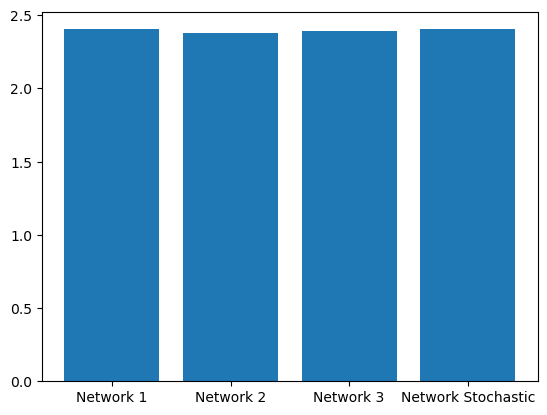

In [21]:
daten = [get_profit(networks_profit_optimized[0], price_list[0]), get_profit(networks_profit_optimized[1], price_list[0]), get_profit(networks_profit_optimized[2], price_list[0]), get_profit(n_stochastic, price_list[0])]
werte = ["Network 1", "Network 2", "Network 3", "Network Stochastic"]


plt.bar(werte, (daten))

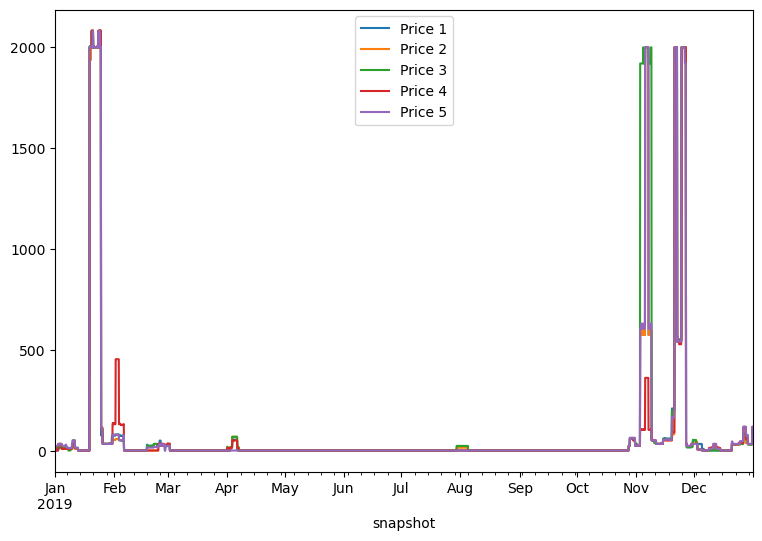

In [73]:
fig= plt.figure(figsize=(9,6))

for i, price in enumerate(price_list):
    price.plot(
        label='Price ' + str(i+1)
    )

plt.legend()

In [ ]:
#soc = networks[2].stores_t.e.sum(axis=1) / networks[2].stores.e_nom.sum()





0.0

In [127]:
for i in range(0,3):
    print(networks[i].stores.e_nom["DE0 0 battery-2045"] > networks[i].stores_t.e["DE0 0 battery-2045"].max())


True
True
True


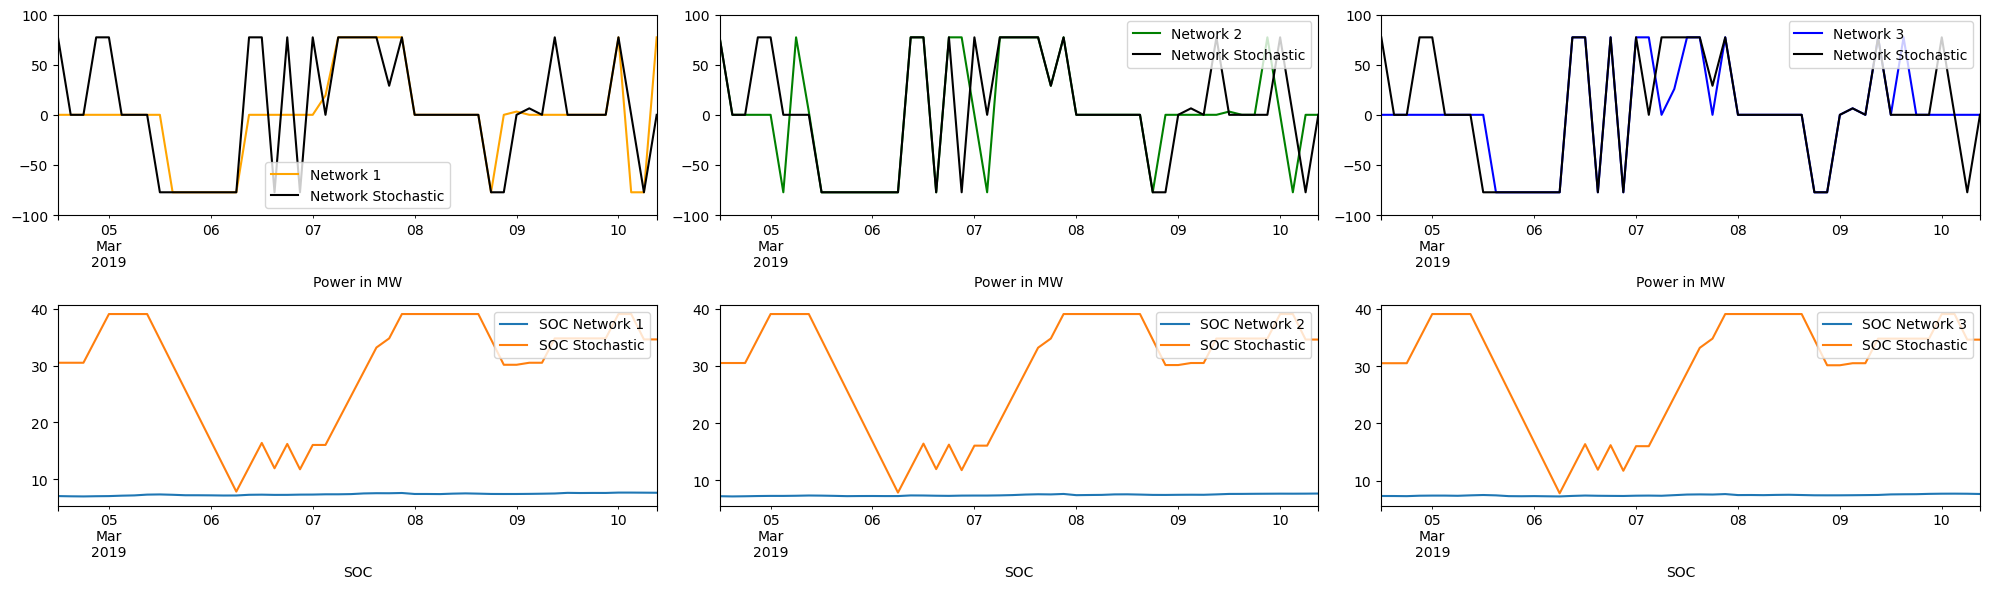

In [145]:
fig, ax= plt.subplots(2,3, figsize=(20,6))

color = ['orange', 'green', 'blue']

for i in [0,1,2]:
    n_p0 = networks_profit_optimized[i].links_t.p0["DE0 0 battery charger-2045"] + networks_profit_optimized[i].links_t.p0["DE0 0 battery charger-2040"] + networks_profit_optimized[i].links_t.p1["DE0 0 battery discharger-2045"] + networks_profit_optimized[i].links_t.p1["DE0 0 battery discharger-2040"]

    n_p0 = n_p0 / 1000
    n_p0[500:548].plot(
        label = "Network " + str(i+1),
        color = color[i],
        ax = ax[0][i],
        ylim=(-100, 100)

    )

    n_stoch_p0 = n_stochastic.links_t.p0["DE0 0 battery charger-2045"] + n_stochastic.links_t.p0["DE0 0 battery charger-2040"] + n_stochastic.links_t.p1["DE0 0 battery discharger-2045"] + n_stochastic.links_t.p1["DE0 0 battery discharger-2040"]
    n_stoch_p0 = n_stoch_p0 / 1000
    n_stoch_p0[500:548].plot(
    label = "Network Stochastic",
    color = 'black',
    ax = ax[0][i]
    )
    ax[0][i].set_xlabel("Time")
    ax[0][i].set_xlabel("Power in MW")
    ax[0][i].legend()
    

for i in [0,1,2]:
    soc = networks[i].stores_t.e.sum(axis=1) / networks[i].stores.e_nom.sum()
    soc = soc * 100
    soc[500:548].plot(
        label="SOC Network " + str(i+1),
        ax = ax[1][i]
    )

    soc = n_stochastic.stores_t.e.sum(axis=1) / n_stochastic.stores.e_nom.sum()
    soc = soc * 100
    soc[500:548].plot(
        label="SOC Stochastic",
        ax = ax[1][i]
    )

    ax[1][i].set_xlabel("Time")
    ax[1][i].set_xlabel("SOC")
    ax[1][i].legend(loc="upper right")

plt.tight_layout()

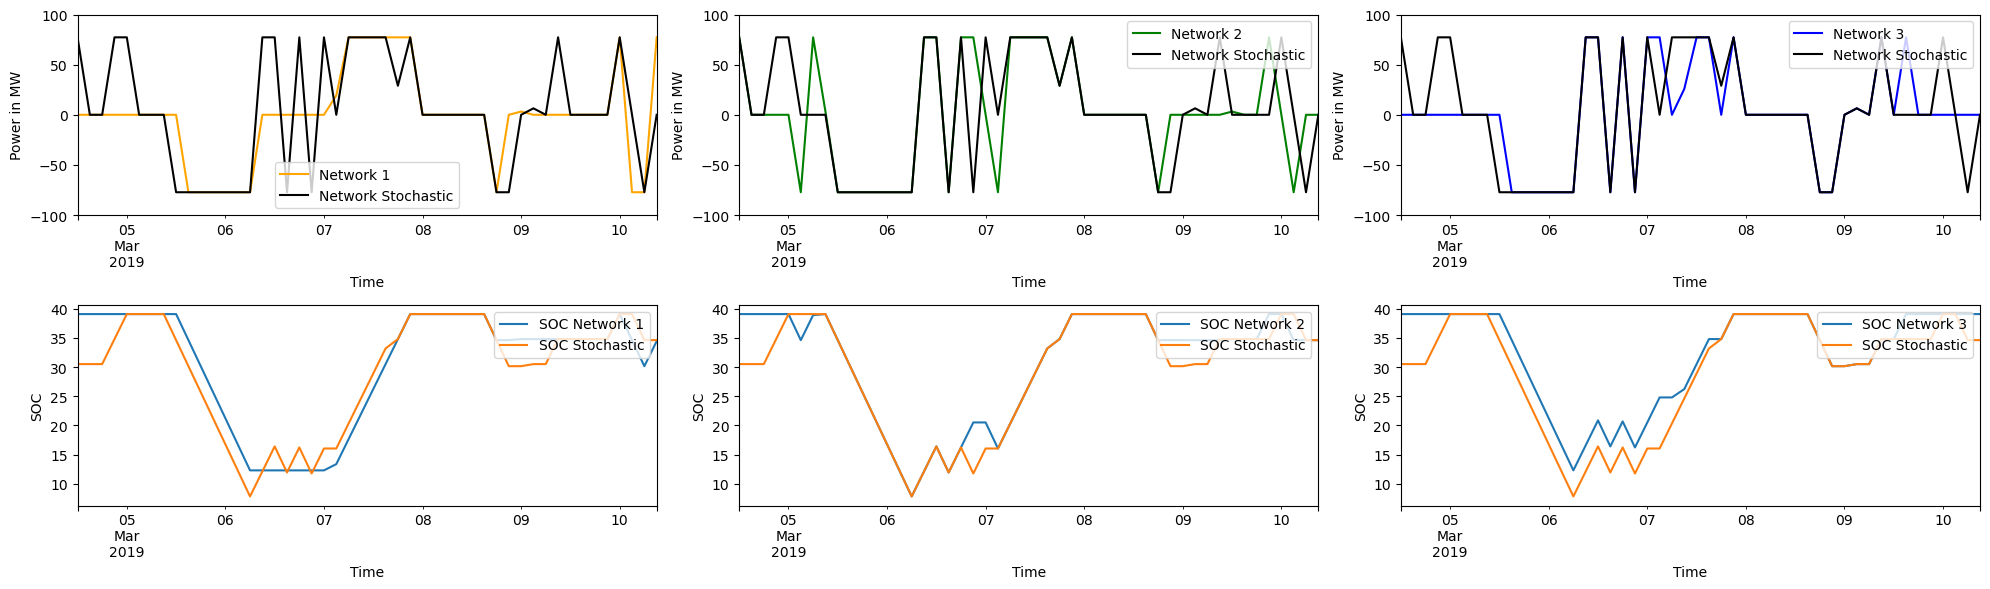

In [146]:
fig, ax= plt.subplots(2,3, figsize=(20,6))

color = ['orange', 'green', 'blue']

for i in [0,1,2]:
    n_p0 = networks_profit_optimized[i].links_t.p0["DE0 0 battery charger-2045"] + networks_profit_optimized[i].links_t.p0["DE0 0 battery charger-2040"] + networks_profit_optimized[i].links_t.p1["DE0 0 battery discharger-2045"] + networks_profit_optimized[i].links_t.p1["DE0 0 battery discharger-2040"]

    n_p0 = n_p0 / 1000
    n_p0[500:548].plot(
        label = "Network " + str(i+1),
        color = color[i],
        ax = ax[0][i],
        ylim=(-100, 100)

    )

    n_stoch_p0 = n_stochastic.links_t.p0["DE0 0 battery charger-2045"] + n_stochastic.links_t.p0["DE0 0 battery charger-2040"] + n_stochastic.links_t.p1["DE0 0 battery discharger-2045"] + n_stochastic.links_t.p1["DE0 0 battery discharger-2040"]
    n_stoch_p0 = n_stoch_p0 / 1000
    n_stoch_p0[500:548].plot(
    label = "Network Stochastic",
    color = 'black',
    ax = ax[0][i]
    )
    ax[0][i].set_xlabel("Time")
    ax[0][i].set_ylabel("Power in MW")
    ax[0][i].legend()
    

for i in [0,1,2]:
    soc = networks_profit_optimized[i].stores_t.e.sum(axis=1) / networks_profit_optimized[i].stores.e_nom.sum()
    soc = soc * 100
    soc[500:548].plot(
        label="SOC Network " + str(i+1),
        ax = ax[1][i]
    )

    soc = n_stochastic.stores_t.e.sum(axis=1) / n_stochastic.stores.e_nom.sum()
    soc = soc * 100
    soc[500:548].plot(
        label="SOC Stochastic",
        ax = ax[1][i]
    )

    ax[1][i].set_xlabel("Time")
    ax[1][i].set_ylabel("SOC")
    ax[1][i].legend(loc="upper right")

plt.tight_layout()